In [264]:
# ------------------------------------------------------------------------------------------------------------------------ #
# ---------------------------------------- 0.import library ---------------------------------------- # 
# ------------------------------------------------------------------------------------------------------------------------ #

# module : 설치가 되어 있지 않으면 설치 필요
import sys
import os
import xlrd
import pandas as pd
import numpy as np
import statistics
import math
import datetime
import time
import re # regural expression
import functools
import random
import gc
import pickle
import warnings
import scipy
import sympy as sym

#
from sys import stdout
from functools import reduce # apply function simultaneously on all elements  
from io import StringIO
from pandas.api.types import CategoricalDtype # convert categorical data type 
from itertools import groupby
from itertools import product
from itertools import chain
from itertools import cycle, islice
from collections import defaultdict
from datetime import datetime # set datetime class 
from collections import Counter
from scipy import stats 

### plot ###
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import gridspec

# 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from scipy.ndimage.filters import gaussian_filter1d # line smoothing    
from tqdm import tqdm
import xgboost


# plot에 한글 사용을 위해서 세팅 : plot에서 한글이 깨지는 경우 font를 직접 지정 해 주어야 함 
from matplotlib import font_manager, rc

# 
font_path = "C:/Windows/Fonts/malgun.ttf" # 맑은고딕
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)


# check module version
print("- python version :", sys.version)# 파이썬 버전
print("- pandas version :", pd.__version__) # pandas 버전
print("- seaborn version :", sns.__version__) # seaborn 버전
print("- matplotlib version :", matplotlib.__version__) # matplotlib 버전


# set options
pd.set_option('display.max_row', 100) # row 100개까지 display 
pd.set_option('display.max_columns', 120) # column 120개까지 display

# set work directory
# os.chdir(r"C:\Users\2019002\Desktop\전기로국책과제")

# 
print("- dir path :", os.getcwd())

# ignore warnings
warnings.filterwarnings("ignore")
# ------------------------------------------------------------------------------------------------------------------------ #

- python version : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
- pandas version : 1.4.4
- seaborn version : 0.11.2
- matplotlib version : 3.5.2
- dir path : \\10.216.153.164\home\begas\27. AI활용 전기로 에너지 효율 최적화 기술개발\DAT\rawdata\2차년도


## Data 불러오기

### charge 장입량

In [265]:
# 2023년 장입량 데이터 : 2023년 월단위로 별도로 추가하여 갱신 필요
# xls 파일로 작업된 내용은 원본을 토대로 기존 항목에 맞춰 동일하게 항목명을 통일시킨 csv파일 활용함
# os.chdir(r"D:\국책과제_2차년도\DAT\rawdata\2차년도\charge장입량_year23_csv\mes")
os.chdir(r"\\10.216.153.164\home\begas\27. AI활용 전기로 에너지 효율 최적화 기술개발\DAT\rawdata\2차년도\charge장입량_year23_csv\mes")
chr_folderlist = os.listdir()

chr_file_ls = []
for chr_file in chr_folderlist : 

    print(chr_file)
    # import file
    chr_file_dt = pd.read_csv(chr_file, encoding = "cp949")
    chr_file_ls.append(chr_file_dt)
;

# 
input_ton_charge_2023 = pd.concat(chr_file_ls, axis = 0)
input_ton_charge_2023.sort_values("heat", inplace = True)

# 
input_ton_charge_2023 = input_ton_charge_2023[~pd.isna(input_ton_charge_2023["heat"])]
input_ton_charge_2023["heat"] = ["E" + str(int(x)) for x in input_ton_charge_2023["heat"]]
input_ton_charge_2023.rename(columns = {"heat" : "HEAT_NO"}, inplace = True)

# 
reshape_input_ton_charge_2023 = input_ton_charge_2023[["HEAT_NO", "1cha_ton", "2cha_ton", "3cha_ton"]].melt(id_vars = ["HEAT_NO"]) 
reshape_input_ton_charge_2023["ActualCHRG_PX3"] = [int(x[0]) for x in reshape_input_ton_charge_2023["variable"]]
reshape_input_ton_charge_2023.rename(columns = {"value" : "MES_ton"}, inplace = True)
reshape_input_ton_charge_2023["MES_ton"] = reshape_input_ton_charge_2023["MES_ton"].fillna(0)
reshape_input_ton_charge_2023["tot_mes_ton"] = reshape_input_ton_charge_2023.groupby(["HEAT_NO"])["MES_ton"].transform(lambda x: sum(x))
reshape_input_ton_charge_2023["장입횟수"] = reshape_input_ton_charge_2023.groupby(["HEAT_NO"])["MES_ton"].transform(lambda x : len(x) - sum(x ==0))

Apr_mes.csv
Aug_mes.csv
Dec_mes.csv
Feb_mes.csv
Jan_mes.csv
Jul_mes.csv
Jun_mes.csv
Mar_mes.csv
May_mes.csv
Nov_mes.csv
Oct_mes.csv
Sep_mes.csv


### 조업지표(강종, 반 정보)

In [266]:
os.chdir(r"\\10.216.153.164\home\begas\27. AI활용 전기로 에너지 효율 최적화 기술개발\DAT\rawdata\2차년도")
steelinfo_23_simple = pd.read_csv("2023_전기로조업지표_간이.csv", header = 0, encoding = "cp949")
steelinfo_23_simple

,NO,생산일자,HEAT_NO,생산강종,용강특성,반,통전패턴
0,1.0,2023.01.02,E235373,SS275A36(T<25),NaN,D,10.0
1,2.0,2023.01.02,E235374,SS275A36(T<25),NaN,D,10.0
2,3.0,2023.01.02,E235375,SS275A36(T<25),NaN,D,10.0
3,4.0,2023.01.02,E235376,SS275A36(T<25),NaN,D,10.0
4,5.0,2023.01.02,E235377,SS275A36(T<25),NaN,D,10.0
...,...,...,...,...,...,...,...
5355,353.0,2023.12.28,E240728,S275JR04,NaN,D,10.0
5356,354.0,2023.12.28,E240729,SN400B(CNS),NaN,D,10.0
5357,355.0,2023.12.28,E240730,SN400B(CNS),NaN,D,10.0
5358,356.0,2023.12.28,E240731,SN400B(CNS),NaN,D,10.0


### smart arc 

In [267]:
col_select = ["Month", "HEAT_NO", "SmartArcNumberOV", "Time", "ActualCHRG_PX3", "ActFceTap_Px3", "Charge_MWH", "MWH_PX3",  
              "SF1", "SF2", "SF3", "VoltSF1", "VoltSF2", "VoltSF3", "ExtSmartFactor1", "ExtSmartFactor2", "ExtSmartFactor3",
              'Current1', 'Current2', 'Current3', 'Voltage1', 'Voltage2', 'Voltage3',
              "ZFeedback1", "ZFeedback2", "ZFeedback3", "Res1", "Res2", "Res3", 
              "Reactance1", "Reactance2", "Reactance3", "ArcLength1", "ArcLength2", "ArcLength3",
              "MVA1", "MVA2", "MVA3", "MVATot", "MWTot", "MVARTot", "PFTot", 
              "MW1", "MW2", "MW3", "MVAR1", "MVAR2", "MVAR3", "PF1", "PF2", "PF3", "RWI1", "RWI2", "RWI3", 
              "ArcEfficiency1", "ArcEfficiency2", "ArcEfficiency3", "I2H1", "I2H2", "I2H3", 
              "VoltageLineToLine12", "VoltageLineToLine23", "VoltageLineToLine31",
              "TimeSincePwrOn", "PX3SteelTemp",
              "PX3BurnerO2", "PX3LanceO2", 
              "Px3ChargeCarbon", "PX3InjecCarbon", "All-mixConsumption",
              "PX3Lime", "PX3DoloLime",
              "B5_CarbonFlow", "B1_CarbonFlow", "CarbTopFeed_Cons", 
              "B5_O2MainFlow", "B1_O2MainFlow", "B2_O2MainFlow", "B4_O2MainFlow", 
              "B1_O2ShroudFlow", "B2_O2ShroudFlow", "B4_O2ShroudFlow",
              "SFCE_CO2_Pct", "SFCE_CO_Pct", "SFCE_H2O_Pct", "SFCE_Offgas_MassFlow",
              "NormH2OPctFlow", "NormCO2PctFlow", "NormCOPctFlow", "COCO2Ratio_Clus"]

In [28]:
# os.chdir(r"\\10.216.153.164\home\begas\27. AI활용 전기로 에너지 효율 최적화 기술개발\DAT\rawdata\2차년도")
os.chdir(r"\\10.216.153.164\home\begas\27. AI활용 전기로 에너지 효율 최적화 기술개발\DAT\rawdata\2차년도")
# 2023년 상반기 데이터 
arc_2023H1_SNOV_9_filter = pd.read_pickle(r"arc_2023_SNOV_9_filter_2023H1.pkl")

# 2023년 하반기 데이터 
arc_2023H2_SNOV_9_filter = pd.read_pickle(r"arc_2023_SNOV_9_filter_2023H2.pkl")

In [29]:
# 
arc_2023H1_SNOV_9_filter.reset_index(drop = True, inplace = True)
arc_2023H2_SNOV_9_filter.reset_index(drop = True, inplace = True)

In [30]:
#
arc_2023_analysis = pd.concat([arc_2023H1_SNOV_9_filter[col_select + ["total_time"]], 
                               arc_2023H2_SNOV_9_filter[col_select + ["total_time"]]], 
                               axis = 0, ignore_index = True)

### 승온기 분리

In [268]:
# charge 3 분리 
arc_charge_3 = arc_2023_analysis[arc_2023_analysis["ActualCHRG_PX3"] == 3]

In [33]:
# 
fulldata_heatlist = pd.unique(arc_charge_3["HEAT_NO"]).tolist()

In [34]:
# 승온기 탐지를 위한 시작지점 탐색 
all_h_timedelta_ls = []
Errorheat_list = []

# 
for heat in tqdm(fulldata_heatlist) : 
    
    # 
    print("- heat : ", heat)

    # 
    data = arc_charge_3[arc_charge_3["HEAT_NO"] == heat]

    # 
    data["c1"] = np.where(data["TimeSincePwrOn"] <= 0.1, 1, 0) # 0이 되는 signal loss 존재 
    data["c2"] = np.where(data["PX3SteelTemp"] > 0, 1, 0)

    # Power On이 지속되기만 하면 진행 불가 
    if sum(data["c1"]) == 0 : 

        # 
        print("- Condition 1 ERROR HEAT : ", heat)
        CODE = "Condition 1 False"
        check_tag = "TimeSincePwrOn all upper crit value"
        info_dt = pd.DataFrame({"CODE" : CODE, "check_tag" : check_tag, "HEAT_NO" : heat}, index = [0])
        Errorheat_list.append(info_dt)

        continue 
    ;

    # 측온값이 전혀 없으면 진행 불가 
    if sum(data["c2"]) == 0 : 

        # 
        print("- Condition 1 ERROR HEAT : ", heat)
        CODE = "Condition 2 False"
        check_tag = "PX3SteelTemp all zero"
        info_dt = pd.DataFrame({"CODE" : CODE, "check_tag" : check_tag, "HEAT_NO" : heat}, index = [0])
        Errorheat_list.append(info_dt)

        continue 
    ;
    
    try : 
        
        # 
        data["diff_PwrOn"] = (data["TimeSincePwrOn"] - data["TimeSincePwrOn"].shift(1)).fillna(np.nan)
        data["diff_PwrOn_flag"] = np.where(data["diff_PwrOn"] < 0, 1, 0)
        data["int_num"] = np.cumsum(data["diff_PwrOn_flag"]) + 1

        # 측온온도값이 존재하는 구간 찾기 
        target_start_int = min(data[data["PX3SteelTemp"] > 0]["int_num"])

        # 구간 내 실제 Power On 시작지점 찾기 
        # >> TimeSincePwrOn이 0이 아닌 최소값을 가지는 지점 
        Temp_inc_st = min(data[(data["int_num"] == target_start_int)&(data["TimeSincePwrOn"] > 0)]["Time"])
        data["change_point"] = np.where(data["Time"] == Temp_inc_st, 1, 0)
        data["Inc_Temp_tag"] = np.where(data["Time"] > Temp_inc_st, "Int_Heating", "Int_Melting")

        # 
        all_h_timedelta_ls.append(data)

    except : 
        
        # 
        print("- Tracking ERROR HEAT : ", heat)
        CODE = "Tracking ERROR"
        check_tag = "Not found change points"
        info_dt = pd.DataFrame({"CODE" : CODE, "check_tag" : check_tag, "HEAT_NO" : heat}, index = [0])
        Errorheat_list.append(info_dt)

        continue

    ;

;



  0%|                                                                                 | 2/4934 [00:00<06:47, 12.10it/s]

- heat :  E235375
- heat :  E235377
- heat :  E235378
- heat :  E235379


  0%|                                                                                 | 6/4934 [00:00<06:43, 12.21it/s]

- Tracking ERROR HEAT :  E235379
- heat :  E235380
- heat :  E235383
- heat :  E235384


  0%|▏                                                                               | 10/4934 [00:00<06:44, 12.17it/s]

- heat :  E235385
- heat :  E235386
- heat :  E235387
- heat :  E235388


  0%|▏                                                                               | 14/4934 [00:01<06:46, 12.11it/s]

- heat :  E235389
- heat :  E235390
- heat :  E235391
- heat :  E235392


  0%|▎                                                                               | 18/4934 [00:01<06:45, 12.13it/s]

- heat :  E235393
- heat :  E235394
- heat :  E235395
- heat :  E235398


  0%|▎                                                                               | 22/4934 [00:01<06:44, 12.13it/s]

- heat :  E235399
- heat :  E235400
- heat :  E235401
- heat :  E235402


  1%|▍                                                                               | 26/4934 [00:02<06:45, 12.12it/s]

- heat :  E235403
- heat :  E235406
- heat :  E235407
- heat :  E235409


  1%|▍                                                                               | 30/4934 [00:02<06:42, 12.17it/s]

- heat :  E235410
- heat :  E235411
- heat :  E235412
- Tracking ERROR HEAT :  E235412
- heat :  E235413


  1%|▌                                                                               | 34/4934 [00:02<06:42, 12.16it/s]

- heat :  E235414
- heat :  E235415
- heat :  E235416
- heat :  E235417


  1%|▌                                                                               | 38/4934 [00:03<06:41, 12.18it/s]

- heat :  E235418
- heat :  E235419
- heat :  E235420
- heat :  E235421


  1%|▋                                                                               | 42/4934 [00:03<06:41, 12.18it/s]

- heat :  E235422
- heat :  E235423
- heat :  E235424
- heat :  E235425


  1%|▋                                                                               | 46/4934 [00:03<06:41, 12.18it/s]

- heat :  E235426
- heat :  E235427
- heat :  E235428
- heat :  E235429


  1%|▊                                                                               | 50/4934 [00:04<06:40, 12.20it/s]

- heat :  E235430
- heat :  E235431
- heat :  E235432
- heat :  E235433


  1%|▉                                                                               | 54/4934 [00:04<06:38, 12.24it/s]

- heat :  E235434
- heat :  E235435
- heat :  E235436
- heat :  E235437


  1%|▉                                                                               | 58/4934 [00:04<06:37, 12.26it/s]

- heat :  E235438
- heat :  E235441
- heat :  E235442
- heat :  E235443


  1%|█                                                                               | 62/4934 [00:05<06:36, 12.28it/s]

- heat :  E235444
- heat :  E235445
- heat :  E235446
- heat :  E235447


  1%|█                                                                               | 66/4934 [00:05<06:38, 12.23it/s]

- heat :  E235448
- heat :  E235450
- heat :  E235452
- heat :  E235453


  1%|█▏                                                                              | 70/4934 [00:05<06:38, 12.20it/s]

- heat :  E235454
- heat :  E235455
- heat :  E235456
- Tracking ERROR HEAT :  E235456
- heat :  E235457


  1%|█▏                                                                              | 74/4934 [00:06<06:36, 12.27it/s]

- heat :  E235458
- heat :  E235459
- heat :  E235460
- heat :  E235461


  2%|█▎                                                                              | 78/4934 [00:06<06:36, 12.24it/s]

- heat :  E235462
- heat :  E235463
- heat :  E235465
- heat :  E235468


  2%|█▎                                                                              | 82/4934 [00:06<06:36, 12.25it/s]

- heat :  E235469
- heat :  E235470
- heat :  E235471
- heat :  E235472


  2%|█▍                                                                              | 86/4934 [00:07<06:35, 12.26it/s]

- heat :  E235473
- heat :  E235474
- heat :  E235475
- heat :  E235476


  2%|█▍                                                                              | 90/4934 [00:07<06:35, 12.25it/s]

- heat :  E235477
- heat :  E235478
- heat :  E235479
- heat :  E235480


  2%|█▌                                                                              | 94/4934 [00:07<06:33, 12.29it/s]

- heat :  E235481
- heat :  E235482
- heat :  E235483
- heat :  E235484


  2%|█▌                                                                              | 98/4934 [00:08<06:34, 12.27it/s]

- heat :  E235485
- heat :  E235486
- heat :  E235487
- heat :  E235488


  2%|█▋                                                                             | 102/4934 [00:08<06:35, 12.21it/s]

- heat :  E235489
- heat :  E235490
- heat :  E235491
- heat :  E235492


  2%|█▋                                                                             | 106/4934 [00:08<06:35, 12.21it/s]

- heat :  E235493
- heat :  E235494
- heat :  E235495
- heat :  E235496


  2%|█▊                                                                             | 110/4934 [00:09<06:34, 12.24it/s]

- heat :  E235497
- heat :  E235498
- heat :  E235499
- heat :  E235500


  2%|█▊                                                                             | 114/4934 [00:09<06:34, 12.23it/s]

- heat :  E235501
- heat :  E235502
- heat :  E235503
- heat :  E235504


  2%|█▉                                                                             | 118/4934 [00:09<06:32, 12.28it/s]

- heat :  E235505
- heat :  E235506
- heat :  E235507
- heat :  E235508


  2%|█▉                                                                             | 122/4934 [00:09<06:32, 12.26it/s]

- heat :  E235509
- heat :  E235510
- heat :  E235511
- heat :  E235512


  3%|██                                                                             | 126/4934 [00:10<06:34, 12.20it/s]

- heat :  E235513
- heat :  E235514
- heat :  E235516
- heat :  E235517


  3%|██                                                                             | 130/4934 [00:10<06:33, 12.21it/s]

- heat :  E235518
- heat :  E235519
- heat :  E235520
- heat :  E235521


  3%|██▏                                                                            | 134/4934 [00:10<06:32, 12.24it/s]

- Tracking ERROR HEAT :  E235521
- heat :  E235522
- Tracking ERROR HEAT :  E235522
- heat :  E235523
- heat :  E235524
- heat :  E235525


  3%|██▏                                                                            | 138/4934 [00:11<06:32, 12.21it/s]

- heat :  E235526
- heat :  E235527
- heat :  E235528
- heat :  E235529


  3%|██▎                                                                            | 142/4934 [00:11<06:30, 12.26it/s]

- heat :  E235530
- heat :  E235531
- heat :  E235532
- heat :  E235533


  3%|██▎                                                                            | 146/4934 [00:11<06:31, 12.23it/s]

- heat :  E235534
- heat :  E235537
- heat :  E235538
- heat :  E235539


  3%|██▍                                                                            | 150/4934 [00:12<06:31, 12.22it/s]

- heat :  E235540
- heat :  E235541
- heat :  E235542
- heat :  E235543


  3%|██▍                                                                            | 154/4934 [00:12<06:30, 12.26it/s]

- heat :  E235544
- heat :  E235545
- heat :  E235546
- heat :  E235547


  3%|██▌                                                                            | 158/4934 [00:12<06:29, 12.27it/s]

- heat :  E235548
- heat :  E235549
- heat :  E235550
- heat :  E235551


  3%|██▌                                                                            | 162/4934 [00:13<06:27, 12.31it/s]

- heat :  E235552
- heat :  E235553
- heat :  E235554
- heat :  E235555


  3%|██▋                                                                            | 166/4934 [00:13<06:26, 12.33it/s]

- heat :  E235556
- heat :  E235557
- heat :  E235558
- heat :  E235559


  3%|██▋                                                                            | 170/4934 [00:13<06:26, 12.31it/s]

- heat :  E235560
- heat :  E235561
- heat :  E235562
- heat :  E235563


  4%|██▊                                                                            | 174/4934 [00:14<06:26, 12.31it/s]

- heat :  E235564
- heat :  E235565
- heat :  E235566
- heat :  E235567


  4%|██▊                                                                            | 178/4934 [00:14<06:26, 12.30it/s]

- heat :  E235568
- heat :  E235569
- heat :  E235573
- heat :  E235574


  4%|██▉                                                                            | 182/4934 [00:14<06:28, 12.25it/s]

- heat :  E235575
- heat :  E235576
- heat :  E235577
- heat :  E235578


  4%|██▉                                                                            | 186/4934 [00:15<06:29, 12.20it/s]

- heat :  E235579
- heat :  E235580
- heat :  E235581
- heat :  E235582


  4%|███                                                                            | 190/4934 [00:15<06:26, 12.26it/s]

- heat :  E235583
- heat :  E235584
- heat :  E235585
- heat :  E235586


  4%|███                                                                            | 194/4934 [00:15<06:28, 12.21it/s]

- heat :  E235587
- heat :  E235588
- heat :  E235589
- heat :  E235590


  4%|███▏                                                                           | 198/4934 [00:16<06:25, 12.29it/s]

- heat :  E235591
- heat :  E235592
- heat :  E235593
- heat :  E235594


  4%|███▏                                                                           | 202/4934 [00:16<06:26, 12.24it/s]

- heat :  E235595
- heat :  E235596
- heat :  E235597
- heat :  E235598


  4%|███▎                                                                           | 206/4934 [00:16<06:26, 12.22it/s]

- heat :  E235599
- heat :  E235600
- heat :  E235601
- heat :  E235602


  4%|███▎                                                                           | 210/4934 [00:17<06:26, 12.23it/s]

- heat :  E235603
- heat :  E235604
- heat :  E235605
- heat :  E235606


  4%|███▍                                                                           | 214/4934 [00:17<06:25, 12.23it/s]

- heat :  E235607
- heat :  E235608
- heat :  E235609
- heat :  E235610


  4%|███▍                                                                           | 218/4934 [00:17<06:25, 12.24it/s]

- heat :  E235611
- heat :  E235612
- heat :  E235613
- heat :  E235614


  4%|███▌                                                                           | 222/4934 [00:18<06:23, 12.29it/s]

- heat :  E235615
- heat :  E235616
- heat :  E235617
- heat :  E235618


  5%|███▌                                                                           | 226/4934 [00:18<06:23, 12.29it/s]

- heat :  E235619
- heat :  E235620
- heat :  E235621
- heat :  E235622


  5%|███▋                                                                           | 230/4934 [00:18<06:23, 12.28it/s]

- heat :  E235623
- heat :  E235624
- heat :  E235625
- heat :  E235626


  5%|███▋                                                                           | 234/4934 [00:19<06:22, 12.30it/s]

- heat :  E235627
- heat :  E235628
- heat :  E235629
- heat :  E235630


  5%|███▊                                                                           | 238/4934 [00:19<06:22, 12.28it/s]

- heat :  E235631
- heat :  E235632
- heat :  E235633
- heat :  E235634


  5%|███▊                                                                           | 242/4934 [00:19<06:21, 12.30it/s]

- heat :  E235635
- Tracking ERROR HEAT :  E235635
- heat :  E235636
- heat :  E235637
- heat :  E235638


  5%|███▉                                                                           | 246/4934 [00:20<06:20, 12.32it/s]

- heat :  E235639
- heat :  E235640
- heat :  E235641
- heat :  E235642


  5%|████                                                                           | 250/4934 [00:20<06:21, 12.29it/s]

- heat :  E235643
- heat :  E235644
- heat :  E235645
- heat :  E235646


  5%|████                                                                           | 254/4934 [00:20<06:20, 12.31it/s]

- heat :  E235647
- Tracking ERROR HEAT :  E235647
- heat :  E235648
- heat :  E235649
- Tracking ERROR HEAT :  E235649
- heat :  E235650


  5%|████▏                                                                          | 258/4934 [00:21<06:20, 12.30it/s]

- heat :  E235651
- heat :  E235652
- Tracking ERROR HEAT :  E235652
- heat :  E235653
- heat :  E235654


  5%|████▏                                                                          | 262/4934 [00:21<06:21, 12.25it/s]

- heat :  E235655
- heat :  E235656
- heat :  E235657
- heat :  E235658


  5%|████▎                                                                          | 266/4934 [00:21<06:20, 12.26it/s]

- heat :  E235659
- heat :  E235660
- heat :  E235661
- heat :  E235662


  5%|████▎                                                                          | 270/4934 [00:22<06:20, 12.26it/s]

- heat :  E235663
- heat :  E235664
- heat :  E235665
- heat :  E235666


  6%|████▍                                                                          | 274/4934 [00:22<06:19, 12.28it/s]

- heat :  E235667
- heat :  E235668
- heat :  E235669
- heat :  E235670


  6%|████▍                                                                          | 278/4934 [00:22<06:19, 12.28it/s]

- heat :  E235671
- heat :  E235672
- heat :  E235673
- heat :  E235674


  6%|████▌                                                                          | 282/4934 [00:23<06:18, 12.29it/s]

- Tracking ERROR HEAT :  E235674
- heat :  E235675
- heat :  E235676
- heat :  E235677
- heat :  E235678


  6%|████▌                                                                          | 286/4934 [00:23<06:18, 12.28it/s]

- heat :  E235679
- heat :  E235680
- heat :  E235681
- heat :  E235682


  6%|████▋                                                                          | 290/4934 [00:23<06:17, 12.29it/s]

- heat :  E235683
- heat :  E235684
- heat :  E235685
- heat :  E235686


  6%|████▋                                                                          | 294/4934 [00:24<06:18, 12.27it/s]

- heat :  E235687
- heat :  E235688
- heat :  E235689
- heat :  E235690


  6%|████▊                                                                          | 298/4934 [00:24<06:19, 12.22it/s]

- heat :  E235691
- heat :  E235692
- heat :  E235693
- heat :  E235694


  6%|████▊                                                                          | 302/4934 [00:24<06:17, 12.27it/s]

- heat :  E235695
- heat :  E235696
- heat :  E235699
- heat :  E235700


  6%|████▉                                                                          | 306/4934 [00:24<06:16, 12.29it/s]

- heat :  E235701
- heat :  E235702
- heat :  E235703
- heat :  E235704


  6%|████▉                                                                          | 310/4934 [00:25<06:18, 12.22it/s]

- heat :  E235705
- heat :  E235706
- heat :  E235707
- heat :  E235708


  6%|█████                                                                          | 314/4934 [00:25<06:16, 12.28it/s]

- heat :  E235709
- heat :  E235710
- heat :  E235711
- heat :  E235712


  6%|█████                                                                          | 318/4934 [00:25<06:16, 12.27it/s]

- heat :  E235713
- heat :  E235716
- heat :  E235717
- heat :  E235718


  6%|█████                                                                          | 320/4934 [00:26<06:16, 12.26it/s]

- heat :  E235719
- heat :  E235720
- heat :  E235721


  7%|█████▏                                                                         | 324/4934 [00:26<07:25, 10.35it/s]

- heat :  E235722
- heat :  E235723
- heat :  E235724
- heat :  E235725


  7%|█████▎                                                                         | 328/4934 [00:26<06:49, 11.24it/s]

- heat :  E235726
- heat :  E235727
- heat :  E235728
- heat :  E235729


  7%|█████▎                                                                         | 332/4934 [00:27<06:31, 11.75it/s]

- heat :  E235730
- heat :  E235731
- heat :  E235732
- heat :  E235733


  7%|█████▍                                                                         | 336/4934 [00:27<06:21, 12.04it/s]

- heat :  E235734
- heat :  E235735
- heat :  E235738
- heat :  E235739


  7%|█████▍                                                                         | 340/4934 [00:27<06:18, 12.14it/s]

- heat :  E235740
- heat :  E235741
- heat :  E235742
- heat :  E235743


  7%|█████▌                                                                         | 344/4934 [00:28<06:16, 12.20it/s]

- heat :  E235744
- heat :  E235745
- heat :  E235746
- heat :  E235747


  7%|█████▌                                                                         | 348/4934 [00:28<06:14, 12.25it/s]

- heat :  E235748
- heat :  E235751
- heat :  E235752
- heat :  E235753


  7%|█████▋                                                                         | 352/4934 [00:28<06:15, 12.19it/s]

- heat :  E235754
- heat :  E235755
- heat :  E235756
- heat :  E235757


  7%|█████▋                                                                         | 356/4934 [00:29<06:14, 12.22it/s]

- heat :  E235758
- heat :  E235759
- heat :  E235760
- heat :  E235761


  7%|█████▊                                                                         | 360/4934 [00:29<06:14, 12.21it/s]

- heat :  E235762
- heat :  E235763
- heat :  E235764
- heat :  E235765


  7%|█████▊                                                                         | 364/4934 [00:29<06:14, 12.22it/s]

- heat :  E235766
- heat :  E235767
- heat :  E235770
- heat :  E235771


  7%|█████▉                                                                         | 368/4934 [00:30<06:14, 12.19it/s]

- heat :  E235772
- heat :  E235773
- heat :  E235774
- heat :  E235775


  8%|█████▉                                                                         | 372/4934 [00:30<06:12, 12.24it/s]

- heat :  E235776
- heat :  E235777
- heat :  E235778
- heat :  E235779


  8%|██████                                                                         | 376/4934 [00:30<06:12, 12.24it/s]

- heat :  E235780
- heat :  E235781
- heat :  E235782
- heat :  E235783


  8%|██████                                                                         | 380/4934 [00:31<06:10, 12.30it/s]

- heat :  E235784
- heat :  E235785
- heat :  E235786
- heat :  E235787


  8%|██████▏                                                                        | 384/4934 [00:31<06:10, 12.29it/s]

- heat :  E235788
- heat :  E235789
- heat :  E235790
- heat :  E235793


  8%|██████▏                                                                        | 388/4934 [00:31<06:10, 12.26it/s]

- heat :  E235794
- heat :  E235795
- heat :  E235796
- heat :  E235797


  8%|██████▎                                                                        | 392/4934 [00:32<06:11, 12.24it/s]

- heat :  E235798
- heat :  E235799
- heat :  E235800
- heat :  E235801


  8%|██████▎                                                                        | 396/4934 [00:32<06:10, 12.25it/s]

- heat :  E235802
- heat :  E235803
- heat :  E235804
- heat :  E235805


  8%|██████▍                                                                        | 400/4934 [00:32<06:08, 12.29it/s]

- heat :  E235806
- heat :  E235807
- heat :  E235808
- Tracking ERROR HEAT :  E235808
- heat :  E235809


  8%|██████▍                                                                        | 404/4934 [00:33<06:07, 12.31it/s]

- heat :  E235810
- heat :  E235811
- heat :  E235812
- heat :  E235813


  8%|██████▌                                                                        | 408/4934 [00:33<06:07, 12.32it/s]

- heat :  E235814
- heat :  E235815
- heat :  E235816
- heat :  E235817


  8%|██████▌                                                                        | 412/4934 [00:33<06:08, 12.28it/s]

- heat :  E235818
- heat :  E235819
- heat :  E235820
- heat :  E235821


  8%|██████▋                                                                        | 416/4934 [00:34<06:09, 12.24it/s]

- heat :  E235822
- heat :  E235823
- heat :  E235824
- heat :  E235825


  9%|██████▋                                                                        | 420/4934 [00:34<06:08, 12.26it/s]

- heat :  E235826
- heat :  E235827
- heat :  E235828
- heat :  E235829


  9%|██████▊                                                                        | 424/4934 [00:34<06:08, 12.23it/s]

- heat :  E235830
- heat :  E235831
- heat :  E235832
- heat :  E235833


  9%|██████▊                                                                        | 428/4934 [00:35<06:08, 12.24it/s]

- heat :  E235834
- heat :  E235835
- heat :  E235836
- heat :  E235837


  9%|██████▉                                                                        | 432/4934 [00:35<06:06, 12.30it/s]

- heat :  E235838
- heat :  E235839
- heat :  E235840
- heat :  E235841


  9%|██████▉                                                                        | 436/4934 [00:35<06:06, 12.27it/s]

- heat :  E235842
- heat :  E235843
- heat :  E235844
- heat :  E235845


  9%|███████                                                                        | 440/4934 [00:36<06:05, 12.28it/s]

- heat :  E235846
- heat :  E235847
- heat :  E235848
- heat :  E235849


  9%|███████                                                                        | 444/4934 [00:36<06:06, 12.27it/s]

- heat :  E235850
- heat :  E235851
- heat :  E235852
- heat :  E235853


  9%|███████▏                                                                       | 448/4934 [00:36<06:07, 12.22it/s]

- heat :  E235854
- heat :  E235855
- heat :  E235856
- heat :  E235857


  9%|███████▏                                                                       | 452/4934 [00:37<06:05, 12.27it/s]

- heat :  E235858
- heat :  E235859
- heat :  E235860
- heat :  E235861


  9%|███████▎                                                                       | 456/4934 [00:37<06:04, 12.28it/s]

- heat :  E235864
- heat :  E235865
- heat :  E235866
- heat :  E235870


  9%|███████▎                                                                       | 460/4934 [00:37<06:04, 12.27it/s]

- heat :  E235871
- heat :  E235872
- heat :  E235873
- heat :  E235874


  9%|███████▍                                                                       | 464/4934 [00:38<06:03, 12.28it/s]

- heat :  E235875
- heat :  E235876
- heat :  E235878
- heat :  E235879


  9%|███████▍                                                                       | 468/4934 [00:38<06:04, 12.26it/s]

- heat :  E235880
- heat :  E235881
- heat :  E235882
- heat :  E235883


 10%|███████▌                                                                       | 472/4934 [00:38<06:03, 12.28it/s]

- heat :  E235884
- heat :  E235885
- heat :  E235888
- heat :  E235889


 10%|███████▌                                                                       | 476/4934 [00:39<06:03, 12.26it/s]

- heat :  E235890
- heat :  E235891
- heat :  E235892
- heat :  E235893


 10%|███████▋                                                                       | 480/4934 [00:39<06:03, 12.26it/s]

- heat :  E235894
- heat :  E235895
- heat :  E235896
- heat :  E235897


 10%|███████▋                                                                       | 484/4934 [00:39<06:05, 12.17it/s]

- heat :  E235898
- heat :  E235899
- heat :  E235900
- heat :  E235901


 10%|███████▊                                                                       | 488/4934 [00:39<06:06, 12.14it/s]

- heat :  E235902
- heat :  E235903
- heat :  E235904
- heat :  E235905


 10%|███████▉                                                                       | 492/4934 [00:40<06:06, 12.12it/s]

- heat :  E235906
- Tracking ERROR HEAT :  E235906
- heat :  E235907
- heat :  E235908
- heat :  E235909


 10%|███████▉                                                                       | 496/4934 [00:40<06:06, 12.13it/s]

- Tracking ERROR HEAT :  E235909
- heat :  E235910
- heat :  E235911
- heat :  E235912


 10%|████████                                                                       | 500/4934 [00:40<06:04, 12.17it/s]

- Tracking ERROR HEAT :  E235912
- heat :  E235913
- Tracking ERROR HEAT :  E235913
- heat :  E235914
- Tracking ERROR HEAT :  E235914
- heat :  E235915
- Tracking ERROR HEAT :  E235915
- heat :  E235916


 10%|████████                                                                       | 504/4934 [00:41<06:03, 12.20it/s]

- Tracking ERROR HEAT :  E235916
- heat :  E235917
- Tracking ERROR HEAT :  E235917
- heat :  E235918
- Tracking ERROR HEAT :  E235918
- heat :  E235919
- Tracking ERROR HEAT :  E235919
- heat :  E235920


 10%|████████▏                                                                      | 508/4934 [00:41<05:54, 12.48it/s]

- Condition 1 ERROR HEAT :  E235920
- heat :  E235921
- Condition 1 ERROR HEAT :  E235921
- heat :  E235922
- Condition 1 ERROR HEAT :  E235922
- heat :  E235923
- Condition 1 ERROR HEAT :  E235923
- heat :  E235924


 10%|████████▏                                                                      | 512/4934 [00:41<05:57, 12.37it/s]

- heat :  E235925
- heat :  E235926
- Condition 1 ERROR HEAT :  E235926
- heat :  E235929
- heat :  E235930


 10%|████████▎                                                                      | 516/4934 [00:42<06:01, 12.23it/s]

- heat :  E235931
- heat :  E235932
- heat :  E235933
- heat :  E235934


 11%|████████▎                                                                      | 520/4934 [00:42<06:02, 12.17it/s]

- heat :  E235935
- heat :  E235936
- heat :  E235937
- heat :  E235938


 11%|████████▍                                                                      | 524/4934 [00:42<06:03, 12.14it/s]

- heat :  E235939
- heat :  E235940
- heat :  E235941
- heat :  E235942


 11%|████████▍                                                                      | 528/4934 [00:43<06:02, 12.15it/s]

- heat :  E235943
- heat :  E235944
- heat :  E235945
- heat :  E235946


 11%|████████▌                                                                      | 532/4934 [00:43<06:01, 12.16it/s]

- heat :  E235948
- heat :  E235949
- heat :  E235950
- heat :  E235951


 11%|████████▌                                                                      | 536/4934 [00:43<06:02, 12.13it/s]

- heat :  E235952
- heat :  E235953
- heat :  E235954
- heat :  E235955


 11%|████████▋                                                                      | 540/4934 [00:44<06:01, 12.15it/s]

- heat :  E235956
- heat :  E235957
- heat :  E235958
- heat :  E235959


 11%|████████▋                                                                      | 544/4934 [00:44<06:01, 12.15it/s]

- heat :  E235960
- heat :  E235961
- heat :  E235962
- heat :  E235963


 11%|████████▊                                                                      | 548/4934 [00:44<06:00, 12.16it/s]

- heat :  E235964
- heat :  E235965
- heat :  E235966
- heat :  E235967


 11%|████████▊                                                                      | 552/4934 [00:45<06:00, 12.17it/s]

- heat :  E235968
- heat :  E235969
- heat :  E235970
- heat :  E235971


 11%|████████▉                                                                      | 556/4934 [00:45<05:59, 12.19it/s]

- heat :  E235972
- heat :  E235973
- heat :  E235974
- heat :  E235975


 11%|████████▉                                                                      | 560/4934 [00:45<05:58, 12.18it/s]

- heat :  E235976
- heat :  E235977
- heat :  E235978
- heat :  E235979


 11%|█████████                                                                      | 564/4934 [00:46<06:01, 12.10it/s]

- heat :  E235980
- heat :  E235981
- Tracking ERROR HEAT :  E235981
- heat :  E235982
- heat :  E235983


 12%|█████████                                                                      | 568/4934 [00:46<06:00, 12.12it/s]

- heat :  E235984
- heat :  E235985
- heat :  E235986
- heat :  E235987


 12%|█████████▏                                                                     | 572/4934 [00:46<06:02, 12.05it/s]

- heat :  E235988
- heat :  E235989
- heat :  E235990


 12%|█████████▏                                                                     | 574/4934 [00:47<06:01, 12.06it/s]

- heat :  E235991
- heat :  E235992
- Tracking ERROR HEAT :  E235992
- heat :  E235993
- heat :  E235994


 12%|█████████▎                                                                     | 578/4934 [00:47<06:00, 12.08it/s]

- heat :  E235995
- heat :  E235996
- heat :  E235997
- heat :  E235998


 12%|█████████▎                                                                     | 582/4934 [00:47<05:59, 12.11it/s]

- heat :  E235999
- heat :  E236000
- heat :  E236001
- heat :  E236002


 12%|█████████▍                                                                     | 586/4934 [00:48<06:02, 11.99it/s]

- heat :  E236003
- heat :  E236006
- heat :  E236007
- heat :  E236008


 12%|█████████▍                                                                     | 590/4934 [00:48<06:01, 12.03it/s]

- heat :  E236009
- heat :  E236010
- heat :  E236011
- heat :  E236012


 12%|█████████▌                                                                     | 594/4934 [00:48<06:01, 12.00it/s]

- heat :  E236013
- heat :  E236014
- heat :  E236015
- heat :  E236016


 12%|█████████▌                                                                     | 598/4934 [00:49<06:00, 12.03it/s]

- heat :  E236018
- heat :  E236019
- heat :  E236020
- heat :  E236021


 12%|█████████▋                                                                     | 602/4934 [00:49<05:59, 12.05it/s]

- heat :  E236022
- heat :  E236023
- heat :  E236024
- heat :  E236025


 12%|█████████▋                                                                     | 606/4934 [00:49<05:58, 12.06it/s]

- heat :  E236026
- heat :  E236027
- heat :  E236028
- heat :  E236029


 12%|█████████▊                                                                     | 610/4934 [00:50<05:58, 12.04it/s]

- heat :  E236030
- heat :  E236033
- heat :  E236034
- heat :  E236035


 12%|█████████▊                                                                     | 614/4934 [00:50<05:58, 12.03it/s]

- heat :  E236036
- heat :  E236037
- heat :  E236038
- heat :  E236039


 13%|█████████▉                                                                     | 618/4934 [00:50<05:56, 12.09it/s]

- heat :  E236041
- heat :  E236042
- heat :  E236043
- heat :  E236044


 13%|█████████▉                                                                     | 622/4934 [00:51<05:56, 12.10it/s]

- heat :  E236045
- heat :  E236046
- heat :  E236047
- heat :  E236048


 13%|██████████                                                                     | 626/4934 [00:51<05:53, 12.17it/s]

- heat :  E236049
- heat :  E236050
- heat :  E236051
- heat :  E236052


 13%|██████████                                                                     | 630/4934 [00:51<05:53, 12.19it/s]

- heat :  E236053
- heat :  E236054
- heat :  E236058
- heat :  E236059


 13%|██████████▏                                                                    | 634/4934 [00:52<05:53, 12.16it/s]

- heat :  E236060
- heat :  E236061
- heat :  E236062
- heat :  E236063


 13%|██████████▏                                                                    | 638/4934 [00:52<05:53, 12.17it/s]

- heat :  E236064
- heat :  E236065
- heat :  E236066
- heat :  E236067


 13%|██████████▎                                                                    | 642/4934 [00:52<05:50, 12.23it/s]

- heat :  E236068
- heat :  E236069
- heat :  E236070
- heat :  E236071


 13%|██████████▎                                                                    | 646/4934 [00:53<05:52, 12.16it/s]

- heat :  E236072
- heat :  E236073
- heat :  E236074
- heat :  E236075


 13%|██████████▍                                                                    | 650/4934 [00:53<05:52, 12.14it/s]

- heat :  E236076
- heat :  E236077
- heat :  E236078
- heat :  E236079


 13%|██████████▍                                                                    | 654/4934 [00:53<05:50, 12.20it/s]

- heat :  E236080
- heat :  E236081
- heat :  E236082
- heat :  E236083


 13%|██████████▌                                                                    | 658/4934 [00:53<05:50, 12.20it/s]

- heat :  E236084
- Tracking ERROR HEAT :  E236084
- heat :  E236085
- heat :  E236086
- heat :  E236087


 13%|██████████▌                                                                    | 662/4934 [00:54<05:49, 12.21it/s]

- heat :  E236088
- heat :  E236091
- heat :  E236092
- heat :  E236097


 13%|██████████▋                                                                    | 666/4934 [00:54<05:49, 12.21it/s]

- heat :  E236098
- heat :  E236099
- heat :  E236100
- heat :  E236101


 14%|██████████▋                                                                    | 670/4934 [00:54<05:50, 12.18it/s]

- heat :  E236102
- heat :  E236103
- heat :  E236104
- heat :  E236105


 14%|██████████▊                                                                    | 674/4934 [00:55<05:48, 12.21it/s]

- heat :  E236106
- heat :  E236107
- heat :  E236108
- Tracking ERROR HEAT :  E236108
- heat :  E236109


 14%|██████████▊                                                                    | 678/4934 [00:55<05:48, 12.21it/s]

- heat :  E236110
- heat :  E236111
- heat :  E236112
- heat :  E236113


 14%|██████████▉                                                                    | 682/4934 [00:55<05:50, 12.12it/s]

- heat :  E236114
- heat :  E236115
- heat :  E236116
- heat :  E236117


 14%|██████████▉                                                                    | 686/4934 [00:56<05:49, 12.15it/s]

- heat :  E236119
- heat :  E236120
- heat :  E236121
- heat :  E236122


 14%|███████████                                                                    | 690/4934 [00:56<05:48, 12.19it/s]

- heat :  E236123
- heat :  E236124
- heat :  E236125
- heat :  E236126


 14%|███████████                                                                    | 694/4934 [00:56<05:46, 12.23it/s]

- heat :  E236127
- heat :  E236128
- heat :  E236129
- heat :  E236130


 14%|███████████▏                                                                   | 698/4934 [00:57<05:47, 12.20it/s]

- heat :  E236131
- heat :  E236132
- heat :  E236134
- heat :  E236135


 14%|███████████▏                                                                   | 702/4934 [00:57<05:46, 12.20it/s]

- heat :  E236136
- heat :  E236137
- heat :  E236138
- heat :  E236139


 14%|███████████▎                                                                   | 706/4934 [00:57<05:45, 12.23it/s]

- heat :  E236140
- heat :  E236141
- heat :  E236142
- heat :  E236143


 14%|███████████▎                                                                   | 710/4934 [00:58<05:44, 12.26it/s]

- heat :  E236144
- heat :  E236145
- heat :  E236146
- heat :  E236147


 14%|███████████▍                                                                   | 714/4934 [00:58<05:43, 12.27it/s]

- heat :  E236148
- heat :  E236149
- heat :  E236150
- heat :  E236151


 15%|███████████▍                                                                   | 718/4934 [00:58<05:43, 12.26it/s]

- heat :  E236152
- heat :  E236153
- heat :  E236154
- heat :  E236155


 15%|███████████▌                                                                   | 722/4934 [00:59<05:43, 12.25it/s]

- heat :  E236156
- heat :  E236158
- heat :  E236159
- heat :  E236160


 15%|███████████▌                                                                   | 726/4934 [00:59<05:44, 12.21it/s]

- heat :  E236161
- heat :  E236162
- heat :  E236163
- heat :  E236164


 15%|███████████▋                                                                   | 730/4934 [00:59<05:43, 12.25it/s]

- heat :  E236165
- heat :  E236168
- heat :  E236169
- heat :  E236170


 15%|███████████▊                                                                   | 734/4934 [01:00<05:43, 12.21it/s]

- heat :  E236172
- heat :  E236174
- heat :  E236175
- heat :  E236176


 15%|███████████▊                                                                   | 738/4934 [01:00<05:43, 12.23it/s]

- heat :  E236177
- heat :  E236178
- heat :  E236179
- heat :  E236180


 15%|███████████▉                                                                   | 742/4934 [01:00<05:42, 12.24it/s]

- heat :  E236181
- heat :  E236183
- heat :  E236184
- heat :  E236185


 15%|███████████▉                                                                   | 746/4934 [01:01<05:42, 12.22it/s]

- heat :  E236186
- heat :  E236187
- heat :  E236188
- heat :  E236189


 15%|████████████                                                                   | 750/4934 [01:01<05:40, 12.27it/s]

- heat :  E236190
- heat :  E236191
- heat :  E236192
- heat :  E236193


 15%|████████████                                                                   | 754/4934 [01:01<05:41, 12.22it/s]

- heat :  E236194
- heat :  E236195
- heat :  E236196
- heat :  E236197


 15%|████████████▏                                                                  | 758/4934 [01:02<05:41, 12.24it/s]

- heat :  E236198
- heat :  E236201
- heat :  E236202
- heat :  E236203


 15%|████████████▏                                                                  | 762/4934 [01:02<05:40, 12.25it/s]

- heat :  E236204
- heat :  E236205
- heat :  E236206
- heat :  E236207


 16%|████████████▎                                                                  | 766/4934 [01:02<05:40, 12.25it/s]

- heat :  E236208
- heat :  E236209
- heat :  E236210
- heat :  E236211


 16%|████████████▎                                                                  | 770/4934 [01:03<05:40, 12.22it/s]

- heat :  E236212
- heat :  E236213
- heat :  E236214
- heat :  E236215


 16%|████████████▍                                                                  | 774/4934 [01:03<05:39, 12.25it/s]

- heat :  E236216
- heat :  E236217
- heat :  E236218
- Tracking ERROR HEAT :  E236218
- heat :  E236219


 16%|████████████▍                                                                  | 778/4934 [01:03<05:39, 12.25it/s]

- heat :  E236220
- heat :  E236221
- heat :  E236222
- heat :  E236223


 16%|████████████▌                                                                  | 782/4934 [01:04<05:38, 12.25it/s]

- heat :  E236224
- heat :  E236225
- heat :  E236228
- heat :  E236229


 16%|████████████▌                                                                  | 786/4934 [01:04<05:38, 12.26it/s]

- heat :  E236230
- heat :  E236231
- heat :  E236232
- heat :  E236233


 16%|████████████▋                                                                  | 790/4934 [01:04<05:37, 12.27it/s]

- heat :  E236234
- heat :  E236235
- heat :  E236236
- heat :  E236237


 16%|████████████▋                                                                  | 794/4934 [01:05<05:37, 12.26it/s]

- heat :  E236238
- heat :  E236239
- heat :  E236240
- heat :  E236241


 16%|████████████▊                                                                  | 798/4934 [01:05<05:36, 12.28it/s]

- heat :  E236242
- heat :  E236243
- heat :  E236244
- heat :  E236247


 16%|████████████▊                                                                  | 802/4934 [01:05<05:37, 12.25it/s]

- heat :  E236248
- heat :  E236249
- heat :  E236250
- heat :  E236251


 16%|████████████▉                                                                  | 806/4934 [01:06<05:36, 12.27it/s]

- heat :  E236252
- Tracking ERROR HEAT :  E236252
- heat :  E236253
- heat :  E236254
- heat :  E236255


 16%|████████████▉                                                                  | 810/4934 [01:06<05:36, 12.27it/s]

- heat :  E236256
- heat :  E236257
- heat :  E236258
- heat :  E236259


 16%|█████████████                                                                  | 814/4934 [01:06<05:36, 12.26it/s]

- heat :  E236260
- heat :  E236261
- heat :  E236262
- heat :  E236263


 17%|█████████████                                                                  | 818/4934 [01:07<05:35, 12.25it/s]

- heat :  E236264
- heat :  E236265
- heat :  E236266
- heat :  E236267


 17%|█████████████▏                                                                 | 822/4934 [01:07<05:35, 12.25it/s]

- heat :  E236268
- heat :  E236269
- heat :  E236270
- heat :  E236271


 17%|█████████████▏                                                                 | 826/4934 [01:07<05:35, 12.23it/s]

- heat :  E236272
- heat :  E236273
- heat :  E236274
- heat :  E236275


 17%|█████████████▎                                                                 | 830/4934 [01:08<05:35, 12.23it/s]

- heat :  E236276
- heat :  E236277
- heat :  E236278
- heat :  E236279


 17%|█████████████▎                                                                 | 834/4934 [01:08<05:34, 12.26it/s]

- heat :  E236280
- heat :  E236281
- heat :  E236282
- heat :  E236283


 17%|█████████████▍                                                                 | 838/4934 [01:08<05:34, 12.26it/s]

- heat :  E236284
- heat :  E236285
- heat :  E236286
- heat :  E236287


 17%|█████████████▍                                                                 | 842/4934 [01:09<05:33, 12.25it/s]

- heat :  E236288
- heat :  E236289
- heat :  E236290
- heat :  E236291


 17%|█████████████▌                                                                 | 846/4934 [01:09<05:32, 12.30it/s]

- heat :  E236292
- heat :  E236293
- heat :  E236294
- heat :  E236295


 17%|█████████████▌                                                                 | 850/4934 [01:09<05:33, 12.26it/s]

- heat :  E236296
- heat :  E236297
- heat :  E236298
- heat :  E236299


 17%|█████████████▋                                                                 | 854/4934 [01:10<05:33, 12.25it/s]

- heat :  E236300
- heat :  E236301
- heat :  E236302
- heat :  E236303


 17%|█████████████▋                                                                 | 858/4934 [01:10<05:32, 12.25it/s]

- heat :  E236304
- heat :  E236305
- heat :  E236306
- heat :  E236307


 17%|█████████████▊                                                                 | 862/4934 [01:10<05:32, 12.23it/s]

- heat :  E236308
- heat :  E236309
- heat :  E236310
- heat :  E236312


 18%|█████████████▊                                                                 | 866/4934 [01:10<05:33, 12.20it/s]

- heat :  E236313
- heat :  E236314
- heat :  E236315
- heat :  E236316


 18%|█████████████▉                                                                 | 870/4934 [01:11<05:33, 12.19it/s]

- heat :  E236317
- heat :  E236318
- heat :  E236319
- heat :  E236320


 18%|█████████████▉                                                                 | 874/4934 [01:11<05:33, 12.19it/s]

- heat :  E236321
- heat :  E236322
- heat :  E236323
- heat :  E236324


 18%|██████████████                                                                 | 878/4934 [01:11<05:31, 12.22it/s]

- heat :  E236325
- Tracking ERROR HEAT :  E236325
- heat :  E236326
- heat :  E236327
- heat :  E236329


 18%|██████████████                                                                 | 882/4934 [01:12<05:31, 12.22it/s]

- heat :  E236330
- heat :  E236331
- heat :  E236332
- heat :  E236333


 18%|██████████████▏                                                                | 886/4934 [01:12<05:31, 12.22it/s]

- heat :  E236334
- heat :  E236335
- heat :  E236336
- heat :  E236337


 18%|██████████████▎                                                                | 890/4934 [01:12<05:29, 12.26it/s]

- Tracking ERROR HEAT :  E236337
- heat :  E236340
- heat :  E236341
- heat :  E236342


 18%|██████████████▎                                                                | 894/4934 [01:13<05:30, 12.23it/s]

- heat :  E236343
- heat :  E236344
- heat :  E236345
- heat :  E236346


 18%|██████████████▍                                                                | 898/4934 [01:13<05:29, 12.24it/s]

- heat :  E236347
- heat :  E236348
- heat :  E236349
- heat :  E236350


 18%|██████████████▍                                                                | 902/4934 [01:13<05:29, 12.24it/s]

- Tracking ERROR HEAT :  E236350
- heat :  E236351
- heat :  E236352
- heat :  E236355
- heat :  E236356


 18%|██████████████▌                                                                | 906/4934 [01:14<05:28, 12.25it/s]

- heat :  E236357
- heat :  E236358
- heat :  E236359
- heat :  E236360


 18%|██████████████▌                                                                | 910/4934 [01:14<05:28, 12.25it/s]

- heat :  E236361
- heat :  E236362
- heat :  E236363
- heat :  E236364


 19%|██████████████▋                                                                | 914/4934 [01:14<05:27, 12.26it/s]

- heat :  E236365
- heat :  E236366
- heat :  E236367
- heat :  E236368


 19%|██████████████▋                                                                | 918/4934 [01:15<05:27, 12.26it/s]

- heat :  E236369
- heat :  E236370
- heat :  E236373
- heat :  E236376


 19%|██████████████▊                                                                | 922/4934 [01:15<05:27, 12.26it/s]

- heat :  E236377
- heat :  E236378
- heat :  E236379
- heat :  E236380


 19%|██████████████▊                                                                | 926/4934 [01:15<05:26, 12.26it/s]

- heat :  E236381
- heat :  E236382
- Tracking ERROR HEAT :  E236382
- heat :  E236383
- heat :  E236384


 19%|██████████████▉                                                                | 930/4934 [01:16<05:25, 12.29it/s]

- heat :  E236385
- heat :  E236386
- heat :  E236387
- heat :  E236388


 19%|██████████████▉                                                                | 934/4934 [01:16<05:24, 12.31it/s]

- Tracking ERROR HEAT :  E236388
- heat :  E236389
- heat :  E236390
- heat :  E236391
- heat :  E236392


 19%|███████████████                                                                | 938/4934 [01:16<05:24, 12.30it/s]

- heat :  E236393
- heat :  E236394
- heat :  E236395
- heat :  E236396


 19%|███████████████                                                                | 942/4934 [01:17<05:25, 12.25it/s]

- Tracking ERROR HEAT :  E236396
- heat :  E236397
- heat :  E236398
- heat :  E236399
- heat :  E236400


 19%|███████████████▏                                                               | 946/4934 [01:17<05:24, 12.27it/s]

- heat :  E236401
- heat :  E236402
- heat :  E236403
- heat :  E236404


 19%|███████████████▏                                                               | 950/4934 [01:17<05:25, 12.23it/s]

- heat :  E236405
- heat :  E236406
- heat :  E236407
- heat :  E236408


 19%|███████████████▎                                                               | 954/4934 [01:18<05:26, 12.20it/s]

- heat :  E236409
- heat :  E236410
- heat :  E236411
- heat :  E236412


 19%|███████████████▎                                                               | 958/4934 [01:18<05:25, 12.20it/s]

- heat :  E236413
- heat :  E236414
- heat :  E236415
- heat :  E236416


 19%|███████████████▍                                                               | 962/4934 [01:18<05:24, 12.23it/s]

- heat :  E236417
- heat :  E236418
- heat :  E236419
- heat :  E236420


 20%|███████████████▍                                                               | 966/4934 [01:19<05:24, 12.24it/s]

- heat :  E236421
- heat :  E236422
- heat :  E236423
- heat :  E236424


 20%|███████████████▌                                                               | 970/4934 [01:19<05:23, 12.27it/s]

- heat :  E236425
- heat :  E236426
- heat :  E236427
- heat :  E236428


 20%|███████████████▌                                                               | 974/4934 [01:19<05:22, 12.27it/s]

- heat :  E236429
- heat :  E236430
- heat :  E236431
- heat :  E236432


 20%|███████████████▋                                                               | 978/4934 [01:20<05:22, 12.26it/s]

- heat :  E236433
- heat :  E236434
- heat :  E236435
- heat :  E236436


 20%|███████████████▋                                                               | 982/4934 [01:20<05:21, 12.28it/s]

- heat :  E236437
- heat :  E236438
- heat :  E236439
- heat :  E236440


 20%|███████████████▊                                                               | 986/4934 [01:20<05:21, 12.26it/s]

- heat :  E236441
- heat :  E236442
- heat :  E236443
- heat :  E236444


 20%|███████████████▊                                                               | 990/4934 [01:21<05:21, 12.26it/s]

- heat :  E236445
- heat :  E236446
- heat :  E236447
- heat :  E236448


 20%|███████████████▉                                                               | 994/4934 [01:21<05:20, 12.29it/s]

- heat :  E236449
- heat :  E236450
- heat :  E236451
- heat :  E236452


 20%|███████████████▉                                                               | 998/4934 [01:21<05:21, 12.25it/s]

- heat :  E236453
- heat :  E236454
- heat :  E236455
- heat :  E236456


 20%|███████████████▊                                                              | 1002/4934 [01:22<05:21, 12.24it/s]

- heat :  E236457
- heat :  E236458
- heat :  E236459
- heat :  E236460


 20%|███████████████▉                                                              | 1006/4934 [01:22<05:20, 12.24it/s]

- heat :  E236461
- heat :  E236462
- heat :  E236463
- heat :  E236464


 20%|███████████████▉                                                              | 1010/4934 [01:22<05:19, 12.28it/s]

- heat :  E236465
- Tracking ERROR HEAT :  E236465
- heat :  E236466
- heat :  E236467
- heat :  E236468


 21%|████████████████                                                              | 1014/4934 [01:23<05:19, 12.27it/s]

- heat :  E236469
- heat :  E236470
- heat :  E236471
- Tracking ERROR HEAT :  E236471
- heat :  E236472


 21%|████████████████                                                              | 1018/4934 [01:23<05:19, 12.27it/s]

- heat :  E236473
- heat :  E236474
- heat :  E236475
- heat :  E236476


 21%|████████████████▏                                                             | 1022/4934 [01:23<05:17, 12.30it/s]

- heat :  E236477
- heat :  E236478
- Tracking ERROR HEAT :  E236478
- heat :  E236479
- heat :  E236480


 21%|████████████████▏                                                             | 1026/4934 [01:24<05:17, 12.30it/s]

- heat :  E236481
- heat :  E236482
- heat :  E236483
- heat :  E236484


 21%|████████████████▎                                                             | 1030/4934 [01:24<05:17, 12.30it/s]

- heat :  E236485
- heat :  E236486
- heat :  E236487
- heat :  E236488


 21%|████████████████▎                                                             | 1034/4934 [01:24<05:17, 12.29it/s]

- heat :  E236489
- heat :  E236490
- heat :  E236491
- heat :  E236492


 21%|████████████████▍                                                             | 1038/4934 [01:25<05:17, 12.26it/s]

- heat :  E236493
- heat :  E236494
- heat :  E236495
- heat :  E236496


 21%|████████████████▍                                                             | 1042/4934 [01:25<05:17, 12.25it/s]

- heat :  E236499
- heat :  E236502
- heat :  E236503
- heat :  E236504


 21%|████████████████▌                                                             | 1046/4934 [01:25<05:17, 12.23it/s]

- heat :  E236505
- heat :  E236506
- heat :  E236507
- heat :  E236508


 21%|████████████████▌                                                             | 1050/4934 [01:26<05:17, 12.24it/s]

- heat :  E236509
- heat :  E236510
- heat :  E236511
- heat :  E236514


 21%|████████████████▋                                                             | 1054/4934 [01:26<05:16, 12.24it/s]

- heat :  E236515
- heat :  E236516
- heat :  E236517
- heat :  E236518


 21%|████████████████▋                                                             | 1058/4934 [01:26<05:16, 12.25it/s]

- heat :  E236519
- heat :  E236524
- heat :  E236525
- heat :  E236528


 22%|████████████████▊                                                             | 1062/4934 [01:26<05:16, 12.25it/s]

- heat :  E236529
- heat :  E236530
- heat :  E236531
- heat :  E236532


 22%|████████████████▊                                                             | 1066/4934 [01:27<05:16, 12.23it/s]

- heat :  E236533
- heat :  E236534
- heat :  E236535
- heat :  E236536


 22%|████████████████▉                                                             | 1070/4934 [01:27<05:14, 12.29it/s]

- heat :  E236537
- heat :  E236538
- heat :  E236539
- heat :  E236540


 22%|████████████████▉                                                             | 1074/4934 [01:27<05:15, 12.23it/s]

- heat :  E236541
- heat :  E236543
- heat :  E236544
- heat :  E236545


 22%|█████████████████                                                             | 1078/4934 [01:28<05:15, 12.22it/s]

- heat :  E236548
- heat :  E236549
- heat :  E236550
- heat :  E236551


 22%|█████████████████                                                             | 1082/4934 [01:28<05:15, 12.21it/s]

- heat :  E236553
- heat :  E236554
- heat :  E236555
- heat :  E236556


 22%|█████████████████▏                                                            | 1086/4934 [01:28<05:16, 12.18it/s]

- heat :  E236557
- heat :  E236558
- heat :  E236559
- heat :  E236560


 22%|█████████████████▏                                                            | 1090/4934 [01:29<05:13, 12.26it/s]

- heat :  E236561
- heat :  E236562
- Tracking ERROR HEAT :  E236562
- heat :  E236563
- heat :  E236564


 22%|█████████████████▎                                                            | 1094/4934 [01:29<05:13, 12.26it/s]

- heat :  E236565
- heat :  E236566
- heat :  E236567
- heat :  E236568


 22%|█████████████████▎                                                            | 1098/4934 [01:29<05:13, 12.23it/s]

- heat :  E236569
- heat :  E236570
- heat :  E236571
- heat :  E236572


 22%|█████████████████▍                                                            | 1102/4934 [01:30<05:14, 12.20it/s]

- heat :  E236573
- heat :  E236574
- heat :  E236575
- heat :  E236576


 22%|█████████████████▍                                                            | 1106/4934 [01:30<05:13, 12.20it/s]

- heat :  E236577
- heat :  E236578
- heat :  E236579
- heat :  E236580


 22%|█████████████████▌                                                            | 1110/4934 [01:30<05:14, 12.16it/s]

- heat :  E236581
- heat :  E236582
- heat :  E236583
- heat :  E236584


 23%|█████████████████▌                                                            | 1114/4934 [01:31<05:13, 12.18it/s]

- heat :  E236585
- heat :  E236586
- heat :  E236587
- heat :  E236588


 23%|█████████████████▋                                                            | 1118/4934 [01:31<05:11, 12.26it/s]

- heat :  E236589
- heat :  E236590
- heat :  E236591
- Tracking ERROR HEAT :  E236591
- heat :  E236592


 23%|█████████████████▋                                                            | 1122/4934 [01:31<05:08, 12.35it/s]

- heat :  E236593
- heat :  E236594
- Condition 1 ERROR HEAT :  E236594
- heat :  E236595
- heat :  E236596


 23%|█████████████████▊                                                            | 1126/4934 [01:32<05:08, 12.33it/s]

- heat :  E236597
- heat :  E236598
- Tracking ERROR HEAT :  E236598
- heat :  E236599
- heat :  E236600


 23%|█████████████████▊                                                            | 1130/4934 [01:32<05:09, 12.29it/s]

- heat :  E236601
- heat :  E236602
- heat :  E236603
- heat :  E236604


 23%|█████████████████▉                                                            | 1134/4934 [01:32<05:10, 12.24it/s]

- heat :  E236609
- heat :  E236610
- heat :  E236611
- heat :  E236612


 23%|█████████████████▉                                                            | 1138/4934 [01:33<05:10, 12.22it/s]

- heat :  E236613
- heat :  E236614
- heat :  E236615
- heat :  E236616


 23%|██████████████████                                                            | 1142/4934 [01:33<05:12, 12.15it/s]

- heat :  E236619
- heat :  E236620
- heat :  E236621
- heat :  E236622


 23%|██████████████████                                                            | 1146/4934 [01:33<05:11, 12.16it/s]

- heat :  E236623
- heat :  E236624
- heat :  E236625
- heat :  E236626


 23%|██████████████████▏                                                           | 1150/4934 [01:34<05:10, 12.18it/s]

- heat :  E236627
- heat :  E236628
- heat :  E236629
- heat :  E236630


 23%|██████████████████▏                                                           | 1154/4934 [01:34<05:08, 12.24it/s]

- heat :  E236631
- heat :  E236632
- heat :  E236633
- heat :  E236634
- heat :  E236635


 23%|██████████████████▎                                                           | 1158/4934 [01:35<06:19,  9.94it/s]

- heat :  E236636
- heat :  E236637
- heat :  E236638
- heat :  E236639


 24%|██████████████████▎                                                           | 1162/4934 [01:35<05:42, 11.00it/s]

- heat :  E236640
- heat :  E236641
- heat :  E236642
- heat :  E236643


 24%|██████████████████▍                                                           | 1166/4934 [01:35<05:24, 11.62it/s]

- heat :  E236644
- heat :  E236645
- heat :  E236646
- heat :  E236647


 24%|██████████████████▍                                                           | 1170/4934 [01:36<05:15, 11.93it/s]

- heat :  E236648
- heat :  E236649
- heat :  E236650
- heat :  E236651


 24%|██████████████████▌                                                           | 1174/4934 [01:36<05:11, 12.08it/s]

- heat :  E236652
- heat :  E236653
- heat :  E236654
- heat :  E236655


 24%|██████████████████▌                                                           | 1178/4934 [01:36<05:09, 12.14it/s]

- heat :  E236656
- heat :  E236657
- heat :  E236658
- heat :  E236659


 24%|██████████████████▋                                                           | 1182/4934 [01:36<05:08, 12.17it/s]

- heat :  E236660
- heat :  E236661
- heat :  E236662
- heat :  E236663


 24%|██████████████████▋                                                           | 1186/4934 [01:37<05:07, 12.21it/s]

- heat :  E236664
- heat :  E236665
- heat :  E236666
- heat :  E236667


 24%|██████████████████▊                                                           | 1190/4934 [01:37<05:06, 12.22it/s]

- heat :  E236670
- heat :  E236671
- heat :  E236672
- heat :  E236674


 24%|██████████████████▉                                                           | 1194/4934 [01:37<05:06, 12.22it/s]

- heat :  E236675
- heat :  E236676
- heat :  E236687
- heat :  E236688


 24%|██████████████████▉                                                           | 1198/4934 [01:38<05:05, 12.22it/s]

- heat :  E236689
- heat :  E236690
- heat :  E236691
- heat :  E236692


 24%|███████████████████                                                           | 1202/4934 [01:38<05:05, 12.22it/s]

- heat :  E236693
- heat :  E236694
- heat :  E236695
- heat :  E236696


 24%|███████████████████                                                           | 1206/4934 [01:38<05:05, 12.20it/s]

- heat :  E236697
- heat :  E236698
- heat :  E236699
- heat :  E236700


 25%|███████████████████▏                                                          | 1210/4934 [01:39<05:05, 12.20it/s]

- heat :  E236701
- heat :  E236702
- heat :  E236703
- heat :  E236706


 25%|███████████████████▏                                                          | 1214/4934 [01:39<05:05, 12.19it/s]

- heat :  E236707
- heat :  E236708
- heat :  E236709
- heat :  E236710


 25%|███████████████████▎                                                          | 1218/4934 [01:39<05:04, 12.21it/s]

- heat :  E236711
- heat :  E236712
- heat :  E236713
- heat :  E236714


 25%|███████████████████▎                                                          | 1222/4934 [01:40<05:03, 12.23it/s]

- heat :  E236715
- heat :  E236716
- heat :  E236717
- Tracking ERROR HEAT :  E236717
- heat :  E236718


 25%|███████████████████▍                                                          | 1226/4934 [01:40<05:02, 12.25it/s]

- heat :  E236719
- heat :  E236720
- heat :  E236721
- heat :  E236722


 25%|███████████████████▍                                                          | 1230/4934 [01:40<05:02, 12.25it/s]

- heat :  E236723
- heat :  E236724
- heat :  E236725
- heat :  E236726


 25%|███████████████████▌                                                          | 1234/4934 [01:41<05:01, 12.27it/s]

- heat :  E236727
- heat :  E236728
- Tracking ERROR HEAT :  E236728
- heat :  E236729
- Tracking ERROR HEAT :  E236729
- heat :  E236730


 25%|███████████████████▌                                                          | 1238/4934 [01:41<05:00, 12.28it/s]

- heat :  E236731
- heat :  E236732
- heat :  E236733
- heat :  E236734


 25%|███████████████████▋                                                          | 1242/4934 [01:41<05:00, 12.28it/s]

- heat :  E236735
- heat :  E236738
- Tracking ERROR HEAT :  E236738
- heat :  E236739
- heat :  E236740


 25%|███████████████████▋                                                          | 1246/4934 [01:42<05:00, 12.29it/s]

- heat :  E236741
- heat :  E236742
- heat :  E236743
- heat :  E236744


 25%|███████████████████▊                                                          | 1250/4934 [01:42<05:01, 12.23it/s]

- heat :  E236745
- heat :  E236746
- heat :  E236747
- heat :  E236748


 25%|███████████████████▊                                                          | 1254/4934 [01:42<05:00, 12.25it/s]

- heat :  E236749
- heat :  E236750
- heat :  E236751
- heat :  E236752


 25%|███████████████████▉                                                          | 1258/4934 [01:43<04:59, 12.26it/s]

- heat :  E236754
- heat :  E236755
- heat :  E236756
- heat :  E236757


 26%|███████████████████▉                                                          | 1262/4934 [01:43<05:00, 12.24it/s]

- heat :  E236758
- heat :  E236759
- heat :  E236760
- heat :  E236761


 26%|████████████████████                                                          | 1266/4934 [01:43<05:01, 12.18it/s]

- heat :  E236762
- heat :  E236763
- heat :  E236764
- heat :  E236765


 26%|████████████████████                                                          | 1270/4934 [01:44<04:53, 12.46it/s]

- Condition 1 ERROR HEAT :  E236765
- heat :  E236766
- Condition 1 ERROR HEAT :  E236766
- heat :  E236767
- Condition 1 ERROR HEAT :  E236767
- heat :  E236768


 26%|████████████████████▏                                                         | 1274/4934 [01:44<04:57, 12.32it/s]

- heat :  E236770
- heat :  E236772
- heat :  E236773
- heat :  E236774


 26%|████████████████████▏                                                         | 1278/4934 [01:44<04:57, 12.29it/s]

- heat :  E236775
- heat :  E236776
- Tracking ERROR HEAT :  E236776
- heat :  E236777
- heat :  E236778


 26%|████████████████████▎                                                         | 1282/4934 [01:45<04:58, 12.24it/s]

- heat :  E236779
- heat :  E236780
- Tracking ERROR HEAT :  E236780
- heat :  E236781
- heat :  E236782


 26%|████████████████████▎                                                         | 1286/4934 [01:45<04:58, 12.24it/s]

- Tracking ERROR HEAT :  E236782
- heat :  E236783
- heat :  E236784
- heat :  E236785
- heat :  E236786


 26%|████████████████████▍                                                         | 1290/4934 [01:45<04:58, 12.21it/s]

- heat :  E236787
- heat :  E236788
- heat :  E236789
- heat :  E236790


 26%|████████████████████▍                                                         | 1294/4934 [01:46<04:57, 12.23it/s]

- heat :  E236791
- heat :  E236792
- heat :  E236793
- heat :  E236794


 26%|████████████████████▌                                                         | 1298/4934 [01:46<04:58, 12.20it/s]

- heat :  E236795
- heat :  E236796
- heat :  E236798
- heat :  E236799


 26%|████████████████████▌                                                         | 1302/4934 [01:46<04:57, 12.22it/s]

- heat :  E236800
- heat :  E236801
- heat :  E236802
- heat :  E236803


 26%|████████████████████▋                                                         | 1306/4934 [01:47<04:55, 12.26it/s]

- heat :  E236804
- heat :  E236805
- heat :  E236806
- heat :  E236807


 27%|████████████████████▋                                                         | 1310/4934 [01:47<04:55, 12.28it/s]

- heat :  E236808
- heat :  E236811
- heat :  E236812
- heat :  E236813


 27%|████████████████████▊                                                         | 1314/4934 [01:47<04:55, 12.25it/s]

- heat :  E236814
- heat :  E236815
- Tracking ERROR HEAT :  E236815
- heat :  E236817
- heat :  E236818


 27%|████████████████████▊                                                         | 1318/4934 [01:48<04:52, 12.37it/s]

- Tracking ERROR HEAT :  E236818
- heat :  E236819
- Tracking ERROR HEAT :  E236819
- heat :  E236820
- Condition 1 ERROR HEAT :  E236820
- heat :  E236821
- Tracking ERROR HEAT :  E236821
- heat :  E236822


 27%|████████████████████▉                                                         | 1322/4934 [01:48<04:53, 12.31it/s]

- heat :  E236823
- Condition 1 ERROR HEAT :  E236823
- heat :  E236824
- Tracking ERROR HEAT :  E236824
- heat :  E236827
- heat :  E236828


 27%|████████████████████▉                                                         | 1326/4934 [01:48<04:53, 12.28it/s]

- heat :  E236829
- Tracking ERROR HEAT :  E236829
- heat :  E236830
- heat :  E236831
- heat :  E236833


 27%|█████████████████████                                                         | 1330/4934 [01:49<04:51, 12.38it/s]

- Tracking ERROR HEAT :  E236833
- heat :  E236835
- Tracking ERROR HEAT :  E236835
- heat :  E236836
- Tracking ERROR HEAT :  E236836
- heat :  E236837
- Condition 1 ERROR HEAT :  E236837
- heat :  E236839


 27%|█████████████████████                                                         | 1334/4934 [01:49<04:48, 12.46it/s]

- Condition 1 ERROR HEAT :  E236839
- heat :  E236840
- Condition 1 ERROR HEAT :  E236840
- heat :  E236841
- heat :  E236842
- heat :  E236843


 27%|█████████████████████▏                                                        | 1338/4934 [01:49<04:51, 12.34it/s]

- heat :  E236844
- heat :  E236845
- Tracking ERROR HEAT :  E236845
- heat :  E236846
- Tracking ERROR HEAT :  E236846
- heat :  E236847


 27%|█████████████████████▏                                                        | 1342/4934 [01:50<04:51, 12.33it/s]

- heat :  E236848
- Tracking ERROR HEAT :  E236848
- heat :  E236849
- heat :  E236850
- heat :  E236851


 27%|█████████████████████▎                                                        | 1346/4934 [01:50<04:51, 12.32it/s]

- heat :  E236852
- heat :  E236853
- heat :  E236854
- heat :  E236855


 27%|█████████████████████▎                                                        | 1350/4934 [01:50<04:48, 12.41it/s]

- heat :  E236856
- heat :  E236857
- Tracking ERROR HEAT :  E236857
- heat :  E236858
- Condition 1 ERROR HEAT :  E236858
- heat :  E236859


 27%|█████████████████████▍                                                        | 1354/4934 [01:50<04:43, 12.64it/s]

- Condition 1 ERROR HEAT :  E236859
- heat :  E236860
- Condition 1 ERROR HEAT :  E236860
- heat :  E236861
- Condition 1 ERROR HEAT :  E236861
- heat :  E236862
- Condition 1 ERROR HEAT :  E236862
- heat :  E236863


 28%|█████████████████████▍                                                        | 1358/4934 [01:51<04:44, 12.55it/s]

- Condition 1 ERROR HEAT :  E236863
- heat :  E236864
- heat :  E236865
- Tracking ERROR HEAT :  E236865
- heat :  E236866
- heat :  E236867


 28%|█████████████████████▌                                                        | 1362/4934 [01:51<04:48, 12.36it/s]

- heat :  E236871
- heat :  E236872
- Tracking ERROR HEAT :  E236872
- heat :  E236873
- heat :  E236874


 28%|█████████████████████▌                                                        | 1366/4934 [01:51<04:51, 12.25it/s]

- heat :  E236875
- heat :  E236876
- heat :  E236877
- heat :  E236878


 28%|█████████████████████▋                                                        | 1370/4934 [01:52<04:51, 12.24it/s]

- heat :  E236879
- heat :  E236880
- heat :  E236881
- heat :  E236882


 28%|█████████████████████▋                                                        | 1374/4934 [01:52<04:50, 12.24it/s]

- heat :  E236883
- heat :  E236884
- heat :  E236885
- heat :  E236886


 28%|█████████████████████▊                                                        | 1378/4934 [01:52<04:49, 12.29it/s]

- heat :  E236887
- Condition 1 ERROR HEAT :  E236887
- heat :  E236888
- heat :  E236889
- heat :  E236890


 28%|█████████████████████▊                                                        | 1382/4934 [01:53<04:51, 12.18it/s]

- heat :  E236891
- heat :  E236892
- heat :  E236893


 28%|█████████████████████▉                                                        | 1384/4934 [01:53<04:51, 12.18it/s]

- heat :  E236894
- heat :  E236895
- heat :  E236896
- heat :  E236897


 28%|█████████████████████▉                                                        | 1388/4934 [01:53<04:50, 12.21it/s]

- heat :  E236898
- heat :  E236899
- heat :  E236900
- heat :  E236901


 28%|██████████████████████                                                        | 1392/4934 [01:54<04:51, 12.17it/s]

- heat :  E236902
- heat :  E236903
- heat :  E236904
- heat :  E236905


 28%|██████████████████████                                                        | 1396/4934 [01:54<04:49, 12.21it/s]

- heat :  E236906
- heat :  E236907
- heat :  E236908
- heat :  E236909


 28%|██████████████████████▏                                                       | 1400/4934 [01:54<04:48, 12.23it/s]

- heat :  E236910
- heat :  E236911
- heat :  E236912
- heat :  E236913


 28%|██████████████████████▏                                                       | 1404/4934 [01:55<04:48, 12.24it/s]

- heat :  E236914
- heat :  E236916
- heat :  E236917
- heat :  E236918


 29%|██████████████████████▎                                                       | 1408/4934 [01:55<04:47, 12.24it/s]

- heat :  E236919
- heat :  E236920
- heat :  E236921
- heat :  E236922


 29%|██████████████████████▎                                                       | 1412/4934 [01:55<04:47, 12.27it/s]

- heat :  E236923
- heat :  E236924
- Tracking ERROR HEAT :  E236924
- heat :  E236925
- heat :  E236926


 29%|██████████████████████▍                                                       | 1416/4934 [01:56<04:47, 12.23it/s]

- heat :  E236927
- heat :  E236928
- heat :  E236929
- heat :  E236930


 29%|██████████████████████▍                                                       | 1420/4934 [01:56<04:47, 12.24it/s]

- heat :  E236931
- Tracking ERROR HEAT :  E236931
- heat :  E236932
- heat :  E236933
- heat :  E236934


 29%|██████████████████████▌                                                       | 1424/4934 [01:56<04:46, 12.24it/s]

- heat :  E236935
- heat :  E236936
- heat :  E236938
- heat :  E236939


 29%|██████████████████████▌                                                       | 1428/4934 [01:57<04:48, 12.17it/s]

- heat :  E236940
- heat :  E236941
- heat :  E236942
- heat :  E236943


 29%|██████████████████████▋                                                       | 1432/4934 [01:57<04:48, 12.14it/s]

- heat :  E236944
- heat :  E236945
- heat :  E236946
- heat :  E236947


 29%|██████████████████████▋                                                       | 1436/4934 [01:57<04:47, 12.16it/s]

- heat :  E236948
- heat :  E236949
- heat :  E236950
- heat :  E236951


 29%|██████████████████████▊                                                       | 1440/4934 [01:58<04:46, 12.19it/s]

- Tracking ERROR HEAT :  E236951
- heat :  E236952
- Tracking ERROR HEAT :  E236952
- heat :  E236953
- heat :  E236954


 29%|██████████████████████▊                                                       | 1444/4934 [01:58<04:45, 12.22it/s]

- Tracking ERROR HEAT :  E236954
- heat :  E236955
- Tracking ERROR HEAT :  E236955
- heat :  E236958
- Tracking ERROR HEAT :  E236958
- heat :  E236959
- heat :  E236960


 29%|██████████████████████▉                                                       | 1448/4934 [01:58<04:46, 12.18it/s]

- Tracking ERROR HEAT :  E236960
- heat :  E236961
- heat :  E236962
- heat :  E236963
- heat :  E236964


 29%|██████████████████████▉                                                       | 1452/4934 [01:59<04:46, 12.16it/s]

- heat :  E236965
- heat :  E236966
- heat :  E236967
- heat :  E236968


 30%|███████████████████████                                                       | 1456/4934 [01:59<04:46, 12.15it/s]

- heat :  E236969
- heat :  E236970
- heat :  E236971
- heat :  E236972


 30%|███████████████████████                                                       | 1460/4934 [01:59<04:45, 12.15it/s]

- heat :  E236973
- heat :  E236974
- heat :  E236975
- heat :  E236976


 30%|███████████████████████▏                                                      | 1464/4934 [02:00<04:46, 12.12it/s]

- heat :  E236977
- heat :  E236978
- heat :  E236979
- heat :  E236980


 30%|███████████████████████▏                                                      | 1468/4934 [02:00<04:45, 12.15it/s]

- heat :  E236981
- heat :  E236982
- heat :  E236983
- heat :  E236985


 30%|███████████████████████▎                                                      | 1472/4934 [02:00<04:45, 12.15it/s]

- heat :  E236986
- heat :  E236987
- heat :  E236988
- heat :  E236989


 30%|███████████████████████▎                                                      | 1476/4934 [02:00<04:44, 12.15it/s]

- heat :  E236990
- heat :  E236991
- heat :  E236992
- heat :  E236993


 30%|███████████████████████▍                                                      | 1480/4934 [02:01<04:44, 12.15it/s]

- heat :  E236994
- heat :  E236995
- heat :  E236996
- heat :  E236997


 30%|███████████████████████▍                                                      | 1484/4934 [02:01<04:44, 12.12it/s]

- heat :  E236998
- heat :  E236999
- heat :  E237000
- heat :  E237003


 30%|███████████████████████▌                                                      | 1488/4934 [02:01<04:44, 12.11it/s]

- heat :  E237004
- heat :  E237005
- heat :  E237006
- heat :  E237007


 30%|███████████████████████▌                                                      | 1492/4934 [02:02<04:43, 12.13it/s]

- heat :  E237008
- heat :  E237009
- heat :  E237010
- heat :  E237011


 30%|███████████████████████▋                                                      | 1496/4934 [02:02<04:42, 12.15it/s]

- heat :  E237012
- heat :  E237013
- heat :  E237014
- heat :  E237015


 30%|███████████████████████▋                                                      | 1500/4934 [02:02<04:42, 12.15it/s]

- heat :  E237016
- heat :  E237017
- heat :  E237018
- heat :  E237019


 30%|███████████████████████▊                                                      | 1504/4934 [02:03<04:42, 12.15it/s]

- heat :  E237020
- heat :  E237021
- heat :  E237022
- heat :  E237025


 31%|███████████████████████▊                                                      | 1508/4934 [02:03<04:42, 12.15it/s]

- heat :  E237026
- heat :  E237027
- heat :  E237028
- heat :  E237029


 31%|███████████████████████▉                                                      | 1512/4934 [02:03<04:42, 12.12it/s]

- heat :  E237030
- heat :  E237031
- heat :  E237034
- heat :  E237035


 31%|███████████████████████▉                                                      | 1516/4934 [02:04<04:41, 12.13it/s]

- heat :  E237036
- heat :  E237037
- heat :  E237038
- heat :  E237039


 31%|████████████████████████                                                      | 1520/4934 [02:04<04:41, 12.12it/s]

- heat :  E237040
- heat :  E237041
- heat :  E237042
- heat :  E237043


 31%|████████████████████████                                                      | 1524/4934 [02:04<04:41, 12.13it/s]

- heat :  E237044
- heat :  E237045
- heat :  E237046
- heat :  E237047


 31%|████████████████████████▏                                                     | 1528/4934 [02:05<04:41, 12.12it/s]

- heat :  E237048
- Tracking ERROR HEAT :  E237048
- heat :  E237051
- heat :  E237052
- heat :  E237053


 31%|████████████████████████▏                                                     | 1532/4934 [02:05<04:39, 12.15it/s]

- heat :  E237054
- heat :  E237055
- heat :  E237056
- heat :  E237057


 31%|████████████████████████▎                                                     | 1536/4934 [02:05<04:40, 12.13it/s]

- heat :  E237058
- heat :  E237059
- heat :  E237060
- heat :  E237061


 31%|████████████████████████▎                                                     | 1540/4934 [02:06<04:39, 12.16it/s]

- heat :  E237062
- heat :  E237063
- heat :  E237066
- heat :  E237067


 31%|████████████████████████▍                                                     | 1544/4934 [02:06<04:39, 12.12it/s]

- heat :  E237068
- heat :  E237069
- heat :  E237070
- heat :  E237071


 31%|████████████████████████▍                                                     | 1548/4934 [02:06<04:39, 12.11it/s]

- heat :  E237072
- heat :  E237073
- heat :  E237074
- heat :  E237075


 31%|████████████████████████▌                                                     | 1552/4934 [02:07<04:38, 12.15it/s]

- heat :  E237076
- heat :  E237077
- heat :  E237078
- heat :  E237079


 32%|████████████████████████▌                                                     | 1556/4934 [02:07<04:37, 12.18it/s]

- heat :  E237082
- heat :  E237083
- heat :  E237084
- heat :  E237085


 32%|████████████████████████▋                                                     | 1560/4934 [02:07<04:36, 12.20it/s]

- heat :  E237086
- heat :  E237087
- heat :  E237088
- heat :  E237089


 32%|████████████████████████▋                                                     | 1564/4934 [02:08<04:36, 12.19it/s]

- heat :  E237090
- heat :  E237091
- heat :  E237094
- heat :  E237095


 32%|████████████████████████▊                                                     | 1568/4934 [02:08<04:36, 12.17it/s]

- heat :  E237096
- heat :  E237097
- heat :  E237098
- heat :  E237099


 32%|████████████████████████▊                                                     | 1572/4934 [02:08<04:35, 12.19it/s]

- heat :  E237100
- heat :  E237101
- heat :  E237102
- heat :  E237103


 32%|████████████████████████▉                                                     | 1576/4934 [02:09<04:37, 12.12it/s]

- heat :  E237104
- heat :  E237105
- heat :  E237106
- heat :  E237107


 32%|████████████████████████▉                                                     | 1580/4934 [02:09<04:34, 12.20it/s]

- heat :  E237108
- Tracking ERROR HEAT :  E237108
- heat :  E237109
- heat :  E237110
- heat :  E237111


 32%|█████████████████████████                                                     | 1584/4934 [02:09<04:33, 12.23it/s]

- heat :  E237112
- heat :  E237113
- heat :  E237114
- heat :  E237117


 32%|█████████████████████████                                                     | 1588/4934 [02:10<04:33, 12.24it/s]

- heat :  E237119
- heat :  E237120
- heat :  E237121
- heat :  E237122


 32%|█████████████████████████▏                                                    | 1592/4934 [02:10<04:33, 12.23it/s]

- heat :  E237123
- heat :  E237124
- heat :  E237125
- heat :  E237126


 32%|█████████████████████████▏                                                    | 1596/4934 [02:10<04:32, 12.26it/s]

- heat :  E237129
- heat :  E237130
- heat :  E237131
- heat :  E237132


 32%|█████████████████████████▎                                                    | 1600/4934 [02:11<04:32, 12.22it/s]

- heat :  E237133
- heat :  E237134
- heat :  E237135
- heat :  E237136


 33%|█████████████████████████▎                                                    | 1604/4934 [02:11<04:32, 12.23it/s]

- heat :  E237137
- heat :  E237138
- heat :  E237139
- heat :  E237142


 33%|█████████████████████████▍                                                    | 1608/4934 [02:11<04:31, 12.26it/s]

- heat :  E237143
- heat :  E237144
- heat :  E237145
- heat :  E237146


 33%|█████████████████████████▍                                                    | 1612/4934 [02:12<04:31, 12.24it/s]

- heat :  E237147
- heat :  E237148
- heat :  E237149
- heat :  E237150


 33%|█████████████████████████▌                                                    | 1616/4934 [02:12<04:31, 12.23it/s]

- heat :  E237151
- heat :  E237152
- heat :  E237153
- heat :  E237154


 33%|█████████████████████████▌                                                    | 1620/4934 [02:12<04:30, 12.26it/s]

- heat :  E237155
- heat :  E237156
- heat :  E237157
- heat :  E237158


 33%|█████████████████████████▋                                                    | 1624/4934 [02:13<04:30, 12.22it/s]

- heat :  E237159
- heat :  E237160
- heat :  E237161
- heat :  E237162


 33%|█████████████████████████▋                                                    | 1628/4934 [02:13<04:29, 12.26it/s]

- heat :  E237163
- heat :  E237164
- heat :  E237165
- heat :  E237166


 33%|█████████████████████████▊                                                    | 1632/4934 [02:13<04:29, 12.27it/s]

- heat :  E237168
- heat :  E237169
- heat :  E237170
- heat :  E237171


 33%|█████████████████████████▊                                                    | 1636/4934 [02:14<04:29, 12.24it/s]

- heat :  E237172
- heat :  E237173
- heat :  E237174
- heat :  E237175


 33%|█████████████████████████▉                                                    | 1640/4934 [02:14<04:28, 12.27it/s]

- heat :  E237176
- heat :  E237177
- heat :  E237178
- heat :  E237179


 33%|█████████████████████████▉                                                    | 1644/4934 [02:14<04:29, 12.23it/s]

- heat :  E237180
- heat :  E237181
- heat :  E237182
- heat :  E237183


 33%|██████████████████████████                                                    | 1648/4934 [02:15<04:29, 12.19it/s]

- heat :  E237184
- heat :  E237185
- heat :  E237187
- heat :  E237188


 33%|██████████████████████████                                                    | 1652/4934 [02:15<04:29, 12.18it/s]

- heat :  E237189
- heat :  E237190
- heat :  E237191
- heat :  E237192


 34%|██████████████████████████▏                                                   | 1656/4934 [02:15<04:29, 12.18it/s]

- heat :  E237193
- heat :  E237194
- heat :  E237195
- heat :  E237196


 34%|██████████████████████████▏                                                   | 1660/4934 [02:16<04:26, 12.27it/s]

- Tracking ERROR HEAT :  E237196
- heat :  E237197
- heat :  E237198
- heat :  E237199
- heat :  E237200


 34%|██████████████████████████▎                                                   | 1664/4934 [02:16<04:26, 12.26it/s]

- heat :  E237201
- heat :  E237202
- heat :  E237203
- heat :  E237208


 34%|██████████████████████████▎                                                   | 1668/4934 [02:16<04:26, 12.23it/s]

- heat :  E237209
- heat :  E237210
- heat :  E237211
- heat :  E237212


 34%|██████████████████████████▍                                                   | 1672/4934 [02:17<04:27, 12.19it/s]

- heat :  E237213
- heat :  E237214
- heat :  E237215
- heat :  E237216


 34%|██████████████████████████▍                                                   | 1676/4934 [02:17<04:27, 12.16it/s]

- heat :  E237217
- heat :  E237218
- heat :  E237219
- heat :  E237220


 34%|██████████████████████████▌                                                   | 1680/4934 [02:17<04:28, 12.13it/s]

- heat :  E237221
- heat :  E237222
- heat :  E237223
- heat :  E237224


 34%|██████████████████████████▌                                                   | 1684/4934 [02:18<04:27, 12.14it/s]

- heat :  E237225
- heat :  E237226
- heat :  E237227
- heat :  E237228


 34%|██████████████████████████▋                                                   | 1688/4934 [02:18<04:27, 12.12it/s]

- heat :  E237229
- heat :  E237230
- heat :  E237231
- heat :  E237232


 34%|██████████████████████████▋                                                   | 1692/4934 [02:18<04:26, 12.15it/s]

- heat :  E237233
- heat :  E237234
- heat :  E237235
- heat :  E237236


 34%|██████████████████████████▊                                                   | 1696/4934 [02:19<04:26, 12.16it/s]

- heat :  E237237
- heat :  E237238
- heat :  E237239
- heat :  E237240


 34%|██████████████████████████▊                                                   | 1700/4934 [02:19<04:25, 12.17it/s]

- heat :  E237241
- heat :  E237242
- heat :  E237243
- heat :  E237244


 35%|██████████████████████████▉                                                   | 1704/4934 [02:19<04:25, 12.17it/s]

- heat :  E237245
- heat :  E237246
- heat :  E237247
- heat :  E237248


 35%|███████████████████████████                                                   | 1708/4934 [02:20<04:24, 12.20it/s]

- heat :  E237249
- heat :  E237250
- heat :  E237251
- heat :  E237252


 35%|███████████████████████████                                                   | 1712/4934 [02:20<04:23, 12.21it/s]

- heat :  E237253
- heat :  E237254
- heat :  E237255
- heat :  E237256


 35%|███████████████████████████▏                                                  | 1716/4934 [02:20<04:23, 12.19it/s]

- heat :  E237257
- heat :  E237258
- heat :  E237259
- heat :  E237261


 35%|███████████████████████████▏                                                  | 1720/4934 [02:21<04:23, 12.22it/s]

- heat :  E237262
- heat :  E237263
- heat :  E237264
- heat :  E237265


 35%|███████████████████████████▎                                                  | 1724/4934 [02:21<04:22, 12.21it/s]

- heat :  E237266
- heat :  E237267
- heat :  E237268
- heat :  E237269


 35%|███████████████████████████▎                                                  | 1728/4934 [02:21<04:22, 12.21it/s]

- heat :  E237270
- heat :  E237271
- heat :  E237273
- heat :  E237274


 35%|███████████████████████████▍                                                  | 1732/4934 [02:22<04:22, 12.21it/s]

- heat :  E237275
- heat :  E237276
- heat :  E237277
- Tracking ERROR HEAT :  E237277
- heat :  E237278


 35%|███████████████████████████▍                                                  | 1736/4934 [02:22<04:22, 12.19it/s]

- Tracking ERROR HEAT :  E237278
- heat :  E237279
- heat :  E237280
- heat :  E237281
- heat :  E237282


 35%|███████████████████████████▌                                                  | 1740/4934 [02:22<04:21, 12.20it/s]

- heat :  E237283
- heat :  E237284
- heat :  E237285
- heat :  E237286


 35%|███████████████████████████▌                                                  | 1744/4934 [02:22<04:21, 12.20it/s]

- heat :  E237287
- heat :  E237288
- heat :  E237289
- heat :  E237290


 35%|███████████████████████████▋                                                  | 1748/4934 [02:23<04:20, 12.23it/s]

- heat :  E237291
- heat :  E237292
- heat :  E237293
- heat :  E237294


 36%|███████████████████████████▋                                                  | 1752/4934 [02:23<04:20, 12.22it/s]

- heat :  E237295
- heat :  E237296
- heat :  E237297
- heat :  E237298


 36%|███████████████████████████▊                                                  | 1756/4934 [02:23<04:20, 12.20it/s]

- heat :  E237299
- heat :  E237300
- heat :  E237301
- heat :  E237302


 36%|███████████████████████████▊                                                  | 1760/4934 [02:24<04:20, 12.19it/s]

- heat :  E237303
- heat :  E237304
- heat :  E237305
- heat :  E237306


 36%|███████████████████████████▉                                                  | 1764/4934 [02:24<04:19, 12.23it/s]

- heat :  E237307
- Tracking ERROR HEAT :  E237307
- heat :  E237308
- heat :  E237309
- heat :  E237310


 36%|███████████████████████████▉                                                  | 1768/4934 [02:24<04:19, 12.20it/s]

- heat :  E237311
- heat :  E237312
- heat :  E237313
- heat :  E237314


 36%|████████████████████████████                                                  | 1772/4934 [02:25<04:20, 12.16it/s]

- heat :  E237316
- heat :  E237317
- heat :  E237318
- heat :  E237319


 36%|████████████████████████████                                                  | 1776/4934 [02:25<04:20, 12.13it/s]

- heat :  E237320
- heat :  E237321
- heat :  E237322
- heat :  E237323


 36%|████████████████████████████▏                                                 | 1780/4934 [02:25<04:19, 12.14it/s]

- heat :  E237324
- heat :  E237325
- heat :  E237326
- heat :  E237327


 36%|████████████████████████████▏                                                 | 1784/4934 [02:26<04:19, 12.14it/s]

- heat :  E237328
- heat :  E237329
- heat :  E237330
- heat :  E237331


 36%|████████████████████████████▎                                                 | 1788/4934 [02:26<04:19, 12.14it/s]

- heat :  E237332
- heat :  E237333
- heat :  E237334


 36%|████████████████████████████▎                                                 | 1790/4934 [02:26<04:19, 12.13it/s]

- heat :  E237335
- heat :  E237336
- heat :  E237337
- heat :  E237338


 36%|████████████████████████████▎                                                 | 1794/4934 [02:27<04:19, 12.12it/s]

- heat :  E237339
- heat :  E237340
- heat :  E237341
- heat :  E237342


 36%|████████████████████████████▍                                                 | 1798/4934 [02:27<04:18, 12.13it/s]

- heat :  E237343
- heat :  E237344
- heat :  E237345
- heat :  E237346


 37%|████████████████████████████▍                                                 | 1802/4934 [02:27<04:17, 12.15it/s]

- heat :  E237347
- heat :  E237348
- heat :  E237349
- heat :  E237350


 37%|████████████████████████████▌                                                 | 1806/4934 [02:28<04:16, 12.18it/s]

- heat :  E237351
- heat :  E237352
- heat :  E237353
- heat :  E237354


 37%|████████████████████████████▌                                                 | 1810/4934 [02:28<04:15, 12.21it/s]

- Tracking ERROR HEAT :  E237354
- heat :  E237355
- heat :  E237356
- heat :  E237357


 37%|████████████████████████████▋                                                 | 1814/4934 [02:28<04:15, 12.19it/s]

- heat :  E237358
- heat :  E237359
- heat :  E237360
- heat :  E237361


 37%|████████████████████████████▋                                                 | 1818/4934 [02:29<04:16, 12.12it/s]

- heat :  E237362
- heat :  E237363
- heat :  E237365
- Tracking ERROR HEAT :  E237365
- heat :  E237366


 37%|████████████████████████████▊                                                 | 1822/4934 [02:29<04:16, 12.13it/s]

- heat :  E237367
- heat :  E237368
- heat :  E237369
- heat :  E237370


 37%|████████████████████████████▊                                                 | 1826/4934 [02:29<04:16, 12.13it/s]

- heat :  E237371
- heat :  E237372
- heat :  E237373
- heat :  E237374


 37%|████████████████████████████▉                                                 | 1830/4934 [02:30<04:14, 12.21it/s]

- heat :  E237375
- heat :  E237376
- heat :  E237377
- heat :  E237378


 37%|████████████████████████████▉                                                 | 1834/4934 [02:30<04:13, 12.25it/s]

- heat :  E237379
- heat :  E237380
- heat :  E237381
- heat :  E237382


 37%|█████████████████████████████                                                 | 1838/4934 [02:30<04:13, 12.23it/s]

- heat :  E237383
- heat :  E237384
- heat :  E237385
- heat :  E237388


 37%|█████████████████████████████                                                 | 1840/4934 [02:30<04:13, 12.21it/s]

- heat :  E237389
- heat :  E237390
- heat :  E237391


 37%|█████████████████████████████▏                                                | 1844/4934 [02:31<04:12, 12.25it/s]

- heat :  E237392
- heat :  E237393
- heat :  E237394
- heat :  E237395


 37%|█████████████████████████████▏                                                | 1848/4934 [02:31<04:12, 12.22it/s]

- heat :  E237396
- heat :  E237397
- heat :  E237398
- heat :  E237399


 38%|█████████████████████████████▎                                                | 1852/4934 [02:31<04:12, 12.22it/s]

- heat :  E237400
- heat :  E237401
- heat :  E237402
- heat :  E237403


 38%|█████████████████████████████▎                                                | 1856/4934 [02:32<04:11, 12.22it/s]

- heat :  E237404
- heat :  E237405
- heat :  E237406
- heat :  E237407


 38%|█████████████████████████████▍                                                | 1860/4934 [02:32<04:10, 12.25it/s]

- heat :  E237408
- heat :  E237409
- heat :  E237410
- heat :  E237411


 38%|█████████████████████████████▍                                                | 1864/4934 [02:32<04:10, 12.24it/s]

- heat :  E237412
- heat :  E237413
- heat :  E237414
- heat :  E237415


 38%|█████████████████████████████▌                                                | 1868/4934 [02:33<04:10, 12.22it/s]

- heat :  E237416
- heat :  E237417
- heat :  E237418
- heat :  E237419


 38%|█████████████████████████████▌                                                | 1872/4934 [02:33<04:10, 12.24it/s]

- heat :  E237420
- heat :  E237421
- heat :  E237422
- heat :  E237423


 38%|█████████████████████████████▋                                                | 1876/4934 [02:33<04:09, 12.23it/s]

- heat :  E237424
- heat :  E237425
- heat :  E237426
- heat :  E237427


 38%|█████████████████████████████▋                                                | 1880/4934 [02:34<04:09, 12.23it/s]

- heat :  E237428
- heat :  E237430
- heat :  E237431
- heat :  E237432


 38%|█████████████████████████████▊                                                | 1884/4934 [02:34<04:08, 12.26it/s]

- heat :  E237433
- heat :  E237434
- heat :  E237435
- heat :  E237436


 38%|█████████████████████████████▊                                                | 1888/4934 [02:34<04:07, 12.29it/s]

- heat :  E237437
- heat :  E237438
- heat :  E237439
- heat :  E237440


 38%|█████████████████████████████▉                                                | 1892/4934 [02:35<04:07, 12.31it/s]

- heat :  E237441
- heat :  E237442
- heat :  E237443
- heat :  E237444


 38%|█████████████████████████████▉                                                | 1896/4934 [02:35<04:07, 12.28it/s]

- heat :  E237445
- heat :  E237446
- heat :  E237447
- heat :  E237448


 39%|██████████████████████████████                                                | 1900/4934 [02:35<04:07, 12.28it/s]

- heat :  E237449
- heat :  E237450
- heat :  E237451
- heat :  E237452


 39%|██████████████████████████████                                                | 1904/4934 [02:36<04:07, 12.23it/s]

- heat :  E237453
- heat :  E237454
- heat :  E237455
- heat :  E237456


 39%|██████████████████████████████▏                                               | 1908/4934 [02:36<04:07, 12.24it/s]

- heat :  E237457
- heat :  E237458
- heat :  E237459
- heat :  E237460


 39%|██████████████████████████████▏                                               | 1912/4934 [02:36<04:06, 12.26it/s]

- heat :  E237461
- heat :  E237462
- heat :  E237463
- heat :  E237464


 39%|██████████████████████████████▎                                               | 1916/4934 [02:37<04:06, 12.22it/s]

- heat :  E237465
- heat :  E237466
- heat :  E237467
- heat :  E237468


 39%|██████████████████████████████▎                                               | 1920/4934 [02:37<04:06, 12.22it/s]

- heat :  E237469
- heat :  E237470
- heat :  E237471
- heat :  E237472


 39%|██████████████████████████████▍                                               | 1924/4934 [02:37<04:06, 12.23it/s]

- heat :  E237473
- heat :  E237474
- heat :  E237475
- heat :  E237476


 39%|██████████████████████████████▍                                               | 1928/4934 [02:38<04:05, 12.22it/s]

- heat :  E237477
- heat :  E237478
- heat :  E237479
- heat :  E237480


 39%|██████████████████████████████▌                                               | 1932/4934 [02:38<04:05, 12.22it/s]

- heat :  E237481
- heat :  E237482
- heat :  E237483
- heat :  E237486


 39%|██████████████████████████████▌                                               | 1936/4934 [02:38<04:04, 12.26it/s]

- heat :  E237487
- heat :  E237488
- Tracking ERROR HEAT :  E237488
- heat :  E237489
- Tracking ERROR HEAT :  E237489
- heat :  E237490


 39%|██████████████████████████████▋                                               | 1940/4934 [02:39<04:03, 12.31it/s]

- heat :  E237491
- heat :  E237492
- heat :  E237493
- heat :  E237494


 39%|██████████████████████████████▋                                               | 1944/4934 [02:39<04:04, 12.22it/s]

- heat :  E237497
- heat :  E237498
- heat :  E237499
- heat :  E237501


 39%|██████████████████████████████▊                                               | 1948/4934 [02:39<04:04, 12.21it/s]

- heat :  E237502
- heat :  E237503
- heat :  E237504
- heat :  E237505


 40%|██████████████████████████████▊                                               | 1952/4934 [02:40<04:05, 12.16it/s]

- heat :  E237506
- heat :  E237507
- heat :  E237508
- heat :  E237509


 40%|██████████████████████████████▉                                               | 1956/4934 [02:40<04:05, 12.13it/s]

- heat :  E237510
- heat :  E237511
- heat :  E237512
- heat :  E237515


 40%|██████████████████████████████▉                                               | 1960/4934 [02:40<04:03, 12.19it/s]

- heat :  E237516
- heat :  E237517
- heat :  E237518
- heat :  E237519


 40%|███████████████████████████████                                               | 1964/4934 [02:41<04:03, 12.22it/s]

- heat :  E237520
- heat :  E237521
- heat :  E237522
- heat :  E237523


 40%|███████████████████████████████                                               | 1968/4934 [02:41<04:03, 12.17it/s]

- heat :  E237526
- heat :  E237529
- heat :  E237530
- heat :  E237533


 40%|███████████████████████████████▏                                              | 1972/4934 [02:41<04:03, 12.16it/s]

- heat :  E237535
- heat :  E237536
- heat :  E237537
- heat :  E237538


 40%|███████████████████████████████▏                                              | 1976/4934 [02:42<04:02, 12.20it/s]

- heat :  E237539
- heat :  E237540
- heat :  E237541
- heat :  E237542


 40%|███████████████████████████████▎                                              | 1980/4934 [02:42<04:01, 12.23it/s]

- heat :  E237543
- heat :  E237544
- heat :  E237545
- heat :  E237546


 40%|███████████████████████████████▎                                              | 1984/4934 [02:42<04:02, 12.18it/s]

- heat :  E237547
- heat :  E237548
- heat :  E237549
- heat :  E237550


 40%|███████████████████████████████▍                                              | 1988/4934 [02:42<04:01, 12.20it/s]

- heat :  E237551
- heat :  E237552
- heat :  E237553
- heat :  E237554


 40%|███████████████████████████████▍                                              | 1992/4934 [02:43<04:01, 12.19it/s]

- heat :  E237555
- heat :  E237556
- heat :  E237557
- heat :  E237558


 40%|███████████████████████████████▌                                              | 1996/4934 [02:43<04:00, 12.19it/s]

- heat :  E237559
- heat :  E237562
- heat :  E237563
- heat :  E237566


 41%|███████████████████████████████▌                                              | 2000/4934 [02:43<04:00, 12.22it/s]

- heat :  E237567
- heat :  E237568
- heat :  E237569
- heat :  E237570


 41%|███████████████████████████████▋                                              | 2004/4934 [02:44<04:00, 12.20it/s]

- heat :  E237571
- heat :  E237572
- heat :  E237573
- heat :  E237574


 41%|███████████████████████████████▋                                              | 2008/4934 [02:44<03:59, 12.24it/s]

- heat :  E237575
- heat :  E237576
- heat :  E237577
- heat :  E237578


 41%|███████████████████████████████▊                                              | 2012/4934 [02:44<03:59, 12.22it/s]

- heat :  E237579
- heat :  E237580
- heat :  E237581
- heat :  E237582


 41%|███████████████████████████████▊                                              | 2016/4934 [02:45<03:58, 12.26it/s]

- heat :  E237583
- heat :  E237584
- Tracking ERROR HEAT :  E237584
- heat :  E237585
- heat :  E237586


 41%|███████████████████████████████▉                                              | 2020/4934 [02:45<03:57, 12.25it/s]

- heat :  E237587
- heat :  E237588
- heat :  E237591
- heat :  E237592


 41%|███████████████████████████████▉                                              | 2024/4934 [02:45<03:57, 12.24it/s]

- heat :  E237593
- heat :  E237594
- heat :  E237595
- heat :  E237596


 41%|████████████████████████████████                                              | 2028/4934 [02:46<03:57, 12.22it/s]

- heat :  E237597
- heat :  E237598
- heat :  E237599
- heat :  E237600


 41%|████████████████████████████████                                              | 2032/4934 [02:46<03:58, 12.16it/s]

- heat :  E237601
- heat :  E237602
- heat :  E237603
- heat :  E237604


 41%|████████████████████████████████▏                                             | 2036/4934 [02:46<03:58, 12.15it/s]

- heat :  E237605
- heat :  E237606
- heat :  E237607
- heat :  E237608


 41%|████████████████████████████████▏                                             | 2040/4934 [02:47<03:57, 12.17it/s]

- heat :  E237609
- heat :  E237610
- heat :  E237611
- heat :  E237612


 41%|████████████████████████████████▎                                             | 2044/4934 [02:47<03:57, 12.17it/s]

- heat :  E237613
- heat :  E237614
- heat :  E237615
- heat :  E237616


 42%|████████████████████████████████▍                                             | 2048/4934 [02:47<03:56, 12.20it/s]

- heat :  E237617
- heat :  E237618
- heat :  E237619
- heat :  E237620


 42%|████████████████████████████████▍                                             | 2052/4934 [02:48<03:55, 12.23it/s]

- heat :  E237621
- heat :  E237622
- heat :  E237623
- heat :  E237624


 42%|████████████████████████████████▌                                             | 2056/4934 [02:48<03:55, 12.22it/s]

- heat :  E237625
- heat :  E237626
- heat :  E237627
- heat :  E237628


 42%|████████████████████████████████▌                                             | 2060/4934 [02:48<03:55, 12.22it/s]

- heat :  E237629
- heat :  E237630
- heat :  E237631
- heat :  E237632


 42%|████████████████████████████████▋                                             | 2064/4934 [02:49<03:54, 12.23it/s]

- Tracking ERROR HEAT :  E237632
- heat :  E237633
- heat :  E237635
- heat :  E237636


 42%|████████████████████████████████▋                                             | 2068/4934 [02:49<03:53, 12.25it/s]

- heat :  E237637
- heat :  E237638
- heat :  E237639
- heat :  E237640


 42%|████████████████████████████████▊                                             | 2072/4934 [02:49<03:53, 12.25it/s]

- heat :  E237641
- Tracking ERROR HEAT :  E237641
- heat :  E237642
- heat :  E237643
- heat :  E237644


 42%|████████████████████████████████▊                                             | 2076/4934 [02:50<03:53, 12.23it/s]

- heat :  E237645
- heat :  E237646
- heat :  E237647
- heat :  E237648


 42%|████████████████████████████████▉                                             | 2080/4934 [02:50<03:53, 12.25it/s]

- heat :  E237649
- heat :  E237650
- heat :  E237651
- heat :  E237652


 42%|████████████████████████████████▉                                             | 2084/4934 [02:50<03:51, 12.33it/s]

- Condition 1 ERROR HEAT :  E237652
- heat :  E237653
- Tracking ERROR HEAT :  E237653
- heat :  E237654
- Tracking ERROR HEAT :  E237654
- heat :  E237655
- heat :  E237656


 42%|█████████████████████████████████                                             | 2088/4934 [02:51<03:51, 12.30it/s]

- heat :  E237657
- heat :  E237658
- heat :  E237659
- heat :  E237661


 42%|█████████████████████████████████                                             | 2092/4934 [02:51<03:51, 12.25it/s]

- heat :  E237662
- heat :  E237663
- heat :  E237664
- heat :  E237665


 42%|█████████████████████████████████▏                                            | 2096/4934 [02:51<03:51, 12.26it/s]

- Tracking ERROR HEAT :  E237665
- heat :  E237667
- heat :  E237668
- heat :  E237669
- heat :  E237670


 43%|█████████████████████████████████▏                                            | 2100/4934 [02:52<03:52, 12.21it/s]

- heat :  E237671
- heat :  E237672
- heat :  E237673
- heat :  E237674


 43%|█████████████████████████████████▎                                            | 2104/4934 [02:52<03:51, 12.23it/s]

- heat :  E237675
- heat :  E237676
- heat :  E237677
- heat :  E237678


 43%|█████████████████████████████████▎                                            | 2108/4934 [02:52<03:51, 12.21it/s]

- heat :  E237679
- heat :  E237680
- heat :  E237681
- heat :  E237682


 43%|█████████████████████████████████▍                                            | 2112/4934 [02:53<03:51, 12.21it/s]

- heat :  E237683
- heat :  E237684
- heat :  E237685
- Tracking ERROR HEAT :  E237685
- heat :  E237686


 43%|█████████████████████████████████▍                                            | 2116/4934 [02:53<03:50, 12.23it/s]

- heat :  E237687
- heat :  E237688
- heat :  E237689
- Tracking ERROR HEAT :  E237689
- heat :  E237690


 43%|█████████████████████████████████▌                                            | 2120/4934 [02:53<03:48, 12.31it/s]

- Tracking ERROR HEAT :  E237690
- heat :  E237691
- Tracking ERROR HEAT :  E237691
- heat :  E237694
- heat :  E237695
- Condition 1 ERROR HEAT :  E237695
- heat :  E237696


 43%|█████████████████████████████████▌                                            | 2124/4934 [02:54<03:49, 12.25it/s]

- Tracking ERROR HEAT :  E237696
- heat :  E237697
- heat :  E237698
- heat :  E237699
- Tracking ERROR HEAT :  E237699
- heat :  E237700


 43%|█████████████████████████████████▋                                            | 2128/4934 [02:54<03:49, 12.25it/s]

- heat :  E237702
- heat :  E237703
- heat :  E237704
- Tracking ERROR HEAT :  E237704
- heat :  E237705


 43%|█████████████████████████████████▋                                            | 2132/4934 [02:54<03:49, 12.23it/s]

- heat :  E237706
- heat :  E237707
- heat :  E237708
- Tracking ERROR HEAT :  E237708
- heat :  E237709


 43%|█████████████████████████████████▊                                            | 2136/4934 [02:55<03:48, 12.22it/s]

- Tracking ERROR HEAT :  E237709
- heat :  E237710
- Tracking ERROR HEAT :  E237710
- heat :  E237711
- Tracking ERROR HEAT :  E237711
- heat :  E237712
- heat :  E237713


 43%|█████████████████████████████████▊                                            | 2140/4934 [02:55<03:48, 12.21it/s]

- heat :  E237714
- heat :  E237717
- heat :  E237719
- heat :  E237720


 43%|█████████████████████████████████▉                                            | 2144/4934 [02:55<03:47, 12.24it/s]

- heat :  E237721
- heat :  E237722
- heat :  E237723
- heat :  E237724


 44%|█████████████████████████████████▉                                            | 2148/4934 [02:56<03:47, 12.23it/s]

- heat :  E237725
- heat :  E237726
- heat :  E237727
- heat :  E237728


 44%|██████████████████████████████████                                            | 2152/4934 [02:56<03:47, 12.25it/s]

- heat :  E237729
- heat :  E237730
- heat :  E237731
- heat :  E237732


 44%|██████████████████████████████████                                            | 2156/4934 [02:56<03:46, 12.26it/s]

- heat :  E237733
- heat :  E237734
- heat :  E237735
- heat :  E237736


 44%|██████████████████████████████████▏                                           | 2160/4934 [02:57<03:45, 12.28it/s]

- heat :  E237737
- heat :  E237738
- heat :  E237739
- heat :  E237740


 44%|██████████████████████████████████▏                                           | 2164/4934 [02:57<03:46, 12.25it/s]

- heat :  E237741
- heat :  E237742
- heat :  E237743
- heat :  E237744


 44%|██████████████████████████████████▎                                           | 2168/4934 [02:57<03:45, 12.25it/s]

- heat :  E237746
- heat :  E237747
- heat :  E237749
- heat :  E237752


 44%|██████████████████████████████████▎                                           | 2172/4934 [02:58<03:46, 12.21it/s]

- heat :  E237753
- heat :  E237754
- heat :  E237755
- heat :  E237756


 44%|██████████████████████████████████▍                                           | 2176/4934 [02:58<03:46, 12.19it/s]

- heat :  E237757
- heat :  E237758
- heat :  E237759
- heat :  E237760


 44%|██████████████████████████████████▍                                           | 2180/4934 [02:58<03:45, 12.20it/s]

- heat :  E237761
- heat :  E237762
- heat :  E237763
- heat :  E237764


 44%|██████████████████████████████████▌                                           | 2184/4934 [02:59<03:45, 12.17it/s]

- heat :  E237765
- heat :  E237766
- heat :  E237767
- heat :  E237768


 44%|██████████████████████████████████▌                                           | 2188/4934 [02:59<03:45, 12.17it/s]

- heat :  E237769
- heat :  E237770
- heat :  E237771
- heat :  E237772


 44%|██████████████████████████████████▋                                           | 2192/4934 [02:59<03:44, 12.19it/s]

- heat :  E237774
- heat :  E237775
- heat :  E237776
- heat :  E237777


 45%|██████████████████████████████████▋                                           | 2196/4934 [03:00<03:44, 12.22it/s]

- heat :  E237778
- heat :  E237779
- heat :  E237780
- heat :  E237781


 45%|██████████████████████████████████▊                                           | 2200/4934 [03:00<03:43, 12.26it/s]

- heat :  E237782
- heat :  E237783
- heat :  E237784
- heat :  E237785


 45%|██████████████████████████████████▊                                           | 2204/4934 [03:00<03:42, 12.25it/s]

- heat :  E237786
- heat :  E237787
- heat :  E237788
- heat :  E237789


 45%|██████████████████████████████████▉                                           | 2208/4934 [03:00<03:43, 12.22it/s]

- Tracking ERROR HEAT :  E237789
- heat :  E237790
- heat :  E237791
- heat :  E237792
- Tracking ERROR HEAT :  E237792
- heat :  E237793


 45%|██████████████████████████████████▉                                           | 2212/4934 [03:01<03:42, 12.21it/s]

- heat :  E237794
- heat :  E237795
- heat :  E237796
- heat :  E237797


 45%|███████████████████████████████████                                           | 2216/4934 [03:01<03:42, 12.23it/s]

- heat :  E237798
- heat :  E237799
- heat :  E237800
- heat :  E237801


 45%|███████████████████████████████████                                           | 2220/4934 [03:01<03:43, 12.16it/s]

- heat :  E237803
- heat :  E237804
- heat :  E237805
- heat :  E237807


 45%|███████████████████████████████████▏                                          | 2224/4934 [03:02<03:42, 12.19it/s]

- heat :  E237808
- heat :  E237809
- heat :  E237810
- heat :  E237811


 45%|███████████████████████████████████▏                                          | 2228/4934 [03:02<03:42, 12.19it/s]

- heat :  E237812
- heat :  E237813
- heat :  E237814
- heat :  E237815


 45%|███████████████████████████████████▎                                          | 2232/4934 [03:02<03:41, 12.20it/s]

- heat :  E237816
- heat :  E237817
- heat :  E237818
- heat :  E237819


 45%|███████████████████████████████████▎                                          | 2236/4934 [03:03<03:40, 12.21it/s]

- heat :  E237820
- heat :  E237821
- Tracking ERROR HEAT :  E237821
- heat :  E237822
- heat :  E237823


 45%|███████████████████████████████████▍                                          | 2240/4934 [03:03<03:40, 12.21it/s]

- heat :  E237824
- heat :  E237825
- heat :  E237826
- heat :  E237827


 45%|███████████████████████████████████▍                                          | 2242/4934 [03:03<03:40, 12.20it/s]

- heat :  E237828
- heat :  E237829
- heat :  E237830


 46%|███████████████████████████████████▌                                          | 2246/4934 [03:04<04:36,  9.71it/s]

- heat :  E237831
- heat :  E237832
- heat :  E237833
- heat :  E237834


 46%|███████████████████████████████████▌                                          | 2250/4934 [03:04<04:07, 10.85it/s]

- Tracking ERROR HEAT :  E237834
- heat :  E237836
- heat :  E237837
- heat :  E237838


 46%|███████████████████████████████████▋                                          | 2254/4934 [03:04<03:52, 11.51it/s]

- heat :  E237839
- heat :  E237840
- heat :  E237841
- heat :  E237842


 46%|███████████████████████████████████▋                                          | 2258/4934 [03:05<03:46, 11.84it/s]

- heat :  E237843
- heat :  E237844
- heat :  E237845
- heat :  E237846


 46%|███████████████████████████████████▊                                          | 2262/4934 [03:05<03:41, 12.05it/s]

- heat :  E237847
- heat :  E237848
- heat :  E237849
- Tracking ERROR HEAT :  E237849
- heat :  E237850


 46%|███████████████████████████████████▊                                          | 2266/4934 [03:05<03:39, 12.14it/s]

- heat :  E237851
- heat :  E237852
- heat :  E237853
- heat :  E237854


 46%|███████████████████████████████████▉                                          | 2270/4934 [03:06<03:38, 12.22it/s]

- heat :  E237855
- Tracking ERROR HEAT :  E237855
- heat :  E237856
- heat :  E237857
- Tracking ERROR HEAT :  E237857
- heat :  E237858


 46%|███████████████████████████████████▉                                          | 2274/4934 [03:06<03:38, 12.20it/s]

- heat :  E237859
- heat :  E237860
- heat :  E237861
- heat :  E237862


 46%|████████████████████████████████████                                          | 2278/4934 [03:06<03:37, 12.21it/s]

- heat :  E237863
- heat :  E237864
- heat :  E237865
- heat :  E237866


 46%|████████████████████████████████████                                          | 2282/4934 [03:07<03:36, 12.24it/s]

- heat :  E237867
- heat :  E237868
- heat :  E237869
- heat :  E237870


 46%|████████████████████████████████████▏                                         | 2286/4934 [03:07<03:36, 12.21it/s]

- heat :  E237871
- heat :  E237872
- heat :  E237873
- heat :  E237874


 46%|████████████████████████████████████▏                                         | 2290/4934 [03:07<03:36, 12.23it/s]

- heat :  E237875
- heat :  E237876
- heat :  E237877
- heat :  E237878


 46%|████████████████████████████████████▎                                         | 2294/4934 [03:08<03:35, 12.27it/s]

- heat :  E237879
- heat :  E237880
- heat :  E237881
- Tracking ERROR HEAT :  E237881
- heat :  E237882


 47%|████████████████████████████████████▎                                         | 2298/4934 [03:08<03:35, 12.24it/s]

- heat :  E237883
- heat :  E237884
- heat :  E237885
- heat :  E237886


 47%|████████████████████████████████████▍                                         | 2302/4934 [03:08<03:35, 12.20it/s]

- heat :  E237887
- heat :  E237888
- heat :  E237889
- heat :  E237890


 47%|████████████████████████████████████▍                                         | 2306/4934 [03:09<03:34, 12.23it/s]

- heat :  E237891
- Tracking ERROR HEAT :  E237891
- heat :  E237892
- heat :  E237893
- heat :  E237894


 47%|████████████████████████████████████▌                                         | 2310/4934 [03:09<03:34, 12.22it/s]

- heat :  E237895
- Tracking ERROR HEAT :  E237895
- heat :  E237896
- heat :  E237897
- heat :  E237898


 47%|████████████████████████████████████▌                                         | 2314/4934 [03:09<03:33, 12.26it/s]

- Tracking ERROR HEAT :  E237898
- heat :  E237899
- heat :  E237900
- Tracking ERROR HEAT :  E237900
- heat :  E237901
- heat :  E237902


 47%|████████████████████████████████████▋                                         | 2318/4934 [03:10<03:33, 12.24it/s]

- heat :  E237903
- heat :  E237904
- heat :  E237905
- heat :  E237906


 47%|████████████████████████████████████▋                                         | 2322/4934 [03:10<03:33, 12.23it/s]

- heat :  E237907
- heat :  E237908
- heat :  E237909
- heat :  E237910


 47%|████████████████████████████████████▊                                         | 2326/4934 [03:10<03:32, 12.26it/s]

- heat :  E237911
- heat :  E237912
- heat :  E237913
- heat :  E237914


 47%|████████████████████████████████████▊                                         | 2330/4934 [03:11<03:33, 12.22it/s]

- heat :  E237915
- heat :  E237916
- heat :  E237917
- heat :  E237918


 47%|████████████████████████████████████▉                                         | 2334/4934 [03:11<03:32, 12.23it/s]

- heat :  E237919
- heat :  E237920
- heat :  E237921
- heat :  E237922


 47%|████████████████████████████████████▉                                         | 2338/4934 [03:11<03:32, 12.22it/s]

- heat :  E237923
- heat :  E237925
- heat :  E237926
- heat :  E237927


 47%|█████████████████████████████████████                                         | 2342/4934 [03:12<03:31, 12.24it/s]

- heat :  E237928
- heat :  E237929
- heat :  E237930
- Tracking ERROR HEAT :  E237930
- heat :  E237931


 48%|█████████████████████████████████████                                         | 2346/4934 [03:12<03:31, 12.23it/s]

- heat :  E237932
- heat :  E237933
- heat :  E237935
- heat :  E237936


 48%|█████████████████████████████████████▏                                        | 2350/4934 [03:12<03:31, 12.23it/s]

- heat :  E237937
- Tracking ERROR HEAT :  E237937
- heat :  E237938
- heat :  E237939
- heat :  E237940


 48%|█████████████████████████████████████▏                                        | 2354/4934 [03:13<03:31, 12.20it/s]

- heat :  E237941
- heat :  E237942
- heat :  E237945
- heat :  E237946


 48%|█████████████████████████████████████▎                                        | 2358/4934 [03:13<03:30, 12.21it/s]

- heat :  E237947
- heat :  E237948
- heat :  E237949
- heat :  E237950


 48%|█████████████████████████████████████▎                                        | 2362/4934 [03:13<03:29, 12.25it/s]

- Tracking ERROR HEAT :  E237950
- heat :  E237951
- heat :  E237952
- heat :  E237953
- heat :  E237954


 48%|█████████████████████████████████████▍                                        | 2366/4934 [03:14<03:29, 12.24it/s]

- heat :  E237955
- heat :  E237956
- heat :  E237957
- heat :  E237958


 48%|█████████████████████████████████████▍                                        | 2370/4934 [03:14<03:29, 12.26it/s]

- heat :  E237959
- heat :  E237960
- heat :  E237961
- heat :  E237962


 48%|█████████████████████████████████████▌                                        | 2374/4934 [03:14<03:28, 12.26it/s]

- heat :  E237963
- heat :  E237964
- heat :  E237965
- heat :  E237966


 48%|█████████████████████████████████████▌                                        | 2378/4934 [03:15<03:28, 12.26it/s]

- heat :  E237967
- heat :  E237968
- heat :  E237969
- heat :  E237970


 48%|█████████████████████████████████████▋                                        | 2382/4934 [03:15<03:27, 12.28it/s]

- heat :  E237971
- heat :  E237972
- heat :  E237973
- heat :  E237974


 48%|█████████████████████████████████████▋                                        | 2386/4934 [03:15<03:28, 12.22it/s]

- heat :  E237975
- heat :  E237976
- heat :  E237981
- heat :  E237982


 48%|█████████████████████████████████████▊                                        | 2390/4934 [03:16<03:28, 12.22it/s]

- heat :  E237983
- heat :  E237984
- heat :  E237985
- heat :  E237986


 49%|█████████████████████████████████████▊                                        | 2394/4934 [03:16<03:27, 12.24it/s]

- heat :  E237987
- heat :  E237988
- heat :  E237989
- heat :  E237990


 49%|█████████████████████████████████████▉                                        | 2398/4934 [03:16<03:27, 12.24it/s]

- heat :  E237991
- heat :  E237992
- heat :  E237993
- heat :  E237994


 49%|█████████████████████████████████████▉                                        | 2402/4934 [03:17<03:26, 12.25it/s]

- Tracking ERROR HEAT :  E237994
- heat :  E237995
- heat :  E237996
- Tracking ERROR HEAT :  E237996
- heat :  E237997
- heat :  E237998


 49%|██████████████████████████████████████                                        | 2406/4934 [03:17<03:26, 12.27it/s]

- heat :  E237999
- heat :  E238000
- heat :  E238001
- Tracking ERROR HEAT :  E238001
- heat :  E238002


 49%|██████████████████████████████████████                                        | 2410/4934 [03:17<03:25, 12.26it/s]

- Tracking ERROR HEAT :  E238002
- heat :  E238003
- heat :  E238004
- Tracking ERROR HEAT :  E238004
- heat :  E238005
- heat :  E238006


 49%|██████████████████████████████████████▏                                       | 2414/4934 [03:18<03:26, 12.22it/s]

- heat :  E238007
- heat :  E238008
- heat :  E238009
- Tracking ERROR HEAT :  E238009
- heat :  E238010


 49%|██████████████████████████████████████▏                                       | 2418/4934 [03:18<03:25, 12.24it/s]

- heat :  E238011
- heat :  E238012
- heat :  E238013
- heat :  E238014


 49%|██████████████████████████████████████▎                                       | 2422/4934 [03:18<03:25, 12.24it/s]

- heat :  E238015
- heat :  E238017
- heat :  E238018
- heat :  E238019


 49%|██████████████████████████████████████▎                                       | 2426/4934 [03:19<03:24, 12.25it/s]

- heat :  E238020
- heat :  E238021
- heat :  E238022
- heat :  E238023


 49%|██████████████████████████████████████▍                                       | 2430/4934 [03:19<03:24, 12.26it/s]

- heat :  E238024
- Tracking ERROR HEAT :  E238024
- heat :  E238025
- heat :  E238026
- heat :  E238027


 49%|██████████████████████████████████████▍                                       | 2434/4934 [03:19<03:24, 12.24it/s]

- heat :  E238028
- heat :  E238029
- heat :  E238030
- heat :  E238031


 49%|██████████████████████████████████████▌                                       | 2438/4934 [03:19<03:24, 12.22it/s]

- heat :  E238032
- heat :  E238033
- heat :  E238034
- heat :  E238035


 49%|██████████████████████████████████████▌                                       | 2442/4934 [03:20<03:24, 12.21it/s]

- heat :  E238036
- heat :  E238037
- heat :  E238038
- heat :  E238039


 50%|██████████████████████████████████████▋                                       | 2446/4934 [03:20<03:23, 12.23it/s]

- heat :  E238040
- heat :  E238041
- heat :  E238042
- heat :  E238043


 50%|██████████████████████████████████████▋                                       | 2450/4934 [03:20<03:23, 12.19it/s]

- heat :  E238044
- heat :  E238045
- heat :  E238046
- heat :  E238047


 50%|██████████████████████████████████████▊                                       | 2454/4934 [03:21<03:23, 12.20it/s]

- heat :  E238048
- heat :  E238049
- heat :  E238050
- heat :  E238051


 50%|██████████████████████████████████████▊                                       | 2458/4934 [03:21<03:22, 12.25it/s]

- heat :  E238052
- heat :  E238053
- heat :  E238054
- Tracking ERROR HEAT :  E238054
- heat :  E238055


 50%|██████████████████████████████████████▉                                       | 2462/4934 [03:21<03:22, 12.23it/s]

- heat :  E238056
- heat :  E238057
- heat :  E238058
- heat :  E238059


 50%|██████████████████████████████████████▉                                       | 2466/4934 [03:22<03:21, 12.24it/s]

- heat :  E238060
- heat :  E238061
- heat :  E238062
- heat :  E238063


 50%|███████████████████████████████████████                                       | 2470/4934 [03:22<03:21, 12.25it/s]

- heat :  E238064
- heat :  E238065
- heat :  E238066
- heat :  E238067


 50%|███████████████████████████████████████                                       | 2474/4934 [03:22<03:20, 12.25it/s]

- heat :  E238068
- heat :  E238069
- heat :  E238070
- heat :  E238071


 50%|███████████████████████████████████████▏                                      | 2478/4934 [03:23<03:21, 12.21it/s]

- heat :  E238072
- heat :  E238073
- heat :  E238074
- heat :  E238075


 50%|███████████████████████████████████████▏                                      | 2482/4934 [03:23<03:20, 12.22it/s]

- heat :  E238076
- heat :  E238077
- heat :  E238078
- heat :  E238079


 50%|███████████████████████████████████████▎                                      | 2486/4934 [03:23<03:19, 12.27it/s]

- heat :  E238080
- heat :  E238081
- heat :  E238082
- heat :  E238083


 50%|███████████████████████████████████████▎                                      | 2490/4934 [03:24<03:19, 12.24it/s]

- heat :  E238084
- heat :  E238085
- heat :  E238086
- heat :  E238087


 51%|███████████████████████████████████████▍                                      | 2494/4934 [03:24<03:19, 12.22it/s]

- heat :  E238088
- heat :  E238089
- heat :  E238090
- heat :  E238091


 51%|███████████████████████████████████████▍                                      | 2498/4934 [03:24<03:19, 12.20it/s]

- heat :  E238092
- heat :  E238093
- heat :  E238094
- heat :  E238095


 51%|███████████████████████████████████████▌                                      | 2502/4934 [03:25<03:19, 12.20it/s]

- heat :  E238096
- heat :  E238097
- heat :  E238098
- heat :  E238099


 51%|███████████████████████████████████████▌                                      | 2506/4934 [03:25<03:18, 12.25it/s]

- heat :  E238100
- heat :  E238101
- heat :  E238102
- heat :  E238103


 51%|███████████████████████████████████████▋                                      | 2510/4934 [03:25<03:17, 12.29it/s]

- heat :  E238104
- heat :  E238105
- Tracking ERROR HEAT :  E238105
- heat :  E238106
- heat :  E238107


 51%|███████████████████████████████████████▋                                      | 2514/4934 [03:26<03:17, 12.24it/s]

- heat :  E238108
- heat :  E238109
- heat :  E238110
- heat :  E238113


 51%|███████████████████████████████████████▊                                      | 2518/4934 [03:26<03:17, 12.24it/s]

- heat :  E238114
- heat :  E238115
- heat :  E238116
- heat :  E238117


 51%|███████████████████████████████████████▊                                      | 2522/4934 [03:26<03:16, 12.25it/s]

- heat :  E238118
- heat :  E238119
- Tracking ERROR HEAT :  E238119
- heat :  E238122
- Tracking ERROR HEAT :  E238122
- heat :  E238123


 51%|███████████████████████████████████████▉                                      | 2526/4934 [03:27<03:16, 12.27it/s]

- heat :  E238124
- heat :  E238125
- heat :  E238126
- heat :  E238127


 51%|███████████████████████████████████████▉                                      | 2530/4934 [03:27<03:16, 12.21it/s]

- heat :  E238128
- heat :  E238129
- heat :  E238130
- heat :  E238131


 51%|████████████████████████████████████████                                      | 2534/4934 [03:27<03:16, 12.23it/s]

- heat :  E238133
- heat :  E238136
- heat :  E238137
- heat :  E238138


 51%|████████████████████████████████████████                                      | 2538/4934 [03:28<03:15, 12.23it/s]

- heat :  E238139
- heat :  E238144
- heat :  E238145
- heat :  E238146


 52%|████████████████████████████████████████▏                                     | 2542/4934 [03:28<03:16, 12.19it/s]

- heat :  E238147
- heat :  E238148
- heat :  E238149
- heat :  E238150


 52%|████████████████████████████████████████▏                                     | 2546/4934 [03:28<03:16, 12.17it/s]

- heat :  E238151
- heat :  E238152
- heat :  E238153
- heat :  E238154


 52%|████████████████████████████████████████▎                                     | 2550/4934 [03:29<03:15, 12.19it/s]

- heat :  E238155
- heat :  E238156
- heat :  E238157
- heat :  E238158


 52%|████████████████████████████████████████▍                                     | 2554/4934 [03:29<03:15, 12.17it/s]

- heat :  E238159
- heat :  E238160
- heat :  E238161
- heat :  E238162


 52%|████████████████████████████████████████▍                                     | 2558/4934 [03:29<03:14, 12.22it/s]

- heat :  E238163
- heat :  E238164
- heat :  E238165
- heat :  E238166


 52%|████████████████████████████████████████▌                                     | 2562/4934 [03:30<03:13, 12.24it/s]

- heat :  E238167
- heat :  E238168
- heat :  E238169
- Tracking ERROR HEAT :  E238169
- heat :  E238170


 52%|████████████████████████████████████████▌                                     | 2566/4934 [03:30<03:13, 12.27it/s]

- heat :  E238171
- heat :  E238172
- heat :  E238173
- heat :  E238174


 52%|████████████████████████████████████████▋                                     | 2570/4934 [03:30<03:12, 12.30it/s]

- heat :  E238175
- Tracking ERROR HEAT :  E238175
- heat :  E238176
- Tracking ERROR HEAT :  E238176
- heat :  E238177
- heat :  E238178


 52%|████████████████████████████████████████▋                                     | 2574/4934 [03:31<03:12, 12.24it/s]

- heat :  E238179
- heat :  E238180
- heat :  E238181
- heat :  E238182


 52%|████████████████████████████████████████▊                                     | 2578/4934 [03:31<03:11, 12.31it/s]

- heat :  E238183
- Tracking ERROR HEAT :  E238183
- heat :  E238184
- Tracking ERROR HEAT :  E238184
- heat :  E238185
- heat :  E238186


 52%|████████████████████████████████████████▊                                     | 2582/4934 [03:31<03:11, 12.26it/s]

- heat :  E238187
- heat :  E238188
- heat :  E238189
- heat :  E238190


 52%|████████████████████████████████████████▉                                     | 2586/4934 [03:32<03:11, 12.28it/s]

- heat :  E238191
- heat :  E238192
- heat :  E238193
- heat :  E238194


 52%|████████████████████████████████████████▉                                     | 2590/4934 [03:32<03:11, 12.23it/s]

- heat :  E238196
- heat :  E238198
- heat :  E238199
- heat :  E238200


 53%|█████████████████████████████████████████                                     | 2594/4934 [03:32<03:11, 12.20it/s]

- Tracking ERROR HEAT :  E238200
- heat :  E238201
- heat :  E238202
- heat :  E238203
- heat :  E238204


 53%|█████████████████████████████████████████                                     | 2598/4934 [03:33<03:11, 12.22it/s]

- Tracking ERROR HEAT :  E238204
- heat :  E238206
- heat :  E238207
- heat :  E238208
- heat :  E238209


 53%|█████████████████████████████████████████▏                                    | 2602/4934 [03:33<03:10, 12.22it/s]

- heat :  E238210
- heat :  E238211
- heat :  E238212
- heat :  E238213


 53%|█████████████████████████████████████████▏                                    | 2606/4934 [03:33<03:10, 12.22it/s]

- heat :  E238214
- heat :  E238215
- heat :  E238216
- heat :  E238217


 53%|█████████████████████████████████████████▎                                    | 2610/4934 [03:34<03:10, 12.22it/s]

- heat :  E238219
- heat :  E238220
- heat :  E238221
- heat :  E238223


 53%|█████████████████████████████████████████▎                                    | 2614/4934 [03:34<03:09, 12.23it/s]

- heat :  E238224
- heat :  E238225
- heat :  E238226
- heat :  E238227


 53%|█████████████████████████████████████████▍                                    | 2618/4934 [03:34<03:09, 12.25it/s]

- heat :  E238228
- heat :  E238229
- Tracking ERROR HEAT :  E238229
- heat :  E238230
- heat :  E238231


 53%|█████████████████████████████████████████▍                                    | 2622/4934 [03:35<03:08, 12.25it/s]

- heat :  E238234
- heat :  E238235
- heat :  E238236
- heat :  E238237


 53%|█████████████████████████████████████████▌                                    | 2626/4934 [03:35<03:09, 12.17it/s]

- heat :  E238238
- heat :  E238239
- heat :  E238240
- heat :  E238241


 53%|█████████████████████████████████████████▌                                    | 2630/4934 [03:35<03:09, 12.18it/s]

- heat :  E238242
- heat :  E238243
- heat :  E238245
- heat :  E238246


 53%|█████████████████████████████████████████▋                                    | 2634/4934 [03:36<03:08, 12.19it/s]

- heat :  E238247
- heat :  E238248
- heat :  E238249
- heat :  E238250


 53%|█████████████████████████████████████████▋                                    | 2638/4934 [03:36<03:08, 12.20it/s]

- heat :  E238251
- heat :  E238252
- heat :  E238253
- heat :  E238254


 54%|█████████████████████████████████████████▊                                    | 2642/4934 [03:36<03:07, 12.20it/s]

- heat :  E238255
- Tracking ERROR HEAT :  E238255
- heat :  E238256
- heat :  E238257
- heat :  E238258


 54%|█████████████████████████████████████████▊                                    | 2646/4934 [03:37<03:07, 12.23it/s]

- heat :  E238259
- heat :  E238260
- heat :  E238261
- heat :  E238262


 54%|█████████████████████████████████████████▉                                    | 2650/4934 [03:37<03:07, 12.20it/s]

- heat :  E238263
- heat :  E238264
- heat :  E238265
- heat :  E238266


 54%|█████████████████████████████████████████▉                                    | 2654/4934 [03:37<03:06, 12.21it/s]

- heat :  E238267
- heat :  E238268
- heat :  E238269
- heat :  E238270


 54%|██████████████████████████████████████████                                    | 2658/4934 [03:37<03:06, 12.21it/s]

- heat :  E238271
- heat :  E238272
- heat :  E238273
- heat :  E238274


 54%|██████████████████████████████████████████                                    | 2662/4934 [03:38<03:06, 12.21it/s]

- heat :  E238275
- heat :  E238276
- heat :  E238277
- heat :  E238278


 54%|██████████████████████████████████████████▏                                   | 2666/4934 [03:38<03:06, 12.17it/s]

- heat :  E238279
- heat :  E238280
- heat :  E238281
- heat :  E238282


 54%|██████████████████████████████████████████▏                                   | 2670/4934 [03:38<03:05, 12.19it/s]

- heat :  E238283
- heat :  E238284
- heat :  E238285
- heat :  E238286


 54%|██████████████████████████████████████████▎                                   | 2674/4934 [03:39<03:06, 12.14it/s]

- heat :  E238287
- heat :  E238288
- heat :  E238289
- heat :  E238290


 54%|██████████████████████████████████████████▎                                   | 2678/4934 [03:39<03:04, 12.20it/s]

- heat :  E238291
- heat :  E238292
- heat :  E238293
- heat :  E238294


 54%|██████████████████████████████████████████▍                                   | 2682/4934 [03:39<03:04, 12.21it/s]

- heat :  E238295
- heat :  E238296
- heat :  E238297
- heat :  E238300


 54%|██████████████████████████████████████████▍                                   | 2686/4934 [03:40<03:04, 12.18it/s]

- heat :  E238301
- heat :  E238302
- heat :  E238303
- heat :  E238304


 55%|██████████████████████████████████████████▌                                   | 2690/4934 [03:40<03:04, 12.17it/s]

- heat :  E238305
- heat :  E238306
- heat :  E238307
- heat :  E238308


 55%|██████████████████████████████████████████▌                                   | 2694/4934 [03:40<03:04, 12.17it/s]

- heat :  E238309
- heat :  E238310
- heat :  E238311
- heat :  E238314


 55%|██████████████████████████████████████████▋                                   | 2698/4934 [03:41<03:03, 12.21it/s]

- heat :  E238315
- heat :  E238316
- heat :  E238319
- heat :  E238320


 55%|██████████████████████████████████████████▋                                   | 2702/4934 [03:41<03:03, 12.19it/s]

- heat :  E238321
- heat :  E238322
- heat :  E238323
- heat :  E238324


 55%|██████████████████████████████████████████▊                                   | 2706/4934 [03:41<03:03, 12.16it/s]

- heat :  E238325
- heat :  E238326
- heat :  E238327
- heat :  E238328


 55%|██████████████████████████████████████████▊                                   | 2710/4934 [03:42<03:02, 12.21it/s]

- heat :  E238329
- heat :  E238330
- heat :  E238331
- heat :  E238332


 55%|██████████████████████████████████████████▉                                   | 2714/4934 [03:42<03:02, 12.20it/s]

- heat :  E238333
- heat :  E238334
- heat :  E238335
- heat :  E238336


 55%|██████████████████████████████████████████▉                                   | 2718/4934 [03:42<03:01, 12.18it/s]

- heat :  E238337
- heat :  E238338
- heat :  E238339
- heat :  E238340


 55%|███████████████████████████████████████████                                   | 2722/4934 [03:43<03:01, 12.18it/s]

- heat :  E238341
- heat :  E238342
- heat :  E238343
- heat :  E238344


 55%|███████████████████████████████████████████                                   | 2726/4934 [03:43<03:00, 12.22it/s]

- heat :  E238345
- heat :  E238346
- heat :  E238347
- heat :  E238348


 55%|███████████████████████████████████████████▏                                  | 2730/4934 [03:43<03:00, 12.24it/s]

- heat :  E238349
- heat :  E238350
- heat :  E238351
- heat :  E238352


 55%|███████████████████████████████████████████▏                                  | 2734/4934 [03:44<02:59, 12.23it/s]

- heat :  E238353
- heat :  E238354
- heat :  E238355
- heat :  E238356


 55%|███████████████████████████████████████████▎                                  | 2738/4934 [03:44<02:59, 12.25it/s]

- heat :  E238357
- heat :  E238358
- heat :  E238359
- heat :  E238362


 56%|███████████████████████████████████████████▎                                  | 2742/4934 [03:44<02:59, 12.21it/s]

- heat :  E238363
- heat :  E238364
- heat :  E238365
- heat :  E238366


 56%|███████████████████████████████████████████▍                                  | 2746/4934 [03:45<02:58, 12.25it/s]

- heat :  E238367
- heat :  E238368
- heat :  E238369
- heat :  E238370


 56%|███████████████████████████████████████████▍                                  | 2750/4934 [03:45<02:58, 12.21it/s]

- heat :  E238371
- heat :  E238372
- heat :  E238373
- heat :  E238374


 56%|███████████████████████████████████████████▌                                  | 2754/4934 [03:45<02:58, 12.19it/s]

- heat :  E238375
- heat :  E238376
- heat :  E238377
- heat :  E238378


 56%|███████████████████████████████████████████▌                                  | 2758/4934 [03:46<02:58, 12.18it/s]

- heat :  E238379
- heat :  E238380
- heat :  E238381
- heat :  E238382


 56%|███████████████████████████████████████████▋                                  | 2762/4934 [03:46<02:58, 12.19it/s]

- heat :  E238383
- heat :  E238384
- heat :  E238385
- heat :  E238386


 56%|███████████████████████████████████████████▋                                  | 2766/4934 [03:46<02:57, 12.20it/s]

- heat :  E238387
- heat :  E238388
- heat :  E238389
- heat :  E238390


 56%|███████████████████████████████████████████▊                                  | 2770/4934 [03:47<02:56, 12.24it/s]

- heat :  E238391
- heat :  E238392
- heat :  E238393
- heat :  E238394


 56%|███████████████████████████████████████████▊                                  | 2774/4934 [03:47<02:56, 12.24it/s]

- heat :  E238397
- heat :  E238398
- heat :  E238399
- heat :  E238400


 56%|███████████████████████████████████████████▉                                  | 2778/4934 [03:47<02:56, 12.23it/s]

- heat :  E238401
- heat :  E238402
- heat :  E238403
- heat :  E238404


 56%|███████████████████████████████████████████▉                                  | 2782/4934 [03:48<02:56, 12.22it/s]

- heat :  E238405
- heat :  E238409
- heat :  E238410
- heat :  E238411


 56%|████████████████████████████████████████████                                  | 2786/4934 [03:48<02:55, 12.24it/s]

- heat :  E238412
- heat :  E238413
- heat :  E238417
- heat :  E238418


 57%|████████████████████████████████████████████                                  | 2790/4934 [03:48<02:55, 12.22it/s]

- heat :  E238419
- heat :  E238420
- heat :  E238421
- heat :  E238422


 57%|████████████████████████████████████████████▏                                 | 2794/4934 [03:49<02:54, 12.23it/s]

- heat :  E238425
- heat :  E238426
- heat :  E238427
- heat :  E238428


 57%|████████████████████████████████████████████▏                                 | 2798/4934 [03:49<02:55, 12.20it/s]

- heat :  E238429
- heat :  E238430
- heat :  E238431
- heat :  E238432


 57%|████████████████████████████████████████████▎                                 | 2802/4934 [03:49<02:54, 12.19it/s]

- heat :  E238433
- heat :  E238434
- heat :  E238435
- heat :  E238436


 57%|████████████████████████████████████████████▎                                 | 2806/4934 [03:50<02:54, 12.17it/s]

- heat :  E238437
- heat :  E238438
- heat :  E238439
- heat :  E238440


 57%|████████████████████████████████████████████▍                                 | 2810/4934 [03:50<02:53, 12.23it/s]

- heat :  E238441
- heat :  E238442
- heat :  E238443
- heat :  E238444


 57%|████████████████████████████████████████████▍                                 | 2814/4934 [03:50<02:53, 12.22it/s]

- heat :  E238445
- heat :  E238446
- heat :  E238447
- heat :  E238448


 57%|████████████████████████████████████████████▌                                 | 2818/4934 [03:51<02:52, 12.24it/s]

- heat :  E238449
- heat :  E238450
- heat :  E238451
- heat :  E238452


 57%|████████████████████████████████████████████▌                                 | 2822/4934 [03:51<02:52, 12.23it/s]

- heat :  E238453
- heat :  E238454
- Tracking ERROR HEAT :  E238454
- heat :  E238457
- heat :  E238458


 57%|████████████████████████████████████████████▋                                 | 2826/4934 [03:51<02:52, 12.25it/s]

- heat :  E238459
- heat :  E238460
- heat :  E238461
- heat :  E238462


 57%|████████████████████████████████████████████▋                                 | 2830/4934 [03:52<02:51, 12.24it/s]

- heat :  E238463
- heat :  E238464
- heat :  E238466
- heat :  E238467


 57%|████████████████████████████████████████████▊                                 | 2834/4934 [03:52<02:49, 12.39it/s]

- heat :  E238468
- heat :  E238469
- Condition 1 ERROR HEAT :  E238469
- heat :  E238470
- Condition 1 ERROR HEAT :  E238470
- heat :  E238471


 58%|████████████████████████████████████████████▊                                 | 2838/4934 [03:52<02:51, 12.22it/s]

- heat :  E238472
- heat :  E238473
- heat :  E238474
- heat :  E238475


 58%|████████████████████████████████████████████▉                                 | 2842/4934 [03:53<02:51, 12.21it/s]

- heat :  E238476
- heat :  E238477
- heat :  E238478
- heat :  E238479


 58%|████████████████████████████████████████████▉                                 | 2846/4934 [03:53<02:51, 12.15it/s]

- heat :  E238480
- heat :  E238481
- heat :  E238482
- heat :  E238484


 58%|█████████████████████████████████████████████                                 | 2850/4934 [03:53<02:51, 12.16it/s]

- heat :  E238485
- Tracking ERROR HEAT :  E238485
- heat :  E238486
- heat :  E238487
- heat :  E238488


 58%|█████████████████████████████████████████████                                 | 2854/4934 [03:54<02:50, 12.17it/s]

- heat :  E238489
- heat :  E238492
- heat :  E238494
- heat :  E238495


 58%|█████████████████████████████████████████████▏                                | 2858/4934 [03:54<02:50, 12.18it/s]

- heat :  E238496
- heat :  E238497
- heat :  E238500
- heat :  E238501


 58%|█████████████████████████████████████████████▏                                | 2862/4934 [03:54<02:49, 12.19it/s]

- heat :  E238502
- heat :  E238503
- heat :  E238504
- heat :  E238505


 58%|█████████████████████████████████████████████▎                                | 2866/4934 [03:55<02:49, 12.19it/s]

- heat :  E238506
- heat :  E238507
- heat :  E238508
- heat :  E238509


 58%|█████████████████████████████████████████████▎                                | 2870/4934 [03:55<02:49, 12.20it/s]

- heat :  E238510
- heat :  E238511
- heat :  E238512
- heat :  E238513


 58%|█████████████████████████████████████████████▍                                | 2874/4934 [03:55<02:48, 12.22it/s]

- heat :  E238514
- heat :  E238515
- heat :  E238516
- heat :  E238517


 58%|█████████████████████████████████████████████▍                                | 2878/4934 [03:56<02:48, 12.22it/s]

- heat :  E238518
- heat :  E238519
- heat :  E238520
- heat :  E238521


 58%|█████████████████████████████████████████████▌                                | 2882/4934 [03:56<02:47, 12.23it/s]

- heat :  E238522
- Tracking ERROR HEAT :  E238522
- heat :  E238523
- heat :  E238524
- heat :  E238525


 58%|█████████████████████████████████████████████▌                                | 2886/4934 [03:56<02:48, 12.19it/s]

- heat :  E238526
- heat :  E238527
- heat :  E238528
- heat :  E238529


 59%|█████████████████████████████████████████████▋                                | 2890/4934 [03:57<02:47, 12.20it/s]

- heat :  E238530
- heat :  E238531
- heat :  E238532
- heat :  E238533


 59%|█████████████████████████████████████████████▊                                | 2894/4934 [03:57<02:46, 12.22it/s]

- heat :  E238534
- heat :  E238535
- heat :  E238536
- heat :  E238539


 59%|█████████████████████████████████████████████▊                                | 2898/4934 [03:57<02:47, 12.19it/s]

- heat :  E238540
- heat :  E238541
- heat :  E238542
- heat :  E238543


 59%|█████████████████████████████████████████████▉                                | 2902/4934 [03:57<02:46, 12.21it/s]

- heat :  E238544
- heat :  E238545
- heat :  E238546
- heat :  E238547


 59%|█████████████████████████████████████████████▉                                | 2906/4934 [03:58<02:46, 12.21it/s]

- heat :  E238548
- heat :  E238549
- heat :  E238550
- heat :  E238551


 59%|██████████████████████████████████████████████                                | 2910/4934 [03:58<02:45, 12.23it/s]

- heat :  E238552
- heat :  E238553
- heat :  E238554
- heat :  E238555


 59%|██████████████████████████████████████████████                                | 2914/4934 [03:58<02:45, 12.22it/s]

- heat :  E238556
- heat :  E238557
- heat :  E238558
- heat :  E238559


 59%|██████████████████████████████████████████████▏                               | 2918/4934 [03:59<02:44, 12.26it/s]

- heat :  E238560
- heat :  E238561
- heat :  E238562
- heat :  E238564


 59%|██████████████████████████████████████████████▏                               | 2922/4934 [03:59<02:44, 12.20it/s]

- heat :  E238565
- heat :  E238566
- heat :  E238567
- heat :  E238568


 59%|██████████████████████████████████████████████▎                               | 2926/4934 [03:59<02:44, 12.17it/s]

- heat :  E238569
- heat :  E238570
- heat :  E238571
- heat :  E238572


 59%|██████████████████████████████████████████████▎                               | 2930/4934 [04:00<02:44, 12.16it/s]

- heat :  E238573
- heat :  E238574
- heat :  E238575
- heat :  E238576


 59%|██████████████████████████████████████████████▍                               | 2934/4934 [04:00<02:44, 12.17it/s]

- heat :  E238577
- heat :  E238578
- heat :  E238579
- heat :  E238580


 60%|██████████████████████████████████████████████▍                               | 2938/4934 [04:00<02:43, 12.22it/s]

- heat :  E238581
- heat :  E238582
- heat :  E238583
- heat :  E238584


 60%|██████████████████████████████████████████████▌                               | 2942/4934 [04:01<02:43, 12.20it/s]

- heat :  E238587
- heat :  E238588
- heat :  E238589
- heat :  E238592


 60%|██████████████████████████████████████████████▌                               | 2946/4934 [04:01<02:42, 12.23it/s]

- heat :  E238594
- heat :  E238595
- heat :  E238596
- heat :  E238597


 60%|██████████████████████████████████████████████▋                               | 2950/4934 [04:01<02:41, 12.25it/s]

- heat :  E238598
- heat :  E238599
- heat :  E238600
- heat :  E238601


 60%|██████████████████████████████████████████████▋                               | 2954/4934 [04:02<02:41, 12.23it/s]

- heat :  E238602
- heat :  E238603
- heat :  E238604
- heat :  E238605


 60%|██████████████████████████████████████████████▊                               | 2958/4934 [04:02<02:41, 12.24it/s]

- heat :  E238606
- heat :  E238607
- heat :  E238608
- heat :  E238609


 60%|██████████████████████████████████████████████▊                               | 2962/4934 [04:02<02:41, 12.21it/s]

- heat :  E238610
- heat :  E238611
- heat :  E238612
- heat :  E238614


 60%|██████████████████████████████████████████████▉                               | 2966/4934 [04:03<02:41, 12.16it/s]

- heat :  E238615
- heat :  E238616
- heat :  E238617
- heat :  E238618


 60%|██████████████████████████████████████████████▉                               | 2970/4934 [04:03<02:41, 12.17it/s]

- heat :  E238619
- heat :  E238620
- heat :  E238621
- heat :  E238622


 60%|███████████████████████████████████████████████                               | 2974/4934 [04:03<02:41, 12.11it/s]

- heat :  E238623
- heat :  E238624
- heat :  E238625
- heat :  E238626


 60%|███████████████████████████████████████████████                               | 2978/4934 [04:04<02:40, 12.20it/s]

- Tracking ERROR HEAT :  E238626
- heat :  E238627
- heat :  E238628
- Tracking ERROR HEAT :  E238628
- heat :  E238629
- heat :  E238630


 60%|███████████████████████████████████████████████▏                              | 2982/4934 [04:04<02:39, 12.22it/s]

- heat :  E238631
- heat :  E238632
- Tracking ERROR HEAT :  E238632
- heat :  E238633
- heat :  E238634


 61%|███████████████████████████████████████████████▏                              | 2986/4934 [04:04<02:39, 12.22it/s]

- heat :  E238635
- heat :  E238637
- heat :  E238638
- heat :  E238639


 61%|███████████████████████████████████████████████▎                              | 2990/4934 [04:05<02:39, 12.20it/s]

- heat :  E238640
- heat :  E238645
- heat :  E238646
- heat :  E238647


 61%|███████████████████████████████████████████████▎                              | 2994/4934 [04:05<02:38, 12.25it/s]

- heat :  E238648
- Condition 1 ERROR HEAT :  E238648
- heat :  E238649
- heat :  E238650
- heat :  E238651


 61%|███████████████████████████████████████████████▍                              | 2998/4934 [04:05<02:38, 12.21it/s]

- heat :  E238652
- heat :  E238653
- heat :  E238654
- heat :  E238655


 61%|███████████████████████████████████████████████▍                              | 3002/4934 [04:06<02:38, 12.17it/s]

- heat :  E238656
- heat :  E238657
- heat :  E238658
- heat :  E238659


 61%|███████████████████████████████████████████████▌                              | 3006/4934 [04:06<02:38, 12.15it/s]

- heat :  E238660
- heat :  E238661
- heat :  E238662
- heat :  E238663


 61%|███████████████████████████████████████████████▌                              | 3010/4934 [04:06<02:38, 12.12it/s]

- heat :  E238665
- heat :  E238666
- heat :  E238667


 61%|███████████████████████████████████████████████▌                              | 3012/4934 [04:07<02:38, 12.14it/s]

- heat :  E238668
- heat :  E238670
- heat :  E238671
- heat :  E238672


 61%|███████████████████████████████████████████████▋                              | 3016/4934 [04:07<02:37, 12.18it/s]

- heat :  E238674
- heat :  E238675
- heat :  E238676
- heat :  E238677


 61%|███████████████████████████████████████████████▋                              | 3020/4934 [04:07<02:37, 12.14it/s]

- heat :  E238678
- heat :  E238679
- heat :  E238680
- heat :  E238681


 61%|███████████████████████████████████████████████▊                              | 3024/4934 [04:07<02:37, 12.13it/s]

- heat :  E238682
- heat :  E238683
- heat :  E238684
- heat :  E238685


 61%|███████████████████████████████████████████████▊                              | 3028/4934 [04:08<02:36, 12.16it/s]

- heat :  E238686
- heat :  E238687
- heat :  E238688
- Tracking ERROR HEAT :  E238688
- heat :  E238689


 61%|███████████████████████████████████████████████▉                              | 3032/4934 [04:08<02:35, 12.20it/s]

- heat :  E238690
- heat :  E238693
- heat :  E238694
- heat :  E238695


 62%|███████████████████████████████████████████████▉                              | 3036/4934 [04:08<02:35, 12.22it/s]

- Tracking ERROR HEAT :  E238695
- heat :  E238696
- heat :  E238697
- heat :  E238698


 62%|████████████████████████████████████████████████                              | 3040/4934 [04:09<02:35, 12.21it/s]

- heat :  E238699
- heat :  E238700
- heat :  E238701
- heat :  E238702


 62%|████████████████████████████████████████████████                              | 3044/4934 [04:09<02:34, 12.20it/s]

- heat :  E238703
- heat :  E238706
- heat :  E238707
- heat :  E238708


 62%|████████████████████████████████████████████████▏                             | 3048/4934 [04:09<02:34, 12.23it/s]

- heat :  E238709
- Tracking ERROR HEAT :  E238709
- heat :  E238710
- heat :  E238711
- heat :  E238712


 62%|████████████████████████████████████████████████▏                             | 3052/4934 [04:10<02:34, 12.21it/s]

- heat :  E238713
- heat :  E238714
- heat :  E238715
- heat :  E238716


 62%|████████████████████████████████████████████████▎                             | 3056/4934 [04:10<02:34, 12.18it/s]

- heat :  E238717
- heat :  E238718
- heat :  E238719
- heat :  E238720


 62%|████████████████████████████████████████████████▎                             | 3060/4934 [04:10<02:33, 12.24it/s]

- heat :  E238721
- heat :  E238722
- heat :  E238723
- heat :  E238724


 62%|████████████████████████████████████████████████▍                             | 3064/4934 [04:11<02:33, 12.22it/s]

- heat :  E238725
- heat :  E238726
- heat :  E238727
- heat :  E238728


 62%|████████████████████████████████████████████████▌                             | 3068/4934 [04:11<02:32, 12.25it/s]

- heat :  E238729
- heat :  E238730
- heat :  E238731
- heat :  E238732


 62%|████████████████████████████████████████████████▌                             | 3072/4934 [04:11<02:32, 12.23it/s]

- heat :  E238733
- heat :  E238734
- Tracking ERROR HEAT :  E238734
- heat :  E238735
- heat :  E238738


 62%|████████████████████████████████████████████████▋                             | 3076/4934 [04:12<02:31, 12.25it/s]

- heat :  E238739
- heat :  E238740
- heat :  E238741
- heat :  E238742


 62%|████████████████████████████████████████████████▋                             | 3080/4934 [04:12<02:31, 12.23it/s]

- heat :  E238743
- heat :  E238745
- heat :  E238746
- heat :  E238747


 63%|████████████████████████████████████████████████▊                             | 3084/4934 [04:12<02:31, 12.23it/s]

- heat :  E238748
- heat :  E238749
- heat :  E238750
- heat :  E238751


 63%|████████████████████████████████████████████████▊                             | 3088/4934 [04:13<02:31, 12.22it/s]

- heat :  E238752
- heat :  E238753
- heat :  E238754
- Tracking ERROR HEAT :  E238754
- heat :  E238755


 63%|████████████████████████████████████████████████▉                             | 3092/4934 [04:13<02:30, 12.24it/s]

- heat :  E238756
- heat :  E238757
- heat :  E238758
- heat :  E238759


 63%|████████████████████████████████████████████████▉                             | 3096/4934 [04:13<02:30, 12.24it/s]

- heat :  E238760
- heat :  E238762
- heat :  E238763
- heat :  E238764


 63%|█████████████████████████████████████████████████                             | 3100/4934 [04:14<02:29, 12.28it/s]

- heat :  E238765
- Tracking ERROR HEAT :  E238765
- heat :  E238766
- heat :  E238767
- heat :  E238768


 63%|█████████████████████████████████████████████████                             | 3104/4934 [04:14<02:28, 12.29it/s]

- heat :  E238769
- heat :  E238770
- heat :  E238771
- heat :  E238772


 63%|█████████████████████████████████████████████████▏                            | 3108/4934 [04:14<02:29, 12.25it/s]

- heat :  E238775
- heat :  E238776
- heat :  E238777
- heat :  E238778


 63%|█████████████████████████████████████████████████▏                            | 3112/4934 [04:15<02:28, 12.26it/s]

- heat :  E238779
- heat :  E238780
- heat :  E238781
- heat :  E238782


 63%|█████████████████████████████████████████████████▎                            | 3116/4934 [04:15<02:28, 12.25it/s]

- heat :  E238783
- heat :  E238784
- heat :  E238785
- heat :  E238786


 63%|█████████████████████████████████████████████████▎                            | 3120/4934 [04:15<02:28, 12.25it/s]

- heat :  E238787
- heat :  E238788
- heat :  E238789
- heat :  E238790


 63%|█████████████████████████████████████████████████▍                            | 3124/4934 [04:16<02:27, 12.27it/s]

- heat :  E238791
- heat :  E238792
- heat :  E238793
- heat :  E238794


 63%|█████████████████████████████████████████████████▍                            | 3128/4934 [04:16<02:27, 12.24it/s]

- heat :  E238795
- heat :  E238796
- heat :  E238797
- heat :  E238798


 63%|█████████████████████████████████████████████████▌                            | 3132/4934 [04:16<02:27, 12.21it/s]

- heat :  E238799
- heat :  E238800
- heat :  E238801
- heat :  E238802


 64%|█████████████████████████████████████████████████▌                            | 3136/4934 [04:17<02:27, 12.21it/s]

- heat :  E238803
- heat :  E238804
- heat :  E238805
- heat :  E238806


 64%|█████████████████████████████████████████████████▋                            | 3140/4934 [04:17<02:27, 12.19it/s]

- heat :  E238807
- heat :  E238808
- heat :  E238809
- heat :  E238810


 64%|█████████████████████████████████████████████████▋                            | 3144/4934 [04:17<02:26, 12.21it/s]

- heat :  E238813
- heat :  E238814
- heat :  E238815
- heat :  E238816


 64%|█████████████████████████████████████████████████▊                            | 3148/4934 [04:18<02:26, 12.19it/s]

- heat :  E238817
- heat :  E238818
- heat :  E238819
- heat :  E238820


 64%|█████████████████████████████████████████████████▊                            | 3152/4934 [04:18<02:26, 12.21it/s]

- heat :  E238821
- heat :  E238823
- heat :  E238824
- heat :  E238825


 64%|█████████████████████████████████████████████████▉                            | 3156/4934 [04:18<02:25, 12.19it/s]

- heat :  E238826
- heat :  E238827
- heat :  E238828
- heat :  E238829


 64%|█████████████████████████████████████████████████▉                            | 3160/4934 [04:19<02:25, 12.17it/s]

- heat :  E238830
- heat :  E238831
- heat :  E238832
- heat :  E238833


 64%|██████████████████████████████████████████████████                            | 3164/4934 [04:19<02:25, 12.19it/s]

- heat :  E238834
- heat :  E238835
- heat :  E238836
- heat :  E238837


 64%|██████████████████████████████████████████████████                            | 3168/4934 [04:19<02:24, 12.20it/s]

- heat :  E238838
- heat :  E238839
- heat :  E238840
- heat :  E238841


 64%|██████████████████████████████████████████████████▏                           | 3172/4934 [04:20<02:23, 12.24it/s]

- heat :  E238842
- heat :  E238843
- heat :  E238844
- heat :  E238845


 64%|██████████████████████████████████████████████████▏                           | 3176/4934 [04:20<02:23, 12.26it/s]

- heat :  E238848
- heat :  E238849
- heat :  E238850
- heat :  E238851


 64%|██████████████████████████████████████████████████▎                           | 3180/4934 [04:20<02:23, 12.25it/s]

- heat :  E238852
- Tracking ERROR HEAT :  E238852
- heat :  E238853
- heat :  E238854
- heat :  E238855


 65%|██████████████████████████████████████████████████▎                           | 3184/4934 [04:21<02:22, 12.26it/s]

- heat :  E238856
- heat :  E238857
- heat :  E238858
- heat :  E238860


 65%|██████████████████████████████████████████████████▍                           | 3188/4934 [04:21<02:22, 12.22it/s]

- heat :  E238861
- heat :  E238862
- heat :  E238863
- heat :  E238864


 65%|██████████████████████████████████████████████████▍                           | 3192/4934 [04:21<02:22, 12.24it/s]

- heat :  E238865
- heat :  E238866
- heat :  E238867
- heat :  E238868


 65%|██████████████████████████████████████████████████▌                           | 3196/4934 [04:22<02:21, 12.26it/s]

- heat :  E238869
- heat :  E238870
- heat :  E238871
- heat :  E238872


 65%|██████████████████████████████████████████████████▌                           | 3200/4934 [04:22<02:21, 12.24it/s]

- heat :  E238873
- heat :  E238874
- heat :  E238875
- heat :  E238876


 65%|██████████████████████████████████████████████████▋                           | 3204/4934 [04:22<02:21, 12.25it/s]

- heat :  E238877
- heat :  E238878
- heat :  E238879
- heat :  E238880


 65%|██████████████████████████████████████████████████▋                           | 3208/4934 [04:23<02:20, 12.25it/s]

- heat :  E238881
- heat :  E238882
- heat :  E238883
- heat :  E238884


 65%|██████████████████████████████████████████████████▊                           | 3212/4934 [04:23<02:20, 12.25it/s]

- heat :  E238885
- heat :  E238886
- heat :  E238887
- heat :  E238888


 65%|██████████████████████████████████████████████████▊                           | 3216/4934 [04:23<02:20, 12.25it/s]

- heat :  E238889
- heat :  E238890
- heat :  E238891
- heat :  E238892


 65%|██████████████████████████████████████████████████▉                           | 3220/4934 [04:24<02:19, 12.25it/s]

- heat :  E238893
- heat :  E238894
- heat :  E238896
- heat :  E238897


 65%|██████████████████████████████████████████████████▉                           | 3224/4934 [04:24<02:19, 12.23it/s]

- heat :  E238898
- heat :  E238899
- heat :  E238900
- heat :  E238901


 65%|███████████████████████████████████████████████████                           | 3228/4934 [04:24<02:19, 12.25it/s]

- heat :  E238902
- heat :  E238903
- heat :  E238904
- heat :  E238905


 66%|███████████████████████████████████████████████████                           | 3232/4934 [04:25<02:18, 12.27it/s]

- heat :  E238906
- heat :  E238907
- heat :  E238908
- heat :  E238909


 66%|███████████████████████████████████████████████████▏                          | 3236/4934 [04:25<02:18, 12.27it/s]

- heat :  E238910
- heat :  E238911
- heat :  E238912
- heat :  E238913


 66%|███████████████████████████████████████████████████▏                          | 3240/4934 [04:25<02:18, 12.26it/s]

- heat :  E238914
- heat :  E238915
- heat :  E238916
- heat :  E238917


 66%|███████████████████████████████████████████████████▎                          | 3244/4934 [04:25<02:17, 12.26it/s]

- heat :  E238918
- heat :  E238919
- heat :  E238920
- heat :  E238921


 66%|███████████████████████████████████████████████████▎                          | 3248/4934 [04:26<02:17, 12.28it/s]

- heat :  E238922
- heat :  E238923
- heat :  E238924
- heat :  E238925


 66%|███████████████████████████████████████████████████▍                          | 3252/4934 [04:26<02:17, 12.27it/s]

- heat :  E238926
- heat :  E238927
- heat :  E238928
- heat :  E238929


 66%|███████████████████████████████████████████████████▍                          | 3256/4934 [04:26<02:17, 12.24it/s]

- heat :  E238930
- heat :  E238931
- heat :  E238932
- heat :  E238933


 66%|███████████████████████████████████████████████████▌                          | 3260/4934 [04:27<02:16, 12.23it/s]

- heat :  E238934
- heat :  E238937
- heat :  E238938
- heat :  E238941


 66%|███████████████████████████████████████████████████▌                          | 3264/4934 [04:27<02:16, 12.25it/s]

- heat :  E238942
- heat :  E238943
- heat :  E238944
- heat :  E238945


 66%|███████████████████████████████████████████████████▋                          | 3268/4934 [04:27<02:15, 12.25it/s]

- heat :  E238946
- heat :  E238947
- heat :  E238948
- heat :  E238949


 66%|███████████████████████████████████████████████████▋                          | 3272/4934 [04:28<02:15, 12.24it/s]

- heat :  E238951
- heat :  E238952
- heat :  E238953
- heat :  E238954


 66%|███████████████████████████████████████████████████▊                          | 3276/4934 [04:28<02:15, 12.25it/s]

- heat :  E238955
- heat :  E238956
- heat :  E238957
- heat :  E238958


 66%|███████████████████████████████████████████████████▊                          | 3280/4934 [04:28<02:15, 12.20it/s]

- heat :  E238959
- heat :  E238960
- heat :  E238961
- heat :  E238962


 67%|███████████████████████████████████████████████████▉                          | 3284/4934 [04:29<02:15, 12.21it/s]

- heat :  E238963
- heat :  E238964
- heat :  E238965
- heat :  E238966


 67%|███████████████████████████████████████████████████▉                          | 3288/4934 [04:29<02:14, 12.23it/s]

- heat :  E238967
- heat :  E238968
- heat :  E238972
- heat :  E238973


 67%|████████████████████████████████████████████████████                          | 3292/4934 [04:29<02:14, 12.24it/s]

- Tracking ERROR HEAT :  E238973
- heat :  E238974
- heat :  E238975
- heat :  E238976
- heat :  E238977


 67%|████████████████████████████████████████████████████                          | 3296/4934 [04:30<02:13, 12.25it/s]

- heat :  E238978
- heat :  E238979
- heat :  E238980
- heat :  E238981


 67%|████████████████████████████████████████████████████▏                         | 3300/4934 [04:30<02:13, 12.23it/s]

- heat :  E238982
- heat :  E238983
- heat :  E238984
- heat :  E238985


 67%|████████████████████████████████████████████████████▏                         | 3304/4934 [04:30<02:13, 12.22it/s]

- heat :  E238986
- heat :  E238987
- heat :  E238988
- heat :  E238989


 67%|████████████████████████████████████████████████████▎                         | 3308/4934 [04:31<02:12, 12.23it/s]

- heat :  E238990
- heat :  E238991
- heat :  E238992
- heat :  E238993


 67%|████████████████████████████████████████████████████▎                         | 3312/4934 [04:31<02:12, 12.24it/s]

- heat :  E238994
- heat :  E238995
- heat :  E238996
- heat :  E238997


 67%|████████████████████████████████████████████████████▍                         | 3316/4934 [04:31<02:11, 12.27it/s]

- heat :  E238998
- heat :  E238999
- heat :  E239000
- heat :  E239001


 67%|████████████████████████████████████████████████████▍                         | 3320/4934 [04:32<02:11, 12.26it/s]

- heat :  E239002
- heat :  E239003
- heat :  E239004
- heat :  E239005


 67%|████████████████████████████████████████████████████▌                         | 3324/4934 [04:32<02:11, 12.24it/s]

- heat :  E239006
- heat :  E239007
- heat :  E239008
- heat :  E239009


 67%|████████████████████████████████████████████████████▌                         | 3328/4934 [04:32<02:11, 12.25it/s]

- heat :  E239010
- heat :  E239011
- heat :  E239012
- heat :  E239013


 68%|████████████████████████████████████████████████████▋                         | 3332/4934 [04:33<02:10, 12.25it/s]

- heat :  E239014
- heat :  E239015
- heat :  E239016
- heat :  E239017


 68%|████████████████████████████████████████████████████▋                         | 3336/4934 [04:33<02:10, 12.25it/s]

- heat :  E239018
- heat :  E239019
- heat :  E239020
- heat :  E239021


 68%|████████████████████████████████████████████████████▊                         | 3340/4934 [04:33<02:10, 12.24it/s]

- heat :  E239022
- heat :  E239025
- heat :  E239026
- heat :  E239027


 68%|████████████████████████████████████████████████████▊                         | 3344/4934 [04:34<02:09, 12.25it/s]

- heat :  E239028
- heat :  E239029
- heat :  E239030
- heat :  E239033


 68%|████████████████████████████████████████████████████▉                         | 3348/4934 [04:34<02:09, 12.25it/s]

- heat :  E239035
- heat :  E239036
- heat :  E239037
- heat :  E239038


 68%|████████████████████████████████████████████████████▉                         | 3352/4934 [04:34<02:08, 12.27it/s]

- heat :  E239039
- heat :  E239040
- heat :  E239041
- heat :  E239042


 68%|█████████████████████████████████████████████████████                         | 3356/4934 [04:35<02:08, 12.27it/s]

- heat :  E239043
- heat :  E239044
- heat :  E239045
- heat :  E239046


 68%|█████████████████████████████████████████████████████                         | 3360/4934 [04:35<02:08, 12.26it/s]

- heat :  E239047
- heat :  E239048
- heat :  E239049
- heat :  E239050


 68%|█████████████████████████████████████████████████████▏                        | 3364/4934 [04:35<02:08, 12.25it/s]

- heat :  E239051
- heat :  E239052
- heat :  E239053
- heat :  E239054


 68%|█████████████████████████████████████████████████████▏                        | 3368/4934 [04:36<02:07, 12.26it/s]

- heat :  E239055
- heat :  E239056
- heat :  E239057
- heat :  E239058


 68%|█████████████████████████████████████████████████████▎                        | 3372/4934 [04:36<02:07, 12.25it/s]

- heat :  E239059
- heat :  E239060
- heat :  E239061
- heat :  E239062


 68%|█████████████████████████████████████████████████████▎                        | 3376/4934 [04:36<02:07, 12.23it/s]

- heat :  E239063
- heat :  E239064
- heat :  E239065
- heat :  E239066


 69%|█████████████████████████████████████████████████████▍                        | 3380/4934 [04:37<02:06, 12.26it/s]

- heat :  E239067
- heat :  E239068
- heat :  E239069
- heat :  E239070


 69%|█████████████████████████████████████████████████████▍                        | 3384/4934 [04:37<02:06, 12.28it/s]

- Tracking ERROR HEAT :  E239070
- heat :  E239071
- heat :  E239072
- heat :  E239073
- heat :  E239074


 69%|█████████████████████████████████████████████████████▌                        | 3388/4934 [04:37<02:06, 12.25it/s]

- heat :  E239075
- heat :  E239076
- heat :  E239077
- heat :  E239078


 69%|█████████████████████████████████████████████████████▌                        | 3392/4934 [04:38<02:06, 12.21it/s]

- heat :  E239079
- heat :  E239080
- heat :  E239081
- heat :  E239082


 69%|█████████████████████████████████████████████████████▋                        | 3396/4934 [04:38<02:05, 12.25it/s]

- Tracking ERROR HEAT :  E239082
- heat :  E239083
- heat :  E239084
- heat :  E239085
- heat :  E239086


 69%|█████████████████████████████████████████████████████▋                        | 3400/4934 [04:38<02:05, 12.25it/s]

- heat :  E239087
- heat :  E239088
- heat :  E239089
- heat :  E239090


 69%|█████████████████████████████████████████████████████▊                        | 3404/4934 [04:39<02:04, 12.25it/s]

- heat :  E239091
- heat :  E239092
- heat :  E239093
- Tracking ERROR HEAT :  E239093
- heat :  E239094


 69%|█████████████████████████████████████████████████████▉                        | 3408/4934 [04:39<02:04, 12.27it/s]

- heat :  E239095
- heat :  E239096
- heat :  E239097
- heat :  E239100


 69%|█████████████████████████████████████████████████████▉                        | 3412/4934 [04:39<02:04, 12.27it/s]

- heat :  E239101
- heat :  E239102
- heat :  E239103
- heat :  E239104


 69%|██████████████████████████████████████████████████████                        | 3416/4934 [04:40<02:03, 12.26it/s]

- heat :  E239105
- heat :  E239106
- heat :  E239107
- heat :  E239108


 69%|██████████████████████████████████████████████████████                        | 3420/4934 [04:40<02:03, 12.28it/s]

- heat :  E239109
- heat :  E239110
- heat :  E239111
- Tracking ERROR HEAT :  E239111
- heat :  E239112


 69%|██████████████████████████████████████████████████████▏                       | 3424/4934 [04:40<02:03, 12.26it/s]

- heat :  E239113
- heat :  E239114
- heat :  E239115
- heat :  E239116


 69%|██████████████████████████████████████████████████████▏                       | 3428/4934 [04:41<02:02, 12.28it/s]

- heat :  E239117
- heat :  E239118
- heat :  E239119
- heat :  E239120


 70%|██████████████████████████████████████████████████████▎                       | 3432/4934 [04:41<02:02, 12.26it/s]

- heat :  E239121
- heat :  E239122
- heat :  E239123
- heat :  E239124


 70%|██████████████████████████████████████████████████████▎                       | 3436/4934 [04:41<02:02, 12.26it/s]

- heat :  E239125
- heat :  E239126
- heat :  E239127
- heat :  E239128


 70%|██████████████████████████████████████████████████████▍                       | 3440/4934 [04:41<02:01, 12.26it/s]

- heat :  E239129
- heat :  E239130
- heat :  E239131
- heat :  E239132


 70%|██████████████████████████████████████████████████████▍                       | 3444/4934 [04:42<02:01, 12.24it/s]

- heat :  E239133
- heat :  E239134
- heat :  E239137
- heat :  E239138


 70%|██████████████████████████████████████████████████████▌                       | 3448/4934 [04:42<02:01, 12.27it/s]

- heat :  E239139
- heat :  E239140
- heat :  E239141
- heat :  E239142


 70%|██████████████████████████████████████████████████████▌                       | 3452/4934 [04:42<02:01, 12.24it/s]

- heat :  E239146
- heat :  E239147
- heat :  E239148
- heat :  E239149


 70%|██████████████████████████████████████████████████████▋                       | 3456/4934 [04:43<02:01, 12.21it/s]

- heat :  E239150
- heat :  E239151
- heat :  E239152
- heat :  E239153


 70%|██████████████████████████████████████████████████████▋                       | 3460/4934 [04:43<02:00, 12.24it/s]

- heat :  E239154
- heat :  E239155
- heat :  E239156
- heat :  E239157


 70%|██████████████████████████████████████████████████████▊                       | 3464/4934 [04:43<02:00, 12.24it/s]

- heat :  E239158
- heat :  E239159
- heat :  E239160
- heat :  E239161


 70%|██████████████████████████████████████████████████████▊                       | 3468/4934 [04:44<01:59, 12.29it/s]

- heat :  E239162
- heat :  E239163
- heat :  E239164
- heat :  E239165


 70%|██████████████████████████████████████████████████████▉                       | 3472/4934 [04:44<01:58, 12.29it/s]

- heat :  E239166
- heat :  E239167
- heat :  E239168
- heat :  E239169


 70%|██████████████████████████████████████████████████████▉                       | 3476/4934 [04:44<01:58, 12.27it/s]

- heat :  E239170
- heat :  E239171
- heat :  E239172
- heat :  E239173


 71%|███████████████████████████████████████████████████████                       | 3480/4934 [04:45<01:58, 12.26it/s]

- heat :  E239174
- heat :  E239175
- heat :  E239176
- heat :  E239177


 71%|███████████████████████████████████████████████████████                       | 3484/4934 [04:45<01:58, 12.23it/s]

- heat :  E239178
- heat :  E239179
- heat :  E239180
- heat :  E239181


 71%|███████████████████████████████████████████████████████▏                      | 3488/4934 [04:45<01:58, 12.22it/s]

- heat :  E239182
- heat :  E239183
- heat :  E239186
- heat :  E239187


 71%|███████████████████████████████████████████████████████▏                      | 3492/4934 [04:46<01:57, 12.22it/s]

- heat :  E239188
- heat :  E239189
- heat :  E239190
- heat :  E239191


 71%|███████████████████████████████████████████████████████▎                      | 3496/4934 [04:46<01:57, 12.21it/s]

- heat :  E239192
- heat :  E239193
- heat :  E239194
- heat :  E239195


 71%|███████████████████████████████████████████████████████▎                      | 3500/4934 [04:46<01:57, 12.23it/s]

- heat :  E239196
- heat :  E239197
- heat :  E239198
- heat :  E239199


 71%|███████████████████████████████████████████████████████▍                      | 3504/4934 [04:47<01:56, 12.26it/s]

- heat :  E239200
- heat :  E239201
- heat :  E239202
- heat :  E239203


 71%|███████████████████████████████████████████████████████▍                      | 3508/4934 [04:47<01:56, 12.24it/s]

- heat :  E239204
- heat :  E239205
- heat :  E239206
- heat :  E239207


 71%|███████████████████████████████████████████████████████▌                      | 3512/4934 [04:47<01:56, 12.22it/s]

- heat :  E239208
- heat :  E239209
- heat :  E239210
- heat :  E239211


 71%|███████████████████████████████████████████████████████▌                      | 3516/4934 [04:48<01:55, 12.26it/s]

- heat :  E239212
- heat :  E239213
- heat :  E239214
- heat :  E239215


 71%|███████████████████████████████████████████████████████▋                      | 3520/4934 [04:48<01:55, 12.21it/s]

- heat :  E239216
- heat :  E239217
- heat :  E239218
- heat :  E239219


 71%|███████████████████████████████████████████████████████▋                      | 3524/4934 [04:48<01:55, 12.21it/s]

- heat :  E239220
- heat :  E239221
- heat :  E239222
- heat :  E239223
- heat :  E239224


 72%|███████████████████████████████████████████████████████▊                      | 3528/4934 [04:49<02:28,  9.45it/s]

- heat :  E239225
- heat :  E239226
- heat :  E239227
- heat :  E239228


 72%|███████████████████████████████████████████████████████▊                      | 3532/4934 [04:49<02:11, 10.68it/s]

- heat :  E239229
- heat :  E239230
- heat :  E239231
- heat :  E239232


 72%|███████████████████████████████████████████████████████▉                      | 3536/4934 [04:50<02:02, 11.44it/s]

- heat :  E239233
- heat :  E239234
- heat :  E239235
- heat :  E239236


 72%|███████████████████████████████████████████████████████▉                      | 3540/4934 [04:50<01:57, 11.86it/s]

- heat :  E239237
- heat :  E239238
- heat :  E239240
- heat :  E239241


 72%|████████████████████████████████████████████████████████                      | 3544/4934 [04:50<01:55, 12.06it/s]

- heat :  E239242
- heat :  E239243
- heat :  E239244
- heat :  E239245


 72%|████████████████████████████████████████████████████████                      | 3548/4934 [04:51<01:54, 12.12it/s]

- heat :  E239246
- heat :  E239247
- heat :  E239248
- heat :  E239249


 72%|████████████████████████████████████████████████████████▏                     | 3552/4934 [04:51<01:53, 12.18it/s]

- heat :  E239250
- heat :  E239251
- heat :  E239252
- heat :  E239253


 72%|████████████████████████████████████████████████████████▏                     | 3556/4934 [04:51<01:52, 12.23it/s]

- heat :  E239254
- heat :  E239255
- heat :  E239256
- Tracking ERROR HEAT :  E239256
- heat :  E239257


 72%|████████████████████████████████████████████████████████▎                     | 3560/4934 [04:52<01:52, 12.23it/s]

- heat :  E239258
- heat :  E239259
- heat :  E239260
- heat :  E239264


 72%|████████████████████████████████████████████████████████▎                     | 3564/4934 [04:52<01:51, 12.26it/s]

- heat :  E239265
- heat :  E239266
- heat :  E239267
- heat :  E239268


 72%|████████████████████████████████████████████████████████▍                     | 3568/4934 [04:52<01:51, 12.25it/s]

- heat :  E239269
- heat :  E239270
- heat :  E239271
- heat :  E239272


 72%|████████████████████████████████████████████████████████▍                     | 3572/4934 [04:53<01:51, 12.23it/s]

- heat :  E239273
- heat :  E239274
- heat :  E239275
- heat :  E239276


 72%|████████████████████████████████████████████████████████▌                     | 3576/4934 [04:53<01:51, 12.22it/s]

- heat :  E239277
- heat :  E239278
- heat :  E239279
- heat :  E239280


 73%|████████████████████████████████████████████████████████▌                     | 3580/4934 [04:53<01:50, 12.20it/s]

- heat :  E239281
- heat :  E239282
- heat :  E239283
- heat :  E239284


 73%|████████████████████████████████████████████████████████▋                     | 3584/4934 [04:53<01:50, 12.18it/s]

- heat :  E239285
- heat :  E239286
- heat :  E239287
- Tracking ERROR HEAT :  E239287
- heat :  E239288


 73%|████████████████████████████████████████████████████████▋                     | 3588/4934 [04:54<01:50, 12.21it/s]

- heat :  E239289
- heat :  E239290
- heat :  E239291
- heat :  E239292


 73%|████████████████████████████████████████████████████████▊                     | 3592/4934 [04:54<01:49, 12.24it/s]

- heat :  E239293
- heat :  E239294
- Tracking ERROR HEAT :  E239294
- heat :  E239297
- heat :  E239298


 73%|████████████████████████████████████████████████████████▊                     | 3596/4934 [04:54<01:49, 12.26it/s]

- heat :  E239299
- heat :  E239300
- heat :  E239301
- heat :  E239302


 73%|████████████████████████████████████████████████████████▉                     | 3600/4934 [04:55<01:48, 12.25it/s]

- heat :  E239303
- heat :  E239304
- heat :  E239305
- heat :  E239306


 73%|████████████████████████████████████████████████████████▉                     | 3604/4934 [04:55<01:48, 12.25it/s]

- heat :  E239307
- heat :  E239308
- heat :  E239309
- heat :  E239310


 73%|█████████████████████████████████████████████████████████                     | 3608/4934 [04:55<01:48, 12.24it/s]

- heat :  E239311
- heat :  E239312
- heat :  E239313
- heat :  E239314


 73%|█████████████████████████████████████████████████████████                     | 3612/4934 [04:56<01:47, 12.27it/s]

- heat :  E239315
- heat :  E239316
- heat :  E239317
- heat :  E239318


 73%|█████████████████████████████████████████████████████████▏                    | 3616/4934 [04:56<01:47, 12.26it/s]

- heat :  E239319
- heat :  E239320
- heat :  E239321
- heat :  E239322


 73%|█████████████████████████████████████████████████████████▏                    | 3620/4934 [04:56<01:47, 12.24it/s]

- heat :  E239323
- heat :  E239324
- heat :  E239325
- heat :  E239326


 73%|█████████████████████████████████████████████████████████▎                    | 3624/4934 [04:57<01:46, 12.24it/s]

- heat :  E239327
- heat :  E239328
- heat :  E239329
- heat :  E239330


 74%|█████████████████████████████████████████████████████████▎                    | 3628/4934 [04:57<01:46, 12.25it/s]

- heat :  E239331
- heat :  E239332
- heat :  E239333
- heat :  E239334


 74%|█████████████████████████████████████████████████████████▍                    | 3632/4934 [04:57<01:46, 12.26it/s]

- heat :  E239335
- heat :  E239336
- heat :  E239337
- heat :  E239338


 74%|█████████████████████████████████████████████████████████▍                    | 3636/4934 [04:58<01:46, 12.22it/s]

- heat :  E239339
- heat :  E239340
- heat :  E239341
- heat :  E239342


 74%|█████████████████████████████████████████████████████████▌                    | 3640/4934 [04:58<01:45, 12.23it/s]

- heat :  E239343
- heat :  E239344
- heat :  E239345
- heat :  E239346


 74%|█████████████████████████████████████████████████████████▌                    | 3644/4934 [04:58<01:45, 12.25it/s]

- heat :  E239347
- heat :  E239348
- heat :  E239349
- heat :  E239350


 74%|█████████████████████████████████████████████████████████▋                    | 3648/4934 [04:59<01:45, 12.24it/s]

- heat :  E239351
- heat :  E239352
- heat :  E239353
- heat :  E239354


 74%|█████████████████████████████████████████████████████████▋                    | 3652/4934 [04:59<01:44, 12.26it/s]

- heat :  E239355
- heat :  E239356
- heat :  E239357
- heat :  E239358


 74%|█████████████████████████████████████████████████████████▊                    | 3656/4934 [04:59<01:44, 12.27it/s]

- heat :  E239359
- heat :  E239360
- heat :  E239361
- heat :  E239362


 74%|█████████████████████████████████████████████████████████▊                    | 3660/4934 [05:00<01:43, 12.26it/s]

- heat :  E239363
- heat :  E239364
- heat :  E239365
- heat :  E239366


 74%|█████████████████████████████████████████████████████████▉                    | 3664/4934 [05:00<01:43, 12.23it/s]

- heat :  E239367
- heat :  E239369
- heat :  E239370
- heat :  E239371


 74%|█████████████████████████████████████████████████████████▉                    | 3668/4934 [05:00<01:43, 12.26it/s]

- heat :  E239372
- heat :  E239373
- heat :  E239374
- heat :  E239375


 74%|██████████████████████████████████████████████████████████                    | 3672/4934 [05:01<01:43, 12.24it/s]

- heat :  E239376
- heat :  E239377
- heat :  E239378
- heat :  E239379


 75%|██████████████████████████████████████████████████████████                    | 3676/4934 [05:01<01:42, 12.27it/s]

- heat :  E239380
- heat :  E239381
- heat :  E239382
- heat :  E239383


 75%|██████████████████████████████████████████████████████████▏                   | 3680/4934 [05:01<01:42, 12.24it/s]

- heat :  E239384
- heat :  E239385
- heat :  E239386
- heat :  E239387


 75%|██████████████████████████████████████████████████████████▏                   | 3684/4934 [05:02<01:42, 12.25it/s]

- heat :  E239388
- heat :  E239391
- heat :  E239392
- heat :  E239393


 75%|██████████████████████████████████████████████████████████▎                   | 3688/4934 [05:02<01:41, 12.25it/s]

- heat :  E239394
- heat :  E239395
- heat :  E239396
- heat :  E239397


 75%|██████████████████████████████████████████████████████████▎                   | 3692/4934 [05:02<01:41, 12.25it/s]

- heat :  E239398
- heat :  E239399
- heat :  E239400
- heat :  E239401


 75%|██████████████████████████████████████████████████████████▍                   | 3696/4934 [05:03<01:41, 12.21it/s]

- heat :  E239402
- heat :  E239403
- heat :  E239404
- heat :  E239405


 75%|██████████████████████████████████████████████████████████▍                   | 3700/4934 [05:03<01:40, 12.25it/s]

- heat :  E239406
- heat :  E239407
- heat :  E239408
- heat :  E239409


 75%|██████████████████████████████████████████████████████████▌                   | 3704/4934 [05:03<01:40, 12.21it/s]

- heat :  E239411
- heat :  E239412
- heat :  E239413
- Tracking ERROR HEAT :  E239413
- heat :  E239414


 75%|██████████████████████████████████████████████████████████▌                   | 3708/4934 [05:04<01:40, 12.22it/s]

- heat :  E239415
- heat :  E239416
- heat :  E239417
- heat :  E239418


 75%|██████████████████████████████████████████████████████████▋                   | 3712/4934 [05:04<01:39, 12.25it/s]

- heat :  E239419
- heat :  E239420
- heat :  E239421
- heat :  E239422


 75%|██████████████████████████████████████████████████████████▋                   | 3716/4934 [05:04<01:39, 12.27it/s]

- heat :  E239423
- heat :  E239424
- heat :  E239425
- heat :  E239426


 75%|██████████████████████████████████████████████████████████▊                   | 3720/4934 [05:05<01:39, 12.26it/s]

- heat :  E239427
- heat :  E239428
- heat :  E239432
- heat :  E239433


 75%|██████████████████████████████████████████████████████████▊                   | 3724/4934 [05:05<01:38, 12.25it/s]

- heat :  E239436
- heat :  E239437
- heat :  E239438
- heat :  E239439


 76%|██████████████████████████████████████████████████████████▉                   | 3728/4934 [05:05<01:38, 12.27it/s]

- heat :  E239440
- heat :  E239441
- heat :  E239442
- heat :  E239443


 76%|██████████████████████████████████████████████████████████▉                   | 3732/4934 [05:06<01:38, 12.26it/s]

- heat :  E239444
- heat :  E239445
- heat :  E239446
- heat :  E239447


 76%|███████████████████████████████████████████████████████████                   | 3736/4934 [05:06<01:37, 12.28it/s]

- heat :  E239448
- heat :  E239449
- heat :  E239450
- heat :  E239451


 76%|███████████████████████████████████████████████████████████                   | 3740/4934 [05:06<01:37, 12.26it/s]

- heat :  E239454
- heat :  E239455
- heat :  E239456
- heat :  E239457


 76%|███████████████████████████████████████████████████████████▏                  | 3744/4934 [05:07<01:37, 12.24it/s]

- heat :  E239458
- heat :  E239459
- heat :  E239460
- heat :  E239461


 76%|███████████████████████████████████████████████████████████▎                  | 3748/4934 [05:07<01:37, 12.22it/s]

- heat :  E239462
- heat :  E239463
- heat :  E239464
- heat :  E239465


 76%|███████████████████████████████████████████████████████████▎                  | 3752/4934 [05:07<01:36, 12.23it/s]

- heat :  E239466
- heat :  E239467
- heat :  E239468
- heat :  E239469


 76%|███████████████████████████████████████████████████████████▍                  | 3756/4934 [05:08<01:36, 12.24it/s]

- heat :  E239470
- heat :  E239471
- heat :  E239472
- heat :  E239473


 76%|███████████████████████████████████████████████████████████▍                  | 3760/4934 [05:08<01:36, 12.21it/s]

- heat :  E239474
- heat :  E239475
- heat :  E239476
- heat :  E239477


 76%|███████████████████████████████████████████████████████████▌                  | 3764/4934 [05:08<01:35, 12.19it/s]

- heat :  E239478
- heat :  E239479
- heat :  E239480
- heat :  E239481


 76%|███████████████████████████████████████████████████████████▌                  | 3768/4934 [05:09<01:35, 12.20it/s]

- heat :  E239482
- heat :  E239483
- heat :  E239484
- heat :  E239485


 76%|███████████████████████████████████████████████████████████▋                  | 3772/4934 [05:09<01:35, 12.16it/s]

- heat :  E239486
- heat :  E239487
- heat :  E239488
- heat :  E239489


 77%|███████████████████████████████████████████████████████████▋                  | 3776/4934 [05:09<01:34, 12.21it/s]

- heat :  E239490
- heat :  E239491
- heat :  E239492
- heat :  E239493


 77%|███████████████████████████████████████████████████████████▊                  | 3780/4934 [05:10<01:34, 12.21it/s]

- heat :  E239494
- heat :  E239495
- Tracking ERROR HEAT :  E239495
- heat :  E239496
- heat :  E239497


 77%|███████████████████████████████████████████████████████████▊                  | 3784/4934 [05:10<01:34, 12.19it/s]

- heat :  E239498
- heat :  E239499
- heat :  E239500
- heat :  E239501


 77%|███████████████████████████████████████████████████████████▉                  | 3788/4934 [05:10<01:34, 12.16it/s]

- heat :  E239502
- heat :  E239503
- heat :  E239504
- heat :  E239505


 77%|███████████████████████████████████████████████████████████▉                  | 3792/4934 [05:10<01:33, 12.17it/s]

- heat :  E239506
- heat :  E239507
- heat :  E239508
- heat :  E239509


 77%|████████████████████████████████████████████████████████████                  | 3796/4934 [05:11<01:33, 12.16it/s]

- heat :  E239510
- heat :  E239511
- heat :  E239512
- heat :  E239513


 77%|████████████████████████████████████████████████████████████                  | 3800/4934 [05:11<01:33, 12.13it/s]

- heat :  E239514
- heat :  E239515
- heat :  E239516
- heat :  E239519


 77%|████████████████████████████████████████████████████████████▏                 | 3804/4934 [05:11<01:33, 12.15it/s]

- heat :  E239520
- heat :  E239521
- heat :  E239522
- heat :  E239523


 77%|████████████████████████████████████████████████████████████▏                 | 3808/4934 [05:12<01:32, 12.20it/s]

- heat :  E239524
- heat :  E239525
- heat :  E239526
- heat :  E239529


 77%|████████████████████████████████████████████████████████████▎                 | 3812/4934 [05:12<01:31, 12.20it/s]

- heat :  E239530
- heat :  E239531
- heat :  E239532
- heat :  E239533


 77%|████████████████████████████████████████████████████████████▎                 | 3816/4934 [05:12<01:31, 12.19it/s]

- heat :  E239534
- heat :  E239535
- heat :  E239536
- heat :  E239537


 77%|████████████████████████████████████████████████████████████▍                 | 3820/4934 [05:13<01:31, 12.18it/s]

- heat :  E239538
- heat :  E239539
- heat :  E239540
- heat :  E239541


 78%|████████████████████████████████████████████████████████████▍                 | 3824/4934 [05:13<01:30, 12.20it/s]

- heat :  E239543
- heat :  E239544
- heat :  E239545
- heat :  E239546


 78%|████████████████████████████████████████████████████████████▌                 | 3828/4934 [05:13<01:30, 12.24it/s]

- Tracking ERROR HEAT :  E239546
- heat :  E239547
- heat :  E239548
- heat :  E239549


 78%|████████████████████████████████████████████████████████████▌                 | 3832/4934 [05:14<01:29, 12.25it/s]

- heat :  E239550
- heat :  E239551
- heat :  E239552
- heat :  E239553


 78%|████████████████████████████████████████████████████████████▋                 | 3836/4934 [05:14<01:29, 12.27it/s]

- heat :  E239554
- heat :  E239555
- heat :  E239556
- heat :  E239557


 78%|████████████████████████████████████████████████████████████▋                 | 3840/4934 [05:14<01:29, 12.27it/s]

- heat :  E239560
- heat :  E239561
- heat :  E239564
- heat :  E239565


 78%|████████████████████████████████████████████████████████████▊                 | 3844/4934 [05:15<01:28, 12.26it/s]

- heat :  E239566
- heat :  E239567
- heat :  E239568
- Tracking ERROR HEAT :  E239568
- heat :  E239569


 78%|████████████████████████████████████████████████████████████▊                 | 3848/4934 [05:15<01:28, 12.26it/s]

- heat :  E239570
- heat :  E239571
- heat :  E239572
- heat :  E239573


 78%|████████████████████████████████████████████████████████████▉                 | 3852/4934 [05:15<01:28, 12.21it/s]

- heat :  E239574
- heat :  E239575
- heat :  E239576
- heat :  E239577


 78%|████████████████████████████████████████████████████████████▉                 | 3856/4934 [05:16<01:28, 12.25it/s]

- heat :  E239578
- heat :  E239579
- heat :  E239580
- heat :  E239581


 78%|█████████████████████████████████████████████████████████████                 | 3860/4934 [05:16<01:27, 12.27it/s]

- heat :  E239582
- heat :  E239583
- heat :  E239584
- Tracking ERROR HEAT :  E239584
- heat :  E239585


 78%|█████████████████████████████████████████████████████████████                 | 3864/4934 [05:16<01:27, 12.26it/s]

- heat :  E239586
- heat :  E239587
- heat :  E239588
- heat :  E239589


 78%|█████████████████████████████████████████████████████████████▏                | 3868/4934 [05:17<01:26, 12.25it/s]

- heat :  E239590
- heat :  E239591
- heat :  E239592
- heat :  E239593


 78%|█████████████████████████████████████████████████████████████▏                | 3872/4934 [05:17<01:26, 12.25it/s]

- heat :  E239594
- heat :  E239595
- heat :  E239596
- heat :  E239597


 79%|█████████████████████████████████████████████████████████████▎                | 3876/4934 [05:17<01:26, 12.25it/s]

- heat :  E239598
- Tracking ERROR HEAT :  E239598
- heat :  E239599
- heat :  E239600
- heat :  E239601


 79%|█████████████████████████████████████████████████████████████▎                | 3880/4934 [05:18<01:26, 12.24it/s]

- heat :  E239602
- heat :  E239603
- Tracking ERROR HEAT :  E239603
- heat :  E239604
- heat :  E239605


 79%|█████████████████████████████████████████████████████████████▍                | 3884/4934 [05:18<01:25, 12.27it/s]

- heat :  E239606
- heat :  E239607
- Tracking ERROR HEAT :  E239607
- heat :  E239608
- heat :  E239609


 79%|█████████████████████████████████████████████████████████████▍                | 3888/4934 [05:18<01:25, 12.24it/s]

- heat :  E239610
- heat :  E239611
- heat :  E239612
- heat :  E239613


 79%|█████████████████████████████████████████████████████████████▌                | 3892/4934 [05:19<01:24, 12.27it/s]

- heat :  E239614
- Tracking ERROR HEAT :  E239614
- heat :  E239615
- heat :  E239616
- heat :  E239617


 79%|█████████████████████████████████████████████████████████████▌                | 3896/4934 [05:19<01:24, 12.27it/s]

- heat :  E239618
- heat :  E239619
- heat :  E239620
- heat :  E239621


 79%|█████████████████████████████████████████████████████████████▋                | 3900/4934 [05:19<01:24, 12.24it/s]

- heat :  E239622
- heat :  E239623
- heat :  E239624
- heat :  E239625


 79%|█████████████████████████████████████████████████████████████▋                | 3904/4934 [05:20<01:24, 12.25it/s]

- heat :  E239626
- heat :  E239627
- heat :  E239628
- heat :  E239629


 79%|█████████████████████████████████████████████████████████████▊                | 3908/4934 [05:20<01:23, 12.27it/s]

- heat :  E239630
- heat :  E239631
- heat :  E239632
- heat :  E239633


 79%|█████████████████████████████████████████████████████████████▊                | 3912/4934 [05:20<01:23, 12.27it/s]

- heat :  E239634
- heat :  E239635
- heat :  E239636
- heat :  E239637


 79%|█████████████████████████████████████████████████████████████▉                | 3916/4934 [05:21<01:23, 12.26it/s]

- heat :  E239638
- heat :  E239639
- heat :  E239640
- heat :  E239641


 79%|█████████████████████████████████████████████████████████████▉                | 3920/4934 [05:21<01:22, 12.26it/s]

- heat :  E239642
- heat :  E239643
- heat :  E239644
- heat :  E239645


 80%|██████████████████████████████████████████████████████████████                | 3924/4934 [05:21<01:22, 12.24it/s]

- heat :  E239646
- heat :  E239647
- heat :  E239648
- heat :  E239649


 80%|██████████████████████████████████████████████████████████████                | 3928/4934 [05:22<01:22, 12.25it/s]

- heat :  E239650
- heat :  E239651
- heat :  E239652
- heat :  E239653


 80%|██████████████████████████████████████████████████████████████▏               | 3932/4934 [05:22<01:21, 12.25it/s]

- heat :  E239654
- heat :  E239655
- heat :  E239656
- heat :  E239657


 80%|██████████████████████████████████████████████████████████████▏               | 3936/4934 [05:22<01:21, 12.23it/s]

- heat :  E239658
- heat :  E239659
- heat :  E239660
- heat :  E239661


 80%|██████████████████████████████████████████████████████████████▎               | 3940/4934 [05:23<01:21, 12.22it/s]

- heat :  E239662
- heat :  E239663
- heat :  E239664
- heat :  E239665


 80%|██████████████████████████████████████████████████████████████▎               | 3944/4934 [05:23<01:21, 12.22it/s]

- heat :  E239666
- Tracking ERROR HEAT :  E239666
- heat :  E239667
- heat :  E239668
- heat :  E239669


 80%|██████████████████████████████████████████████████████████████▍               | 3948/4934 [05:23<01:20, 12.24it/s]

- heat :  E239670
- heat :  E239671
- Tracking ERROR HEAT :  E239671
- heat :  E239672
- heat :  E239674


 80%|██████████████████████████████████████████████████████████████▍               | 3952/4934 [05:24<01:20, 12.23it/s]

- heat :  E239675
- heat :  E239676
- heat :  E239677
- heat :  E239678


 80%|██████████████████████████████████████████████████████████████▌               | 3956/4934 [05:24<01:19, 12.24it/s]

- heat :  E239679
- heat :  E239680
- heat :  E239684
- heat :  E239686


 80%|██████████████████████████████████████████████████████████████▌               | 3960/4934 [05:24<01:19, 12.23it/s]

- heat :  E239687
- heat :  E239688
- heat :  E239689
- heat :  E239690


 80%|██████████████████████████████████████████████████████████████▋               | 3964/4934 [05:25<01:19, 12.22it/s]

- heat :  E239691
- heat :  E239692
- heat :  E239693
- heat :  E239694


 80%|██████████████████████████████████████████████████████████████▋               | 3968/4934 [05:25<01:18, 12.24it/s]

- heat :  E239695
- heat :  E239696
- heat :  E239697
- heat :  E239698


 81%|██████████████████████████████████████████████████████████████▊               | 3972/4934 [05:25<01:18, 12.25it/s]

- heat :  E239699
- heat :  E239700
- heat :  E239703
- heat :  E239704


 81%|██████████████████████████████████████████████████████████████▊               | 3976/4934 [05:26<01:17, 12.29it/s]

- heat :  E239705
- heat :  E239706
- heat :  E239707
- heat :  E239708


 81%|██████████████████████████████████████████████████████████████▉               | 3980/4934 [05:26<01:17, 12.27it/s]

- heat :  E239709
- heat :  E239710
- heat :  E239711
- heat :  E239712


 81%|██████████████████████████████████████████████████████████████▉               | 3984/4934 [05:26<01:17, 12.26it/s]

- heat :  E239713
- heat :  E239714
- heat :  E239715
- heat :  E239716


 81%|███████████████████████████████████████████████████████████████               | 3988/4934 [05:27<01:17, 12.25it/s]

- heat :  E239719
- Tracking ERROR HEAT :  E239719
- heat :  E239720
- heat :  E239721
- heat :  E239722


 81%|███████████████████████████████████████████████████████████████               | 3992/4934 [05:27<01:16, 12.26it/s]

- heat :  E239723
- heat :  E239724
- heat :  E239725
- heat :  E239726


 81%|███████████████████████████████████████████████████████████████▏              | 3996/4934 [05:27<01:16, 12.22it/s]

- heat :  E239729
- heat :  E239730
- heat :  E239731
- heat :  E239732


 81%|███████████████████████████████████████████████████████████████▏              | 4000/4934 [05:27<01:16, 12.24it/s]

- heat :  E239733
- heat :  E239734
- heat :  E239735
- heat :  E239736


 81%|███████████████████████████████████████████████████████████████▎              | 4004/4934 [05:28<01:16, 12.23it/s]

- heat :  E239737
- heat :  E239738
- heat :  E239739
- heat :  E239740


 81%|███████████████████████████████████████████████████████████████▎              | 4008/4934 [05:28<01:15, 12.22it/s]

- heat :  E239741
- heat :  E239742
- heat :  E239743
- heat :  E239744


 81%|███████████████████████████████████████████████████████████████▍              | 4012/4934 [05:28<01:15, 12.22it/s]

- heat :  E239745
- heat :  E239746
- heat :  E239747
- heat :  E239748


 81%|███████████████████████████████████████████████████████████████▍              | 4016/4934 [05:29<01:15, 12.22it/s]

- heat :  E239749
- heat :  E239750
- heat :  E239751
- heat :  E239752


 81%|███████████████████████████████████████████████████████████████▌              | 4020/4934 [05:29<01:14, 12.23it/s]

- heat :  E239753
- heat :  E239754
- heat :  E239755
- heat :  E239756


 82%|███████████████████████████████████████████████████████████████▌              | 4024/4934 [05:29<01:14, 12.26it/s]

- heat :  E239757
- heat :  E239758
- heat :  E239759
- heat :  E239760


 82%|███████████████████████████████████████████████████████████████▋              | 4028/4934 [05:30<01:14, 12.23it/s]

- heat :  E239761
- heat :  E239762
- heat :  E239763
- heat :  E239764


 82%|███████████████████████████████████████████████████████████████▋              | 4032/4934 [05:30<01:13, 12.24it/s]

- heat :  E239765
- heat :  E239766
- heat :  E239767
- heat :  E239768


 82%|███████████████████████████████████████████████████████████████▊              | 4036/4934 [05:30<01:13, 12.22it/s]

- heat :  E239769
- heat :  E239770
- heat :  E239771
- heat :  E239772


 82%|███████████████████████████████████████████████████████████████▊              | 4040/4934 [05:31<01:13, 12.23it/s]

- heat :  E239773
- heat :  E239774
- heat :  E239775
- heat :  E239776


 82%|███████████████████████████████████████████████████████████████▉              | 4044/4934 [05:31<01:12, 12.24it/s]

- heat :  E239777
- heat :  E239778
- heat :  E239779
- heat :  E239780


 82%|███████████████████████████████████████████████████████████████▉              | 4048/4934 [05:31<01:12, 12.25it/s]

- heat :  E239781
- heat :  E239782
- heat :  E239783
- heat :  E239784


 82%|████████████████████████████████████████████████████████████████              | 4052/4934 [05:32<01:12, 12.25it/s]

- heat :  E239785
- heat :  E239786
- heat :  E239787
- heat :  E239788


 82%|████████████████████████████████████████████████████████████████              | 4056/4934 [05:32<01:11, 12.23it/s]

- heat :  E239789
- heat :  E239790
- heat :  E239791
- heat :  E239792


 82%|████████████████████████████████████████████████████████████████▏             | 4060/4934 [05:32<01:11, 12.26it/s]

- heat :  E239793
- heat :  E239794
- heat :  E239795
- heat :  E239796


 82%|████████████████████████████████████████████████████████████████▏             | 4064/4934 [05:33<01:10, 12.27it/s]

- heat :  E239797
- heat :  E239798
- heat :  E239799
- heat :  E239800


 82%|████████████████████████████████████████████████████████████████▎             | 4068/4934 [05:33<01:10, 12.27it/s]

- heat :  E239802
- heat :  E239803
- heat :  E239804
- heat :  E239805


 83%|████████████████████████████████████████████████████████████████▎             | 4072/4934 [05:33<01:10, 12.25it/s]

- heat :  E239806
- heat :  E239807
- heat :  E239808
- heat :  E239815


 83%|████████████████████████████████████████████████████████████████▍             | 4076/4934 [05:34<01:10, 12.23it/s]

- heat :  E239816
- heat :  E239819
- heat :  E239820
- heat :  E239821


 83%|████████████████████████████████████████████████████████████████▍             | 4080/4934 [05:34<01:09, 12.24it/s]

- heat :  E239822
- heat :  E239823
- heat :  E239824
- heat :  E239825


 83%|████████████████████████████████████████████████████████████████▌             | 4084/4934 [05:34<01:09, 12.28it/s]

- heat :  E239826
- heat :  E239827
- heat :  E239828
- heat :  E239829


 83%|████████████████████████████████████████████████████████████████▋             | 4088/4934 [05:35<01:08, 12.27it/s]

- heat :  E239830
- heat :  E239831
- heat :  E239832
- heat :  E239833


 83%|████████████████████████████████████████████████████████████████▋             | 4092/4934 [05:35<01:08, 12.28it/s]

- heat :  E239834
- Tracking ERROR HEAT :  E239834
- heat :  E239835
- heat :  E239836
- Tracking ERROR HEAT :  E239836
- heat :  E239837


 83%|████████████████████████████████████████████████████████████████▊             | 4096/4934 [05:35<01:08, 12.29it/s]

- heat :  E239838
- heat :  E239839
- heat :  E239840
- heat :  E239841


 83%|████████████████████████████████████████████████████████████████▊             | 4100/4934 [05:36<01:08, 12.25it/s]

- heat :  E239842
- heat :  E239843
- heat :  E239844
- heat :  E239845


 83%|████████████████████████████████████████████████████████████████▉             | 4104/4934 [05:36<01:07, 12.27it/s]

- heat :  E239846
- heat :  E239847
- heat :  E239848
- heat :  E239849


 83%|████████████████████████████████████████████████████████████████▉             | 4108/4934 [05:36<01:07, 12.25it/s]

- heat :  E239850
- heat :  E239851
- heat :  E239854
- heat :  E239855


 83%|█████████████████████████████████████████████████████████████████             | 4112/4934 [05:37<01:07, 12.25it/s]

- heat :  E239856
- heat :  E239857
- heat :  E239858
- heat :  E239859


 83%|█████████████████████████████████████████████████████████████████             | 4116/4934 [05:37<01:06, 12.28it/s]

- heat :  E239860
- heat :  E239861
- Tracking ERROR HEAT :  E239861
- heat :  E239862
- heat :  E239863


 84%|█████████████████████████████████████████████████████████████████▏            | 4120/4934 [05:37<01:06, 12.29it/s]

- heat :  E239864
- heat :  E239865
- heat :  E239866
- heat :  E239867


 84%|█████████████████████████████████████████████████████████████████▏            | 4124/4934 [05:38<01:06, 12.23it/s]

- heat :  E239868
- heat :  E239869
- heat :  E239870
- heat :  E239871


 84%|█████████████████████████████████████████████████████████████████▎            | 4128/4934 [05:38<01:05, 12.26it/s]

- heat :  E239872
- heat :  E239873
- heat :  E239874
- heat :  E239875


 84%|█████████████████████████████████████████████████████████████████▎            | 4132/4934 [05:38<01:05, 12.26it/s]

- heat :  E239876
- heat :  E239877
- heat :  E239878
- heat :  E239879


 84%|█████████████████████████████████████████████████████████████████▍            | 4136/4934 [05:39<01:05, 12.24it/s]

- heat :  E239880
- heat :  E239881
- heat :  E239882
- heat :  E239883


 84%|█████████████████████████████████████████████████████████████████▍            | 4140/4934 [05:39<01:04, 12.25it/s]

- heat :  E239884
- heat :  E239885
- Tracking ERROR HEAT :  E239885
- heat :  E239886
- heat :  E239887


 84%|█████████████████████████████████████████████████████████████████▌            | 4144/4934 [05:39<01:04, 12.25it/s]

- heat :  E239888
- heat :  E239889
- heat :  E239890
- heat :  E239891


 84%|█████████████████████████████████████████████████████████████████▌            | 4148/4934 [05:40<01:04, 12.27it/s]

- Tracking ERROR HEAT :  E239891
- heat :  E239892
- heat :  E239893
- heat :  E239894
- heat :  E239895


 84%|█████████████████████████████████████████████████████████████████▋            | 4152/4934 [05:40<01:03, 12.24it/s]

- heat :  E239896
- heat :  E239897
- heat :  E239898
- heat :  E239899


 84%|█████████████████████████████████████████████████████████████████▋            | 4156/4934 [05:40<01:03, 12.22it/s]

- heat :  E239900
- heat :  E239901
- heat :  E239902
- heat :  E239903


 84%|█████████████████████████████████████████████████████████████████▊            | 4160/4934 [05:41<01:03, 12.25it/s]

- heat :  E239904
- heat :  E239905
- heat :  E239906
- heat :  E239907


 84%|█████████████████████████████████████████████████████████████████▊            | 4164/4934 [05:41<01:02, 12.24it/s]

- heat :  E239908
- heat :  E239909
- heat :  E239910
- heat :  E239911


 84%|█████████████████████████████████████████████████████████████████▉            | 4168/4934 [05:41<01:02, 12.22it/s]

- heat :  E239912
- heat :  E239913
- heat :  E239914
- heat :  E239915


 85%|█████████████████████████████████████████████████████████████████▉            | 4172/4934 [05:42<01:02, 12.21it/s]

- heat :  E239916
- heat :  E239917
- heat :  E239918
- heat :  E239919


 85%|██████████████████████████████████████████████████████████████████            | 4176/4934 [05:42<01:01, 12.25it/s]

- heat :  E239920
- heat :  E239921
- heat :  E239922
- heat :  E239923


 85%|██████████████████████████████████████████████████████████████████            | 4180/4934 [05:42<01:01, 12.23it/s]

- heat :  E239924
- heat :  E239925
- heat :  E239926
- heat :  E239927


 85%|██████████████████████████████████████████████████████████████████▏           | 4184/4934 [05:43<01:01, 12.25it/s]

- heat :  E239928
- heat :  E239929
- heat :  E239930
- heat :  E239931


 85%|██████████████████████████████████████████████████████████████████▏           | 4188/4934 [05:43<01:01, 12.22it/s]

- heat :  E239932
- heat :  E239933
- heat :  E239934
- heat :  E239935


 85%|██████████████████████████████████████████████████████████████████▎           | 4192/4934 [05:43<01:00, 12.21it/s]

- heat :  E239936
- heat :  E239937
- heat :  E239938
- heat :  E239939


 85%|██████████████████████████████████████████████████████████████████▎           | 4196/4934 [05:44<01:00, 12.27it/s]

- heat :  E239940
- Tracking ERROR HEAT :  E239940
- heat :  E239941
- heat :  E239942
- heat :  E239943


 85%|██████████████████████████████████████████████████████████████████▍           | 4200/4934 [05:44<00:59, 12.24it/s]

- heat :  E239944
- heat :  E239945
- heat :  E239946
- heat :  E239947


 85%|██████████████████████████████████████████████████████████████████▍           | 4204/4934 [05:44<00:59, 12.25it/s]

- heat :  E239948
- heat :  E239949
- heat :  E239950
- heat :  E239951


 85%|██████████████████████████████████████████████████████████████████▌           | 4208/4934 [05:44<00:59, 12.24it/s]

- heat :  E239952
- heat :  E239953
- heat :  E239954
- heat :  E239955


 85%|██████████████████████████████████████████████████████████████████▌           | 4212/4934 [05:45<00:58, 12.25it/s]

- heat :  E239956
- heat :  E239957
- heat :  E239958
- heat :  E239959


 85%|██████████████████████████████████████████████████████████████████▋           | 4216/4934 [05:45<00:58, 12.26it/s]

- heat :  E239960
- Tracking ERROR HEAT :  E239960
- heat :  E239961
- heat :  E239964
- heat :  E239965


 86%|██████████████████████████████████████████████████████████████████▋           | 4220/4934 [05:45<00:58, 12.28it/s]

- heat :  E239966
- heat :  E239967
- heat :  E239968
- heat :  E239969


 86%|██████████████████████████████████████████████████████████████████▊           | 4224/4934 [05:46<00:57, 12.29it/s]

- heat :  E239970
- heat :  E239971
- heat :  E239972
- heat :  E239973


 86%|██████████████████████████████████████████████████████████████████▊           | 4228/4934 [05:46<00:57, 12.29it/s]

- heat :  E239974
- heat :  E239975
- Tracking ERROR HEAT :  E239975
- heat :  E239976
- heat :  E239977


 86%|██████████████████████████████████████████████████████████████████▉           | 4232/4934 [05:46<00:57, 12.31it/s]

- Tracking ERROR HEAT :  E239977
- heat :  E239978
- Tracking ERROR HEAT :  E239978
- heat :  E239979
- heat :  E239980
- heat :  E239981


 86%|██████████████████████████████████████████████████████████████████▉           | 4236/4934 [05:47<00:56, 12.28it/s]

- Tracking ERROR HEAT :  E239981
- heat :  E239982
- Tracking ERROR HEAT :  E239982
- heat :  E239983
- heat :  E239984
- heat :  E239985


 86%|███████████████████████████████████████████████████████████████████           | 4240/4934 [05:47<00:56, 12.31it/s]

- heat :  E239986
- heat :  E239987
- heat :  E239988
- Tracking ERROR HEAT :  E239988
- heat :  E239989


 86%|███████████████████████████████████████████████████████████████████           | 4244/4934 [05:47<00:56, 12.28it/s]

- heat :  E239990
- heat :  E239991
- heat :  E239992
- heat :  E239993


 86%|███████████████████████████████████████████████████████████████████▏          | 4248/4934 [05:48<00:56, 12.23it/s]

- heat :  E239994
- heat :  E239995
- heat :  E239996
- heat :  E239997


 86%|███████████████████████████████████████████████████████████████████▏          | 4252/4934 [05:48<00:55, 12.26it/s]

- heat :  E239998
- heat :  E239999
- heat :  E240000
- heat :  E240001


 86%|███████████████████████████████████████████████████████████████████▎          | 4256/4934 [05:48<00:55, 12.26it/s]

- heat :  E240002
- heat :  E240003
- heat :  E240004
- heat :  E240005


 86%|███████████████████████████████████████████████████████████████████▎          | 4260/4934 [05:49<00:54, 12.32it/s]

- heat :  E240006
- heat :  E240007
- heat :  E240008
- heat :  E240009


 86%|███████████████████████████████████████████████████████████████████▍          | 4264/4934 [05:49<00:54, 12.32it/s]

- Tracking ERROR HEAT :  E240009
- heat :  E240010
- heat :  E240011
- heat :  E240012
- heat :  E240013


 87%|███████████████████████████████████████████████████████████████████▍          | 4268/4934 [05:49<00:54, 12.32it/s]

- heat :  E240014
- heat :  E240015
- heat :  E240016
- heat :  E240017


 87%|███████████████████████████████████████████████████████████████████▌          | 4272/4934 [05:50<00:53, 12.32it/s]

- heat :  E240020
- heat :  E240021
- heat :  E240022
- heat :  E240023


 87%|███████████████████████████████████████████████████████████████████▌          | 4276/4934 [05:50<00:53, 12.33it/s]

- heat :  E240024
- heat :  E240025
- heat :  E240026
- heat :  E240027


 87%|███████████████████████████████████████████████████████████████████▋          | 4280/4934 [05:50<00:52, 12.35it/s]

- heat :  E240028
- heat :  E240029
- heat :  E240030
- heat :  E240031


 87%|███████████████████████████████████████████████████████████████████▋          | 4284/4934 [05:51<00:52, 12.34it/s]

- heat :  E240032
- heat :  E240033
- heat :  E240034
- heat :  E240035


 87%|███████████████████████████████████████████████████████████████████▊          | 4288/4934 [05:51<00:52, 12.33it/s]

- Tracking ERROR HEAT :  E240035
- heat :  E240036
- heat :  E240037
- heat :  E240040
- heat :  E240041


 87%|███████████████████████████████████████████████████████████████████▊          | 4292/4934 [05:51<00:52, 12.31it/s]

- heat :  E240042
- heat :  E240043
- heat :  E240044
- heat :  E240045


 87%|███████████████████████████████████████████████████████████████████▉          | 4296/4934 [05:52<00:51, 12.33it/s]

- heat :  E240046
- heat :  E240047
- heat :  E240048
- heat :  E240049


 87%|███████████████████████████████████████████████████████████████████▉          | 4300/4934 [05:52<00:51, 12.32it/s]

- heat :  E240050
- heat :  E240051
- heat :  E240052
- heat :  E240053


 87%|████████████████████████████████████████████████████████████████████          | 4304/4934 [05:52<00:51, 12.27it/s]

- heat :  E240054
- heat :  E240055
- heat :  E240056
- heat :  E240057


 87%|████████████████████████████████████████████████████████████████████          | 4308/4934 [05:53<00:51, 12.27it/s]

- heat :  E240058
- heat :  E240059
- heat :  E240060
- heat :  E240061


 87%|████████████████████████████████████████████████████████████████████▏         | 4312/4934 [05:53<00:50, 12.26it/s]

- heat :  E240062
- heat :  E240063
- heat :  E240064
- heat :  E240065


 87%|████████████████████████████████████████████████████████████████████▏         | 4316/4934 [05:53<00:50, 12.26it/s]

- heat :  E240066
- heat :  E240067
- heat :  E240068
- heat :  E240069


 88%|████████████████████████████████████████████████████████████████████▎         | 4320/4934 [05:54<00:50, 12.24it/s]

- heat :  E240072
- heat :  E240073
- heat :  E240074
- heat :  E240075


 88%|████████████████████████████████████████████████████████████████████▎         | 4324/4934 [05:54<00:49, 12.29it/s]

- heat :  E240076
- heat :  E240077
- heat :  E240078
- heat :  E240079


 88%|████████████████████████████████████████████████████████████████████▍         | 4328/4934 [05:54<00:49, 12.28it/s]

- heat :  E240080
- heat :  E240081
- heat :  E240082
- heat :  E240083


 88%|████████████████████████████████████████████████████████████████████▍         | 4332/4934 [05:55<00:49, 12.25it/s]

- heat :  E240084
- heat :  E240085
- heat :  E240086
- heat :  E240087


 88%|████████████████████████████████████████████████████████████████████▌         | 4336/4934 [05:55<00:48, 12.25it/s]

- heat :  E240088
- heat :  E240089
- heat :  E240090
- heat :  E240091


 88%|████████████████████████████████████████████████████████████████████▌         | 4340/4934 [05:55<00:48, 12.25it/s]

- heat :  E240092
- heat :  E240093
- heat :  E240094
- heat :  E240095


 88%|████████████████████████████████████████████████████████████████████▋         | 4344/4934 [05:56<00:48, 12.29it/s]

- heat :  E240096
- heat :  E240097
- heat :  E240098
- heat :  E240099


 88%|████████████████████████████████████████████████████████████████████▋         | 4348/4934 [05:56<00:47, 12.31it/s]

- heat :  E240100
- heat :  E240101
- heat :  E240102
- heat :  E240103


 88%|████████████████████████████████████████████████████████████████████▊         | 4352/4934 [05:56<00:47, 12.30it/s]

- heat :  E240104
- heat :  E240105
- heat :  E240106
- heat :  E240107


 88%|████████████████████████████████████████████████████████████████████▊         | 4356/4934 [05:57<00:47, 12.27it/s]

- heat :  E240108
- heat :  E240109
- heat :  E240110
- heat :  E240111


 88%|████████████████████████████████████████████████████████████████████▉         | 4360/4934 [05:57<00:46, 12.26it/s]

- heat :  E240112
- heat :  E240113
- heat :  E240114
- heat :  E240115


 88%|████████████████████████████████████████████████████████████████████▉         | 4364/4934 [05:57<00:46, 12.27it/s]

- heat :  E240116
- heat :  E240117
- heat :  E240118
- heat :  E240119


 89%|█████████████████████████████████████████████████████████████████████         | 4368/4934 [05:58<00:45, 12.30it/s]

- heat :  E240120
- heat :  E240121
- heat :  E240122
- heat :  E240123


 89%|█████████████████████████████████████████████████████████████████████         | 4372/4934 [05:58<00:45, 12.28it/s]

- heat :  E240124
- heat :  E240125
- heat :  E240126
- heat :  E240127


 89%|█████████████████████████████████████████████████████████████████████▏        | 4376/4934 [05:58<00:45, 12.30it/s]

- heat :  E240128
- heat :  E240129
- heat :  E240130
- heat :  E240131


 89%|█████████████████████████████████████████████████████████████████████▏        | 4380/4934 [05:58<00:45, 12.28it/s]

- heat :  E240132
- heat :  E240134
- heat :  E240135
- heat :  E240136


 89%|█████████████████████████████████████████████████████████████████████▎        | 4384/4934 [05:59<00:44, 12.31it/s]

- heat :  E240137
- heat :  E240138
- heat :  E240139
- heat :  E240140


 89%|█████████████████████████████████████████████████████████████████████▎        | 4388/4934 [05:59<00:44, 12.34it/s]

- heat :  E240141
- heat :  E240142
- heat :  E240143
- heat :  E240144


 89%|█████████████████████████████████████████████████████████████████████▍        | 4392/4934 [05:59<00:43, 12.36it/s]

- heat :  E240145
- heat :  E240146
- heat :  E240147
- heat :  E240148


 89%|█████████████████████████████████████████████████████████████████████▍        | 4396/4934 [06:00<00:43, 12.33it/s]

- heat :  E240149
- heat :  E240154
- heat :  E240155
- heat :  E240156


 89%|█████████████████████████████████████████████████████████████████████▌        | 4400/4934 [06:00<00:43, 12.33it/s]

- heat :  E240157
- heat :  E240158
- heat :  E240159
- heat :  E240160


 89%|█████████████████████████████████████████████████████████████████████▌        | 4404/4934 [06:00<00:42, 12.33it/s]

- heat :  E240161
- heat :  E240162
- heat :  E240163
- heat :  E240164


 89%|█████████████████████████████████████████████████████████████████████▋        | 4408/4934 [06:01<00:42, 12.33it/s]

- heat :  E240165
- heat :  E240166
- heat :  E240167
- heat :  E240168


 89%|█████████████████████████████████████████████████████████████████████▋        | 4412/4934 [06:01<00:42, 12.32it/s]

- heat :  E240169
- heat :  E240170
- heat :  E240173
- heat :  E240174


 90%|█████████████████████████████████████████████████████████████████████▊        | 4416/4934 [06:01<00:42, 12.33it/s]

- heat :  E240175
- heat :  E240176
- heat :  E240177
- heat :  E240178


 90%|█████████████████████████████████████████████████████████████████████▊        | 4420/4934 [06:02<00:41, 12.31it/s]

- heat :  E240179
- heat :  E240180
- heat :  E240181
- heat :  E240182


 90%|█████████████████████████████████████████████████████████████████████▉        | 4424/4934 [06:02<00:41, 12.34it/s]

- heat :  E240183
- heat :  E240184
- heat :  E240185
- heat :  E240186


 90%|██████████████████████████████████████████████████████████████████████        | 4428/4934 [06:02<00:41, 12.32it/s]

- heat :  E240187
- heat :  E240188
- heat :  E240189
- heat :  E240190


 90%|██████████████████████████████████████████████████████████████████████        | 4432/4934 [06:03<00:40, 12.30it/s]

- heat :  E240191
- heat :  E240192
- heat :  E240193
- heat :  E240194


 90%|██████████████████████████████████████████████████████████████████████▏       | 4436/4934 [06:03<00:40, 12.31it/s]

- heat :  E240195
- heat :  E240196
- heat :  E240197
- heat :  E240198


 90%|██████████████████████████████████████████████████████████████████████▏       | 4440/4934 [06:03<00:40, 12.34it/s]

- heat :  E240199
- heat :  E240200
- heat :  E240201
- heat :  E240202


 90%|██████████████████████████████████████████████████████████████████████▎       | 4444/4934 [06:04<00:39, 12.32it/s]

- heat :  E240203
- heat :  E240204
- heat :  E240207
- heat :  E240208


 90%|██████████████████████████████████████████████████████████████████████▎       | 4448/4934 [06:04<00:39, 12.32it/s]

- heat :  E240209
- heat :  E240210
- heat :  E240211
- heat :  E240212


 90%|██████████████████████████████████████████████████████████████████████▍       | 4452/4934 [06:04<00:39, 12.32it/s]

- heat :  E240213
- heat :  E240214
- heat :  E240215
- heat :  E240216


 90%|██████████████████████████████████████████████████████████████████████▍       | 4456/4934 [06:05<00:38, 12.32it/s]

- heat :  E240217
- heat :  E240218
- heat :  E240219
- heat :  E240220


 90%|██████████████████████████████████████████████████████████████████████▌       | 4460/4934 [06:05<00:38, 12.33it/s]

- heat :  E240221
- heat :  E240222
- heat :  E240223
- heat :  E240224


 90%|██████████████████████████████████████████████████████████████████████▌       | 4464/4934 [06:05<00:38, 12.31it/s]

- heat :  E240225
- heat :  E240226
- heat :  E240227
- heat :  E240228


 91%|██████████████████████████████████████████████████████████████████████▋       | 4468/4934 [06:06<00:37, 12.30it/s]

- heat :  E240229
- heat :  E240230
- heat :  E240231
- heat :  E240232


 91%|██████████████████████████████████████████████████████████████████████▋       | 4472/4934 [06:06<00:37, 12.34it/s]

- heat :  E240233
- heat :  E240234
- heat :  E240235
- heat :  E240236


 91%|██████████████████████████████████████████████████████████████████████▊       | 4476/4934 [06:06<00:37, 12.31it/s]

- heat :  E240237
- heat :  E240238
- heat :  E240239
- heat :  E240240


 91%|██████████████████████████████████████████████████████████████████████▊       | 4480/4934 [06:07<00:36, 12.33it/s]

- heat :  E240241
- Tracking ERROR HEAT :  E240241
- heat :  E240242
- heat :  E240243
- heat :  E240244


 91%|██████████████████████████████████████████████████████████████████████▉       | 4484/4934 [06:07<00:36, 12.35it/s]

- heat :  E240245
- heat :  E240246
- heat :  E240247
- heat :  E240248


 91%|██████████████████████████████████████████████████████████████████████▉       | 4488/4934 [06:07<00:36, 12.29it/s]

- heat :  E240249
- heat :  E240250
- heat :  E240251
- heat :  E240252


 91%|███████████████████████████████████████████████████████████████████████       | 4492/4934 [06:08<00:36, 12.26it/s]

- heat :  E240253
- heat :  E240254
- heat :  E240255
- heat :  E240256


 91%|███████████████████████████████████████████████████████████████████████       | 4496/4934 [06:08<00:35, 12.29it/s]

- heat :  E240257
- heat :  E240258
- heat :  E240259
- heat :  E240260


 91%|███████████████████████████████████████████████████████████████████████▏      | 4500/4934 [06:08<00:35, 12.33it/s]

- Tracking ERROR HEAT :  E240260
- heat :  E240261
- heat :  E240262
- heat :  E240263
- heat :  E240264


 91%|███████████████████████████████████████████████████████████████████████▏      | 4504/4934 [06:09<00:34, 12.33it/s]

- Tracking ERROR HEAT :  E240264
- heat :  E240265
- heat :  E240268
- heat :  E240269
- heat :  E240270


 91%|███████████████████████████████████████████████████████████████████████▎      | 4508/4934 [06:09<00:34, 12.37it/s]

- heat :  E240271
- heat :  E240272
- Tracking ERROR HEAT :  E240272
- heat :  E240273
- Tracking ERROR HEAT :  E240273
- heat :  E240274


 91%|███████████████████████████████████████████████████████████████████████▎      | 4512/4934 [06:09<00:34, 12.35it/s]

- heat :  E240275
- heat :  E240276
- heat :  E240277
- heat :  E240278


 92%|███████████████████████████████████████████████████████████████████████▍      | 4516/4934 [06:10<00:33, 12.34it/s]

- Tracking ERROR HEAT :  E240278
- heat :  E240279
- heat :  E240280
- heat :  E240281
- Tracking ERROR HEAT :  E240281
- heat :  E240282


 92%|███████████████████████████████████████████████████████████████████████▍      | 4520/4934 [06:10<00:33, 12.33it/s]

- heat :  E240283
- heat :  E240284
- heat :  E240285
- heat :  E240286


 92%|███████████████████████████████████████████████████████████████████████▌      | 4524/4934 [06:10<00:33, 12.31it/s]

- heat :  E240287
- heat :  E240288
- heat :  E240289
- heat :  E240290


 92%|███████████████████████████████████████████████████████████████████████▌      | 4528/4934 [06:11<00:33, 12.26it/s]

- heat :  E240291
- heat :  E240292
- heat :  E240293
- heat :  E240295


 92%|███████████████████████████████████████████████████████████████████████▋      | 4532/4934 [06:11<00:32, 12.29it/s]

- heat :  E240298
- heat :  E240299
- heat :  E240300
- heat :  E240301


 92%|███████████████████████████████████████████████████████████████████████▋      | 4536/4934 [06:11<00:32, 12.31it/s]

- heat :  E240302
- heat :  E240303
- heat :  E240304
- heat :  E240305


 92%|███████████████████████████████████████████████████████████████████████▊      | 4540/4934 [06:11<00:31, 12.34it/s]

- heat :  E240306
- heat :  E240307
- Tracking ERROR HEAT :  E240307
- heat :  E240308
- Tracking ERROR HEAT :  E240308
- heat :  E240309


 92%|███████████████████████████████████████████████████████████████████████▊      | 4544/4934 [06:12<00:31, 12.32it/s]

- heat :  E240310
- heat :  E240311
- heat :  E240312
- heat :  E240313


 92%|███████████████████████████████████████████████████████████████████████▉      | 4548/4934 [06:12<00:31, 12.32it/s]

- heat :  E240314
- heat :  E240315
- heat :  E240316
- heat :  E240317


 92%|███████████████████████████████████████████████████████████████████████▉      | 4552/4934 [06:12<00:31, 12.32it/s]

- heat :  E240318
- heat :  E240319
- heat :  E240320
- heat :  E240321


 92%|████████████████████████████████████████████████████████████████████████      | 4556/4934 [06:13<00:30, 12.33it/s]

- heat :  E240322
- heat :  E240323
- heat :  E240324
- heat :  E240325


 92%|████████████████████████████████████████████████████████████████████████      | 4560/4934 [06:13<00:30, 12.35it/s]

- Tracking ERROR HEAT :  E240325
- heat :  E240326
- heat :  E240327
- heat :  E240328
- heat :  E240329


 93%|████████████████████████████████████████████████████████████████████████▏     | 4564/4934 [06:13<00:29, 12.34it/s]

- heat :  E240330
- Tracking ERROR HEAT :  E240330
- heat :  E240331
- heat :  E240332
- heat :  E240333


 93%|████████████████████████████████████████████████████████████████████████▏     | 4568/4934 [06:14<00:29, 12.31it/s]

- heat :  E240334
- Tracking ERROR HEAT :  E240334
- heat :  E240335
- heat :  E240336
- heat :  E240337


 93%|████████████████████████████████████████████████████████████████████████▎     | 4572/4934 [06:14<00:29, 12.32it/s]

- Tracking ERROR HEAT :  E240337
- heat :  E240338
- heat :  E240339
- heat :  E240340
- heat :  E240341


 93%|████████████████████████████████████████████████████████████████████████▎     | 4576/4934 [06:14<00:29, 12.29it/s]

- heat :  E240342
- heat :  E240343
- heat :  E240344
- heat :  E240345


 93%|████████████████████████████████████████████████████████████████████████▍     | 4580/4934 [06:15<00:28, 12.27it/s]

- heat :  E240346
- heat :  E240347
- heat :  E240348
- heat :  E240349


 93%|████████████████████████████████████████████████████████████████████████▍     | 4584/4934 [06:15<00:28, 12.28it/s]

- heat :  E240350
- heat :  E240351
- heat :  E240352
- heat :  E240353


 93%|████████████████████████████████████████████████████████████████████████▌     | 4588/4934 [06:15<00:28, 12.26it/s]

- heat :  E240354
- heat :  E240355
- heat :  E240356
- heat :  E240357


 93%|████████████████████████████████████████████████████████████████████████▌     | 4592/4934 [06:16<00:27, 12.29it/s]

- heat :  E240358
- heat :  E240359
- heat :  E240360
- heat :  E240361


 93%|████████████████████████████████████████████████████████████████████████▋     | 4596/4934 [06:16<00:27, 12.29it/s]

- heat :  E240362
- heat :  E240363
- Tracking ERROR HEAT :  E240363
- heat :  E240364
- heat :  E240365


 93%|████████████████████████████████████████████████████████████████████████▋     | 4600/4934 [06:16<00:27, 12.31it/s]

- heat :  E240366
- Tracking ERROR HEAT :  E240366
- heat :  E240367
- heat :  E240368
- heat :  E240369


 93%|████████████████████████████████████████████████████████████████████████▊     | 4604/4934 [06:17<00:26, 12.29it/s]

- heat :  E240370
- heat :  E240371
- heat :  E240372
- heat :  E240373


 93%|████████████████████████████████████████████████████████████████████████▊     | 4608/4934 [06:17<00:26, 12.29it/s]

- heat :  E240374
- heat :  E240380
- heat :  E240381
- heat :  E240382


 93%|████████████████████████████████████████████████████████████████████████▉     | 4612/4934 [06:17<00:26, 12.31it/s]

- heat :  E240383
- heat :  E240384
- heat :  E240385
- heat :  E240386


 94%|████████████████████████████████████████████████████████████████████████▉     | 4616/4934 [06:18<00:25, 12.26it/s]

- heat :  E240387
- Tracking ERROR HEAT :  E240387
- heat :  E240388
- heat :  E240389
- heat :  E240390


 94%|█████████████████████████████████████████████████████████████████████████     | 4620/4934 [06:18<00:25, 12.26it/s]

- heat :  E240391
- heat :  E240392
- heat :  E240393
- heat :  E240394


 94%|█████████████████████████████████████████████████████████████████████████     | 4624/4934 [06:18<00:25, 12.27it/s]

- heat :  E240395
- heat :  E240396
- heat :  E240397
- heat :  E240398


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4628/4934 [06:19<00:24, 12.27it/s]

- Tracking ERROR HEAT :  E240398
- heat :  E240399
- heat :  E240400
- heat :  E240401
- heat :  E240402


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4632/4934 [06:19<00:24, 12.32it/s]

- heat :  E240403
- heat :  E240404
- heat :  E240405
- heat :  E240406


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4636/4934 [06:19<00:24, 12.32it/s]

- Tracking ERROR HEAT :  E240406
- heat :  E240407
- heat :  E240408
- heat :  E240409
- heat :  E240410


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4640/4934 [06:20<00:23, 12.32it/s]

- heat :  E240411
- heat :  E240412
- heat :  E240413
- heat :  E240414


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4644/4934 [06:20<00:23, 12.32it/s]

- heat :  E240415
- heat :  E240416
- heat :  E240417
- heat :  E240420


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4648/4934 [06:20<00:23, 12.36it/s]

- heat :  E240421
- heat :  E240423
- heat :  E240424
- heat :  E240425


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4652/4934 [06:21<00:22, 12.35it/s]

- heat :  E240426
- heat :  E240427
- heat :  E240428
- heat :  E240429


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4656/4934 [06:21<00:22, 12.34it/s]

- heat :  E240430
- heat :  E240431
- heat :  E240432
- heat :  E240433


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4660/4934 [06:21<00:22, 12.33it/s]

- heat :  E240434
- heat :  E240435
- heat :  E240436
- heat :  E240437


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4664/4934 [06:22<00:21, 12.31it/s]

- heat :  E240438
- heat :  E240439
- heat :  E240440
- heat :  E240441


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4668/4934 [06:22<00:21, 12.34it/s]

- heat :  E240442
- heat :  E240443
- heat :  E240444
- heat :  E240445


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4672/4934 [06:22<00:21, 12.32it/s]

- heat :  E240446
- heat :  E240447
- heat :  E240448
- heat :  E240449


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4676/4934 [06:23<00:21, 12.28it/s]

- heat :  E240450
- heat :  E240451
- heat :  E240452
- heat :  E240453


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4680/4934 [06:23<00:20, 12.30it/s]

- heat :  E240454
- heat :  E240455
- heat :  E240456
- heat :  E240457


 95%|██████████████████████████████████████████████████████████████████████████    | 4684/4934 [06:23<00:20, 12.31it/s]

- heat :  E240458
- heat :  E240459
- heat :  E240460
- heat :  E240461


 95%|██████████████████████████████████████████████████████████████████████████    | 4688/4934 [06:24<00:20, 12.28it/s]

- heat :  E240462
- heat :  E240463
- heat :  E240464
- heat :  E240465


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4692/4934 [06:24<00:19, 12.29it/s]

- heat :  E240466
- heat :  E240467
- heat :  E240468
- heat :  E240469


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4696/4934 [06:24<00:19, 12.32it/s]

- Tracking ERROR HEAT :  E240469
- heat :  E240470
- heat :  E240471
- heat :  E240472
- heat :  E240473


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4700/4934 [06:24<00:19, 12.31it/s]

- heat :  E240474
- heat :  E240475
- heat :  E240476
- heat :  E240477


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4704/4934 [06:25<00:18, 12.32it/s]

- heat :  E240478
- heat :  E240479
- heat :  E240480
- heat :  E240481


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4708/4934 [06:25<00:18, 12.31it/s]

- heat :  E240482
- heat :  E240483
- heat :  E240484
- heat :  E240485


 96%|██████████████████████████████████████████████████████████████████████████▍   | 4712/4934 [06:25<00:18, 12.30it/s]

- heat :  E240486
- heat :  E240487
- heat :  E240488
- heat :  E240489


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4716/4934 [06:26<00:17, 12.31it/s]

- heat :  E240490
- heat :  E240491
- heat :  E240492
- heat :  E240493


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4720/4934 [06:26<00:17, 12.34it/s]

- heat :  E240494
- heat :  E240495
- heat :  E240496
- heat :  E240497


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4724/4934 [06:26<00:17, 12.31it/s]

- heat :  E240498
- Tracking ERROR HEAT :  E240498
- heat :  E240499
- heat :  E240500
- heat :  E240501


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4728/4934 [06:27<00:16, 12.30it/s]

- heat :  E240504
- heat :  E240505
- heat :  E240506
- heat :  E240507


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4732/4934 [06:27<00:16, 12.30it/s]

- heat :  E240508
- heat :  E240509
- heat :  E240510
- heat :  E240511


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4736/4934 [06:27<00:16, 12.31it/s]

- heat :  E240512
- heat :  E240513
- heat :  E240514
- heat :  E240515


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4740/4934 [06:28<00:15, 12.30it/s]

- heat :  E240517
- heat :  E240518
- heat :  E240519
- heat :  E240523


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4744/4934 [06:28<00:15, 12.30it/s]

- heat :  E240526
- heat :  E240527
- heat :  E240528
- heat :  E240529


 96%|███████████████████████████████████████████████████████████████████████████   | 4748/4934 [06:28<00:15, 12.28it/s]

- heat :  E240530
- heat :  E240531
- heat :  E240532
- heat :  E240533


 96%|███████████████████████████████████████████████████████████████████████████   | 4752/4934 [06:29<00:14, 12.26it/s]

- heat :  E240534
- heat :  E240535
- heat :  E240536
- heat :  E240537


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4756/4934 [06:29<00:14, 12.32it/s]

- heat :  E240538
- heat :  E240539
- heat :  E240540
- heat :  E240543


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4760/4934 [06:29<00:14, 12.30it/s]

- heat :  E240544
- heat :  E240545
- heat :  E240546
- heat :  E240547


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4764/4934 [06:30<00:13, 12.26it/s]

- heat :  E240548
- heat :  E240549
- heat :  E240550
- heat :  E240551


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4768/4934 [06:30<00:13, 12.28it/s]

- heat :  E240552
- heat :  E240553
- heat :  E240554
- heat :  E240555


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4772/4934 [06:30<00:13, 12.30it/s]

- heat :  E240556
- heat :  E240557
- heat :  E240558
- heat :  E240559


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4776/4934 [06:31<00:12, 12.27it/s]

- heat :  E240560
- heat :  E240561
- heat :  E240562
- heat :  E240563


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4780/4934 [06:31<00:12, 12.30it/s]

- heat :  E240564
- heat :  E240565
- heat :  E240566
- heat :  E240567


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4784/4934 [06:31<00:12, 12.25it/s]

- heat :  E240568
- heat :  E240569
- heat :  E240570
- heat :  E240571


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4788/4934 [06:32<00:11, 12.27it/s]

- heat :  E240572
- heat :  E240573
- heat :  E240574
- heat :  E240575


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4792/4934 [06:32<00:11, 12.28it/s]

- heat :  E240576
- heat :  E240577
- Tracking ERROR HEAT :  E240577
- heat :  E240578
- heat :  E240579


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4796/4934 [06:32<00:11, 12.33it/s]

- heat :  E240580
- heat :  E240581
- Tracking ERROR HEAT :  E240581
- heat :  E240582
- heat :  E240583


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4800/4934 [06:33<00:10, 12.26it/s]

- heat :  E240584
- heat :  E240585
- heat :  E240586
- heat :  E240587


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4804/4934 [06:33<00:10, 12.32it/s]

- Tracking ERROR HEAT :  E240587
- heat :  E240588
- heat :  E240589
- Tracking ERROR HEAT :  E240589
- heat :  E240590
- heat :  E240591


 97%|████████████████████████████████████████████████████████████████████████████  | 4808/4934 [06:33<00:10, 12.34it/s]

- heat :  E240592
- Tracking ERROR HEAT :  E240592
- heat :  E240593
- heat :  E240594
- heat :  E240595


 98%|████████████████████████████████████████████████████████████████████████████  | 4812/4934 [06:34<00:09, 12.34it/s]

- heat :  E240596
- heat :  E240597
- heat :  E240598
- heat :  E240599


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4816/4934 [06:34<00:09, 12.37it/s]

- Tracking ERROR HEAT :  E240599
- heat :  E240600
- heat :  E240601
- heat :  E240602
- heat :  E240603


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4820/4934 [06:34<00:09, 12.33it/s]

- heat :  E240604
- heat :  E240605
- heat :  E240606
- heat :  E240607


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4824/4934 [06:35<00:08, 12.33it/s]

- heat :  E240608
- heat :  E240609
- heat :  E240610
- Tracking ERROR HEAT :  E240610
- heat :  E240611


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4828/4934 [06:35<00:08, 12.31it/s]

- heat :  E240612
- heat :  E240613
- heat :  E240614
- heat :  E240615


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4832/4934 [06:35<00:08, 12.32it/s]

- heat :  E240616
- heat :  E240617
- heat :  E240618
- heat :  E240619


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4836/4934 [06:36<00:07, 12.30it/s]

- heat :  E240620
- heat :  E240621
- heat :  E240622
- heat :  E240623


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4840/4934 [06:36<00:07, 12.33it/s]

- Tracking ERROR HEAT :  E240623
- heat :  E240624
- heat :  E240625
- heat :  E240626
- heat :  E240627


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4844/4934 [06:36<00:07, 12.33it/s]

- heat :  E240628
- heat :  E240629
- heat :  E240630
- heat :  E240631


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4848/4934 [06:37<00:06, 12.32it/s]

- heat :  E240632
- heat :  E240633
- heat :  E240634
- heat :  E240635


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4852/4934 [06:37<00:06, 12.32it/s]

- heat :  E240636
- heat :  E240637
- heat :  E240638
- heat :  E240639


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4856/4934 [06:37<00:06, 12.31it/s]

- heat :  E240640
- heat :  E240641
- heat :  E240642
- heat :  E240643


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4860/4934 [06:37<00:06, 12.26it/s]

- heat :  E240644
- heat :  E240645
- heat :  E240648
- heat :  E240649


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4864/4934 [06:38<00:05, 12.29it/s]

- heat :  E240650
- heat :  E240651
- heat :  E240652
- heat :  E240653


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4868/4934 [06:38<00:05, 12.33it/s]

- heat :  E240654
- heat :  E240655
- heat :  E240656
- heat :  E240657


 99%|█████████████████████████████████████████████████████████████████████████████ | 4872/4934 [06:38<00:05, 12.27it/s]

- heat :  E240658
- heat :  E240659
- heat :  E240660
- heat :  E240661


 99%|█████████████████████████████████████████████████████████████████████████████ | 4876/4934 [06:39<00:04, 12.30it/s]

- heat :  E240662
- heat :  E240663
- heat :  E240664
- Tracking ERROR HEAT :  E240664
- heat :  E240665


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4880/4934 [06:39<00:04, 12.30it/s]

- heat :  E240666
- heat :  E240667
- heat :  E240668
- heat :  E240669


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4884/4934 [06:39<00:04, 12.29it/s]

- heat :  E240670
- heat :  E240671
- heat :  E240672
- heat :  E240673


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4888/4934 [06:40<00:03, 12.31it/s]

- heat :  E240674
- heat :  E240675
- heat :  E240676
- heat :  E240677


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4892/4934 [06:40<00:03, 12.32it/s]

- heat :  E240678
- heat :  E240679
- heat :  E240680
- heat :  E240681


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4896/4934 [06:40<00:03, 12.30it/s]

- heat :  E240682
- heat :  E240683
- heat :  E240684
- heat :  E240685


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4900/4934 [06:41<00:02, 12.31it/s]

- heat :  E240686
- heat :  E240687
- heat :  E240688
- heat :  E240689


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4904/4934 [06:41<00:02, 12.30it/s]

- heat :  E240690
- heat :  E240691
- heat :  E240692
- heat :  E240693


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4908/4934 [06:41<00:02, 12.36it/s]

- Tracking ERROR HEAT :  E240693
- heat :  E240694
- Tracking ERROR HEAT :  E240694
- heat :  E240695
- Tracking ERROR HEAT :  E240695
- heat :  E240696
- Tracking ERROR HEAT :  E240696
- heat :  E240697


100%|█████████████████████████████████████████████████████████████████████████████▋| 4912/4934 [06:42<00:01, 12.33it/s]

- heat :  E240698
- heat :  E240699
- heat :  E240702
- heat :  E240703


100%|█████████████████████████████████████████████████████████████████████████████▋| 4916/4934 [06:42<00:01, 12.32it/s]

- heat :  E240704
- heat :  E240705
- heat :  E240706
- heat :  E240707


100%|█████████████████████████████████████████████████████████████████████████████▊| 4920/4934 [06:42<00:01, 12.31it/s]

- heat :  E240708
- heat :  E240709
- heat :  E240710
- heat :  E240711


100%|█████████████████████████████████████████████████████████████████████████████▊| 4924/4934 [06:43<00:00, 12.32it/s]

- heat :  E240712
- heat :  E240713
- heat :  E240714
- Tracking ERROR HEAT :  E240714
- heat :  E240715


100%|█████████████████████████████████████████████████████████████████████████████▉| 4928/4934 [06:43<00:00, 12.31it/s]

- heat :  E240716
- heat :  E240717
- heat :  E240720
- heat :  E240721


100%|█████████████████████████████████████████████████████████████████████████████▉| 4932/4934 [06:43<00:00, 12.29it/s]

- heat :  E240722
- heat :  E240723
- heat :  E240724
- heat :  E240725


100%|██████████████████████████████████████████████████████████████████████████████| 4934/4934 [06:44<00:00, 12.21it/s]

- heat :  E240726


''

In [36]:
# result binding
find_timedelta_binding = pd.concat(all_h_timedelta_ls, axis = 0)
Errorheat_list_binding = pd.concat(Errorheat_list, axis = 0)

### 용해기 - 승온기 집계


In [37]:
# 용해기 승온기 구분 
find_point_heatlist = pd.unique(find_timedelta_binding.HEAT_NO).tolist()

In [325]:
# aggregate result  
total_save_melting_int_ls = []
total_save_heating_int_ls = []
total_save_hvcb_int_ls = []

# 승온기 전압패턴 과련 분석결과 추가 
total_save_Tap_int_result_ls = []

#
for heat in tqdm(find_point_heatlist) :

    # heat = "E233900"
    print("- HEAT NO : ", heat)
    
    # 
    data = find_timedelta_binding[find_timedelta_binding["HEAT_NO"] == heat]
    
    # SFmean
    data["SFmedian"] = (data["SF1"] + data["SF2"] + data["SF3"])


    try :

        # 
        first_ch_point_tm = min(data[data["change_point"] == 1]["Time"])

        # 1. 용해기 : 첫 구분 tag에 해당되는 시간 이전 데이터 중 최대 누적 전력사용량을 가지는 구간까지 
        ch3_melting_dt = data[data["Time"] < first_ch_point_tm]
        ch3_melting_dt = ch3_melting_dt[ch3_melting_dt["Charge_MWH"] <= max(ch3_melting_dt["Charge_MWH"])]

        # 1-1. 용해기 : 용해시간, 용해 전력사용량, 노벽산소, 노전산소, 가탄재  
        ch3_melting_time = (max(ch3_melting_dt["Time"]) - min(ch3_melting_dt["Time"])).total_seconds()/60
        ch3_melting_mwh = max(ch3_melting_dt["Charge_MWH"])
        ch3_melting_burnero2 = max(ch3_melting_dt["PX3BurnerO2"]) - min(ch3_melting_dt["PX3BurnerO2"])
        ch3_melting_lanceo2 = max(ch3_melting_dt["PX3LanceO2"]) - min(ch3_melting_dt["PX3LanceO2"])
        ch3_melting_injcarb = max(ch3_melting_dt["PX3InjecCarbon"]) - min(ch3_melting_dt["PX3InjecCarbon"])
         
        # 
        measure_last_melt_charge_mwh = max(ch3_melting_dt["Charge_MWH"])
        measure_last_melt_mwh = max(ch3_melting_dt["MWH_PX3"])

        # 1-2 용해기의 VCB OFF 횟수 
        ch3_melting_dt["diff_PwrOn"] = (ch3_melting_dt["TimeSincePwrOn"] - ch3_melting_dt["TimeSincePwrOn"].shift(1)).fillna(0)
        ch3_melting_dt["cat_diff_PwrOn"] = np.where(ch3_melting_dt["diff_PwrOn"] < 0, 1, 0)
        cnt_vcb_off_melt = ch3_melting_dt[ch3_melting_dt["cat_diff_PwrOn"] == 1].shape[0]

        # 구간 시작/종료 시점 : tracking 목적 
        melting_start_tm = min(ch3_melting_dt["Time"])
        melting_end_tm = max(ch3_melting_dt["Time"])

        # 
        save_melting_int_dt = pd.DataFrame({"HEAT_NO" : heat, 
                                            "measure_last_melt_mwh" : measure_last_melt_mwh, 
                                            "heating_time_vcb" : ch3_melting_time,
                                            "heating_mwh_vcb" : ch3_melting_mwh, 
                                            "melting_start_tm" : melting_start_tm,
                                            "melting_end_tm" : melting_end_tm,
                                            "heating_burnero2_vcb" : ch3_melting_burnero2, 
                                            "heating_lanceo2_vcb" : ch3_melting_lanceo2, 
                                            "heating_injcarb_vcb" : ch3_melting_injcarb,
                                            "cnt_vcb_off_melt" : cnt_vcb_off_melt}, index = [0])

        
        # 2. 승온기 : 첫 구분 tag에 해당되는 시간 이후 데이터 중 TimesincePwrOn이 처음으로 인가되는 시점부터 종료시점까지 
        ch3_heating_dt = data[data["Time"] >= first_ch_point_tm]
        heating_start_tm = min(ch3_heating_dt[ch3_heating_dt["TimeSincePwrOn"] > 0]["Time"])
        ch3_heating_dt = ch3_heating_dt[ch3_heating_dt["Time"] >= heating_start_tm]
        

        # 2-1. 승온기(전체): 용해시간, 용해 전력사용량, 노벽산소, 노전산소, 가탄재  
        ch3_heating_time = (max(ch3_heating_dt["Time"]) - min(ch3_heating_dt["Time"])).total_seconds()/60
        ch3_heating_mwh = max(ch3_heating_dt["Charge_MWH"]) - ch3_melting_mwh
        ch3_heating_burnero2 = max(ch3_heating_dt["PX3BurnerO2"]) - min(ch3_heating_dt["PX3BurnerO2"])
        ch3_heating_lanceo2 = max(ch3_heating_dt["PX3LanceO2"]) - min(ch3_heating_dt["PX3LanceO2"])
        ch3_heating_injcarb = max(ch3_heating_dt["PX3InjecCarbon"]) - min(ch3_heating_dt["PX3InjecCarbon"])

        # 구간 시작/종료 시점 : tracking 목적 
        heating_start_tm = min(ch3_heating_dt["Time"])
        heating_end_tm = max(ch3_heating_dt["Time"])

        # 
        save_heating_int_dt = pd.DataFrame({"HEAT_NO" : heat, 
                                            "heating_time_vcb" : ch3_heating_time,
                                            "heating_mwh_vcb" : ch3_heating_mwh,
                                            "heating_start_tm" : heating_start_tm,  
                                            "heating_end_tm" : heating_end_tm,
                                            "heating_burnero2_vcb" : ch3_heating_burnero2, 
                                            "heating_lanceo2_vcb" : ch3_heating_lanceo2, 
                                            "heating_injcarb_vcb" : ch3_heating_injcarb}, index = [0])
        
        # 전압구간 정보 
        # 전압인가 순서 별 시간 확인 
        agg_rap_time_interval_stat = ch3_heating_dt.groupby(["Month", "HEAT_NO", "ActualCHRG_PX3",
                                                             "ActFceTap_Px3", "ActFceTap_tag", "Tap_sort_key"]).agg(
            On_time = ("Time", lambda x : (max(x) - min(x)).total_seconds()),
            Max_MWH = ("Charge_MWH", lambda x : max(x)),
            PFTot_mean = ("PFTot", lambda x : np.mean(x)),
            SFmean_avg = ("SFmean", lambda x : np.mean(x))

        ).reset_index()



        # 각 HEAT & Charge 별 최대 Tap 변경 횟수 확인 
        agg_rap_time_interval_stat["cnt_change_tap_heating"] = agg_rap_time_interval_stat.groupby(["Month", "HEAT_NO", "ActualCHRG_PX3"])["Tap_sort_key"].transform(lambda x : len(x))

        # 각 HEAT & Charge 별 Tap 변동 패턴화 (ActFceTap_Px3 group concat)
        # sorting 
        agg_rap_time_interval_stat.sort_values(by = ["Month", "HEAT_NO", "ActualCHRG_PX3", "Tap_sort_key"], ascending = True, inplace = True)
        
        # 패턴 생성
        agg_rap_time_interval_stat["patt_change_tap_heating"] = agg_rap_time_interval_stat.groupby(["Month", "HEAT_NO", "ActualCHRG_PX3"])["ActFceTap_Px3"].transform(lambda x : "_".join(list(x.astype("string")))) 

        # 항목명 변경
        agg_rap_time_interval_stat.rename(columns = {"ActFceTap_tag" : "전압번호순서_Tag", "Tap_sort_key" : "전압인가순서"}, inplace = True)


        # Tap 구간 전력량 최소값
        min_Tap_MWH_heating_int = agg_rap_time_interval_stat["Max_MWH"].min()

        # Tap 구간 전력사용량 계산 
        agg_rap_time_interval_stat["Tap_MWH"] = (agg_rap_time_interval_stat["Max_MWH"] - agg_rap_time_interval_stat["Max_MWH"].shift(1))
        agg_rap_time_interval_stat["Tap_MWH"] = np.where(pd.isna(agg_rap_time_interval_stat["Tap_MWH"]), 
                                                         min_Tap_MWH_heating_int - measure_last_melt_charge_mwh, 
                                                         agg_rap_time_interval_stat["Tap_MWH"])

        
        # 2-2. 승온기(실제 승온작업): 용해시간, 용해 전력사용량, 노벽산소, 노전산소, 가탄재  
        # VCB ON / OFF 구분하기 
        ch3_heating_dt["diff_PwrOn"] = (ch3_heating_dt["TimeSincePwrOn"] - ch3_heating_dt["TimeSincePwrOn"].shift(1)).fillna(0)
        ch3_heating_dt["cat_change_vcb"] = np.where((ch3_heating_dt["diff_PwrOn"] < 0), 1, 0)

        # change point search
        check_int_count = ch3_heating_dt[ch3_heating_dt["cat_change_vcb"] == 1].shape[0]

        # data copy
        vcb_int_dt = ch3_heating_dt.copy()

        # 구간 id 확인 
        int_num_ls = pd.unique(ch3_heating_dt["int_num"]).tolist()

        # 
        if check_int_count == 0 :

            # 이 경우 승온기 VCB Off 발생안함
            cnt_vcb_off = 0
            cnt_heating_interval = 1
            id_interval = 1
            heating_time_vcb = ch3_heating_time
            heating_mwh_vcb = ch3_heating_mwh
            heating_burnero2_vcb = ch3_heating_burnero2
            heating_lanceo2_vcb = ch3_heating_lanceo2
            heating_injcarb_vcb = ch3_heating_injcarb

            # 구간 용강 측온 온도 
            Temp_vcb = ch3_heating_dt["PX3SteelTemp"].values[0]

            # 승온 온도 
            delta_T_vcb = ch3_heating_dt["PX3SteelTemp"].values[-1] - ch3_heating_dt["PX3SteelTemp"].values[0]

            # 구간 시작/종료 시점 : tracking 목적 
            int_start_tm = min(ch3_heating_dt["Time"])
            int_end_tm = max(ch3_heating_dt["Time"])

            # save 
            save_vcb_int_dt = pd.DataFrame({"HEAT_NO" : heat, 
                                            "cnt_vcb_off" : cnt_vcb_off, 
                                            "cnt_heating_interval" : cnt_heating_interval, 
                                            "int_start_tm" : int_start_tm, 
                                            "int_end_tm" : int_end_tm, 
                                            "heating_time_vcb" : heating_time_vcb,
                                            "heating_mwh_vcb" : heating_mwh_vcb, 
                                            "heating_burnero2_vcb" : heating_burnero2_vcb, 
                                            "heating_lanceo2_vcb" : heating_lanceo2_vcb, 
                                            "heating_injcarb_vcb" : heating_injcarb_vcb,
                                            "id_interval" : id_interval,
                                            "Temp_vcb" : Temp_vcb,
                                            "delta_T_vcb" : delta_T_vcb}, index = [0])


        else : 

            # 
            save_vcb_int_sub = []

            # 이 경우 승온기 VCB Off 발생 횟수는 int_num 길이에 따름 : 
            cnt_vcb_off = len(int_num_ls) - 1
            cnt_heating_interval = len(int_num_ls)

            #
            for i, inm in enumerate(int_num_ls) :

                # 
                id_interval = i + 1

                # 
                vcb_int_sub = vcb_int_dt[vcb_int_dt["int_num"] == inm]
                int_pwr_on = vcb_int_sub[vcb_int_sub["TimeSincePwrOn"] > 0].shape[0]

                # 
                if int_pwr_on == 0:

                    # TimeSincePwrOn refresh 이후 전원이 마지막까지 인가되지 않는 구간 : 일반적으로는 종료구간 
                    # 마지막 측온온도 정도만 유효함
                    int_tag = "All_PwrOff_interval"

                    # 지표 계산 
                    heating_time_vcb = (max(vcb_int_sub["Time"]) - min(vcb_int_sub["Time"])).total_seconds()/60
                    int_mwh_max = max(vcb_int_sub["Charge_MWH"])
                    
                    heating_burnero2_vcb = max(vcb_int_sub["PX3BurnerO2"]) - min(vcb_int_sub["PX3BurnerO2"])
                    heating_lanceo2_vcb = max(vcb_int_sub["PX3LanceO2"]) - min(vcb_int_sub["PX3LanceO2"])
                    heating_injcarb_vcb = max(vcb_int_sub["PX3InjecCarbon"]) - min(vcb_int_sub["PX3InjecCarbon"])

                    # 마지막 측온온도
                    Temp_vcb = max(vcb_int_sub["PX3SteelTemp"])

                    # 구간 시작/종료 시점 : tracking 목적 
                    int_start_tm = min(vcb_int_sub["Time"])
                    int_end_tm = max(vcb_int_sub["Time"])

                    # 
                    agg_vcb_int_sub = pd.DataFrame({"HEAT_NO" : heat, 
                                                    "cnt_vcb_off" : cnt_vcb_off, 
                                                    "cnt_heating_interval" : cnt_heating_interval, 
                                                    "int_start_tm" : int_start_tm,
                                                    "int_end_tm" : int_end_tm,
                                                    "heating_time_vcb" : heating_time_vcb,
                                                    "int_mwh_max" : int_mwh_max,
                                                    "heating_burnero2_vcb" : heating_burnero2_vcb, 
                                                    "heating_lanceo2_vcb" : heating_lanceo2_vcb, 
                                                    "heating_injcarb_vcb" : heating_injcarb_vcb,
                                                    "int_num" : inm,
                                                    "id_interval" : id_interval,
                                                    "int_tag" : int_tag,
                                                    "Temp_vcb" : Temp_vcb}, index = [0])

                    # 
                    save_vcb_int_sub.append(agg_vcb_int_sub)


                else : 

                    int_tag = "Normal_PwrOn_interval"

                    # 유효한 전력투입 구간만 확인 
                    vcb_int_sub = vcb_int_sub[vcb_int_sub["TimeSincePwrOn"] > 0]

                    # 지표 계산 
                    heating_time_vcb = (max(vcb_int_sub["Time"]) - min(vcb_int_sub["Time"])).total_seconds()/60
                    int_mwh_max = max(vcb_int_sub["Charge_MWH"])
                    heating_burnero2_vcb = max(vcb_int_sub["PX3BurnerO2"]) - min(vcb_int_sub["PX3BurnerO2"])
                    heating_lanceo2_vcb = max(vcb_int_sub["PX3LanceO2"]) - min(vcb_int_sub["PX3LanceO2"])
                    heating_injcarb_vcb = max(vcb_int_sub["PX3InjecCarbon"]) - min(vcb_int_sub["PX3InjecCarbon"])

                    #구간 용강 측온 온도
                    # 구간 내 용강 측온 온도 편차 확인
                    Temp_in_delta = max(vcb_int_sub["PX3SteelTemp"]) - min(vcb_int_sub["PX3SteelTemp"])

                    # 
                    if Temp_in_delta != 0 :

                        # 이 경우는 측온되었던 데이터가 흔들린 경우
                        # 첫 구간인 경우 최초 측온값, 아니라면 나중 측온값으로 측온 온도를 결정 
                        if id_interval == 1:

                            Temp_vcb = vcb_int_sub["PX3SteelTemp"].values[0]

                        else :

                            Temp_vcb = vcb_int_sub["PX3SteelTemp"].values[-1]
                        ;

                    else :  

                        # 정상 case : 측온 온도값이 변동이 없음
                        Temp_vcb = vcb_int_sub["PX3SteelTemp"].values[0]

                    ;


                    # 구간 시작/종료 시점 : tracking 목적 
                    int_start_tm = min(vcb_int_sub["Time"])
                    int_end_tm = max(vcb_int_sub["Time"])

                    # 
                    agg_vcb_int_sub = pd.DataFrame({"HEAT_NO" : heat, 
                                                    "cnt_vcb_off" : cnt_vcb_off, 
                                                    "cnt_heating_interval" : cnt_heating_interval, 
                                                    "int_start_tm" : int_start_tm,
                                                    "int_end_tm" : int_end_tm,
                                                    "heating_time_vcb" : heating_time_vcb,
                                                    "int_mwh_max" : int_mwh_max,
                                                    "heating_burnero2_vcb" : heating_burnero2_vcb, 
                                                    "heating_lanceo2_vcb" : heating_lanceo2_vcb, 
                                                    "heating_injcarb_vcb" : heating_injcarb_vcb,
                                                    "int_num" : inm,
                                                    "id_interval" : id_interval,
                                                    "int_tag" : int_tag,
                                                    "Temp_vcb" : Temp_vcb}, index = [0])

                    # 
                    save_vcb_int_sub.append(agg_vcb_int_sub)

                ;

            ;

            # 
            save_vcb_int_dt = pd.concat(save_vcb_int_sub, axis = 0)

        ;


        # add index 
        save_vcb_int_dt["index"] = range(0, save_vcb_int_dt.shape[0])
        
        
        # 승온구간 별 전력사용량 계산 
        save_vcb_int_dt["heating_mwh_vcb"] = save_vcb_int_dt["int_mwh_max"] - save_vcb_int_dt["int_mwh_max"].shift(1)
        
        # 첫 승온구간 전력 : 용해기까지 사용했던 전력과 비교하여 계산 
        first_int_heating_mwh = save_vcb_int_dt[save_vcb_int_dt["id_interval"] == min(save_vcb_int_dt["id_interval"])]["int_mwh_max"].values[0]
        save_vcb_int_dt["heating_mwh_vcb"] = np.where(pd.isna(save_vcb_int_dt["heating_mwh_vcb"]), 
                                                      first_int_heating_mwh - ch3_melting_mwh, 
                                                      save_vcb_int_dt["heating_mwh_vcb"])

        # 
        # 구간 별 측온온도 편차 확인 : 승온량
        # 승온온도가 데이터 상으로 하강하는 경우는 비정상 case : 데이터 Error로 추정

        # >> 이 경우는 측온 온도값을 직전 구간 온도로 보정 후 별도 인식 tag 부여  
        save_vcb_int_dt["Temp_vcb_new"] = save_vcb_int_dt["Temp_vcb"].copy()

        # 측온온도가 -1인 경우 
        # 데이터 수집 error인 부분으로 직전 구간 온도값으로 보정
        save_vcb_int_dt["delta_T_vcb"] = (save_vcb_int_dt["Temp_vcb_new"] - save_vcb_int_dt["Temp_vcb_new"].shift(1)).fillna(0)
        save_vcb_int_dt["delta_T_tag"] = np.where(any(save_vcb_int_dt["delta_T_vcb"] < 0), "value_correction", "normal_case")

        # 측온온도값 보정 
        # 측온온도가 역전되는 현상이 없어질 때까지 단계적으로 보정 
        save_vcb_int_dt["Temp_vcb_new"] = np.where(save_vcb_int_dt["delta_T_vcb"] < 0, 
                                                   np.nan, save_vcb_int_dt["Temp_vcb"])
        save_vcb_int_dt["Temp_vcb_new"] = save_vcb_int_dt["Temp_vcb_new"].fillna(method = 'pad')
        save_vcb_int_dt["delta_T_vcb"] = (save_vcb_int_dt["Temp_vcb_new"] - save_vcb_int_dt["Temp_vcb_new"].shift(1)).fillna(0)

        # 가장 마지막 구간 측온온도가 0이 되는 경우 : 비교대상이 없으므로 보정이 안될수 있음
        if save_vcb_int_dt["delta_T_vcb"].values[-1] < 0 : 

            # 
            save_vcb_int_dt.loc[save_vcb_int_dt["delta_T_vcb"] < 0, "Temp_vcb_new"] = save_vcb_int_dt["Temp_vcb_new"].values[-2] 
            save_vcb_int_dt["delta_T_vcb"] = (save_vcb_int_dt["Temp_vcb_new"] - save_vcb_int_dt["Temp_vcb_new"].shift(1)).fillna(0)
        ;


        # 승온량 구간 별 matching 조정
        save_vcb_int_dt["delta_T_calc"] = (save_vcb_int_dt["delta_T_vcb"].shift(-1)).fillna(0)


        # save all 
        
        # 
        total_save_melting_int_ls.append(save_melting_int_dt)
        
        # 
        total_save_heating_int_ls.append(save_heating_int_dt)
        
        # 
        total_save_Tap_int_result_ls.append(agg_rap_time_interval_stat)
        
        # 
        total_save_hvcb_int_ls.append(save_vcb_int_dt)


    except : 

        print("aggregate ERROR : ", heat)

    ;

;


  0%|                                                                                 | 2/4695 [00:00<08:58,  8.72it/s]

- HEAT NO :  E235375
- HEAT NO :  E235377
- HEAT NO :  E235378


  0%|                                                                                 | 5/4695 [00:00<08:40,  9.01it/s]

- HEAT NO :  E235380
- HEAT NO :  E235383
- HEAT NO :  E235384


  0%|▏                                                                                | 8/4695 [00:00<08:40,  9.00it/s]

- HEAT NO :  E235385
- HEAT NO :  E235386
- HEAT NO :  E235387


  0%|▏                                                                               | 11/4695 [00:01<08:43,  8.94it/s]

- HEAT NO :  E235388
- HEAT NO :  E235389
- HEAT NO :  E235390


  0%|▏                                                                               | 14/4695 [00:01<08:39,  9.01it/s]

- HEAT NO :  E235391
- HEAT NO :  E235392
- HEAT NO :  E235393


  0%|▎                                                                               | 17/4695 [00:01<08:40,  8.99it/s]

- HEAT NO :  E235394
- HEAT NO :  E235395
- HEAT NO :  E235398


  0%|▎                                                                               | 20/4695 [00:02<08:43,  8.94it/s]

- HEAT NO :  E235399
- HEAT NO :  E235400
- HEAT NO :  E235401


  0%|▍                                                                               | 23/4695 [00:02<08:40,  8.97it/s]

- HEAT NO :  E235402
- HEAT NO :  E235403
- HEAT NO :  E235406


  1%|▍                                                                               | 26/4695 [00:02<08:42,  8.93it/s]

- HEAT NO :  E235407
- HEAT NO :  E235409
- HEAT NO :  E235410


  1%|▍                                                                               | 29/4695 [00:03<08:39,  8.98it/s]

- HEAT NO :  E235411
- HEAT NO :  E235413
- HEAT NO :  E235414


  1%|▌                                                                               | 32/4695 [00:03<08:45,  8.88it/s]

- HEAT NO :  E235415
- HEAT NO :  E235416
- HEAT NO :  E235417


  1%|▌                                                                               | 35/4695 [00:03<08:50,  8.78it/s]

- HEAT NO :  E235418
- HEAT NO :  E235419
- HEAT NO :  E235420


  1%|▋                                                                               | 38/4695 [00:04<08:48,  8.81it/s]

- HEAT NO :  E235421
- HEAT NO :  E235422
- HEAT NO :  E235423


  1%|▋                                                                               | 41/4695 [00:04<08:36,  9.01it/s]

- HEAT NO :  E235424
- HEAT NO :  E235425
- HEAT NO :  E235426


  1%|▋                                                                               | 44/4695 [00:04<08:35,  9.02it/s]

- HEAT NO :  E235427
- HEAT NO :  E235428
- HEAT NO :  E235429


  1%|▊                                                                               | 47/4695 [00:05<08:34,  9.04it/s]

- HEAT NO :  E235430
- HEAT NO :  E235431
- HEAT NO :  E235432


  1%|▊                                                                               | 50/4695 [00:05<08:33,  9.04it/s]

- HEAT NO :  E235433
- HEAT NO :  E235434
- HEAT NO :  E235435


  1%|▉                                                                               | 53/4695 [00:05<08:35,  9.01it/s]

- HEAT NO :  E235436
- HEAT NO :  E235437
- HEAT NO :  E235438


  1%|▉                                                                               | 56/4695 [00:06<08:41,  8.89it/s]

- HEAT NO :  E235441
- HEAT NO :  E235442
- HEAT NO :  E235443


  1%|█                                                                               | 59/4695 [00:06<08:36,  8.97it/s]

- HEAT NO :  E235444
- HEAT NO :  E235445
- HEAT NO :  E235446


  1%|█                                                                               | 62/4695 [00:06<08:34,  9.01it/s]

- HEAT NO :  E235447
- HEAT NO :  E235448
- HEAT NO :  E235450


  1%|█                                                                               | 65/4695 [00:07<08:39,  8.92it/s]

- HEAT NO :  E235452
- HEAT NO :  E235453
- HEAT NO :  E235454


  1%|█▏                                                                              | 68/4695 [00:07<08:29,  9.08it/s]

- HEAT NO :  E235455
- HEAT NO :  E235457
- HEAT NO :  E235458


  2%|█▏                                                                              | 71/4695 [00:07<08:27,  9.12it/s]

- HEAT NO :  E235459
- HEAT NO :  E235460
- HEAT NO :  E235461


  2%|█▎                                                                              | 74/4695 [00:08<08:44,  8.81it/s]

- HEAT NO :  E235462
- HEAT NO :  E235463
- HEAT NO :  E235465


  2%|█▎                                                                              | 77/4695 [00:08<08:40,  8.87it/s]

- HEAT NO :  E235468
- HEAT NO :  E235469
- HEAT NO :  E235470


  2%|█▎                                                                              | 80/4695 [00:08<08:34,  8.97it/s]

- HEAT NO :  E235471
- HEAT NO :  E235472
- HEAT NO :  E235473


  2%|█▍                                                                              | 83/4695 [00:09<08:33,  8.98it/s]

- HEAT NO :  E235474
- HEAT NO :  E235475
- HEAT NO :  E235476


  2%|█▍                                                                              | 86/4695 [00:09<08:25,  9.11it/s]

- HEAT NO :  E235477
- HEAT NO :  E235478
- HEAT NO :  E235479


  2%|█▌                                                                              | 89/4695 [00:09<08:23,  9.14it/s]

- HEAT NO :  E235480
- HEAT NO :  E235481
- HEAT NO :  E235482


  2%|█▌                                                                              | 92/4695 [00:10<08:27,  9.07it/s]

- HEAT NO :  E235483
- HEAT NO :  E235484
- HEAT NO :  E235485


  2%|█▌                                                                              | 95/4695 [00:10<08:29,  9.03it/s]

- HEAT NO :  E235486
- HEAT NO :  E235487
- HEAT NO :  E235488


  2%|█▋                                                                              | 98/4695 [00:10<08:28,  9.05it/s]

- HEAT NO :  E235489
- HEAT NO :  E235490
- HEAT NO :  E235491


  2%|█▋                                                                             | 101/4695 [00:11<08:28,  9.04it/s]

- HEAT NO :  E235492
- HEAT NO :  E235493
- HEAT NO :  E235494


  2%|█▋                                                                             | 104/4695 [00:11<08:33,  8.94it/s]

- HEAT NO :  E235495
- HEAT NO :  E235496
- HEAT NO :  E235497


  2%|█▊                                                                             | 107/4695 [00:11<08:27,  9.04it/s]

- HEAT NO :  E235498
- HEAT NO :  E235499
- HEAT NO :  E235500


  2%|█▊                                                                             | 110/4695 [00:12<08:32,  8.95it/s]

- HEAT NO :  E235501
- HEAT NO :  E235502
- HEAT NO :  E235503


  2%|█▉                                                                             | 113/4695 [00:12<08:24,  9.08it/s]

- HEAT NO :  E235504
- HEAT NO :  E235505
- HEAT NO :  E235506


  2%|█▉                                                                             | 116/4695 [00:12<08:23,  9.10it/s]

- HEAT NO :  E235507
- HEAT NO :  E235508
- HEAT NO :  E235509


  3%|██                                                                             | 119/4695 [00:13<08:33,  8.90it/s]

- HEAT NO :  E235510
- HEAT NO :  E235511
- HEAT NO :  E235512


  3%|██                                                                             | 122/4695 [00:13<08:37,  8.84it/s]

- HEAT NO :  E235513
- HEAT NO :  E235514
- HEAT NO :  E235516


  3%|██                                                                             | 125/4695 [00:13<08:33,  8.90it/s]

- HEAT NO :  E235517
- HEAT NO :  E235518
- HEAT NO :  E235519


  3%|██▏                                                                            | 128/4695 [00:14<08:38,  8.82it/s]

- HEAT NO :  E235520
- HEAT NO :  E235523
- HEAT NO :  E235524


  3%|██▏                                                                            | 131/4695 [00:14<08:23,  9.06it/s]

- HEAT NO :  E235525
- HEAT NO :  E235526
- HEAT NO :  E235527


  3%|██▎                                                                            | 134/4695 [00:14<08:26,  9.00it/s]

- HEAT NO :  E235528
- HEAT NO :  E235529
- HEAT NO :  E235530


  3%|██▎                                                                            | 137/4695 [00:15<08:23,  9.05it/s]

- HEAT NO :  E235531
- HEAT NO :  E235532
- HEAT NO :  E235533


  3%|██▎                                                                            | 140/4695 [00:15<08:24,  9.02it/s]

- HEAT NO :  E235534
- HEAT NO :  E235537
- HEAT NO :  E235538


  3%|██▍                                                                            | 143/4695 [00:15<08:29,  8.94it/s]

- HEAT NO :  E235539
- HEAT NO :  E235540
- HEAT NO :  E235541


  3%|██▍                                                                            | 146/4695 [00:16<08:30,  8.91it/s]

- HEAT NO :  E235542
- HEAT NO :  E235543
- HEAT NO :  E235544


  3%|██▌                                                                            | 149/4695 [00:16<08:28,  8.94it/s]

- HEAT NO :  E235545
- HEAT NO :  E235546
- HEAT NO :  E235547


  3%|██▌                                                                            | 152/4695 [00:16<08:27,  8.95it/s]

- HEAT NO :  E235548
- HEAT NO :  E235549
- HEAT NO :  E235550


  3%|██▌                                                                            | 155/4695 [00:17<08:32,  8.86it/s]

- HEAT NO :  E235551
- HEAT NO :  E235552
- HEAT NO :  E235553


  3%|██▋                                                                            | 158/4695 [00:17<08:21,  9.05it/s]

- HEAT NO :  E235554
- HEAT NO :  E235555
- HEAT NO :  E235556


  3%|██▋                                                                            | 161/4695 [00:17<08:24,  8.99it/s]

- HEAT NO :  E235557
- HEAT NO :  E235558
- HEAT NO :  E235559


  3%|██▊                                                                            | 164/4695 [00:18<08:24,  8.97it/s]

- HEAT NO :  E235560
- HEAT NO :  E235561
- HEAT NO :  E235562


  4%|██▊                                                                            | 167/4695 [00:18<08:23,  8.99it/s]

- HEAT NO :  E235563
- HEAT NO :  E235564
- HEAT NO :  E235565


  4%|██▊                                                                            | 170/4695 [00:18<08:26,  8.93it/s]

- HEAT NO :  E235566
- HEAT NO :  E235567
- HEAT NO :  E235568


  4%|██▉                                                                            | 173/4695 [00:19<08:31,  8.84it/s]

- HEAT NO :  E235569
- HEAT NO :  E235573
- HEAT NO :  E235574


  4%|██▉                                                                            | 176/4695 [00:19<08:31,  8.83it/s]

- HEAT NO :  E235575
- HEAT NO :  E235576
- HEAT NO :  E235577


  4%|███                                                                            | 179/4695 [00:19<08:29,  8.86it/s]

- HEAT NO :  E235578
- HEAT NO :  E235579
- HEAT NO :  E235580


  4%|███                                                                            | 182/4695 [00:20<08:19,  9.04it/s]

- HEAT NO :  E235581
- HEAT NO :  E235582
- HEAT NO :  E235583


  4%|███                                                                            | 185/4695 [00:20<08:15,  9.10it/s]

- HEAT NO :  E235584
- HEAT NO :  E235585
- HEAT NO :  E235586


  4%|███▏                                                                           | 188/4695 [00:20<08:15,  9.10it/s]

- HEAT NO :  E235587
- HEAT NO :  E235588
- HEAT NO :  E235589


  4%|███▏                                                                           | 191/4695 [00:21<08:14,  9.10it/s]

- HEAT NO :  E235590
- HEAT NO :  E235591
- HEAT NO :  E235592


  4%|███▎                                                                           | 194/4695 [00:21<08:13,  9.12it/s]

- HEAT NO :  E235593
- HEAT NO :  E235594
- HEAT NO :  E235595


  4%|███▎                                                                           | 197/4695 [00:21<08:08,  9.21it/s]

- HEAT NO :  E235596
- HEAT NO :  E235597
- HEAT NO :  E235598


  4%|███▎                                                                           | 200/4695 [00:22<08:12,  9.13it/s]

- HEAT NO :  E235599
- HEAT NO :  E235600
- HEAT NO :  E235601


  4%|███▍                                                                           | 203/4695 [00:22<08:13,  9.11it/s]

- HEAT NO :  E235602
- HEAT NO :  E235603
- HEAT NO :  E235604


  4%|███▍                                                                           | 206/4695 [00:22<08:20,  8.97it/s]

- HEAT NO :  E235605
- HEAT NO :  E235606
- HEAT NO :  E235607


  4%|███▌                                                                           | 209/4695 [00:23<08:13,  9.08it/s]

- HEAT NO :  E235608
- HEAT NO :  E235609
- HEAT NO :  E235610


  5%|███▌                                                                           | 212/4695 [00:23<08:12,  9.11it/s]

- HEAT NO :  E235611
- HEAT NO :  E235612
- HEAT NO :  E235613


  5%|███▌                                                                           | 215/4695 [00:23<08:12,  9.09it/s]

- HEAT NO :  E235614
- HEAT NO :  E235615
- HEAT NO :  E235616


  5%|███▋                                                                           | 218/4695 [00:24<08:13,  9.08it/s]

- HEAT NO :  E235617
- HEAT NO :  E235618
- HEAT NO :  E235619


  5%|███▋                                                                           | 221/4695 [00:24<08:09,  9.13it/s]

- HEAT NO :  E235620
- HEAT NO :  E235621
- HEAT NO :  E235622


  5%|███▊                                                                           | 224/4695 [00:24<08:09,  9.14it/s]

- HEAT NO :  E235623
- HEAT NO :  E235624
- HEAT NO :  E235625


  5%|███▊                                                                           | 227/4695 [00:25<08:12,  9.06it/s]

- HEAT NO :  E235626
- HEAT NO :  E235627
- HEAT NO :  E235628


  5%|███▊                                                                           | 230/4695 [00:25<08:13,  9.04it/s]

- HEAT NO :  E235629
- HEAT NO :  E235630
- HEAT NO :  E235631


  5%|███▉                                                                           | 233/4695 [00:25<08:13,  9.04it/s]

- HEAT NO :  E235632
- HEAT NO :  E235633
- HEAT NO :  E235634


  5%|███▉                                                                           | 236/4695 [00:26<08:17,  8.96it/s]

- HEAT NO :  E235636
- HEAT NO :  E235637
- HEAT NO :  E235638


  5%|████                                                                           | 239/4695 [00:26<08:20,  8.89it/s]

- HEAT NO :  E235639
- HEAT NO :  E235640
- HEAT NO :  E235641


  5%|████                                                                           | 242/4695 [00:26<08:12,  9.03it/s]

- HEAT NO :  E235642
- HEAT NO :  E235643
- HEAT NO :  E235644


  5%|████                                                                           | 245/4695 [00:27<08:19,  8.91it/s]

- HEAT NO :  E235645
- HEAT NO :  E235646
- HEAT NO :  E235648


  5%|████▏                                                                          | 248/4695 [00:27<08:10,  9.07it/s]

- HEAT NO :  E235650
- HEAT NO :  E235651
- HEAT NO :  E235653


  5%|████▏                                                                          | 251/4695 [00:27<08:12,  9.02it/s]

- HEAT NO :  E235654
- HEAT NO :  E235655
- HEAT NO :  E235656


  5%|████▎                                                                          | 254/4695 [00:28<08:17,  8.92it/s]

- HEAT NO :  E235657
- HEAT NO :  E235658
- HEAT NO :  E235659


  5%|████▎                                                                          | 257/4695 [00:28<08:20,  8.87it/s]

- HEAT NO :  E235660
- HEAT NO :  E235661
- HEAT NO :  E235662


  6%|████▎                                                                          | 260/4695 [00:28<08:00,  9.24it/s]

aggregate ERROR :  E235662
- HEAT NO :  E235663
- HEAT NO :  E235664
- HEAT NO :  E235665


  6%|████▍                                                                          | 262/4695 [00:29<08:05,  9.13it/s]

- HEAT NO :  E235666
- HEAT NO :  E235667


  6%|████▍                                                                          | 265/4695 [00:29<13:39,  5.41it/s]

- HEAT NO :  E235668
- HEAT NO :  E235669
- HEAT NO :  E235670


  6%|████▌                                                                          | 268/4695 [00:30<10:01,  7.36it/s]

- HEAT NO :  E235671
- HEAT NO :  E235672
- HEAT NO :  E235673


  6%|████▌                                                                          | 271/4695 [00:30<08:53,  8.30it/s]

- HEAT NO :  E235675
- HEAT NO :  E235676
- HEAT NO :  E235677


  6%|████▌                                                                          | 274/4695 [00:30<08:25,  8.74it/s]

- HEAT NO :  E235678
- HEAT NO :  E235679
- HEAT NO :  E235680


  6%|████▋                                                                          | 277/4695 [00:31<08:26,  8.72it/s]

- HEAT NO :  E235681
- HEAT NO :  E235682
- HEAT NO :  E235683


  6%|████▋                                                                          | 280/4695 [00:31<08:10,  9.00it/s]

- HEAT NO :  E235684
- HEAT NO :  E235685
- HEAT NO :  E235686


  6%|████▊                                                                          | 283/4695 [00:31<08:05,  9.10it/s]

- HEAT NO :  E235687
- HEAT NO :  E235688
- HEAT NO :  E235689


  6%|████▊                                                                          | 286/4695 [00:32<08:03,  9.12it/s]

- HEAT NO :  E235690
- HEAT NO :  E235691
- HEAT NO :  E235692


  6%|████▊                                                                          | 289/4695 [00:32<08:04,  9.09it/s]

- HEAT NO :  E235693
- HEAT NO :  E235694
- HEAT NO :  E235695


  6%|████▉                                                                          | 292/4695 [00:32<08:09,  9.00it/s]

- HEAT NO :  E235696
- HEAT NO :  E235699
- HEAT NO :  E235700


  6%|████▉                                                                          | 295/4695 [00:33<08:05,  9.06it/s]

- HEAT NO :  E235701
- HEAT NO :  E235702
- HEAT NO :  E235703


  6%|█████                                                                          | 298/4695 [00:33<08:03,  9.09it/s]

- HEAT NO :  E235704
- HEAT NO :  E235705
- HEAT NO :  E235706


  6%|█████                                                                          | 301/4695 [00:33<08:10,  8.97it/s]

- HEAT NO :  E235707
- HEAT NO :  E235708
- HEAT NO :  E235709


  6%|█████                                                                          | 304/4695 [00:34<08:16,  8.84it/s]

- HEAT NO :  E235710
- HEAT NO :  E235711
- HEAT NO :  E235712


  7%|█████▏                                                                         | 307/4695 [00:34<08:01,  9.12it/s]

- HEAT NO :  E235713
- HEAT NO :  E235716
- HEAT NO :  E235717


  7%|█████▏                                                                         | 310/4695 [00:34<08:03,  9.06it/s]

- HEAT NO :  E235718
- HEAT NO :  E235719
- HEAT NO :  E235720


  7%|█████▎                                                                         | 313/4695 [00:35<08:07,  8.99it/s]

- HEAT NO :  E235721
- HEAT NO :  E235722
- HEAT NO :  E235723


  7%|█████▎                                                                         | 316/4695 [00:35<08:04,  9.04it/s]

- HEAT NO :  E235724
- HEAT NO :  E235725
- HEAT NO :  E235726


  7%|█████▎                                                                         | 319/4695 [00:35<08:02,  9.08it/s]

- HEAT NO :  E235727
- HEAT NO :  E235728
- HEAT NO :  E235729


  7%|█████▍                                                                         | 322/4695 [00:36<07:57,  9.15it/s]

- HEAT NO :  E235730
- HEAT NO :  E235731
- HEAT NO :  E235732


  7%|█████▍                                                                         | 325/4695 [00:36<07:55,  9.19it/s]

- HEAT NO :  E235733
- HEAT NO :  E235734
- HEAT NO :  E235735


  7%|█████▌                                                                         | 328/4695 [00:36<07:51,  9.26it/s]

- HEAT NO :  E235738
- HEAT NO :  E235739
- HEAT NO :  E235740


  7%|█████▌                                                                         | 331/4695 [00:37<07:56,  9.15it/s]

- HEAT NO :  E235741
- HEAT NO :  E235742
- HEAT NO :  E235743


  7%|█████▌                                                                         | 334/4695 [00:37<07:49,  9.29it/s]

- HEAT NO :  E235744
- HEAT NO :  E235745
- HEAT NO :  E235746


  7%|█████▋                                                                         | 337/4695 [00:37<07:53,  9.21it/s]

- HEAT NO :  E235747
- HEAT NO :  E235748
- HEAT NO :  E235751


  7%|█████▋                                                                         | 340/4695 [00:38<08:03,  9.01it/s]

- HEAT NO :  E235752
- HEAT NO :  E235753
- HEAT NO :  E235754


  7%|█████▊                                                                         | 343/4695 [00:38<08:01,  9.03it/s]

- HEAT NO :  E235755
- HEAT NO :  E235756
- HEAT NO :  E235757


  7%|█████▊                                                                         | 346/4695 [00:38<07:58,  9.09it/s]

- HEAT NO :  E235758
- HEAT NO :  E235759
- HEAT NO :  E235760


  7%|█████▊                                                                         | 349/4695 [00:39<08:00,  9.04it/s]

- HEAT NO :  E235761
- HEAT NO :  E235762
- HEAT NO :  E235763


  7%|█████▉                                                                         | 352/4695 [00:39<07:54,  9.16it/s]

- HEAT NO :  E235764
- HEAT NO :  E235765
- HEAT NO :  E235766


  8%|█████▉                                                                         | 355/4695 [00:39<07:49,  9.25it/s]

- HEAT NO :  E235767
- HEAT NO :  E235770
- HEAT NO :  E235771


  8%|██████                                                                         | 358/4695 [00:40<07:53,  9.16it/s]

- HEAT NO :  E235772
- HEAT NO :  E235773
- HEAT NO :  E235774


  8%|██████                                                                         | 361/4695 [00:40<07:59,  9.05it/s]

- HEAT NO :  E235775
- HEAT NO :  E235776
- HEAT NO :  E235777


  8%|██████                                                                         | 364/4695 [00:40<08:01,  9.00it/s]

- HEAT NO :  E235778
- HEAT NO :  E235779
- HEAT NO :  E235780


  8%|██████▏                                                                        | 367/4695 [00:41<07:56,  9.08it/s]

- HEAT NO :  E235781
- HEAT NO :  E235782
- HEAT NO :  E235783


  8%|██████▏                                                                        | 370/4695 [00:41<07:57,  9.05it/s]

- HEAT NO :  E235784
- HEAT NO :  E235785
- HEAT NO :  E235786


  8%|██████▎                                                                        | 373/4695 [00:41<07:54,  9.11it/s]

- HEAT NO :  E235787
- HEAT NO :  E235788
- HEAT NO :  E235789


  8%|██████▎                                                                        | 375/4695 [00:42<07:50,  9.17it/s]

- HEAT NO :  E235790
- HEAT NO :  E235793
aggregate ERROR :  E235793
- HEAT NO :  E235794


  8%|██████▍                                                                        | 379/4695 [00:42<07:48,  9.20it/s]

- HEAT NO :  E235795
- HEAT NO :  E235796
- HEAT NO :  E235797


  8%|██████▍                                                                        | 382/4695 [00:42<07:49,  9.19it/s]

- HEAT NO :  E235798
- HEAT NO :  E235799
- HEAT NO :  E235800


  8%|██████▍                                                                        | 385/4695 [00:43<08:00,  8.98it/s]

- HEAT NO :  E235801
- HEAT NO :  E235802
- HEAT NO :  E235803


  8%|██████▌                                                                        | 388/4695 [00:43<07:54,  9.07it/s]

- HEAT NO :  E235804
- HEAT NO :  E235805
- HEAT NO :  E235806


  8%|██████▌                                                                        | 391/4695 [00:43<07:52,  9.12it/s]

- HEAT NO :  E235807
- HEAT NO :  E235809
- HEAT NO :  E235810


  8%|██████▋                                                                        | 394/4695 [00:44<07:49,  9.16it/s]

- HEAT NO :  E235811
- HEAT NO :  E235812
- HEAT NO :  E235813


  8%|██████▋                                                                        | 397/4695 [00:44<07:54,  9.06it/s]

- HEAT NO :  E235814
- HEAT NO :  E235815
- HEAT NO :  E235816


  9%|██████▋                                                                        | 400/4695 [00:44<07:49,  9.14it/s]

- HEAT NO :  E235817
- HEAT NO :  E235818
- HEAT NO :  E235819


  9%|██████▊                                                                        | 403/4695 [00:45<07:51,  9.11it/s]

- HEAT NO :  E235820
- HEAT NO :  E235821
- HEAT NO :  E235822


  9%|██████▊                                                                        | 406/4695 [00:45<07:57,  8.99it/s]

- HEAT NO :  E235823
- HEAT NO :  E235824
- HEAT NO :  E235825


  9%|██████▉                                                                        | 409/4695 [00:45<07:52,  9.07it/s]

- HEAT NO :  E235826
- HEAT NO :  E235827
- HEAT NO :  E235828


  9%|██████▉                                                                        | 412/4695 [00:46<07:49,  9.13it/s]

- HEAT NO :  E235829
- HEAT NO :  E235830
- HEAT NO :  E235831


  9%|██████▉                                                                        | 415/4695 [00:46<07:50,  9.09it/s]

- HEAT NO :  E235832
- HEAT NO :  E235833
- HEAT NO :  E235834


  9%|███████                                                                        | 418/4695 [00:46<07:46,  9.18it/s]

- HEAT NO :  E235835
- HEAT NO :  E235836
- HEAT NO :  E235837


  9%|███████                                                                        | 421/4695 [00:47<07:46,  9.16it/s]

- HEAT NO :  E235838
- HEAT NO :  E235839
- HEAT NO :  E235840


  9%|███████▏                                                                       | 424/4695 [00:47<07:42,  9.24it/s]

- HEAT NO :  E235841
- HEAT NO :  E235842
- HEAT NO :  E235843


  9%|███████▏                                                                       | 427/4695 [00:47<07:55,  8.98it/s]

- HEAT NO :  E235844
- HEAT NO :  E235845
- HEAT NO :  E235846


  9%|███████▏                                                                       | 430/4695 [00:48<07:48,  9.11it/s]

- HEAT NO :  E235847
- HEAT NO :  E235848
- HEAT NO :  E235849


  9%|███████▎                                                                       | 433/4695 [00:48<07:44,  9.18it/s]

- HEAT NO :  E235850
- HEAT NO :  E235851
- HEAT NO :  E235852


  9%|███████▎                                                                       | 436/4695 [00:48<07:44,  9.18it/s]

- HEAT NO :  E235853
- HEAT NO :  E235854
- HEAT NO :  E235855


  9%|███████▍                                                                       | 439/4695 [00:49<07:45,  9.14it/s]

- HEAT NO :  E235856
- HEAT NO :  E235857
- HEAT NO :  E235858


  9%|███████▍                                                                       | 442/4695 [00:49<07:45,  9.13it/s]

- HEAT NO :  E235859
- HEAT NO :  E235860
- HEAT NO :  E235861


  9%|███████▍                                                                       | 445/4695 [00:49<07:43,  9.17it/s]

- HEAT NO :  E235864
- HEAT NO :  E235865
- HEAT NO :  E235866


 10%|███████▌                                                                       | 448/4695 [00:50<07:46,  9.11it/s]

- HEAT NO :  E235870
- HEAT NO :  E235871
- HEAT NO :  E235872


 10%|███████▌                                                                       | 451/4695 [00:50<07:43,  9.16it/s]

- HEAT NO :  E235873
- HEAT NO :  E235874
- HEAT NO :  E235875


 10%|███████▋                                                                       | 454/4695 [00:50<07:46,  9.08it/s]

- HEAT NO :  E235876
- HEAT NO :  E235878
- HEAT NO :  E235879


 10%|███████▋                                                                       | 457/4695 [00:51<07:47,  9.07it/s]

- HEAT NO :  E235880
- HEAT NO :  E235881
- HEAT NO :  E235882


 10%|███████▋                                                                       | 460/4695 [00:51<07:40,  9.19it/s]

- HEAT NO :  E235883
- HEAT NO :  E235884
- HEAT NO :  E235885


 10%|███████▊                                                                       | 463/4695 [00:51<07:38,  9.22it/s]

- HEAT NO :  E235888
- HEAT NO :  E235889
- HEAT NO :  E235890


 10%|███████▊                                                                       | 466/4695 [00:52<07:37,  9.24it/s]

- HEAT NO :  E235891
- HEAT NO :  E235892
- HEAT NO :  E235893


 10%|███████▉                                                                       | 469/4695 [00:52<07:40,  9.17it/s]

- HEAT NO :  E235894
- HEAT NO :  E235895
- HEAT NO :  E235896


 10%|███████▉                                                                       | 472/4695 [00:52<07:36,  9.25it/s]

- HEAT NO :  E235897
- HEAT NO :  E235898
- HEAT NO :  E235899


 10%|███████▉                                                                       | 475/4695 [00:53<07:39,  9.18it/s]

- HEAT NO :  E235900
- HEAT NO :  E235901
- HEAT NO :  E235902


 10%|████████                                                                       | 478/4695 [00:53<07:45,  9.06it/s]

- HEAT NO :  E235903
- HEAT NO :  E235904
- HEAT NO :  E235905


 10%|████████                                                                       | 481/4695 [00:53<07:45,  9.05it/s]

- HEAT NO :  E235907
- HEAT NO :  E235908
- HEAT NO :  E235910


 10%|████████▏                                                                      | 484/4695 [00:54<07:37,  9.20it/s]

- HEAT NO :  E235911
- HEAT NO :  E235924
- HEAT NO :  E235925


 10%|████████▏                                                                      | 487/4695 [00:54<07:41,  9.12it/s]

- HEAT NO :  E235929
- HEAT NO :  E235930
- HEAT NO :  E235931


 10%|████████▏                                                                      | 490/4695 [00:54<07:37,  9.19it/s]

- HEAT NO :  E235932
- HEAT NO :  E235933
- HEAT NO :  E235934


 11%|████████▎                                                                      | 493/4695 [00:55<07:50,  8.92it/s]

- HEAT NO :  E235935
- HEAT NO :  E235936
- HEAT NO :  E235937


 11%|████████▎                                                                      | 496/4695 [00:55<07:41,  9.09it/s]

- HEAT NO :  E235938
- HEAT NO :  E235939
- HEAT NO :  E235940


 11%|████████▍                                                                      | 499/4695 [00:55<07:35,  9.21it/s]

- HEAT NO :  E235941
- HEAT NO :  E235942
- HEAT NO :  E235943


 11%|████████▍                                                                      | 502/4695 [00:56<07:37,  9.17it/s]

- HEAT NO :  E235944
- HEAT NO :  E235945
- HEAT NO :  E235946


 11%|████████▍                                                                      | 505/4695 [00:56<07:43,  9.04it/s]

- HEAT NO :  E235948
- HEAT NO :  E235949
- HEAT NO :  E235950


 11%|████████▌                                                                      | 508/4695 [00:56<07:36,  9.17it/s]

- HEAT NO :  E235951
- HEAT NO :  E235952
- HEAT NO :  E235953


 11%|████████▌                                                                      | 511/4695 [00:57<07:33,  9.23it/s]

- HEAT NO :  E235954
- HEAT NO :  E235955
- HEAT NO :  E235956


 11%|████████▋                                                                      | 514/4695 [00:57<07:42,  9.03it/s]

- HEAT NO :  E235957
- HEAT NO :  E235958
- HEAT NO :  E235959


 11%|████████▋                                                                      | 517/4695 [00:57<07:42,  9.03it/s]

- HEAT NO :  E235960
- HEAT NO :  E235961
- HEAT NO :  E235962


 11%|████████▋                                                                      | 520/4695 [00:58<07:42,  9.02it/s]

- HEAT NO :  E235963
- HEAT NO :  E235964
- HEAT NO :  E235965


 11%|████████▊                                                                      | 523/4695 [00:58<07:34,  9.19it/s]

- HEAT NO :  E235966
- HEAT NO :  E235967
- HEAT NO :  E235968


 11%|████████▊                                                                      | 526/4695 [00:58<07:44,  8.97it/s]

- HEAT NO :  E235969
- HEAT NO :  E235970
- HEAT NO :  E235971


 11%|████████▉                                                                      | 529/4695 [00:59<07:37,  9.10it/s]

- HEAT NO :  E235972
- HEAT NO :  E235973
- HEAT NO :  E235974


 11%|████████▉                                                                      | 532/4695 [00:59<07:35,  9.15it/s]

- HEAT NO :  E235975
- HEAT NO :  E235976
- HEAT NO :  E235977


 11%|█████████                                                                      | 535/4695 [00:59<07:34,  9.15it/s]

- HEAT NO :  E235978
- HEAT NO :  E235979
- HEAT NO :  E235980


 11%|█████████                                                                      | 538/4695 [00:59<07:31,  9.21it/s]

- HEAT NO :  E235982
- HEAT NO :  E235983
- HEAT NO :  E235984


 12%|█████████                                                                      | 541/4695 [01:00<07:33,  9.16it/s]

- HEAT NO :  E235985
- HEAT NO :  E235986
- HEAT NO :  E235987


 12%|█████████▏                                                                     | 544/4695 [01:00<07:28,  9.26it/s]

- HEAT NO :  E235988
- HEAT NO :  E235989
- HEAT NO :  E235990


 12%|█████████▏                                                                     | 546/4695 [01:00<07:30,  9.22it/s]

- HEAT NO :  E235991
- HEAT NO :  E235993
aggregate ERROR :  E235993
- HEAT NO :  E235994


 12%|█████████▎                                                                     | 550/4695 [01:01<07:07,  9.69it/s]

- HEAT NO :  E235995
- HEAT NO :  E235996
- HEAT NO :  E235997


 12%|█████████▎                                                                     | 553/4695 [01:01<07:20,  9.40it/s]

- HEAT NO :  E235998
- HEAT NO :  E235999
- HEAT NO :  E236000


 12%|█████████▎                                                                     | 556/4695 [01:01<07:28,  9.22it/s]

- HEAT NO :  E236001
- HEAT NO :  E236002
- HEAT NO :  E236003


 12%|█████████▍                                                                     | 559/4695 [01:02<07:35,  9.08it/s]

- HEAT NO :  E236006
- HEAT NO :  E236007
- HEAT NO :  E236008


 12%|█████████▍                                                                     | 562/4695 [01:02<07:37,  9.03it/s]

- HEAT NO :  E236009
- HEAT NO :  E236010
- HEAT NO :  E236011


 12%|█████████▌                                                                     | 565/4695 [01:02<07:36,  9.06it/s]

- HEAT NO :  E236012
- HEAT NO :  E236013
- HEAT NO :  E236014


 12%|█████████▌                                                                     | 568/4695 [01:03<07:33,  9.10it/s]

- HEAT NO :  E236015
- HEAT NO :  E236016
- HEAT NO :  E236018


 12%|█████████▌                                                                     | 571/4695 [01:03<07:30,  9.15it/s]

- HEAT NO :  E236019
- HEAT NO :  E236020
- HEAT NO :  E236021


 12%|█████████▋                                                                     | 574/4695 [01:03<07:27,  9.20it/s]

- HEAT NO :  E236022
- HEAT NO :  E236023
- HEAT NO :  E236024


 12%|█████████▋                                                                     | 577/4695 [01:04<07:28,  9.18it/s]

- HEAT NO :  E236025
- HEAT NO :  E236026
- HEAT NO :  E236027


 12%|█████████▊                                                                     | 580/4695 [01:04<07:28,  9.17it/s]

- HEAT NO :  E236028
- HEAT NO :  E236029
- HEAT NO :  E236030


 12%|█████████▊                                                                     | 583/4695 [01:04<07:42,  8.88it/s]

- HEAT NO :  E236033
- HEAT NO :  E236034
- HEAT NO :  E236035


 12%|█████████▊                                                                     | 586/4695 [01:05<07:31,  9.10it/s]

- HEAT NO :  E236036
- HEAT NO :  E236037
- HEAT NO :  E236038


 13%|█████████▉                                                                     | 589/4695 [01:05<07:27,  9.17it/s]

- HEAT NO :  E236039
- HEAT NO :  E236041
- HEAT NO :  E236042


 13%|█████████▉                                                                     | 592/4695 [01:05<07:35,  9.02it/s]

- HEAT NO :  E236043
- HEAT NO :  E236044
- HEAT NO :  E236045


 13%|██████████                                                                     | 595/4695 [01:06<07:00,  9.76it/s]

- HEAT NO :  E236046
aggregate ERROR :  E236046
- HEAT NO :  E236047
- HEAT NO :  E236048


 13%|██████████                                                                     | 598/4695 [01:06<07:09,  9.55it/s]

- HEAT NO :  E236049
- HEAT NO :  E236050
- HEAT NO :  E236051


 13%|██████████                                                                     | 601/4695 [01:06<07:24,  9.21it/s]

- HEAT NO :  E236052
- HEAT NO :  E236053
- HEAT NO :  E236054


 13%|██████████▏                                                                    | 604/4695 [01:07<07:27,  9.15it/s]

- HEAT NO :  E236058
- HEAT NO :  E236059
- HEAT NO :  E236060


 13%|██████████▏                                                                    | 607/4695 [01:07<07:25,  9.18it/s]

- HEAT NO :  E236061
- HEAT NO :  E236062
- HEAT NO :  E236063


 13%|██████████▎                                                                    | 610/4695 [01:07<07:24,  9.19it/s]

- HEAT NO :  E236064
- HEAT NO :  E236065
- HEAT NO :  E236066


 13%|██████████▎                                                                    | 613/4695 [01:08<07:21,  9.26it/s]

- HEAT NO :  E236067
- HEAT NO :  E236068
- HEAT NO :  E236069


 13%|██████████▎                                                                    | 616/4695 [01:08<07:25,  9.15it/s]

- HEAT NO :  E236070
- HEAT NO :  E236071
- HEAT NO :  E236072


 13%|██████████▍                                                                    | 619/4695 [01:08<07:29,  9.07it/s]

- HEAT NO :  E236073
- HEAT NO :  E236074
- HEAT NO :  E236075


 13%|██████████▍                                                                    | 622/4695 [01:09<07:33,  8.98it/s]

- HEAT NO :  E236076
- HEAT NO :  E236077
- HEAT NO :  E236078


 13%|██████████▍                                                                    | 624/4695 [01:09<07:37,  8.90it/s]

- HEAT NO :  E236079
- HEAT NO :  E236080
aggregate ERROR :  E236080
- HEAT NO :  E236081


 13%|██████████▌                                                                    | 628/4695 [01:09<07:11,  9.43it/s]

- HEAT NO :  E236082
- HEAT NO :  E236083
- HEAT NO :  E236085


 13%|██████████▌                                                                    | 631/4695 [01:10<07:17,  9.29it/s]

- HEAT NO :  E236086
- HEAT NO :  E236087
- HEAT NO :  E236088


 14%|██████████▋                                                                    | 634/4695 [01:10<07:24,  9.13it/s]

- HEAT NO :  E236091
- HEAT NO :  E236092
- HEAT NO :  E236097


 14%|██████████▋                                                                    | 637/4695 [01:10<07:20,  9.21it/s]

- HEAT NO :  E236098
- HEAT NO :  E236099
- HEAT NO :  E236100


 14%|██████████▊                                                                    | 640/4695 [01:11<07:25,  9.11it/s]

- HEAT NO :  E236101
- HEAT NO :  E236102
- HEAT NO :  E236103


 14%|██████████▊                                                                    | 643/4695 [01:11<07:23,  9.13it/s]

- HEAT NO :  E236104
- HEAT NO :  E236105
- HEAT NO :  E236106


 14%|██████████▊                                                                    | 646/4695 [01:11<07:27,  9.05it/s]

- HEAT NO :  E236107
- HEAT NO :  E236109
- HEAT NO :  E236110


 14%|██████████▉                                                                    | 649/4695 [01:12<07:17,  9.25it/s]

- HEAT NO :  E236111
- HEAT NO :  E236112
- HEAT NO :  E236113


 14%|██████████▉                                                                    | 652/4695 [01:12<07:20,  9.18it/s]

- HEAT NO :  E236114
- HEAT NO :  E236115
- HEAT NO :  E236116


 14%|███████████                                                                    | 655/4695 [01:12<07:16,  9.25it/s]

- HEAT NO :  E236117
- HEAT NO :  E236119
- HEAT NO :  E236120


 14%|███████████                                                                    | 658/4695 [01:12<07:13,  9.31it/s]

- HEAT NO :  E236121
- HEAT NO :  E236122
- HEAT NO :  E236123


 14%|███████████                                                                    | 661/4695 [01:13<07:14,  9.27it/s]

- HEAT NO :  E236124
- HEAT NO :  E236125
- HEAT NO :  E236126


 14%|███████████▏                                                                   | 664/4695 [01:13<07:15,  9.26it/s]

- HEAT NO :  E236127
- HEAT NO :  E236128
- HEAT NO :  E236129


 14%|███████████▏                                                                   | 667/4695 [01:13<07:21,  9.13it/s]

- HEAT NO :  E236130
- HEAT NO :  E236131
- HEAT NO :  E236132


 14%|███████████▎                                                                   | 669/4695 [01:14<07:27,  8.99it/s]

- HEAT NO :  E236134
- HEAT NO :  E236135
aggregate ERROR :  E236135
- HEAT NO :  E236136


 14%|███████████▎                                                                   | 673/4695 [01:14<07:00,  9.56it/s]

- HEAT NO :  E236137
- HEAT NO :  E236138
- HEAT NO :  E236139


 14%|███████████▎                                                                   | 676/4695 [01:14<07:06,  9.43it/s]

- HEAT NO :  E236140
- HEAT NO :  E236141
- HEAT NO :  E236142


 14%|███████████▍                                                                   | 679/4695 [01:15<07:17,  9.18it/s]

- HEAT NO :  E236143
- HEAT NO :  E236144
- HEAT NO :  E236145


 15%|███████████▍                                                                   | 682/4695 [01:15<07:27,  8.97it/s]

- HEAT NO :  E236146
- HEAT NO :  E236147
- HEAT NO :  E236148


 15%|███████████▌                                                                   | 685/4695 [01:15<07:21,  9.07it/s]

- HEAT NO :  E236149
- HEAT NO :  E236150
- HEAT NO :  E236151


 15%|███████████▌                                                                   | 688/4695 [01:16<07:18,  9.13it/s]

- HEAT NO :  E236152
- HEAT NO :  E236153
- HEAT NO :  E236154


 15%|███████████▋                                                                   | 691/4695 [01:16<07:15,  9.19it/s]

- HEAT NO :  E236155
- HEAT NO :  E236156
- HEAT NO :  E236158


 15%|███████████▋                                                                   | 694/4695 [01:16<07:21,  9.07it/s]

- HEAT NO :  E236159
- HEAT NO :  E236160
- HEAT NO :  E236161


 15%|███████████▋                                                                   | 697/4695 [01:17<07:22,  9.04it/s]

- HEAT NO :  E236162
- HEAT NO :  E236163
- HEAT NO :  E236164


 15%|███████████▊                                                                   | 700/4695 [01:17<07:20,  9.06it/s]

- HEAT NO :  E236165
- HEAT NO :  E236168
- HEAT NO :  E236169


 15%|███████████▊                                                                   | 703/4695 [01:17<07:25,  8.96it/s]

- HEAT NO :  E236170
- HEAT NO :  E236172
- HEAT NO :  E236174


 15%|███████████▉                                                                   | 706/4695 [01:18<07:19,  9.08it/s]

- HEAT NO :  E236175
- HEAT NO :  E236176
- HEAT NO :  E236177


 15%|███████████▉                                                                   | 709/4695 [01:18<07:19,  9.06it/s]

- HEAT NO :  E236178
- HEAT NO :  E236179
- HEAT NO :  E236180


 15%|███████████▉                                                                   | 712/4695 [01:18<07:17,  9.10it/s]

- HEAT NO :  E236181
- HEAT NO :  E236183
- HEAT NO :  E236184


 15%|████████████                                                                   | 715/4695 [01:19<07:12,  9.20it/s]

- HEAT NO :  E236185
- HEAT NO :  E236186
- HEAT NO :  E236187


 15%|████████████                                                                   | 718/4695 [01:19<07:19,  9.05it/s]

- HEAT NO :  E236188
- HEAT NO :  E236189
- HEAT NO :  E236190


 15%|████████████▏                                                                  | 721/4695 [01:19<07:12,  9.19it/s]

- HEAT NO :  E236191
- HEAT NO :  E236192
- HEAT NO :  E236193


 15%|████████████▏                                                                  | 724/4695 [01:20<07:21,  8.99it/s]

- HEAT NO :  E236194
- HEAT NO :  E236195
- HEAT NO :  E236196


 15%|████████████▏                                                                  | 727/4695 [01:20<07:12,  9.18it/s]

- HEAT NO :  E236197
- HEAT NO :  E236198
- HEAT NO :  E236201


 16%|████████████▎                                                                  | 730/4695 [01:20<07:16,  9.08it/s]

- HEAT NO :  E236202
- HEAT NO :  E236203
- HEAT NO :  E236204


 16%|████████████▎                                                                  | 733/4695 [01:21<07:15,  9.10it/s]

- HEAT NO :  E236205
- HEAT NO :  E236206
- HEAT NO :  E236207


 16%|████████████▍                                                                  | 736/4695 [01:21<07:11,  9.17it/s]

- HEAT NO :  E236208
- HEAT NO :  E236209
- HEAT NO :  E236210


 16%|████████████▍                                                                  | 739/4695 [01:21<07:17,  9.03it/s]

- HEAT NO :  E236211
- HEAT NO :  E236212
- HEAT NO :  E236213


 16%|████████████▍                                                                  | 742/4695 [01:22<07:13,  9.12it/s]

- HEAT NO :  E236214
- HEAT NO :  E236215
- HEAT NO :  E236216


 16%|████████████▌                                                                  | 745/4695 [01:22<07:24,  8.88it/s]

- HEAT NO :  E236217
- HEAT NO :  E236219
- HEAT NO :  E236220


 16%|████████████▌                                                                  | 748/4695 [01:22<07:27,  8.83it/s]

- HEAT NO :  E236221
- HEAT NO :  E236222
- HEAT NO :  E236223


 16%|████████████▋                                                                  | 751/4695 [01:23<07:18,  8.99it/s]

- HEAT NO :  E236224
- HEAT NO :  E236225
- HEAT NO :  E236228


 16%|████████████▋                                                                  | 754/4695 [01:23<07:27,  8.80it/s]

- HEAT NO :  E236229
- HEAT NO :  E236230
- HEAT NO :  E236231


 16%|████████████▋                                                                  | 757/4695 [01:23<07:15,  9.05it/s]

- HEAT NO :  E236232
- HEAT NO :  E236233
- HEAT NO :  E236234


 16%|████████████▊                                                                  | 760/4695 [01:24<07:03,  9.28it/s]

- HEAT NO :  E236235
- HEAT NO :  E236236
- HEAT NO :  E236237


 16%|████████████▊                                                                  | 763/4695 [01:24<07:07,  9.19it/s]

- HEAT NO :  E236238
- HEAT NO :  E236239
- HEAT NO :  E236240


 16%|████████████▉                                                                  | 766/4695 [01:24<07:16,  9.00it/s]

- HEAT NO :  E236241
- HEAT NO :  E236242
- HEAT NO :  E236243


 16%|████████████▉                                                                  | 769/4695 [01:25<07:19,  8.94it/s]

- HEAT NO :  E236244
- HEAT NO :  E236247
- HEAT NO :  E236248


 16%|████████████▉                                                                  | 771/4695 [01:25<07:14,  9.03it/s]

- HEAT NO :  E236249
- HEAT NO :  E236250
aggregate ERROR :  E236250
- HEAT NO :  E236251


 17%|█████████████                                                                  | 775/4695 [01:25<06:54,  9.45it/s]

- HEAT NO :  E236253
- HEAT NO :  E236254
- HEAT NO :  E236255


 17%|█████████████                                                                  | 778/4695 [01:26<07:09,  9.12it/s]

- HEAT NO :  E236256
- HEAT NO :  E236257
- HEAT NO :  E236258


 17%|█████████████▏                                                                 | 781/4695 [01:26<07:10,  9.10it/s]

- HEAT NO :  E236259
- HEAT NO :  E236260
- HEAT NO :  E236261


 17%|█████████████▏                                                                 | 784/4695 [01:26<07:12,  9.03it/s]

- HEAT NO :  E236262
- HEAT NO :  E236263
- HEAT NO :  E236264


 17%|█████████████▏                                                                 | 787/4695 [01:27<07:08,  9.11it/s]

- HEAT NO :  E236265
- HEAT NO :  E236266
- HEAT NO :  E236267


 17%|█████████████▎                                                                 | 790/4695 [01:27<07:11,  9.04it/s]

- HEAT NO :  E236268
- HEAT NO :  E236269
- HEAT NO :  E236270


 17%|█████████████▎                                                                 | 793/4695 [01:27<06:48,  9.56it/s]

aggregate ERROR :  E236270
- HEAT NO :  E236271
- HEAT NO :  E236272
- HEAT NO :  E236273


 17%|█████████████▍                                                                 | 796/4695 [01:28<07:04,  9.19it/s]

- HEAT NO :  E236274
- HEAT NO :  E236275
- HEAT NO :  E236276


 17%|█████████████▍                                                                 | 799/4695 [01:28<07:05,  9.15it/s]

- HEAT NO :  E236277
- HEAT NO :  E236278
- HEAT NO :  E236279


 17%|█████████████▍                                                                 | 802/4695 [01:28<07:03,  9.20it/s]

- HEAT NO :  E236280
- HEAT NO :  E236281
- HEAT NO :  E236282


 17%|█████████████▌                                                                 | 805/4695 [01:29<07:04,  9.17it/s]

- HEAT NO :  E236283
- HEAT NO :  E236284
- HEAT NO :  E236285


 17%|█████████████▌                                                                 | 808/4695 [01:29<07:04,  9.15it/s]

- HEAT NO :  E236286
- HEAT NO :  E236287
- HEAT NO :  E236288


 17%|█████████████▋                                                                 | 811/4695 [01:29<07:03,  9.18it/s]

- HEAT NO :  E236289
- HEAT NO :  E236290
- HEAT NO :  E236291


 17%|█████████████▋                                                                 | 814/4695 [01:30<07:07,  9.07it/s]

- HEAT NO :  E236292
- HEAT NO :  E236293
- HEAT NO :  E236294


 17%|█████████████▋                                                                 | 817/4695 [01:30<07:05,  9.12it/s]

- HEAT NO :  E236295
- HEAT NO :  E236296
- HEAT NO :  E236297


 17%|█████████████▊                                                                 | 820/4695 [01:30<07:02,  9.17it/s]

- HEAT NO :  E236298
- HEAT NO :  E236299
- HEAT NO :  E236300


 18%|█████████████▊                                                                 | 823/4695 [01:31<07:00,  9.20it/s]

- HEAT NO :  E236301
- HEAT NO :  E236302
- HEAT NO :  E236303


 18%|█████████████▉                                                                 | 826/4695 [01:31<07:06,  9.07it/s]

- HEAT NO :  E236304
- HEAT NO :  E236305
- HEAT NO :  E236306


 18%|█████████████▉                                                                 | 829/4695 [01:31<07:05,  9.09it/s]

- HEAT NO :  E236307
- HEAT NO :  E236308
- HEAT NO :  E236309


 18%|█████████████▉                                                                 | 832/4695 [01:32<07:04,  9.11it/s]

- HEAT NO :  E236310
- HEAT NO :  E236312
- HEAT NO :  E236313


 18%|██████████████                                                                 | 835/4695 [01:32<07:13,  8.90it/s]

- HEAT NO :  E236314
- HEAT NO :  E236315
- HEAT NO :  E236316


 18%|██████████████                                                                 | 838/4695 [01:32<07:09,  8.97it/s]

- HEAT NO :  E236317
- HEAT NO :  E236318
- HEAT NO :  E236319


 18%|██████████████▏                                                                | 841/4695 [01:33<07:00,  9.16it/s]

- HEAT NO :  E236320
- HEAT NO :  E236321
- HEAT NO :  E236322


 18%|██████████████▏                                                                | 844/4695 [01:33<07:03,  9.08it/s]

- HEAT NO :  E236323
- HEAT NO :  E236324
- HEAT NO :  E236326


 18%|██████████████▎                                                                | 847/4695 [01:33<06:57,  9.21it/s]

- HEAT NO :  E236327
- HEAT NO :  E236329
- HEAT NO :  E236330


 18%|██████████████▎                                                                | 850/4695 [01:34<06:55,  9.25it/s]

- HEAT NO :  E236331
- HEAT NO :  E236332
- HEAT NO :  E236333


 18%|██████████████▎                                                                | 853/4695 [01:34<07:01,  9.11it/s]

- HEAT NO :  E236334
- HEAT NO :  E236335
- HEAT NO :  E236336


 18%|██████████████▍                                                                | 856/4695 [01:34<07:10,  8.92it/s]

- HEAT NO :  E236340
- HEAT NO :  E236341
- HEAT NO :  E236342


 18%|██████████████▍                                                                | 859/4695 [01:35<07:10,  8.91it/s]

- HEAT NO :  E236343
- HEAT NO :  E236344
- HEAT NO :  E236345


 18%|██████████████▌                                                                | 862/4695 [01:35<07:04,  9.02it/s]

- HEAT NO :  E236346
- HEAT NO :  E236347
- HEAT NO :  E236348


 18%|██████████████▌                                                                | 865/4695 [01:35<07:02,  9.07it/s]

- HEAT NO :  E236349
- HEAT NO :  E236351
- HEAT NO :  E236352


 18%|██████████████▌                                                                | 868/4695 [01:36<07:00,  9.09it/s]

- HEAT NO :  E236355
- HEAT NO :  E236356
- HEAT NO :  E236357


 19%|██████████████▋                                                                | 871/4695 [01:36<06:54,  9.22it/s]

- HEAT NO :  E236358
- HEAT NO :  E236359
- HEAT NO :  E236360


 19%|██████████████▋                                                                | 874/4695 [01:36<07:00,  9.09it/s]

- HEAT NO :  E236361
- HEAT NO :  E236362
- HEAT NO :  E236363


 19%|██████████████▊                                                                | 877/4695 [01:36<06:58,  9.13it/s]

- HEAT NO :  E236364
- HEAT NO :  E236365
- HEAT NO :  E236366


 19%|██████████████▊                                                                | 880/4695 [01:37<06:52,  9.26it/s]

- HEAT NO :  E236367
- HEAT NO :  E236368
- HEAT NO :  E236369


 19%|██████████████▊                                                                | 883/4695 [01:37<06:55,  9.18it/s]

- HEAT NO :  E236370
- HEAT NO :  E236373
- HEAT NO :  E236376


 19%|██████████████▉                                                                | 886/4695 [01:37<06:53,  9.21it/s]

- HEAT NO :  E236377
- HEAT NO :  E236378
- HEAT NO :  E236379


 19%|██████████████▉                                                                | 889/4695 [01:38<06:57,  9.12it/s]

- HEAT NO :  E236380
- HEAT NO :  E236381
- HEAT NO :  E236383


 19%|███████████████                                                                | 892/4695 [01:38<06:51,  9.24it/s]

- HEAT NO :  E236384
- HEAT NO :  E236385
- HEAT NO :  E236386


 19%|███████████████                                                                | 895/4695 [01:38<06:53,  9.20it/s]

- HEAT NO :  E236387
- HEAT NO :  E236389
- HEAT NO :  E236390


 19%|███████████████                                                                | 898/4695 [01:39<06:54,  9.16it/s]

- HEAT NO :  E236391
- HEAT NO :  E236392
- HEAT NO :  E236393


 19%|███████████████▏                                                               | 901/4695 [01:39<07:00,  9.03it/s]

- HEAT NO :  E236394
- HEAT NO :  E236395
- HEAT NO :  E236397


 19%|███████████████▏                                                               | 904/4695 [01:39<06:58,  9.06it/s]

- HEAT NO :  E236398
- HEAT NO :  E236399
- HEAT NO :  E236400


 19%|███████████████▎                                                               | 907/4695 [01:40<06:55,  9.12it/s]

- HEAT NO :  E236401
- HEAT NO :  E236402
- HEAT NO :  E236403


 19%|███████████████▎                                                               | 910/4695 [01:40<07:00,  9.01it/s]

- HEAT NO :  E236404
- HEAT NO :  E236405
- HEAT NO :  E236406


 19%|███████████████▎                                                               | 913/4695 [01:40<06:57,  9.06it/s]

- HEAT NO :  E236407
- HEAT NO :  E236408
- HEAT NO :  E236409


 20%|███████████████▍                                                               | 916/4695 [01:41<06:56,  9.08it/s]

- HEAT NO :  E236410
- HEAT NO :  E236411
- HEAT NO :  E236412


 20%|███████████████▍                                                               | 919/4695 [01:41<06:52,  9.16it/s]

- HEAT NO :  E236413
- HEAT NO :  E236414
- HEAT NO :  E236415


 20%|███████████████▌                                                               | 922/4695 [01:41<06:52,  9.14it/s]

- HEAT NO :  E236416
- HEAT NO :  E236417
- HEAT NO :  E236418


 20%|███████████████▌                                                               | 925/4695 [01:42<06:48,  9.22it/s]

- HEAT NO :  E236419
- HEAT NO :  E236420
- HEAT NO :  E236421


 20%|███████████████▌                                                               | 928/4695 [01:42<06:44,  9.31it/s]

- HEAT NO :  E236422
- HEAT NO :  E236423
- HEAT NO :  E236424


 20%|███████████████▋                                                               | 931/4695 [01:42<06:48,  9.22it/s]

- HEAT NO :  E236425
- HEAT NO :  E236426
- HEAT NO :  E236427


 20%|███████████████▋                                                               | 934/4695 [01:43<06:49,  9.19it/s]

- HEAT NO :  E236428
- HEAT NO :  E236429
- HEAT NO :  E236430


 20%|███████████████▊                                                               | 937/4695 [01:43<06:49,  9.18it/s]

- HEAT NO :  E236431
- HEAT NO :  E236432
- HEAT NO :  E236433


 20%|███████████████▊                                                               | 940/4695 [01:43<06:49,  9.17it/s]

- HEAT NO :  E236434
- HEAT NO :  E236435
- HEAT NO :  E236436


 20%|███████████████▊                                                               | 943/4695 [01:44<06:47,  9.21it/s]

- HEAT NO :  E236437
- HEAT NO :  E236438
- HEAT NO :  E236439


 20%|███████████████▉                                                               | 946/4695 [01:44<06:45,  9.24it/s]

- HEAT NO :  E236440
- HEAT NO :  E236441
- HEAT NO :  E236442


 20%|███████████████▉                                                               | 949/4695 [01:44<06:48,  9.18it/s]

- HEAT NO :  E236443
- HEAT NO :  E236444
- HEAT NO :  E236445


 20%|████████████████                                                               | 952/4695 [01:45<06:45,  9.23it/s]

- HEAT NO :  E236446
- HEAT NO :  E236447
- HEAT NO :  E236448


 20%|████████████████                                                               | 955/4695 [01:45<06:48,  9.16it/s]

- HEAT NO :  E236449
- HEAT NO :  E236450
- HEAT NO :  E236451


 20%|████████████████                                                               | 958/4695 [01:45<06:45,  9.22it/s]

- HEAT NO :  E236452
- HEAT NO :  E236453
- HEAT NO :  E236454


 20%|████████████████▏                                                              | 961/4695 [01:46<06:46,  9.19it/s]

- HEAT NO :  E236455
- HEAT NO :  E236456
- HEAT NO :  E236457


 21%|████████████████▏                                                              | 964/4695 [01:46<06:50,  9.09it/s]

- HEAT NO :  E236458
- HEAT NO :  E236459
- HEAT NO :  E236460


 21%|████████████████▎                                                              | 967/4695 [01:46<06:50,  9.07it/s]

- HEAT NO :  E236461
- HEAT NO :  E236462
- HEAT NO :  E236463


 21%|████████████████▎                                                              | 970/4695 [01:47<06:48,  9.12it/s]

- HEAT NO :  E236464
- HEAT NO :  E236466
- HEAT NO :  E236467


 21%|████████████████▎                                                              | 973/4695 [01:47<06:53,  9.00it/s]

- HEAT NO :  E236468
- HEAT NO :  E236469
- HEAT NO :  E236470


 21%|████████████████▍                                                              | 976/4695 [01:47<06:45,  9.17it/s]

- HEAT NO :  E236472
- HEAT NO :  E236473
- HEAT NO :  E236474


 21%|████████████████▍                                                              | 979/4695 [01:48<06:41,  9.26it/s]

- HEAT NO :  E236475
- HEAT NO :  E236476
- HEAT NO :  E236477


 21%|████████████████▌                                                              | 982/4695 [01:48<06:45,  9.16it/s]

- HEAT NO :  E236479
- HEAT NO :  E236480
- HEAT NO :  E236481


 21%|████████████████▌                                                              | 985/4695 [01:48<06:48,  9.09it/s]

- HEAT NO :  E236482
- HEAT NO :  E236483
- HEAT NO :  E236484


 21%|████████████████▌                                                              | 988/4695 [01:49<06:51,  9.01it/s]

- HEAT NO :  E236485
- HEAT NO :  E236486
- HEAT NO :  E236487


 21%|████████████████▋                                                              | 991/4695 [01:49<06:43,  9.17it/s]

- HEAT NO :  E236488
- HEAT NO :  E236489
- HEAT NO :  E236490


 21%|████████████████▋                                                              | 994/4695 [01:49<06:46,  9.11it/s]

- HEAT NO :  E236491
- HEAT NO :  E236492
- HEAT NO :  E236493


 21%|████████████████▊                                                              | 996/4695 [01:50<06:51,  8.99it/s]

- HEAT NO :  E236494
- HEAT NO :  E236495
aggregate ERROR :  E236495
- HEAT NO :  E236496


 21%|████████████████▌                                                             | 1000/4695 [01:50<06:27,  9.54it/s]

- HEAT NO :  E236499
- HEAT NO :  E236502
- HEAT NO :  E236503


 21%|████████████████▋                                                             | 1003/4695 [01:50<06:38,  9.27it/s]

- HEAT NO :  E236504
- HEAT NO :  E236505
- HEAT NO :  E236506


 21%|████████████████▋                                                             | 1006/4695 [01:51<06:51,  8.97it/s]

- HEAT NO :  E236507
- HEAT NO :  E236508
- HEAT NO :  E236509


 21%|████████████████▊                                                             | 1009/4695 [01:51<06:48,  9.03it/s]

- HEAT NO :  E236510
- HEAT NO :  E236511
- HEAT NO :  E236514


 22%|████████████████▊                                                             | 1012/4695 [01:51<06:45,  9.09it/s]

- HEAT NO :  E236515
- HEAT NO :  E236516
- HEAT NO :  E236517


 22%|████████████████▊                                                             | 1015/4695 [01:52<06:40,  9.18it/s]

- HEAT NO :  E236518
- HEAT NO :  E236519
- HEAT NO :  E236524


 22%|████████████████▉                                                             | 1018/4695 [01:52<06:21,  9.63it/s]

aggregate ERROR :  E236524
- HEAT NO :  E236525
- HEAT NO :  E236528
- HEAT NO :  E236529


 22%|████████████████▉                                                             | 1021/4695 [01:52<06:40,  9.18it/s]

- HEAT NO :  E236530
- HEAT NO :  E236531
- HEAT NO :  E236532


 22%|█████████████████                                                             | 1024/4695 [01:53<06:42,  9.13it/s]

- HEAT NO :  E236533
- HEAT NO :  E236534
- HEAT NO :  E236535


 22%|█████████████████                                                             | 1027/4695 [01:53<06:41,  9.14it/s]

- HEAT NO :  E236536
- HEAT NO :  E236537
- HEAT NO :  E236538


 22%|█████████████████                                                             | 1030/4695 [01:53<06:41,  9.12it/s]

- HEAT NO :  E236539
- HEAT NO :  E236540
- HEAT NO :  E236541


 22%|█████████████████▏                                                            | 1033/4695 [01:54<06:44,  9.06it/s]

- HEAT NO :  E236543
- HEAT NO :  E236544
- HEAT NO :  E236545


 22%|█████████████████▏                                                            | 1036/4695 [01:54<06:45,  9.02it/s]

- HEAT NO :  E236548
- HEAT NO :  E236549
- HEAT NO :  E236550


 22%|█████████████████▎                                                            | 1039/4695 [01:54<06:40,  9.14it/s]

- HEAT NO :  E236551
- HEAT NO :  E236553
- HEAT NO :  E236554


 22%|█████████████████▎                                                            | 1042/4695 [01:55<06:42,  9.08it/s]

- HEAT NO :  E236555
- HEAT NO :  E236556
- HEAT NO :  E236557


 22%|█████████████████▎                                                            | 1045/4695 [01:55<06:42,  9.06it/s]

- HEAT NO :  E236558
- HEAT NO :  E236559
- HEAT NO :  E236560


 22%|█████████████████▍                                                            | 1048/4695 [01:55<06:41,  9.07it/s]

- HEAT NO :  E236561
- HEAT NO :  E236563
- HEAT NO :  E236564


 22%|█████████████████▍                                                            | 1051/4695 [01:56<06:38,  9.15it/s]

- HEAT NO :  E236565
- HEAT NO :  E236566
- HEAT NO :  E236567


 22%|█████████████████▌                                                            | 1054/4695 [01:56<06:42,  9.05it/s]

- HEAT NO :  E236568
- HEAT NO :  E236569
- HEAT NO :  E236570


 23%|█████████████████▌                                                            | 1057/4695 [01:56<06:38,  9.12it/s]

- HEAT NO :  E236571
- HEAT NO :  E236572
- HEAT NO :  E236573


 23%|█████████████████▌                                                            | 1060/4695 [01:56<06:41,  9.05it/s]

- HEAT NO :  E236574
- HEAT NO :  E236575
- HEAT NO :  E236576


 23%|█████████████████▋                                                            | 1063/4695 [01:57<06:41,  9.05it/s]

- HEAT NO :  E236577
- HEAT NO :  E236578
- HEAT NO :  E236579


 23%|█████████████████▋                                                            | 1066/4695 [01:57<06:37,  9.12it/s]

- HEAT NO :  E236580
- HEAT NO :  E236581
- HEAT NO :  E236582


 23%|█████████████████▊                                                            | 1069/4695 [01:57<06:33,  9.21it/s]

- HEAT NO :  E236583
- HEAT NO :  E236584
- HEAT NO :  E236585


 23%|█████████████████▊                                                            | 1072/4695 [01:58<06:38,  9.09it/s]

- HEAT NO :  E236586
- HEAT NO :  E236587
- HEAT NO :  E236588


 23%|█████████████████▊                                                            | 1075/4695 [01:58<06:34,  9.17it/s]

- HEAT NO :  E236589
- HEAT NO :  E236590
- HEAT NO :  E236592


 23%|█████████████████▉                                                            | 1078/4695 [01:58<06:33,  9.19it/s]

- HEAT NO :  E236593
- HEAT NO :  E236595
- HEAT NO :  E236596


 23%|█████████████████▉                                                            | 1081/4695 [01:59<06:40,  9.03it/s]

- HEAT NO :  E236597
- HEAT NO :  E236599
- HEAT NO :  E236600


 23%|██████████████████                                                            | 1084/4695 [01:59<06:32,  9.20it/s]

- HEAT NO :  E236601
- HEAT NO :  E236602
- HEAT NO :  E236603


 23%|██████████████████                                                            | 1087/4695 [01:59<06:31,  9.21it/s]

- HEAT NO :  E236604
- HEAT NO :  E236609
- HEAT NO :  E236610


 23%|██████████████████                                                            | 1090/4695 [02:00<06:39,  9.02it/s]

- HEAT NO :  E236611
- HEAT NO :  E236612
- HEAT NO :  E236613


 23%|██████████████████▏                                                           | 1093/4695 [02:00<06:34,  9.13it/s]

- HEAT NO :  E236614
- HEAT NO :  E236615
- HEAT NO :  E236616


 23%|██████████████████▏                                                           | 1096/4695 [02:00<06:36,  9.07it/s]

- HEAT NO :  E236619
- HEAT NO :  E236620
- HEAT NO :  E236621


 23%|██████████████████▎                                                           | 1099/4695 [02:01<06:31,  9.19it/s]

- HEAT NO :  E236622
- HEAT NO :  E236623
- HEAT NO :  E236624


 23%|██████████████████▎                                                           | 1102/4695 [02:01<06:36,  9.06it/s]

- HEAT NO :  E236625
- HEAT NO :  E236626
- HEAT NO :  E236627


 24%|██████████████████▎                                                           | 1105/4695 [02:01<06:31,  9.17it/s]

- HEAT NO :  E236628
- HEAT NO :  E236629
- HEAT NO :  E236630


 24%|██████████████████▍                                                           | 1108/4695 [02:02<06:31,  9.17it/s]

- HEAT NO :  E236631
- HEAT NO :  E236632
- HEAT NO :  E236633


 24%|██████████████████▍                                                           | 1111/4695 [02:02<06:26,  9.26it/s]

- HEAT NO :  E236634
- HEAT NO :  E236635
- HEAT NO :  E236636


 24%|██████████████████▌                                                           | 1114/4695 [02:02<06:29,  9.20it/s]

- HEAT NO :  E236637
- HEAT NO :  E236638
- HEAT NO :  E236639


 24%|██████████████████▌                                                           | 1117/4695 [02:03<06:27,  9.23it/s]

- HEAT NO :  E236640
- HEAT NO :  E236641
- HEAT NO :  E236642


 24%|██████████████████▌                                                           | 1120/4695 [02:03<06:24,  9.29it/s]

- HEAT NO :  E236643
- HEAT NO :  E236644
- HEAT NO :  E236645


 24%|██████████████████▋                                                           | 1123/4695 [02:03<06:31,  9.13it/s]

- HEAT NO :  E236646
- HEAT NO :  E236647
- HEAT NO :  E236648


 24%|██████████████████▋                                                           | 1126/4695 [02:04<06:24,  9.28it/s]

- HEAT NO :  E236649
- HEAT NO :  E236650
- HEAT NO :  E236651


 24%|██████████████████▊                                                           | 1129/4695 [02:04<06:21,  9.34it/s]

- HEAT NO :  E236652
- HEAT NO :  E236653
- HEAT NO :  E236654


 24%|██████████████████▊                                                           | 1132/4695 [02:04<05:54, 10.06it/s]

- HEAT NO :  E236655
aggregate ERROR :  E236655
- HEAT NO :  E236656
- HEAT NO :  E236657


 24%|██████████████████▊                                                           | 1135/4695 [02:05<06:13,  9.52it/s]

- HEAT NO :  E236658
- HEAT NO :  E236659
- HEAT NO :  E236660


 24%|██████████████████▉                                                           | 1138/4695 [02:05<06:17,  9.42it/s]

- HEAT NO :  E236661
- HEAT NO :  E236662
- HEAT NO :  E236663


 24%|██████████████████▉                                                           | 1141/4695 [02:05<06:26,  9.20it/s]

- HEAT NO :  E236664
- HEAT NO :  E236665
- HEAT NO :  E236666


 24%|███████████████████                                                           | 1144/4695 [02:06<06:29,  9.13it/s]

- HEAT NO :  E236667
- HEAT NO :  E236670
- HEAT NO :  E236671


 24%|███████████████████                                                           | 1147/4695 [02:06<06:34,  9.00it/s]

- HEAT NO :  E236672
- HEAT NO :  E236674
- HEAT NO :  E236675


 24%|███████████████████                                                           | 1150/4695 [02:06<06:30,  9.08it/s]

- HEAT NO :  E236676
- HEAT NO :  E236687
- HEAT NO :  E236688


 25%|███████████████████▏                                                          | 1153/4695 [02:07<06:28,  9.13it/s]

- HEAT NO :  E236689
- HEAT NO :  E236690
- HEAT NO :  E236691


 25%|███████████████████▏                                                          | 1156/4695 [02:07<06:28,  9.11it/s]

- HEAT NO :  E236692
- HEAT NO :  E236693
- HEAT NO :  E236694


 25%|███████████████████▎                                                          | 1159/4695 [02:07<06:28,  9.10it/s]

- HEAT NO :  E236695
- HEAT NO :  E236696
- HEAT NO :  E236697


 25%|███████████████████▎                                                          | 1162/4695 [02:08<06:36,  8.92it/s]

- HEAT NO :  E236698
- HEAT NO :  E236699
- HEAT NO :  E236700


 25%|███████████████████▎                                                          | 1165/4695 [02:08<06:26,  9.13it/s]

- HEAT NO :  E236701
- HEAT NO :  E236702
- HEAT NO :  E236703


 25%|███████████████████▍                                                          | 1168/4695 [02:08<06:24,  9.16it/s]

- HEAT NO :  E236706
- HEAT NO :  E236707
- HEAT NO :  E236708


 25%|███████████████████▍                                                          | 1171/4695 [02:09<06:30,  9.03it/s]

- HEAT NO :  E236709
- HEAT NO :  E236710
- HEAT NO :  E236711


 25%|███████████████████▌                                                          | 1174/4695 [02:09<06:33,  8.94it/s]

- HEAT NO :  E236712
- HEAT NO :  E236713
- HEAT NO :  E236714


 25%|███████████████████▌                                                          | 1177/4695 [02:09<06:29,  9.04it/s]

- HEAT NO :  E236715
- HEAT NO :  E236716
- HEAT NO :  E236718


 25%|███████████████████▌                                                          | 1180/4695 [02:10<06:28,  9.06it/s]

- HEAT NO :  E236719
- HEAT NO :  E236720
- HEAT NO :  E236721


 25%|███████████████████▋                                                          | 1183/4695 [02:10<06:26,  9.09it/s]

- HEAT NO :  E236722
- HEAT NO :  E236723
- HEAT NO :  E236724


 25%|███████████████████▋                                                          | 1186/4695 [02:10<06:21,  9.21it/s]

- HEAT NO :  E236725
- HEAT NO :  E236726
- HEAT NO :  E236727


 25%|███████████████████▊                                                          | 1189/4695 [02:11<06:19,  9.25it/s]

- HEAT NO :  E236730
- HEAT NO :  E236731
- HEAT NO :  E236732


 25%|███████████████████▊                                                          | 1192/4695 [02:11<06:25,  9.09it/s]

- HEAT NO :  E236733
- HEAT NO :  E236734
- HEAT NO :  E236735


 25%|███████████████████▊                                                          | 1195/4695 [02:11<06:27,  9.04it/s]

- HEAT NO :  E236739
- HEAT NO :  E236740
- HEAT NO :  E236741


 26%|███████████████████▉                                                          | 1198/4695 [02:12<06:24,  9.10it/s]

- HEAT NO :  E236742
- HEAT NO :  E236743
- HEAT NO :  E236744


 26%|███████████████████▉                                                          | 1201/4695 [02:12<06:18,  9.23it/s]

- HEAT NO :  E236745
- HEAT NO :  E236746
- HEAT NO :  E236747


 26%|████████████████████                                                          | 1204/4695 [02:12<06:18,  9.22it/s]

- HEAT NO :  E236748
- HEAT NO :  E236749
- HEAT NO :  E236750


 26%|████████████████████                                                          | 1207/4695 [02:13<06:21,  9.14it/s]

- HEAT NO :  E236751
- HEAT NO :  E236752
- HEAT NO :  E236754


 26%|████████████████████                                                          | 1210/4695 [02:13<06:22,  9.12it/s]

- HEAT NO :  E236755
- HEAT NO :  E236756
- HEAT NO :  E236757


 26%|████████████████████▏                                                         | 1213/4695 [02:13<06:19,  9.18it/s]

- HEAT NO :  E236758
- HEAT NO :  E236759
- HEAT NO :  E236760


 26%|████████████████████▏                                                         | 1216/4695 [02:14<06:19,  9.16it/s]

- HEAT NO :  E236761
- HEAT NO :  E236762
- HEAT NO :  E236763


 26%|████████████████████▎                                                         | 1219/4695 [02:14<06:12,  9.33it/s]

aggregate ERROR :  E236763
- HEAT NO :  E236764
- HEAT NO :  E236768
- HEAT NO :  E236770


 26%|████████████████████▎                                                         | 1222/4695 [02:14<06:13,  9.29it/s]

- HEAT NO :  E236772
- HEAT NO :  E236773
- HEAT NO :  E236774


 26%|████████████████████▎                                                         | 1225/4695 [02:14<06:18,  9.17it/s]

- HEAT NO :  E236775
- HEAT NO :  E236777
- HEAT NO :  E236778


 26%|████████████████████▍                                                         | 1228/4695 [02:15<06:13,  9.27it/s]

- HEAT NO :  E236779
- HEAT NO :  E236781
- HEAT NO :  E236783


 26%|████████████████████▍                                                         | 1231/4695 [02:15<06:13,  9.28it/s]

- HEAT NO :  E236784
- HEAT NO :  E236785
- HEAT NO :  E236786


 26%|████████████████████▌                                                         | 1234/4695 [02:15<06:12,  9.30it/s]

- HEAT NO :  E236787
- HEAT NO :  E236788
- HEAT NO :  E236789


 26%|████████████████████▌                                                         | 1237/4695 [02:16<06:16,  9.19it/s]

- HEAT NO :  E236790
- HEAT NO :  E236791
- HEAT NO :  E236792


 26%|████████████████████▌                                                         | 1240/4695 [02:16<06:20,  9.08it/s]

- HEAT NO :  E236793
- HEAT NO :  E236794
- HEAT NO :  E236795


 26%|████████████████████▋                                                         | 1243/4695 [02:16<06:15,  9.19it/s]

- HEAT NO :  E236796
- HEAT NO :  E236798
- HEAT NO :  E236799


 27%|████████████████████▋                                                         | 1246/4695 [02:17<06:23,  9.00it/s]

- HEAT NO :  E236800
- HEAT NO :  E236801
- HEAT NO :  E236802


 27%|████████████████████▊                                                         | 1249/4695 [02:17<06:26,  8.92it/s]

- HEAT NO :  E236803
- HEAT NO :  E236804
- HEAT NO :  E236805


 27%|████████████████████▊                                                         | 1252/4695 [02:17<06:18,  9.09it/s]

- HEAT NO :  E236806
- HEAT NO :  E236807
- HEAT NO :  E236808


 27%|████████████████████▊                                                         | 1255/4695 [02:18<06:30,  8.80it/s]

- HEAT NO :  E236811
- HEAT NO :  E236812
- HEAT NO :  E236813


 27%|████████████████████▉                                                         | 1258/4695 [02:18<06:15,  9.15it/s]

- HEAT NO :  E236814
- HEAT NO :  E236817
- HEAT NO :  E236822


 27%|████████████████████▉                                                         | 1261/4695 [02:18<06:09,  9.30it/s]

- HEAT NO :  E236827
- HEAT NO :  E236828
- HEAT NO :  E236830


 27%|████████████████████▉                                                         | 1264/4695 [02:19<06:09,  9.28it/s]

- HEAT NO :  E236831
- HEAT NO :  E236841
- HEAT NO :  E236842


 27%|█████████████████████                                                         | 1267/4695 [02:19<06:06,  9.36it/s]

- HEAT NO :  E236843
- HEAT NO :  E236844
- HEAT NO :  E236847


 27%|█████████████████████                                                         | 1270/4695 [02:19<06:10,  9.25it/s]

- HEAT NO :  E236849
- HEAT NO :  E236850
- HEAT NO :  E236851


 27%|█████████████████████▏                                                        | 1273/4695 [02:20<06:12,  9.19it/s]

- HEAT NO :  E236852
- HEAT NO :  E236853
- HEAT NO :  E236854


 27%|█████████████████████▏                                                        | 1276/4695 [02:20<06:05,  9.35it/s]

- HEAT NO :  E236855
- HEAT NO :  E236856
- HEAT NO :  E236864


 27%|█████████████████████▏                                                        | 1279/4695 [02:20<06:04,  9.38it/s]

- HEAT NO :  E236866
- HEAT NO :  E236867
- HEAT NO :  E236871


 27%|█████████████████████▎                                                        | 1282/4695 [02:21<06:06,  9.31it/s]

- HEAT NO :  E236873
- HEAT NO :  E236874
- HEAT NO :  E236875


 27%|█████████████████████▎                                                        | 1285/4695 [02:21<06:05,  9.34it/s]

- HEAT NO :  E236876
- HEAT NO :  E236877
- HEAT NO :  E236878


 27%|█████████████████████▍                                                        | 1288/4695 [02:21<06:02,  9.41it/s]

- HEAT NO :  E236879
- HEAT NO :  E236880
- HEAT NO :  E236881


 27%|█████████████████████▍                                                        | 1291/4695 [02:22<06:06,  9.30it/s]

- HEAT NO :  E236882
- HEAT NO :  E236883
- HEAT NO :  E236884


 28%|█████████████████████▍                                                        | 1294/4695 [02:22<06:10,  9.18it/s]

- HEAT NO :  E236885
- HEAT NO :  E236886
- HEAT NO :  E236888


 28%|█████████████████████▌                                                        | 1297/4695 [02:22<06:10,  9.17it/s]

- HEAT NO :  E236889
- HEAT NO :  E236890
- HEAT NO :  E236891


 28%|█████████████████████▌                                                        | 1300/4695 [02:23<06:10,  9.17it/s]

- HEAT NO :  E236892
- HEAT NO :  E236893
- HEAT NO :  E236894


 28%|█████████████████████▋                                                        | 1303/4695 [02:23<06:09,  9.18it/s]

- HEAT NO :  E236895
- HEAT NO :  E236896
- HEAT NO :  E236897


 28%|█████████████████████▋                                                        | 1306/4695 [02:23<06:10,  9.14it/s]

- HEAT NO :  E236898
- HEAT NO :  E236899
- HEAT NO :  E236900


 28%|█████████████████████▋                                                        | 1309/4695 [02:24<06:12,  9.08it/s]

- HEAT NO :  E236901
- HEAT NO :  E236902
- HEAT NO :  E236903


 28%|█████████████████████▊                                                        | 1312/4695 [02:24<06:16,  8.99it/s]

- HEAT NO :  E236904
- HEAT NO :  E236905
- HEAT NO :  E236906


 28%|█████████████████████▊                                                        | 1315/4695 [02:24<06:12,  9.07it/s]

- HEAT NO :  E236907
- HEAT NO :  E236908
- HEAT NO :  E236909


 28%|█████████████████████▉                                                        | 1318/4695 [02:25<06:13,  9.04it/s]

- HEAT NO :  E236910
- HEAT NO :  E236911
- HEAT NO :  E236912


 28%|█████████████████████▉                                                        | 1321/4695 [02:25<06:12,  9.07it/s]

- HEAT NO :  E236913
- HEAT NO :  E236914
- HEAT NO :  E236916


 28%|█████████████████████▉                                                        | 1324/4695 [02:25<06:10,  9.10it/s]

- HEAT NO :  E236917
- HEAT NO :  E236918
- HEAT NO :  E236919


 28%|██████████████████████                                                        | 1327/4695 [02:26<06:05,  9.23it/s]

- HEAT NO :  E236920
- HEAT NO :  E236921
- HEAT NO :  E236922


 28%|██████████████████████                                                        | 1330/4695 [02:26<06:04,  9.23it/s]

- HEAT NO :  E236923
- HEAT NO :  E236925
- HEAT NO :  E236926


 28%|██████████████████████▏                                                       | 1333/4695 [02:26<06:06,  9.16it/s]

- HEAT NO :  E236927
- HEAT NO :  E236928
- HEAT NO :  E236929


 28%|██████████████████████▏                                                       | 1336/4695 [02:27<06:07,  9.13it/s]

- HEAT NO :  E236930
- HEAT NO :  E236932
- HEAT NO :  E236933


 29%|██████████████████████▏                                                       | 1339/4695 [02:27<06:12,  9.01it/s]

- HEAT NO :  E236934
- HEAT NO :  E236935
- HEAT NO :  E236936


 29%|██████████████████████▎                                                       | 1342/4695 [02:27<06:06,  9.14it/s]

- HEAT NO :  E236938
- HEAT NO :  E236939
- HEAT NO :  E236940


 29%|██████████████████████▎                                                       | 1345/4695 [02:28<06:05,  9.18it/s]

- HEAT NO :  E236941
- HEAT NO :  E236942
- HEAT NO :  E236943


 29%|██████████████████████▍                                                       | 1348/4695 [02:28<06:06,  9.14it/s]

- HEAT NO :  E236944
- HEAT NO :  E236945
- HEAT NO :  E236946


 29%|██████████████████████▍                                                       | 1351/4695 [02:28<06:06,  9.13it/s]

- HEAT NO :  E236947
- HEAT NO :  E236948
- HEAT NO :  E236949


 29%|██████████████████████▍                                                       | 1354/4695 [02:29<06:02,  9.21it/s]

- HEAT NO :  E236950
- HEAT NO :  E236953
- HEAT NO :  E236959


 29%|██████████████████████▌                                                       | 1357/4695 [02:29<06:02,  9.21it/s]

- HEAT NO :  E236961
- HEAT NO :  E236962
- HEAT NO :  E236963


 29%|██████████████████████▌                                                       | 1360/4695 [02:29<06:01,  9.23it/s]

- HEAT NO :  E236964
- HEAT NO :  E236965
- HEAT NO :  E236966


 29%|██████████████████████▋                                                       | 1363/4695 [02:30<06:01,  9.21it/s]

- HEAT NO :  E236967
- HEAT NO :  E236968
- HEAT NO :  E236969


 29%|██████████████████████▋                                                       | 1366/4695 [02:30<06:02,  9.19it/s]

- HEAT NO :  E236970
- HEAT NO :  E236971
- HEAT NO :  E236972


 29%|██████████████████████▋                                                       | 1369/4695 [02:30<06:08,  9.02it/s]

- HEAT NO :  E236973
- HEAT NO :  E236974
- HEAT NO :  E236975


 29%|██████████████████████▊                                                       | 1372/4695 [02:31<06:04,  9.12it/s]

- HEAT NO :  E236976
- HEAT NO :  E236977
- HEAT NO :  E236978


 29%|██████████████████████▊                                                       | 1375/4695 [02:31<06:06,  9.05it/s]

- HEAT NO :  E236979
- HEAT NO :  E236980
- HEAT NO :  E236981


 29%|██████████████████████▉                                                       | 1378/4695 [02:31<06:07,  9.02it/s]

- HEAT NO :  E236982
- HEAT NO :  E236983
- HEAT NO :  E236985


 29%|██████████████████████▉                                                       | 1381/4695 [02:32<06:00,  9.20it/s]

- HEAT NO :  E236986
- HEAT NO :  E236987
- HEAT NO :  E236988


 29%|██████████████████████▉                                                       | 1384/4695 [02:32<06:00,  9.19it/s]

- HEAT NO :  E236989
- HEAT NO :  E236990
- HEAT NO :  E236991


 30%|███████████████████████                                                       | 1387/4695 [02:32<05:59,  9.21it/s]

- HEAT NO :  E236992
- HEAT NO :  E236993
- HEAT NO :  E236994


 30%|███████████████████████                                                       | 1390/4695 [02:33<06:03,  9.09it/s]

- HEAT NO :  E236995
- HEAT NO :  E236996
- HEAT NO :  E236997


 30%|███████████████████████▏                                                      | 1393/4695 [02:33<06:06,  9.00it/s]

- HEAT NO :  E236998
- HEAT NO :  E236999
- HEAT NO :  E237000


 30%|███████████████████████▏                                                      | 1396/4695 [02:33<06:03,  9.06it/s]

- HEAT NO :  E237003
- HEAT NO :  E237004
- HEAT NO :  E237005


 30%|███████████████████████▏                                                      | 1399/4695 [02:33<06:00,  9.13it/s]

- HEAT NO :  E237006
- HEAT NO :  E237007
- HEAT NO :  E237008


 30%|███████████████████████▎                                                      | 1402/4695 [02:34<05:59,  9.17it/s]

- HEAT NO :  E237009
- HEAT NO :  E237010
- HEAT NO :  E237011


 30%|███████████████████████▎                                                      | 1405/4695 [02:34<06:01,  9.11it/s]

- HEAT NO :  E237012
- HEAT NO :  E237013
- HEAT NO :  E237014


 30%|███████████████████████▍                                                      | 1408/4695 [02:34<06:00,  9.11it/s]

- HEAT NO :  E237015
- HEAT NO :  E237016
- HEAT NO :  E237017


 30%|███████████████████████▍                                                      | 1411/4695 [02:35<06:04,  9.01it/s]

- HEAT NO :  E237018
- HEAT NO :  E237019
- HEAT NO :  E237020


 30%|███████████████████████▍                                                      | 1414/4695 [02:35<06:04,  9.00it/s]

- HEAT NO :  E237021
- HEAT NO :  E237022
- HEAT NO :  E237025


 30%|███████████████████████▌                                                      | 1417/4695 [02:35<05:57,  9.18it/s]

- HEAT NO :  E237026
- HEAT NO :  E237027
- HEAT NO :  E237028


 30%|███████████████████████▌                                                      | 1420/4695 [02:36<05:54,  9.24it/s]

- HEAT NO :  E237029
- HEAT NO :  E237030
- HEAT NO :  E237031


 30%|███████████████████████▋                                                      | 1423/4695 [02:36<05:55,  9.21it/s]

- HEAT NO :  E237034
- HEAT NO :  E237035
- HEAT NO :  E237036


 30%|███████████████████████▋                                                      | 1426/4695 [02:36<05:55,  9.20it/s]

- HEAT NO :  E237037
- HEAT NO :  E237038
- HEAT NO :  E237039


 30%|███████████████████████▋                                                      | 1429/4695 [02:37<05:55,  9.19it/s]

- HEAT NO :  E237040
- HEAT NO :  E237041
- HEAT NO :  E237042


 31%|███████████████████████▊                                                      | 1432/4695 [02:37<05:55,  9.18it/s]

- HEAT NO :  E237043
- HEAT NO :  E237044
- HEAT NO :  E237045


 31%|███████████████████████▊                                                      | 1435/4695 [02:37<05:55,  9.18it/s]

- HEAT NO :  E237046
- HEAT NO :  E237047
- HEAT NO :  E237051


 31%|███████████████████████▉                                                      | 1438/4695 [02:38<05:53,  9.20it/s]

- HEAT NO :  E237052
- HEAT NO :  E237053
- HEAT NO :  E237054


 31%|███████████████████████▉                                                      | 1441/4695 [02:38<05:55,  9.16it/s]

- HEAT NO :  E237055
- HEAT NO :  E237056
- HEAT NO :  E237057


 31%|███████████████████████▉                                                      | 1444/4695 [02:38<05:54,  9.17it/s]

- HEAT NO :  E237058
- HEAT NO :  E237059
- HEAT NO :  E237060


 31%|████████████████████████                                                      | 1447/4695 [02:39<05:57,  9.10it/s]

- HEAT NO :  E237061
- HEAT NO :  E237062
- HEAT NO :  E237063


 31%|████████████████████████                                                      | 1450/4695 [02:39<05:53,  9.18it/s]

- HEAT NO :  E237066
- HEAT NO :  E237067
- HEAT NO :  E237068


 31%|████████████████████████▏                                                     | 1453/4695 [02:39<05:57,  9.07it/s]

- HEAT NO :  E237069
- HEAT NO :  E237070
- HEAT NO :  E237071


 31%|████████████████████████▏                                                     | 1456/4695 [02:40<05:59,  9.01it/s]

- HEAT NO :  E237072
- HEAT NO :  E237073
- HEAT NO :  E237074


 31%|████████████████████████▏                                                     | 1459/4695 [02:40<05:59,  9.00it/s]

- HEAT NO :  E237075
- HEAT NO :  E237076
- HEAT NO :  E237077


 31%|████████████████████████▎                                                     | 1462/4695 [02:40<05:51,  9.19it/s]

- HEAT NO :  E237078
- HEAT NO :  E237079
- HEAT NO :  E237082


 31%|████████████████████████▎                                                     | 1465/4695 [02:41<05:49,  9.23it/s]

- HEAT NO :  E237083
- HEAT NO :  E237084
- HEAT NO :  E237085


 31%|████████████████████████▍                                                     | 1468/4695 [02:41<05:50,  9.21it/s]

- HEAT NO :  E237086
- HEAT NO :  E237087
- HEAT NO :  E237088


 31%|████████████████████████▍                                                     | 1471/4695 [02:41<05:46,  9.29it/s]

- HEAT NO :  E237089
- HEAT NO :  E237090
- HEAT NO :  E237091


 31%|████████████████████████▍                                                     | 1474/4695 [02:42<05:47,  9.28it/s]

- HEAT NO :  E237094
- HEAT NO :  E237095
- HEAT NO :  E237096


 31%|████████████████████████▌                                                     | 1477/4695 [02:42<05:49,  9.21it/s]

- HEAT NO :  E237097
- HEAT NO :  E237098
- HEAT NO :  E237099


 32%|████████████████████████▌                                                     | 1480/4695 [02:42<05:53,  9.09it/s]

- HEAT NO :  E237100
- HEAT NO :  E237101
- HEAT NO :  E237102


 32%|████████████████████████▋                                                     | 1483/4695 [02:43<05:48,  9.22it/s]

- HEAT NO :  E237103
- HEAT NO :  E237104
- HEAT NO :  E237105


 32%|████████████████████████▋                                                     | 1486/4695 [02:43<05:56,  9.01it/s]

- HEAT NO :  E237106
- HEAT NO :  E237107
- HEAT NO :  E237109


 32%|████████████████████████▋                                                     | 1489/4695 [02:43<05:50,  9.15it/s]

- HEAT NO :  E237110
- HEAT NO :  E237111
- HEAT NO :  E237112


 32%|████████████████████████▊                                                     | 1492/4695 [02:44<05:45,  9.28it/s]

- HEAT NO :  E237113
- HEAT NO :  E237114
- HEAT NO :  E237117


 32%|████████████████████████▊                                                     | 1495/4695 [02:44<05:52,  9.08it/s]

- HEAT NO :  E237119
- HEAT NO :  E237120
- HEAT NO :  E237121


 32%|████████████████████████▉                                                     | 1498/4695 [02:44<05:53,  9.04it/s]

- HEAT NO :  E237122
- HEAT NO :  E237123
- HEAT NO :  E237124


 32%|████████████████████████▉                                                     | 1501/4695 [02:45<05:49,  9.14it/s]

- HEAT NO :  E237125
- HEAT NO :  E237126
- HEAT NO :  E237129


 32%|████████████████████████▉                                                     | 1504/4695 [02:45<05:44,  9.26it/s]

- HEAT NO :  E237130
- HEAT NO :  E237131
- HEAT NO :  E237132


 32%|█████████████████████████                                                     | 1507/4695 [02:45<05:46,  9.20it/s]

- HEAT NO :  E237133
- HEAT NO :  E237134
- HEAT NO :  E237135


 32%|█████████████████████████                                                     | 1510/4695 [02:46<05:47,  9.17it/s]

- HEAT NO :  E237136
- HEAT NO :  E237137
- HEAT NO :  E237138


 32%|█████████████████████████▏                                                    | 1513/4695 [02:46<05:49,  9.10it/s]

- HEAT NO :  E237139
- HEAT NO :  E237142
- HEAT NO :  E237143


 32%|█████████████████████████▏                                                    | 1516/4695 [02:46<05:50,  9.06it/s]

- HEAT NO :  E237144
- HEAT NO :  E237145
- HEAT NO :  E237146


 32%|█████████████████████████▏                                                    | 1519/4695 [02:47<05:54,  8.96it/s]

- HEAT NO :  E237147
- HEAT NO :  E237148
- HEAT NO :  E237149


 32%|█████████████████████████▎                                                    | 1522/4695 [02:47<05:53,  8.99it/s]

- HEAT NO :  E237150
- HEAT NO :  E237151
- HEAT NO :  E237152


 32%|█████████████████████████▎                                                    | 1525/4695 [02:47<05:48,  9.10it/s]

- HEAT NO :  E237153
- HEAT NO :  E237154
- HEAT NO :  E237155


 33%|█████████████████████████▍                                                    | 1528/4695 [02:48<05:49,  9.07it/s]

- HEAT NO :  E237156
- HEAT NO :  E237157
- HEAT NO :  E237158


 33%|█████████████████████████▍                                                    | 1531/4695 [02:48<05:45,  9.17it/s]

- HEAT NO :  E237159
- HEAT NO :  E237160
- HEAT NO :  E237161


 33%|█████████████████████████▍                                                    | 1534/4695 [02:48<05:44,  9.17it/s]

- HEAT NO :  E237162
- HEAT NO :  E237163
- HEAT NO :  E237164


 33%|█████████████████████████▌                                                    | 1537/4695 [02:49<05:46,  9.13it/s]

- HEAT NO :  E237165
- HEAT NO :  E237166
- HEAT NO :  E237168


 33%|█████████████████████████▌                                                    | 1540/4695 [02:49<05:47,  9.07it/s]

- HEAT NO :  E237169
- HEAT NO :  E237170
- HEAT NO :  E237171


 33%|█████████████████████████▋                                                    | 1543/4695 [02:49<05:47,  9.06it/s]

- HEAT NO :  E237172
- HEAT NO :  E237173
- HEAT NO :  E237174


 33%|█████████████████████████▋                                                    | 1546/4695 [02:50<05:47,  9.06it/s]

- HEAT NO :  E237175
- HEAT NO :  E237176
- HEAT NO :  E237177


 33%|█████████████████████████▋                                                    | 1549/4695 [02:50<05:47,  9.07it/s]

- HEAT NO :  E237178
- HEAT NO :  E237179
- HEAT NO :  E237180


 33%|█████████████████████████▊                                                    | 1552/4695 [02:50<05:43,  9.15it/s]

- HEAT NO :  E237181
- HEAT NO :  E237182
- HEAT NO :  E237183


 33%|█████████████████████████▊                                                    | 1555/4695 [02:51<05:44,  9.12it/s]

- HEAT NO :  E237184
- HEAT NO :  E237185
- HEAT NO :  E237187


 33%|█████████████████████████▉                                                    | 1558/4695 [02:51<05:45,  9.09it/s]

- HEAT NO :  E237188
- HEAT NO :  E237189
- HEAT NO :  E237190


 33%|█████████████████████████▉                                                    | 1561/4695 [02:51<05:43,  9.12it/s]

- HEAT NO :  E237191
- HEAT NO :  E237192
- HEAT NO :  E237193


 33%|█████████████████████████▉                                                    | 1564/4695 [02:52<05:41,  9.16it/s]

- HEAT NO :  E237194
- HEAT NO :  E237195
- HEAT NO :  E237197


 33%|██████████████████████████                                                    | 1567/4695 [02:52<05:43,  9.11it/s]

- HEAT NO :  E237198
- HEAT NO :  E237199
- HEAT NO :  E237200


 33%|██████████████████████████                                                    | 1570/4695 [02:52<05:38,  9.23it/s]

- HEAT NO :  E237201
- HEAT NO :  E237202
- HEAT NO :  E237203


 34%|██████████████████████████▏                                                   | 1573/4695 [02:53<05:36,  9.29it/s]

- HEAT NO :  E237208
- HEAT NO :  E237209
- HEAT NO :  E237210


 34%|██████████████████████████▏                                                   | 1576/4695 [02:53<05:36,  9.26it/s]

- HEAT NO :  E237211
- HEAT NO :  E237212
- HEAT NO :  E237213


 34%|██████████████████████████▏                                                   | 1579/4695 [02:53<05:42,  9.10it/s]

- HEAT NO :  E237214
- HEAT NO :  E237215
- HEAT NO :  E237216


 34%|██████████████████████████▎                                                   | 1582/4695 [02:54<05:42,  9.08it/s]

- HEAT NO :  E237217
- HEAT NO :  E237218
- HEAT NO :  E237219


 34%|██████████████████████████▎                                                   | 1585/4695 [02:54<05:37,  9.23it/s]

- HEAT NO :  E237220
- HEAT NO :  E237221
- HEAT NO :  E237222


 34%|██████████████████████████▍                                                   | 1588/4695 [02:54<05:39,  9.14it/s]

- HEAT NO :  E237223
- HEAT NO :  E237224
- HEAT NO :  E237225


 34%|██████████████████████████▍                                                   | 1591/4695 [02:54<05:36,  9.23it/s]

- HEAT NO :  E237226
- HEAT NO :  E237227
- HEAT NO :  E237228


 34%|██████████████████████████▍                                                   | 1594/4695 [02:55<05:36,  9.21it/s]

- HEAT NO :  E237229
- HEAT NO :  E237230
- HEAT NO :  E237231


 34%|██████████████████████████▌                                                   | 1597/4695 [02:55<05:36,  9.20it/s]

- HEAT NO :  E237232
- HEAT NO :  E237233
- HEAT NO :  E237234


 34%|██████████████████████████▌                                                   | 1600/4695 [02:55<05:34,  9.25it/s]

- HEAT NO :  E237235
- HEAT NO :  E237236
- HEAT NO :  E237237


 34%|██████████████████████████▋                                                   | 1603/4695 [02:56<05:39,  9.11it/s]

- HEAT NO :  E237238
- HEAT NO :  E237239
- HEAT NO :  E237240


 34%|██████████████████████████▋                                                   | 1606/4695 [02:56<05:43,  8.99it/s]

- HEAT NO :  E237241
- HEAT NO :  E237242
- HEAT NO :  E237243


 34%|██████████████████████████▋                                                   | 1609/4695 [02:56<05:38,  9.11it/s]

- HEAT NO :  E237244
- HEAT NO :  E237245
- HEAT NO :  E237246


 34%|██████████████████████████▊                                                   | 1612/4695 [02:57<05:36,  9.16it/s]

- HEAT NO :  E237247
- HEAT NO :  E237248
- HEAT NO :  E237249


 34%|██████████████████████████▊                                                   | 1615/4695 [02:57<05:34,  9.20it/s]

- HEAT NO :  E237250
- HEAT NO :  E237251
- HEAT NO :  E237252


 34%|██████████████████████████▉                                                   | 1618/4695 [02:57<05:32,  9.26it/s]

- HEAT NO :  E237253
- HEAT NO :  E237254
- HEAT NO :  E237255


 35%|██████████████████████████▉                                                   | 1621/4695 [02:58<05:34,  9.19it/s]

- HEAT NO :  E237256
- HEAT NO :  E237257
- HEAT NO :  E237258


 35%|██████████████████████████▉                                                   | 1624/4695 [02:58<05:30,  9.30it/s]

- HEAT NO :  E237259
- HEAT NO :  E237261
- HEAT NO :  E237262


 35%|███████████████████████████                                                   | 1627/4695 [02:58<05:33,  9.19it/s]

- HEAT NO :  E237263
- HEAT NO :  E237264
- HEAT NO :  E237265


 35%|███████████████████████████                                                   | 1630/4695 [02:59<05:39,  9.02it/s]

- HEAT NO :  E237266
- HEAT NO :  E237267
- HEAT NO :  E237268


 35%|███████████████████████████▏                                                  | 1633/4695 [02:59<05:33,  9.18it/s]

- HEAT NO :  E237269
- HEAT NO :  E237270
- HEAT NO :  E237271


 35%|███████████████████████████▏                                                  | 1636/4695 [02:59<05:30,  9.26it/s]

- HEAT NO :  E237273
- HEAT NO :  E237274
- HEAT NO :  E237275


 35%|███████████████████████████▏                                                  | 1639/4695 [03:00<05:33,  9.17it/s]

- HEAT NO :  E237276
- HEAT NO :  E237279
- HEAT NO :  E237280


 35%|███████████████████████████▎                                                  | 1642/4695 [03:00<05:32,  9.17it/s]

- HEAT NO :  E237281
- HEAT NO :  E237282
- HEAT NO :  E237283


 35%|███████████████████████████▎                                                  | 1645/4695 [03:00<05:31,  9.19it/s]

- HEAT NO :  E237284
- HEAT NO :  E237285
- HEAT NO :  E237286


 35%|███████████████████████████▍                                                  | 1648/4695 [03:01<05:33,  9.12it/s]

- HEAT NO :  E237287
- HEAT NO :  E237288
- HEAT NO :  E237289


 35%|███████████████████████████▍                                                  | 1651/4695 [03:01<05:31,  9.18it/s]

- HEAT NO :  E237290
- HEAT NO :  E237291
- HEAT NO :  E237292


 35%|███████████████████████████▍                                                  | 1654/4695 [03:01<05:34,  9.09it/s]

- HEAT NO :  E237293
- HEAT NO :  E237294
- HEAT NO :  E237295


 35%|███████████████████████████▌                                                  | 1657/4695 [03:02<05:35,  9.05it/s]

- HEAT NO :  E237296
- HEAT NO :  E237297
- HEAT NO :  E237298


 35%|███████████████████████████▌                                                  | 1660/4695 [03:02<05:30,  9.18it/s]

- HEAT NO :  E237299
- HEAT NO :  E237300
- HEAT NO :  E237301


 35%|███████████████████████████▋                                                  | 1663/4695 [03:02<05:26,  9.29it/s]

- HEAT NO :  E237302
- HEAT NO :  E237303
- HEAT NO :  E237304


 35%|███████████████████████████▋                                                  | 1666/4695 [03:03<05:28,  9.21it/s]

- HEAT NO :  E237305
- HEAT NO :  E237306
- HEAT NO :  E237308


 36%|███████████████████████████▋                                                  | 1669/4695 [03:03<05:27,  9.25it/s]

- HEAT NO :  E237309
- HEAT NO :  E237310
- HEAT NO :  E237311


 36%|███████████████████████████▊                                                  | 1672/4695 [03:03<05:26,  9.25it/s]

- HEAT NO :  E237312
- HEAT NO :  E237313
- HEAT NO :  E237314


 36%|███████████████████████████▊                                                  | 1675/4695 [03:04<05:32,  9.09it/s]

- HEAT NO :  E237316
- HEAT NO :  E237317
- HEAT NO :  E237318


 36%|███████████████████████████▉                                                  | 1678/4695 [03:04<05:28,  9.19it/s]

- HEAT NO :  E237319
- HEAT NO :  E237320
- HEAT NO :  E237321


 36%|███████████████████████████▉                                                  | 1681/4695 [03:04<05:26,  9.24it/s]

- HEAT NO :  E237322
- HEAT NO :  E237323
- HEAT NO :  E237324


 36%|███████████████████████████▉                                                  | 1684/4695 [03:05<05:31,  9.09it/s]

- HEAT NO :  E237325
- HEAT NO :  E237326
- HEAT NO :  E237327


 36%|████████████████████████████                                                  | 1687/4695 [03:05<05:28,  9.17it/s]

- HEAT NO :  E237328
- HEAT NO :  E237329
- HEAT NO :  E237330


 36%|████████████████████████████                                                  | 1690/4695 [03:05<05:31,  9.07it/s]

- HEAT NO :  E237331
- HEAT NO :  E237332
- HEAT NO :  E237333


 36%|████████████████████████████▏                                                 | 1693/4695 [03:06<05:27,  9.15it/s]

- HEAT NO :  E237334
- HEAT NO :  E237335
- HEAT NO :  E237336


 36%|████████████████████████████▏                                                 | 1696/4695 [03:06<05:25,  9.22it/s]

- HEAT NO :  E237337
- HEAT NO :  E237338
- HEAT NO :  E237339


 36%|████████████████████████████▏                                                 | 1699/4695 [03:06<05:24,  9.23it/s]

- HEAT NO :  E237340
- HEAT NO :  E237341
- HEAT NO :  E237342


 36%|████████████████████████████▎                                                 | 1702/4695 [03:07<05:23,  9.25it/s]

- HEAT NO :  E237343
- HEAT NO :  E237344
- HEAT NO :  E237345


 36%|████████████████████████████▎                                                 | 1705/4695 [03:07<05:20,  9.32it/s]

- HEAT NO :  E237346
- HEAT NO :  E237347
- HEAT NO :  E237348


 36%|████████████████████████████▍                                                 | 1708/4695 [03:07<05:23,  9.25it/s]

- HEAT NO :  E237349
- HEAT NO :  E237350
- HEAT NO :  E237351


 36%|████████████████████████████▍                                                 | 1711/4695 [03:08<05:20,  9.32it/s]

- HEAT NO :  E237352
- HEAT NO :  E237353
- HEAT NO :  E237355


 37%|████████████████████████████▍                                                 | 1714/4695 [03:08<05:20,  9.30it/s]

- HEAT NO :  E237356
- HEAT NO :  E237357
- HEAT NO :  E237358


 37%|████████████████████████████▌                                                 | 1717/4695 [03:09<09:14,  5.37it/s]

- HEAT NO :  E237359
- HEAT NO :  E237360
- HEAT NO :  E237361


 37%|████████████████████████████▌                                                 | 1720/4695 [03:09<06:41,  7.41it/s]

- HEAT NO :  E237362
- HEAT NO :  E237363
- HEAT NO :  E237366


 37%|████████████████████████████▌                                                 | 1723/4695 [03:09<05:51,  8.46it/s]

- HEAT NO :  E237367
- HEAT NO :  E237368
- HEAT NO :  E237369


 37%|████████████████████████████▋                                                 | 1726/4695 [03:10<05:37,  8.81it/s]

- HEAT NO :  E237370
- HEAT NO :  E237371
- HEAT NO :  E237372


 37%|████████████████████████████▋                                                 | 1729/4695 [03:10<05:27,  9.07it/s]

- HEAT NO :  E237373
- HEAT NO :  E237374
- HEAT NO :  E237375


 37%|████████████████████████████▊                                                 | 1732/4695 [03:10<05:20,  9.24it/s]

- HEAT NO :  E237376
- HEAT NO :  E237377
- HEAT NO :  E237378


 37%|████████████████████████████▊                                                 | 1735/4695 [03:11<05:22,  9.18it/s]

- HEAT NO :  E237379
- HEAT NO :  E237380
- HEAT NO :  E237381


 37%|████████████████████████████▊                                                 | 1738/4695 [03:11<05:18,  9.28it/s]

- HEAT NO :  E237382
- HEAT NO :  E237383
- HEAT NO :  E237384


 37%|████████████████████████████▉                                                 | 1741/4695 [03:11<05:17,  9.31it/s]

- HEAT NO :  E237385
- HEAT NO :  E237388
- HEAT NO :  E237389


 37%|████████████████████████████▉                                                 | 1744/4695 [03:12<05:17,  9.30it/s]

- HEAT NO :  E237390
- HEAT NO :  E237391
- HEAT NO :  E237392


 37%|█████████████████████████████                                                 | 1747/4695 [03:12<05:15,  9.33it/s]

- HEAT NO :  E237393
- HEAT NO :  E237394
- HEAT NO :  E237395


 37%|█████████████████████████████                                                 | 1750/4695 [03:12<05:15,  9.34it/s]

- HEAT NO :  E237396
- HEAT NO :  E237397
- HEAT NO :  E237398


 37%|█████████████████████████████                                                 | 1753/4695 [03:13<05:16,  9.30it/s]

- HEAT NO :  E237399
- HEAT NO :  E237400
- HEAT NO :  E237401


 37%|█████████████████████████████▏                                                | 1756/4695 [03:13<05:21,  9.14it/s]

- HEAT NO :  E237402
- HEAT NO :  E237403
- HEAT NO :  E237404


 37%|█████████████████████████████▏                                                | 1759/4695 [03:13<05:22,  9.12it/s]

- HEAT NO :  E237405
- HEAT NO :  E237406
- HEAT NO :  E237407


 38%|█████████████████████████████▎                                                | 1762/4695 [03:14<05:17,  9.24it/s]

- HEAT NO :  E237408
- HEAT NO :  E237409
- HEAT NO :  E237410


 38%|█████████████████████████████▎                                                | 1765/4695 [03:14<05:14,  9.30it/s]

- HEAT NO :  E237411
- HEAT NO :  E237412
- HEAT NO :  E237413


 38%|█████████████████████████████▎                                                | 1768/4695 [03:14<05:15,  9.27it/s]

- HEAT NO :  E237414
- HEAT NO :  E237415
- HEAT NO :  E237416


 38%|█████████████████████████████▍                                                | 1771/4695 [03:15<05:20,  9.12it/s]

- HEAT NO :  E237417
- HEAT NO :  E237418
- HEAT NO :  E237419


 38%|█████████████████████████████▍                                                | 1774/4695 [03:15<05:18,  9.17it/s]

- HEAT NO :  E237420
- HEAT NO :  E237421
- HEAT NO :  E237422


 38%|█████████████████████████████▌                                                | 1777/4695 [03:15<05:20,  9.11it/s]

- HEAT NO :  E237423
- HEAT NO :  E237424
- HEAT NO :  E237425


 38%|█████████████████████████████▌                                                | 1780/4695 [03:16<05:17,  9.17it/s]

- HEAT NO :  E237426
- HEAT NO :  E237427
- HEAT NO :  E237428


 38%|█████████████████████████████▌                                                | 1783/4695 [03:16<05:16,  9.19it/s]

- HEAT NO :  E237430
- HEAT NO :  E237431
- HEAT NO :  E237432


 38%|█████████████████████████████▋                                                | 1786/4695 [03:16<05:28,  8.87it/s]

- HEAT NO :  E237433
- HEAT NO :  E237434
- HEAT NO :  E237435


 38%|█████████████████████████████▋                                                | 1789/4695 [03:17<05:19,  9.09it/s]

- HEAT NO :  E237436
- HEAT NO :  E237437
- HEAT NO :  E237438


 38%|█████████████████████████████▊                                                | 1792/4695 [03:17<05:16,  9.17it/s]

- HEAT NO :  E237439
- HEAT NO :  E237440
- HEAT NO :  E237441


 38%|█████████████████████████████▊                                                | 1795/4695 [03:17<05:14,  9.23it/s]

- HEAT NO :  E237442
- HEAT NO :  E237443
- HEAT NO :  E237444


 38%|█████████████████████████████▊                                                | 1798/4695 [03:18<05:17,  9.11it/s]

- HEAT NO :  E237445
- HEAT NO :  E237446
- HEAT NO :  E237447


 38%|█████████████████████████████▉                                                | 1801/4695 [03:18<05:15,  9.17it/s]

- HEAT NO :  E237448
- HEAT NO :  E237449
- HEAT NO :  E237450


 38%|█████████████████████████████▉                                                | 1804/4695 [03:18<05:14,  9.20it/s]

- HEAT NO :  E237451
- HEAT NO :  E237452
- HEAT NO :  E237453


 38%|██████████████████████████████                                                | 1807/4695 [03:19<05:13,  9.22it/s]

- HEAT NO :  E237454
- HEAT NO :  E237455
- HEAT NO :  E237456


 39%|██████████████████████████████                                                | 1810/4695 [03:19<05:19,  9.03it/s]

- HEAT NO :  E237457
- HEAT NO :  E237458
- HEAT NO :  E237459


 39%|██████████████████████████████                                                | 1813/4695 [03:19<05:12,  9.21it/s]

- HEAT NO :  E237460
- HEAT NO :  E237461
- HEAT NO :  E237462


 39%|██████████████████████████████▏                                               | 1816/4695 [03:20<05:13,  9.20it/s]

- HEAT NO :  E237463
- HEAT NO :  E237464
- HEAT NO :  E237465


 39%|██████████████████████████████▏                                               | 1819/4695 [03:20<05:13,  9.18it/s]

- HEAT NO :  E237466
- HEAT NO :  E237467
- HEAT NO :  E237468


 39%|██████████████████████████████▎                                               | 1822/4695 [03:20<05:16,  9.08it/s]

- HEAT NO :  E237469
- HEAT NO :  E237470
- HEAT NO :  E237471


 39%|██████████████████████████████▎                                               | 1825/4695 [03:21<05:14,  9.11it/s]

- HEAT NO :  E237472
- HEAT NO :  E237473
- HEAT NO :  E237474


 39%|██████████████████████████████▎                                               | 1828/4695 [03:21<05:10,  9.23it/s]

- HEAT NO :  E237475
- HEAT NO :  E237476
- HEAT NO :  E237477


 39%|██████████████████████████████▍                                               | 1831/4695 [03:21<05:09,  9.24it/s]

- HEAT NO :  E237478
- HEAT NO :  E237479
- HEAT NO :  E237480


 39%|██████████████████████████████▍                                               | 1834/4695 [03:21<05:09,  9.24it/s]

- HEAT NO :  E237481
- HEAT NO :  E237482
- HEAT NO :  E237483


 39%|██████████████████████████████▌                                               | 1837/4695 [03:22<05:10,  9.20it/s]

- HEAT NO :  E237486
- HEAT NO :  E237487
- HEAT NO :  E237490


 39%|██████████████████████████████▌                                               | 1840/4695 [03:22<05:07,  9.27it/s]

- HEAT NO :  E237491
- HEAT NO :  E237492
- HEAT NO :  E237493


 39%|██████████████████████████████▌                                               | 1843/4695 [03:22<05:10,  9.17it/s]

- HEAT NO :  E237494
- HEAT NO :  E237497
- HEAT NO :  E237498


 39%|██████████████████████████████▋                                               | 1846/4695 [03:23<05:08,  9.23it/s]

- HEAT NO :  E237499
- HEAT NO :  E237501
- HEAT NO :  E237502


 39%|██████████████████████████████▋                                               | 1849/4695 [03:23<05:11,  9.14it/s]

- HEAT NO :  E237503
- HEAT NO :  E237504
- HEAT NO :  E237505


 39%|██████████████████████████████▊                                               | 1852/4695 [03:23<05:08,  9.21it/s]

- HEAT NO :  E237506
- HEAT NO :  E237507
- HEAT NO :  E237508


 40%|██████████████████████████████▊                                               | 1855/4695 [03:24<05:14,  9.04it/s]

- HEAT NO :  E237509
- HEAT NO :  E237510
- HEAT NO :  E237511


 40%|██████████████████████████████▊                                               | 1858/4695 [03:24<05:12,  9.09it/s]

- HEAT NO :  E237512
- HEAT NO :  E237515
- HEAT NO :  E237516


 40%|██████████████████████████████▉                                               | 1861/4695 [03:24<05:11,  9.11it/s]

- HEAT NO :  E237517
- HEAT NO :  E237518
- HEAT NO :  E237519


 40%|██████████████████████████████▉                                               | 1864/4695 [03:25<05:13,  9.03it/s]

- HEAT NO :  E237520
- HEAT NO :  E237521
- HEAT NO :  E237522


 40%|███████████████████████████████                                               | 1867/4695 [03:25<05:14,  8.98it/s]

- HEAT NO :  E237523
- HEAT NO :  E237526
- HEAT NO :  E237529


 40%|███████████████████████████████                                               | 1870/4695 [03:25<05:07,  9.19it/s]

- HEAT NO :  E237530
- HEAT NO :  E237533
- HEAT NO :  E237535


 40%|███████████████████████████████                                               | 1873/4695 [03:26<05:08,  9.15it/s]

- HEAT NO :  E237536
- HEAT NO :  E237537
- HEAT NO :  E237538


 40%|███████████████████████████████▏                                              | 1876/4695 [03:26<05:07,  9.18it/s]

- HEAT NO :  E237539
- HEAT NO :  E237540
- HEAT NO :  E237541


 40%|███████████████████████████████▏                                              | 1879/4695 [03:26<05:10,  9.07it/s]

- HEAT NO :  E237542
- HEAT NO :  E237543
- HEAT NO :  E237544


 40%|███████████████████████████████▎                                              | 1882/4695 [03:27<05:07,  9.15it/s]

- HEAT NO :  E237545
- HEAT NO :  E237546
- HEAT NO :  E237547


 40%|███████████████████████████████▎                                              | 1885/4695 [03:27<05:09,  9.09it/s]

- HEAT NO :  E237548
- HEAT NO :  E237549
- HEAT NO :  E237550


 40%|███████████████████████████████▎                                              | 1888/4695 [03:27<05:15,  8.89it/s]

- HEAT NO :  E237551
- HEAT NO :  E237552
- HEAT NO :  E237553


 40%|███████████████████████████████▍                                              | 1891/4695 [03:28<05:12,  8.96it/s]

- HEAT NO :  E237554
- HEAT NO :  E237555
- HEAT NO :  E237556


 40%|███████████████████████████████▍                                              | 1894/4695 [03:28<05:07,  9.10it/s]

- HEAT NO :  E237557
- HEAT NO :  E237558
- HEAT NO :  E237559


 40%|███████████████████████████████▌                                              | 1897/4695 [03:28<05:11,  8.99it/s]

- HEAT NO :  E237562
- HEAT NO :  E237563
- HEAT NO :  E237566


 40%|███████████████████████████████▌                                              | 1900/4695 [03:29<05:05,  9.14it/s]

- HEAT NO :  E237567
- HEAT NO :  E237568
- HEAT NO :  E237569


 41%|███████████████████████████████▌                                              | 1903/4695 [03:29<05:07,  9.09it/s]

- HEAT NO :  E237570
- HEAT NO :  E237571
- HEAT NO :  E237572


 41%|███████████████████████████████▋                                              | 1906/4695 [03:29<05:04,  9.16it/s]

- HEAT NO :  E237573
- HEAT NO :  E237574
- HEAT NO :  E237575


 41%|███████████████████████████████▋                                              | 1909/4695 [03:30<05:02,  9.20it/s]

- HEAT NO :  E237576
- HEAT NO :  E237577
- HEAT NO :  E237578


 41%|███████████████████████████████▊                                              | 1912/4695 [03:30<05:02,  9.21it/s]

- HEAT NO :  E237579
- HEAT NO :  E237580
- HEAT NO :  E237581


 41%|███████████████████████████████▊                                              | 1915/4695 [03:30<05:01,  9.23it/s]

- HEAT NO :  E237582
- HEAT NO :  E237583
- HEAT NO :  E237585


 41%|███████████████████████████████▊                                              | 1918/4695 [03:31<05:01,  9.23it/s]

- HEAT NO :  E237586
- HEAT NO :  E237587
- HEAT NO :  E237588


 41%|███████████████████████████████▉                                              | 1921/4695 [03:31<05:04,  9.11it/s]

- HEAT NO :  E237591
- HEAT NO :  E237592
- HEAT NO :  E237593


 41%|███████████████████████████████▉                                              | 1924/4695 [03:31<05:08,  8.98it/s]

- HEAT NO :  E237594
- HEAT NO :  E237595
- HEAT NO :  E237596


 41%|████████████████████████████████                                              | 1927/4695 [03:32<05:04,  9.08it/s]

- HEAT NO :  E237597
- HEAT NO :  E237598
- HEAT NO :  E237599


 41%|████████████████████████████████                                              | 1930/4695 [03:32<05:04,  9.08it/s]

- HEAT NO :  E237600
- HEAT NO :  E237601
- HEAT NO :  E237602


 41%|████████████████████████████████                                              | 1933/4695 [03:32<05:10,  8.89it/s]

- HEAT NO :  E237603
- HEAT NO :  E237604
- HEAT NO :  E237605


 41%|████████████████████████████████▏                                             | 1936/4695 [03:33<05:03,  9.09it/s]

- HEAT NO :  E237606
- HEAT NO :  E237607
- HEAT NO :  E237608


 41%|████████████████████████████████▏                                             | 1939/4695 [03:33<05:00,  9.18it/s]

- HEAT NO :  E237609
- HEAT NO :  E237610
- HEAT NO :  E237611


 41%|████████████████████████████████▎                                             | 1942/4695 [03:33<05:00,  9.16it/s]

- HEAT NO :  E237612
- HEAT NO :  E237613
- HEAT NO :  E237614


 41%|████████████████████████████████▎                                             | 1945/4695 [03:34<04:57,  9.26it/s]

- HEAT NO :  E237615
- HEAT NO :  E237616
- HEAT NO :  E237617


 41%|████████████████████████████████▎                                             | 1948/4695 [03:34<05:01,  9.12it/s]

- HEAT NO :  E237618
- HEAT NO :  E237619
- HEAT NO :  E237620


 42%|████████████████████████████████▍                                             | 1951/4695 [03:34<05:03,  9.05it/s]

- HEAT NO :  E237621
- HEAT NO :  E237622
- HEAT NO :  E237623


 42%|████████████████████████████████▍                                             | 1954/4695 [03:35<04:58,  9.20it/s]

- HEAT NO :  E237624
- HEAT NO :  E237625
- HEAT NO :  E237626


 42%|████████████████████████████████▌                                             | 1957/4695 [03:35<04:58,  9.18it/s]

- HEAT NO :  E237627
- HEAT NO :  E237628
- HEAT NO :  E237629


 42%|████████████████████████████████▌                                             | 1960/4695 [03:35<04:57,  9.20it/s]

- HEAT NO :  E237630
- HEAT NO :  E237631
- HEAT NO :  E237633


 42%|████████████████████████████████▌                                             | 1963/4695 [03:36<04:57,  9.18it/s]

aggregate ERROR :  E237633
- HEAT NO :  E237635
- HEAT NO :  E237636
- HEAT NO :  E237637


 42%|████████████████████████████████▋                                             | 1966/4695 [03:36<04:59,  9.10it/s]

- HEAT NO :  E237638
- HEAT NO :  E237639
- HEAT NO :  E237640


 42%|████████████████████████████████▋                                             | 1969/4695 [03:36<05:00,  9.07it/s]

- HEAT NO :  E237642
- HEAT NO :  E237643
- HEAT NO :  E237644


 42%|████████████████████████████████▊                                             | 1972/4695 [03:37<04:57,  9.17it/s]

- HEAT NO :  E237645
- HEAT NO :  E237646
- HEAT NO :  E237647


 42%|████████████████████████████████▊                                             | 1975/4695 [03:37<04:54,  9.24it/s]

- HEAT NO :  E237648
- HEAT NO :  E237649
- HEAT NO :  E237650


 42%|████████████████████████████████▊                                             | 1978/4695 [03:37<04:55,  9.21it/s]

- HEAT NO :  E237651
- HEAT NO :  E237655
- HEAT NO :  E237656


 42%|████████████████████████████████▉                                             | 1981/4695 [03:38<05:00,  9.03it/s]

- HEAT NO :  E237657
- HEAT NO :  E237658
- HEAT NO :  E237659


 42%|████████████████████████████████▉                                             | 1984/4695 [03:38<04:55,  9.18it/s]

- HEAT NO :  E237661
- HEAT NO :  E237662
- HEAT NO :  E237663


 42%|█████████████████████████████████                                             | 1987/4695 [03:38<04:54,  9.20it/s]

- HEAT NO :  E237664
- HEAT NO :  E237667
- HEAT NO :  E237668


 42%|█████████████████████████████████                                             | 1990/4695 [03:39<04:46,  9.44it/s]

- HEAT NO :  E237669
- HEAT NO :  E237670
aggregate ERROR :  E237670
- HEAT NO :  E237671


 42%|█████████████████████████████████                                             | 1993/4695 [03:39<04:50,  9.29it/s]

- HEAT NO :  E237672
- HEAT NO :  E237673
- HEAT NO :  E237674


 43%|█████████████████████████████████▏                                            | 1996/4695 [03:39<04:54,  9.18it/s]

- HEAT NO :  E237675
- HEAT NO :  E237676
- HEAT NO :  E237677


 43%|█████████████████████████████████▏                                            | 1999/4695 [03:40<04:52,  9.23it/s]

- HEAT NO :  E237678
- HEAT NO :  E237679
- HEAT NO :  E237680


 43%|█████████████████████████████████▎                                            | 2002/4695 [03:40<04:53,  9.17it/s]

- HEAT NO :  E237681
- HEAT NO :  E237682
- HEAT NO :  E237683


 43%|█████████████████████████████████▎                                            | 2005/4695 [03:40<04:52,  9.19it/s]

- HEAT NO :  E237684
- HEAT NO :  E237686
- HEAT NO :  E237687


 43%|█████████████████████████████████▎                                            | 2008/4695 [03:41<04:55,  9.09it/s]

- HEAT NO :  E237688
- HEAT NO :  E237694
- HEAT NO :  E237697


 43%|█████████████████████████████████▍                                            | 2011/4695 [03:41<04:50,  9.24it/s]

- HEAT NO :  E237698
- HEAT NO :  E237700
- HEAT NO :  E237702


 43%|█████████████████████████████████▍                                            | 2014/4695 [03:41<04:46,  9.34it/s]

- HEAT NO :  E237703
- HEAT NO :  E237705
- HEAT NO :  E237706


 43%|█████████████████████████████████▌                                            | 2017/4695 [03:41<04:45,  9.38it/s]

- HEAT NO :  E237707
- HEAT NO :  E237712
- HEAT NO :  E237713


 43%|█████████████████████████████████▌                                            | 2019/4695 [03:42<04:44,  9.40it/s]

- HEAT NO :  E237714
- HEAT NO :  E237717
aggregate ERROR :  E237717
- HEAT NO :  E237719


 43%|█████████████████████████████████▌                                            | 2023/4695 [03:42<04:34,  9.72it/s]

- HEAT NO :  E237720
- HEAT NO :  E237721
- HEAT NO :  E237722


 43%|█████████████████████████████████▋                                            | 2026/4695 [03:42<04:43,  9.43it/s]

- HEAT NO :  E237723
- HEAT NO :  E237724
- HEAT NO :  E237725


 43%|█████████████████████████████████▋                                            | 2029/4695 [03:43<04:49,  9.21it/s]

- HEAT NO :  E237726
- HEAT NO :  E237727
- HEAT NO :  E237728


 43%|█████████████████████████████████▊                                            | 2032/4695 [03:43<04:48,  9.22it/s]

- HEAT NO :  E237729
- HEAT NO :  E237730
- HEAT NO :  E237731


 43%|█████████████████████████████████▊                                            | 2035/4695 [03:43<04:47,  9.25it/s]

- HEAT NO :  E237732
- HEAT NO :  E237733
- HEAT NO :  E237734


 43%|█████████████████████████████████▊                                            | 2038/4695 [03:44<04:50,  9.16it/s]

- HEAT NO :  E237735
- HEAT NO :  E237736
- HEAT NO :  E237737


 43%|█████████████████████████████████▉                                            | 2041/4695 [03:44<04:51,  9.10it/s]

- HEAT NO :  E237738
- HEAT NO :  E237739
- HEAT NO :  E237740


 44%|█████████████████████████████████▉                                            | 2044/4695 [03:44<04:48,  9.18it/s]

- HEAT NO :  E237741
- HEAT NO :  E237742
- HEAT NO :  E237743


 44%|██████████████████████████████████                                            | 2047/4695 [03:45<04:48,  9.16it/s]

- HEAT NO :  E237744
- HEAT NO :  E237746
- HEAT NO :  E237747


 44%|██████████████████████████████████                                            | 2050/4695 [03:45<04:51,  9.08it/s]

- HEAT NO :  E237749
- HEAT NO :  E237752
- HEAT NO :  E237753


 44%|██████████████████████████████████                                            | 2053/4695 [03:45<04:47,  9.19it/s]

- HEAT NO :  E237754
- HEAT NO :  E237755
- HEAT NO :  E237756


 44%|██████████████████████████████████▏                                           | 2056/4695 [03:46<04:48,  9.15it/s]

- HEAT NO :  E237757
- HEAT NO :  E237758
- HEAT NO :  E237759


 44%|██████████████████████████████████▏                                           | 2059/4695 [03:46<04:53,  9.00it/s]

- HEAT NO :  E237760
- HEAT NO :  E237761
- HEAT NO :  E237762


 44%|██████████████████████████████████▎                                           | 2062/4695 [03:46<04:48,  9.13it/s]

- HEAT NO :  E237763
- HEAT NO :  E237764
- HEAT NO :  E237765


 44%|██████████████████████████████████▎                                           | 2065/4695 [03:47<04:47,  9.16it/s]

- HEAT NO :  E237766
- HEAT NO :  E237767
- HEAT NO :  E237768


 44%|██████████████████████████████████▎                                           | 2068/4695 [03:47<04:45,  9.20it/s]

- HEAT NO :  E237769
- HEAT NO :  E237770
- HEAT NO :  E237771


 44%|██████████████████████████████████▍                                           | 2071/4695 [03:47<04:44,  9.21it/s]

- HEAT NO :  E237772
- HEAT NO :  E237774
- HEAT NO :  E237775


 44%|██████████████████████████████████▍                                           | 2074/4695 [03:48<04:44,  9.22it/s]

- HEAT NO :  E237776
- HEAT NO :  E237777
- HEAT NO :  E237778


 44%|██████████████████████████████████▌                                           | 2077/4695 [03:48<04:46,  9.14it/s]

- HEAT NO :  E237779
- HEAT NO :  E237780
- HEAT NO :  E237781


 44%|██████████████████████████████████▌                                           | 2080/4695 [03:48<04:45,  9.16it/s]

- HEAT NO :  E237782
- HEAT NO :  E237783
- HEAT NO :  E237784


 44%|██████████████████████████████████▌                                           | 2083/4695 [03:49<04:43,  9.20it/s]

- HEAT NO :  E237785
- HEAT NO :  E237786
- HEAT NO :  E237787


 44%|██████████████████████████████████▋                                           | 2086/4695 [03:49<04:42,  9.23it/s]

- HEAT NO :  E237788
- HEAT NO :  E237790
- HEAT NO :  E237791


 44%|██████████████████████████████████▋                                           | 2089/4695 [03:49<04:42,  9.22it/s]

- HEAT NO :  E237793
- HEAT NO :  E237794
- HEAT NO :  E237795


 45%|██████████████████████████████████▊                                           | 2092/4695 [03:50<04:44,  9.16it/s]

- HEAT NO :  E237796
- HEAT NO :  E237797
- HEAT NO :  E237798


 45%|██████████████████████████████████▊                                           | 2095/4695 [03:50<04:44,  9.15it/s]

- HEAT NO :  E237799
- HEAT NO :  E237800
- HEAT NO :  E237801


 45%|██████████████████████████████████▊                                           | 2098/4695 [03:50<04:42,  9.20it/s]

- HEAT NO :  E237803
- HEAT NO :  E237804
- HEAT NO :  E237805


 45%|██████████████████████████████████▉                                           | 2101/4695 [03:51<04:28,  9.67it/s]

aggregate ERROR :  E237805
- HEAT NO :  E237807
- HEAT NO :  E237808
- HEAT NO :  E237809


 45%|██████████████████████████████████▉                                           | 2104/4695 [03:51<04:38,  9.30it/s]

- HEAT NO :  E237810
- HEAT NO :  E237811
- HEAT NO :  E237812


 45%|███████████████████████████████████                                           | 2107/4695 [03:51<04:38,  9.28it/s]

- HEAT NO :  E237813
- HEAT NO :  E237814
- HEAT NO :  E237815


 45%|███████████████████████████████████                                           | 2110/4695 [03:52<04:37,  9.32it/s]

- HEAT NO :  E237816
- HEAT NO :  E237817
- HEAT NO :  E237818


 45%|███████████████████████████████████                                           | 2113/4695 [03:52<04:39,  9.24it/s]

- HEAT NO :  E237819
- HEAT NO :  E237820
- HEAT NO :  E237822


 45%|███████████████████████████████████▏                                          | 2116/4695 [03:52<04:39,  9.22it/s]

- HEAT NO :  E237823
- HEAT NO :  E237824
- HEAT NO :  E237825


 45%|███████████████████████████████████▏                                          | 2119/4695 [03:53<04:44,  9.04it/s]

- HEAT NO :  E237826
- HEAT NO :  E237827
- HEAT NO :  E237828


 45%|███████████████████████████████████▎                                          | 2122/4695 [03:53<04:41,  9.13it/s]

- HEAT NO :  E237829
- HEAT NO :  E237830
- HEAT NO :  E237831


 45%|███████████████████████████████████▎                                          | 2125/4695 [03:53<04:44,  9.03it/s]

- HEAT NO :  E237832
- HEAT NO :  E237833
- HEAT NO :  E237836


 45%|███████████████████████████████████▎                                          | 2128/4695 [03:54<04:25,  9.66it/s]

aggregate ERROR :  E237836
- HEAT NO :  E237837
- HEAT NO :  E237838
- HEAT NO :  E237839


 45%|███████████████████████████████████▍                                          | 2131/4695 [03:54<04:38,  9.21it/s]

- HEAT NO :  E237840
- HEAT NO :  E237841
- HEAT NO :  E237842


 45%|███████████████████████████████████▍                                          | 2134/4695 [03:54<04:41,  9.11it/s]

- HEAT NO :  E237843
- HEAT NO :  E237844
- HEAT NO :  E237845


 46%|███████████████████████████████████▌                                          | 2137/4695 [03:55<04:39,  9.15it/s]

- HEAT NO :  E237846
- HEAT NO :  E237847
- HEAT NO :  E237848


 46%|███████████████████████████████████▌                                          | 2140/4695 [03:55<04:40,  9.10it/s]

- HEAT NO :  E237850
- HEAT NO :  E237851
- HEAT NO :  E237852


 46%|███████████████████████████████████▌                                          | 2143/4695 [03:55<04:42,  9.03it/s]

- HEAT NO :  E237853
- HEAT NO :  E237854
- HEAT NO :  E237856


 46%|███████████████████████████████████▋                                          | 2146/4695 [03:55<04:39,  9.12it/s]

- HEAT NO :  E237858
- HEAT NO :  E237859
- HEAT NO :  E237860


 46%|███████████████████████████████████▋                                          | 2149/4695 [03:56<04:40,  9.08it/s]

- HEAT NO :  E237861
- HEAT NO :  E237862
- HEAT NO :  E237863


 46%|███████████████████████████████████▊                                          | 2152/4695 [03:56<04:38,  9.13it/s]

- HEAT NO :  E237864
- HEAT NO :  E237865
- HEAT NO :  E237866


 46%|███████████████████████████████████▊                                          | 2155/4695 [03:56<04:36,  9.19it/s]

- HEAT NO :  E237867
- HEAT NO :  E237868
- HEAT NO :  E237869


 46%|███████████████████████████████████▊                                          | 2158/4695 [03:57<04:35,  9.22it/s]

- HEAT NO :  E237870
- HEAT NO :  E237871
- HEAT NO :  E237872


 46%|███████████████████████████████████▉                                          | 2161/4695 [03:57<04:37,  9.12it/s]

- HEAT NO :  E237873
- HEAT NO :  E237874
- HEAT NO :  E237875


 46%|███████████████████████████████████▉                                          | 2164/4695 [03:57<04:38,  9.09it/s]

- HEAT NO :  E237876
- HEAT NO :  E237877
- HEAT NO :  E237878


 46%|████████████████████████████████████                                          | 2167/4695 [03:58<04:38,  9.06it/s]

- HEAT NO :  E237879
- HEAT NO :  E237880
- HEAT NO :  E237882


 46%|████████████████████████████████████                                          | 2170/4695 [03:58<04:37,  9.09it/s]

- HEAT NO :  E237883
- HEAT NO :  E237884
- HEAT NO :  E237885


 46%|████████████████████████████████████                                          | 2173/4695 [03:58<04:34,  9.20it/s]

- HEAT NO :  E237886
- HEAT NO :  E237887
- HEAT NO :  E237888


 46%|████████████████████████████████████▏                                         | 2176/4695 [03:59<04:34,  9.16it/s]

- HEAT NO :  E237889
- HEAT NO :  E237890
- HEAT NO :  E237892


 46%|████████████████████████████████████▏                                         | 2179/4695 [03:59<04:34,  9.17it/s]

- HEAT NO :  E237893
- HEAT NO :  E237894
- HEAT NO :  E237896


 46%|████████████████████████████████████▎                                         | 2182/4695 [03:59<04:35,  9.12it/s]

- HEAT NO :  E237897
- HEAT NO :  E237899
- HEAT NO :  E237901


 47%|████████████████████████████████████▎                                         | 2185/4695 [04:00<04:36,  9.09it/s]

- HEAT NO :  E237902
- HEAT NO :  E237903
- HEAT NO :  E237904


 47%|████████████████████████████████████▎                                         | 2188/4695 [04:00<04:35,  9.12it/s]

- HEAT NO :  E237905
- HEAT NO :  E237906
- HEAT NO :  E237907


 47%|████████████████████████████████████▍                                         | 2191/4695 [04:00<04:34,  9.13it/s]

- HEAT NO :  E237908
- HEAT NO :  E237909
- HEAT NO :  E237910


 47%|████████████████████████████████████▍                                         | 2194/4695 [04:01<04:32,  9.18it/s]

- HEAT NO :  E237911
- HEAT NO :  E237912
- HEAT NO :  E237913


 47%|████████████████████████████████████▍                                         | 2197/4695 [04:01<04:29,  9.26it/s]

- HEAT NO :  E237914
- HEAT NO :  E237915
- HEAT NO :  E237916


 47%|████████████████████████████████████▌                                         | 2200/4695 [04:01<04:29,  9.26it/s]

- HEAT NO :  E237917
- HEAT NO :  E237918
- HEAT NO :  E237919


 47%|████████████████████████████████████▌                                         | 2203/4695 [04:02<04:28,  9.28it/s]

- HEAT NO :  E237920
- HEAT NO :  E237921
- HEAT NO :  E237922


 47%|████████████████████████████████████▋                                         | 2206/4695 [04:02<04:36,  9.01it/s]

- HEAT NO :  E237923
- HEAT NO :  E237925
- HEAT NO :  E237926


 47%|████████████████████████████████████▋                                         | 2209/4695 [04:02<04:35,  9.04it/s]

- HEAT NO :  E237927
- HEAT NO :  E237928
- HEAT NO :  E237929


 47%|████████████████████████████████████▋                                         | 2212/4695 [04:03<04:35,  9.01it/s]

- HEAT NO :  E237931
- HEAT NO :  E237932
- HEAT NO :  E237933


 47%|████████████████████████████████████▊                                         | 2215/4695 [04:03<04:35,  9.02it/s]

- HEAT NO :  E237935
- HEAT NO :  E237936
- HEAT NO :  E237938


 47%|████████████████████████████████████▊                                         | 2218/4695 [04:03<04:37,  8.94it/s]

- HEAT NO :  E237939
- HEAT NO :  E237940
- HEAT NO :  E237941


 47%|████████████████████████████████████▉                                         | 2221/4695 [04:04<04:34,  9.01it/s]

- HEAT NO :  E237942
- HEAT NO :  E237945
- HEAT NO :  E237946


 47%|████████████████████████████████████▉                                         | 2224/4695 [04:04<04:32,  9.08it/s]

- HEAT NO :  E237947
- HEAT NO :  E237948
- HEAT NO :  E237949


 47%|████████████████████████████████████▉                                         | 2227/4695 [04:04<04:29,  9.15it/s]

- HEAT NO :  E237951
- HEAT NO :  E237952
- HEAT NO :  E237953


 47%|█████████████████████████████████████                                         | 2230/4695 [04:05<04:27,  9.23it/s]

- HEAT NO :  E237954
- HEAT NO :  E237955
- HEAT NO :  E237956


 48%|█████████████████████████████████████                                         | 2233/4695 [04:05<04:30,  9.11it/s]

- HEAT NO :  E237957
- HEAT NO :  E237958
- HEAT NO :  E237959


 48%|█████████████████████████████████████▏                                        | 2236/4695 [04:05<04:28,  9.16it/s]

- HEAT NO :  E237960
- HEAT NO :  E237961
- HEAT NO :  E237962


 48%|█████████████████████████████████████▏                                        | 2239/4695 [04:06<04:25,  9.24it/s]

- HEAT NO :  E237963
- HEAT NO :  E237964
- HEAT NO :  E237965


 48%|█████████████████████████████████████▏                                        | 2242/4695 [04:06<04:24,  9.26it/s]

- HEAT NO :  E237966
- HEAT NO :  E237967
- HEAT NO :  E237968


 48%|█████████████████████████████████████▎                                        | 2245/4695 [04:06<04:27,  9.17it/s]

- HEAT NO :  E237969
- HEAT NO :  E237970
- HEAT NO :  E237971


 48%|█████████████████████████████████████▎                                        | 2248/4695 [04:07<04:26,  9.18it/s]

- HEAT NO :  E237972
- HEAT NO :  E237973
- HEAT NO :  E237974


 48%|█████████████████████████████████████▍                                        | 2251/4695 [04:07<04:29,  9.07it/s]

- HEAT NO :  E237975
- HEAT NO :  E237976
- HEAT NO :  E237981


 48%|█████████████████████████████████████▍                                        | 2254/4695 [04:07<04:27,  9.11it/s]

- HEAT NO :  E237982
- HEAT NO :  E237983
- HEAT NO :  E237984


 48%|█████████████████████████████████████▍                                        | 2257/4695 [04:08<04:32,  8.94it/s]

- HEAT NO :  E237985
- HEAT NO :  E237986
- HEAT NO :  E237987


 48%|█████████████████████████████████████▌                                        | 2260/4695 [04:08<04:31,  8.98it/s]

- HEAT NO :  E237988
- HEAT NO :  E237989
- HEAT NO :  E237990


 48%|█████████████████████████████████████▌                                        | 2263/4695 [04:08<04:27,  9.08it/s]

- HEAT NO :  E237991
- HEAT NO :  E237992
- HEAT NO :  E237993


 48%|█████████████████████████████████████▋                                        | 2266/4695 [04:09<04:30,  8.98it/s]

- HEAT NO :  E237995
- HEAT NO :  E237997
- HEAT NO :  E237998


 48%|█████████████████████████████████████▋                                        | 2269/4695 [04:09<04:26,  9.10it/s]

- HEAT NO :  E237999
- HEAT NO :  E238000
- HEAT NO :  E238003


 48%|█████████████████████████████████████▋                                        | 2272/4695 [04:09<04:25,  9.12it/s]

- HEAT NO :  E238005
- HEAT NO :  E238006
- HEAT NO :  E238007


 48%|█████████████████████████████████████▊                                        | 2275/4695 [04:10<04:25,  9.11it/s]

- HEAT NO :  E238008
- HEAT NO :  E238010
- HEAT NO :  E238011


 49%|█████████████████████████████████████▊                                        | 2278/4695 [04:10<04:25,  9.11it/s]

- HEAT NO :  E238012
- HEAT NO :  E238013
- HEAT NO :  E238014


 49%|█████████████████████████████████████▉                                        | 2281/4695 [04:10<04:23,  9.17it/s]

- HEAT NO :  E238015
- HEAT NO :  E238017
- HEAT NO :  E238018


 49%|█████████████████████████████████████▉                                        | 2284/4695 [04:11<04:24,  9.11it/s]

- HEAT NO :  E238019
- HEAT NO :  E238020
- HEAT NO :  E238021


 49%|█████████████████████████████████████▉                                        | 2287/4695 [04:11<04:25,  9.05it/s]

- HEAT NO :  E238022
- HEAT NO :  E238023
- HEAT NO :  E238025


 49%|██████████████████████████████████████                                        | 2290/4695 [04:11<04:27,  8.98it/s]

- HEAT NO :  E238026
- HEAT NO :  E238027
- HEAT NO :  E238028


 49%|██████████████████████████████████████                                        | 2293/4695 [04:12<04:21,  9.18it/s]

- HEAT NO :  E238029
- HEAT NO :  E238030
- HEAT NO :  E238031


 49%|██████████████████████████████████████▏                                       | 2296/4695 [04:12<04:19,  9.23it/s]

- HEAT NO :  E238032
- HEAT NO :  E238033
- HEAT NO :  E238034


 49%|██████████████████████████████████████▏                                       | 2299/4695 [04:12<04:23,  9.10it/s]

- HEAT NO :  E238035
- HEAT NO :  E238036
- HEAT NO :  E238037


 49%|██████████████████████████████████████▏                                       | 2302/4695 [04:13<04:21,  9.17it/s]

- HEAT NO :  E238038
- HEAT NO :  E238039
- HEAT NO :  E238040


 49%|██████████████████████████████████████▎                                       | 2305/4695 [04:13<04:19,  9.21it/s]

- HEAT NO :  E238041
- HEAT NO :  E238042
- HEAT NO :  E238043


 49%|██████████████████████████████████████▎                                       | 2308/4695 [04:13<04:21,  9.13it/s]

- HEAT NO :  E238044
- HEAT NO :  E238045
- HEAT NO :  E238046


 49%|██████████████████████████████████████▍                                       | 2311/4695 [04:14<04:23,  9.05it/s]

- HEAT NO :  E238047
- HEAT NO :  E238048
- HEAT NO :  E238049


 49%|██████████████████████████████████████▍                                       | 2314/4695 [04:14<04:23,  9.03it/s]

- HEAT NO :  E238050
- HEAT NO :  E238051
- HEAT NO :  E238052


 49%|██████████████████████████████████████▍                                       | 2317/4695 [04:14<04:20,  9.12it/s]

- HEAT NO :  E238053
- HEAT NO :  E238055
- HEAT NO :  E238056


 49%|██████████████████████████████████████▌                                       | 2320/4695 [04:15<04:19,  9.16it/s]

- HEAT NO :  E238057
- HEAT NO :  E238058
- HEAT NO :  E238059


 49%|██████████████████████████████████████▌                                       | 2323/4695 [04:15<04:20,  9.12it/s]

- HEAT NO :  E238060
- HEAT NO :  E238061
- HEAT NO :  E238062


 50%|██████████████████████████████████████▋                                       | 2326/4695 [04:15<04:21,  9.05it/s]

- HEAT NO :  E238063
- HEAT NO :  E238064
- HEAT NO :  E238065


 50%|██████████████████████████████████████▋                                       | 2329/4695 [04:16<04:18,  9.15it/s]

- HEAT NO :  E238066
- HEAT NO :  E238067
- HEAT NO :  E238068


 50%|██████████████████████████████████████▋                                       | 2332/4695 [04:16<04:17,  9.16it/s]

- HEAT NO :  E238069
- HEAT NO :  E238070
- HEAT NO :  E238071


 50%|██████████████████████████████████████▊                                       | 2335/4695 [04:16<04:19,  9.09it/s]

- HEAT NO :  E238072
- HEAT NO :  E238073
- HEAT NO :  E238074


 50%|██████████████████████████████████████▊                                       | 2338/4695 [04:17<04:19,  9.10it/s]

- HEAT NO :  E238075
- HEAT NO :  E238076
- HEAT NO :  E238077


 50%|██████████████████████████████████████▉                                       | 2341/4695 [04:17<04:19,  9.07it/s]

- HEAT NO :  E238078
- HEAT NO :  E238079
- HEAT NO :  E238080


 50%|██████████████████████████████████████▉                                       | 2344/4695 [04:17<04:18,  9.09it/s]

- HEAT NO :  E238081
- HEAT NO :  E238082
- HEAT NO :  E238083


 50%|██████████████████████████████████████▉                                       | 2347/4695 [04:18<04:19,  9.04it/s]

- HEAT NO :  E238084
- HEAT NO :  E238085
- HEAT NO :  E238086


 50%|███████████████████████████████████████                                       | 2350/4695 [04:18<04:19,  9.05it/s]

- HEAT NO :  E238087
- HEAT NO :  E238088
- HEAT NO :  E238089


 50%|███████████████████████████████████████                                       | 2353/4695 [04:18<04:17,  9.11it/s]

- HEAT NO :  E238090
- HEAT NO :  E238091
- HEAT NO :  E238092


 50%|███████████████████████████████████████▏                                      | 2356/4695 [04:19<04:15,  9.15it/s]

- HEAT NO :  E238093
- HEAT NO :  E238094
- HEAT NO :  E238095


 50%|███████████████████████████████████████▏                                      | 2359/4695 [04:19<04:18,  9.03it/s]

- HEAT NO :  E238096
- HEAT NO :  E238097
- HEAT NO :  E238098


 50%|███████████████████████████████████████▏                                      | 2362/4695 [04:19<04:15,  9.15it/s]

- HEAT NO :  E238099
- HEAT NO :  E238100
- HEAT NO :  E238101


 50%|███████████████████████████████████████▎                                      | 2365/4695 [04:20<04:15,  9.11it/s]

- HEAT NO :  E238102
- HEAT NO :  E238103
- HEAT NO :  E238104


 50%|███████████████████████████████████████▎                                      | 2368/4695 [04:20<04:17,  9.05it/s]

- HEAT NO :  E238106
- HEAT NO :  E238107
- HEAT NO :  E238108


 51%|███████████████████████████████████████▍                                      | 2371/4695 [04:20<04:14,  9.12it/s]

- HEAT NO :  E238109
- HEAT NO :  E238110
- HEAT NO :  E238113


 51%|███████████████████████████████████████▍                                      | 2374/4695 [04:21<04:14,  9.12it/s]

- HEAT NO :  E238114
- HEAT NO :  E238115
- HEAT NO :  E238116


 51%|███████████████████████████████████████▍                                      | 2377/4695 [04:21<04:09,  9.27it/s]

aggregate ERROR :  E238116
- HEAT NO :  E238117
- HEAT NO :  E238118
- HEAT NO :  E238123


 51%|███████████████████████████████████████▌                                      | 2380/4695 [04:21<04:05,  9.44it/s]

- HEAT NO :  E238124
aggregate ERROR :  E238124
- HEAT NO :  E238125
- HEAT NO :  E238126


 51%|███████████████████████████████████████▌                                      | 2383/4695 [04:21<04:10,  9.24it/s]

- HEAT NO :  E238127
- HEAT NO :  E238128
- HEAT NO :  E238129


 51%|███████████████████████████████████████▋                                      | 2386/4695 [04:22<04:11,  9.18it/s]

- HEAT NO :  E238130
- HEAT NO :  E238131
- HEAT NO :  E238133


 51%|███████████████████████████████████████▋                                      | 2389/4695 [04:22<04:10,  9.20it/s]

- HEAT NO :  E238136
- HEAT NO :  E238137
- HEAT NO :  E238138


 51%|███████████████████████████████████████▋                                      | 2392/4695 [04:22<04:09,  9.21it/s]

- HEAT NO :  E238139
- HEAT NO :  E238144
- HEAT NO :  E238145


 51%|███████████████████████████████████████▊                                      | 2395/4695 [04:23<04:10,  9.20it/s]

- HEAT NO :  E238146
- HEAT NO :  E238147
- HEAT NO :  E238148


 51%|███████████████████████████████████████▊                                      | 2398/4695 [04:23<04:13,  9.05it/s]

- HEAT NO :  E238149
- HEAT NO :  E238150
- HEAT NO :  E238151


 51%|███████████████████████████████████████▉                                      | 2401/4695 [04:23<04:14,  9.02it/s]

- HEAT NO :  E238152
- HEAT NO :  E238153
- HEAT NO :  E238154


 51%|███████████████████████████████████████▉                                      | 2404/4695 [04:24<04:14,  9.01it/s]

- HEAT NO :  E238155
- HEAT NO :  E238156
- HEAT NO :  E238157


 51%|███████████████████████████████████████▉                                      | 2407/4695 [04:24<04:12,  9.06it/s]

- HEAT NO :  E238158
- HEAT NO :  E238159
- HEAT NO :  E238160


 51%|████████████████████████████████████████                                      | 2410/4695 [04:24<04:10,  9.13it/s]

- HEAT NO :  E238161
- HEAT NO :  E238162
- HEAT NO :  E238163


 51%|████████████████████████████████████████                                      | 2413/4695 [04:25<04:08,  9.18it/s]

- HEAT NO :  E238164
- HEAT NO :  E238165
- HEAT NO :  E238166


 51%|████████████████████████████████████████▏                                     | 2416/4695 [04:25<04:10,  9.11it/s]

- HEAT NO :  E238167
- HEAT NO :  E238168
- HEAT NO :  E238170


 52%|████████████████████████████████████████▏                                     | 2419/4695 [04:25<04:05,  9.28it/s]

- HEAT NO :  E238171
- HEAT NO :  E238172
- HEAT NO :  E238173


 52%|████████████████████████████████████████▏                                     | 2422/4695 [04:26<04:06,  9.21it/s]

- HEAT NO :  E238174
- HEAT NO :  E238177
- HEAT NO :  E238178


 52%|████████████████████████████████████████▎                                     | 2425/4695 [04:26<04:04,  9.28it/s]

- HEAT NO :  E238179
- HEAT NO :  E238180
- HEAT NO :  E238181


 52%|████████████████████████████████████████▎                                     | 2428/4695 [04:26<04:05,  9.22it/s]

- HEAT NO :  E238182
- HEAT NO :  E238185
- HEAT NO :  E238186


 52%|████████████████████████████████████████▍                                     | 2431/4695 [04:27<04:06,  9.18it/s]

- HEAT NO :  E238187
- HEAT NO :  E238188
- HEAT NO :  E238189


 52%|████████████████████████████████████████▍                                     | 2434/4695 [04:27<04:07,  9.15it/s]

- HEAT NO :  E238190
- HEAT NO :  E238191
- HEAT NO :  E238192


 52%|████████████████████████████████████████▍                                     | 2437/4695 [04:27<04:04,  9.22it/s]

- HEAT NO :  E238193
- HEAT NO :  E238194
- HEAT NO :  E238196


 52%|████████████████████████████████████████▌                                     | 2440/4695 [04:28<04:07,  9.10it/s]

- HEAT NO :  E238198
- HEAT NO :  E238199
- HEAT NO :  E238201


 52%|████████████████████████████████████████▌                                     | 2443/4695 [04:28<04:04,  9.21it/s]

- HEAT NO :  E238202
- HEAT NO :  E238203
- HEAT NO :  E238206


 52%|████████████████████████████████████████▋                                     | 2446/4695 [04:28<04:07,  9.09it/s]

- HEAT NO :  E238207
- HEAT NO :  E238208
- HEAT NO :  E238209


 52%|████████████████████████████████████████▋                                     | 2449/4695 [04:29<04:05,  9.14it/s]

- HEAT NO :  E238210
- HEAT NO :  E238211
- HEAT NO :  E238212


 52%|████████████████████████████████████████▋                                     | 2452/4695 [04:29<04:06,  9.11it/s]

- HEAT NO :  E238213
- HEAT NO :  E238214
- HEAT NO :  E238215


 52%|████████████████████████████████████████▊                                     | 2455/4695 [04:29<04:04,  9.16it/s]

- HEAT NO :  E238216
- HEAT NO :  E238217
- HEAT NO :  E238219


 52%|████████████████████████████████████████▊                                     | 2458/4695 [04:30<04:03,  9.18it/s]

- HEAT NO :  E238220
- HEAT NO :  E238221
- HEAT NO :  E238223


 52%|████████████████████████████████████████▉                                     | 2461/4695 [04:30<04:06,  9.05it/s]

- HEAT NO :  E238224
- HEAT NO :  E238225
- HEAT NO :  E238226


 52%|████████████████████████████████████████▉                                     | 2464/4695 [04:30<04:04,  9.12it/s]

- HEAT NO :  E238227
- HEAT NO :  E238228
- HEAT NO :  E238230


 53%|████████████████████████████████████████▉                                     | 2467/4695 [04:31<04:02,  9.19it/s]

- HEAT NO :  E238231
- HEAT NO :  E238234
- HEAT NO :  E238235


 53%|█████████████████████████████████████████                                     | 2470/4695 [04:31<04:02,  9.16it/s]

- HEAT NO :  E238236
- HEAT NO :  E238237
- HEAT NO :  E238238


 53%|█████████████████████████████████████████                                     | 2473/4695 [04:31<04:00,  9.24it/s]

- HEAT NO :  E238239
- HEAT NO :  E238240
- HEAT NO :  E238241


 53%|█████████████████████████████████████████▏                                    | 2476/4695 [04:32<04:00,  9.24it/s]

- HEAT NO :  E238242
- HEAT NO :  E238243
- HEAT NO :  E238245


 53%|█████████████████████████████████████████▏                                    | 2479/4695 [04:32<04:03,  9.10it/s]

- HEAT NO :  E238246
- HEAT NO :  E238247
- HEAT NO :  E238248


 53%|█████████████████████████████████████████▏                                    | 2482/4695 [04:32<04:02,  9.11it/s]

- HEAT NO :  E238249
- HEAT NO :  E238250
- HEAT NO :  E238251


 53%|█████████████████████████████████████████▎                                    | 2485/4695 [04:33<04:01,  9.17it/s]

- HEAT NO :  E238252
- HEAT NO :  E238253
- HEAT NO :  E238254


 53%|█████████████████████████████████████████▎                                    | 2488/4695 [04:33<04:01,  9.12it/s]

- HEAT NO :  E238256
- HEAT NO :  E238257
- HEAT NO :  E238258


 53%|█████████████████████████████████████████▍                                    | 2491/4695 [04:33<04:00,  9.18it/s]

- HEAT NO :  E238259
- HEAT NO :  E238260
- HEAT NO :  E238261


 53%|█████████████████████████████████████████▍                                    | 2494/4695 [04:34<04:00,  9.17it/s]

- HEAT NO :  E238262
- HEAT NO :  E238263
- HEAT NO :  E238264


 53%|█████████████████████████████████████████▍                                    | 2497/4695 [04:34<04:02,  9.06it/s]

- HEAT NO :  E238265
- HEAT NO :  E238266
- HEAT NO :  E238267


 53%|█████████████████████████████████████████▌                                    | 2500/4695 [04:34<03:59,  9.15it/s]

- HEAT NO :  E238268
- HEAT NO :  E238269
- HEAT NO :  E238270


 53%|█████████████████████████████████████████▌                                    | 2503/4695 [04:35<04:01,  9.06it/s]

- HEAT NO :  E238271
- HEAT NO :  E238272
- HEAT NO :  E238273


 53%|█████████████████████████████████████████▋                                    | 2506/4695 [04:35<04:00,  9.11it/s]

- HEAT NO :  E238274
- HEAT NO :  E238275
- HEAT NO :  E238276


 53%|█████████████████████████████████████████▋                                    | 2509/4695 [04:35<03:59,  9.14it/s]

- HEAT NO :  E238277
- HEAT NO :  E238278
- HEAT NO :  E238279


 54%|█████████████████████████████████████████▋                                    | 2512/4695 [04:36<04:01,  9.03it/s]

- HEAT NO :  E238280
- HEAT NO :  E238281
- HEAT NO :  E238282


 54%|█████████████████████████████████████████▊                                    | 2515/4695 [04:36<04:01,  9.02it/s]

- HEAT NO :  E238283
- HEAT NO :  E238284
- HEAT NO :  E238285


 54%|█████████████████████████████████████████▊                                    | 2518/4695 [04:36<04:01,  9.02it/s]

- HEAT NO :  E238286
- HEAT NO :  E238287
- HEAT NO :  E238288


 54%|█████████████████████████████████████████▉                                    | 2521/4695 [04:37<03:59,  9.09it/s]

- HEAT NO :  E238289
- HEAT NO :  E238290
- HEAT NO :  E238291


 54%|█████████████████████████████████████████▉                                    | 2524/4695 [04:37<03:59,  9.05it/s]

- HEAT NO :  E238292
- HEAT NO :  E238293
- HEAT NO :  E238294


 54%|█████████████████████████████████████████▉                                    | 2527/4695 [04:37<03:58,  9.11it/s]

- HEAT NO :  E238295
- HEAT NO :  E238296
- HEAT NO :  E238297


 54%|██████████████████████████████████████████                                    | 2530/4695 [04:38<03:55,  9.19it/s]

- HEAT NO :  E238300
- HEAT NO :  E238301
- HEAT NO :  E238302


 54%|██████████████████████████████████████████                                    | 2533/4695 [04:38<03:55,  9.16it/s]

- HEAT NO :  E238303
- HEAT NO :  E238304
- HEAT NO :  E238305


 54%|██████████████████████████████████████████▏                                   | 2536/4695 [04:38<03:56,  9.12it/s]

- HEAT NO :  E238306
- HEAT NO :  E238307
- HEAT NO :  E238308


 54%|██████████████████████████████████████████▏                                   | 2539/4695 [04:39<03:49,  9.39it/s]

- HEAT NO :  E238309
aggregate ERROR :  E238309
- HEAT NO :  E238310
- HEAT NO :  E238311


 54%|██████████████████████████████████████████▏                                   | 2542/4695 [04:39<03:53,  9.24it/s]

- HEAT NO :  E238314
- HEAT NO :  E238315
- HEAT NO :  E238316


 54%|██████████████████████████████████████████▎                                   | 2545/4695 [04:39<03:53,  9.22it/s]

- HEAT NO :  E238319
- HEAT NO :  E238320
- HEAT NO :  E238321


 54%|██████████████████████████████████████████▎                                   | 2548/4695 [04:40<03:54,  9.17it/s]

- HEAT NO :  E238322
- HEAT NO :  E238323
- HEAT NO :  E238324


 54%|██████████████████████████████████████████▍                                   | 2551/4695 [04:40<03:53,  9.19it/s]

- HEAT NO :  E238325
- HEAT NO :  E238326
- HEAT NO :  E238327


 54%|██████████████████████████████████████████▍                                   | 2554/4695 [04:40<03:52,  9.23it/s]

- HEAT NO :  E238328
- HEAT NO :  E238329
- HEAT NO :  E238330


 54%|██████████████████████████████████████████▍                                   | 2557/4695 [04:41<03:55,  9.08it/s]

- HEAT NO :  E238331
- HEAT NO :  E238332
- HEAT NO :  E238333


 55%|██████████████████████████████████████████▌                                   | 2560/4695 [04:41<03:55,  9.08it/s]

- HEAT NO :  E238334
- HEAT NO :  E238335
- HEAT NO :  E238336


 55%|██████████████████████████████████████████▌                                   | 2563/4695 [04:41<03:55,  9.07it/s]

- HEAT NO :  E238337
- HEAT NO :  E238338
- HEAT NO :  E238339


 55%|██████████████████████████████████████████▋                                   | 2566/4695 [04:42<03:55,  9.05it/s]

- HEAT NO :  E238340
- HEAT NO :  E238341
- HEAT NO :  E238342


 55%|██████████████████████████████████████████▋                                   | 2569/4695 [04:42<03:51,  9.18it/s]

- HEAT NO :  E238343
- HEAT NO :  E238344
- HEAT NO :  E238345


 55%|██████████████████████████████████████████▋                                   | 2572/4695 [04:42<03:49,  9.25it/s]

- HEAT NO :  E238346
- HEAT NO :  E238347
- HEAT NO :  E238348


 55%|██████████████████████████████████████████▊                                   | 2575/4695 [04:43<03:54,  9.06it/s]

- HEAT NO :  E238349
- HEAT NO :  E238350
- HEAT NO :  E238351


 55%|██████████████████████████████████████████▊                                   | 2578/4695 [04:43<03:50,  9.17it/s]

- HEAT NO :  E238352
- HEAT NO :  E238353
- HEAT NO :  E238354


 55%|██████████████████████████████████████████▉                                   | 2581/4695 [04:43<03:50,  9.18it/s]

- HEAT NO :  E238355
- HEAT NO :  E238356
- HEAT NO :  E238357


 55%|██████████████████████████████████████████▉                                   | 2584/4695 [04:43<03:52,  9.06it/s]

- HEAT NO :  E238358
- HEAT NO :  E238359
- HEAT NO :  E238362


 55%|██████████████████████████████████████████▉                                   | 2587/4695 [04:44<03:49,  9.18it/s]

- HEAT NO :  E238363
- HEAT NO :  E238364
- HEAT NO :  E238365


 55%|███████████████████████████████████████████                                   | 2590/4695 [04:44<03:51,  9.10it/s]

- HEAT NO :  E238366
- HEAT NO :  E238367
- HEAT NO :  E238368


 55%|███████████████████████████████████████████                                   | 2593/4695 [04:44<03:51,  9.10it/s]

- HEAT NO :  E238369
- HEAT NO :  E238370
- HEAT NO :  E238371


 55%|███████████████████████████████████████████▏                                  | 2596/4695 [04:45<03:49,  9.14it/s]

- HEAT NO :  E238372
- HEAT NO :  E238373
- HEAT NO :  E238374


 55%|███████████████████████████████████████████▏                                  | 2599/4695 [04:45<03:48,  9.17it/s]

- HEAT NO :  E238375
- HEAT NO :  E238376
- HEAT NO :  E238377


 55%|███████████████████████████████████████████▏                                  | 2602/4695 [04:45<03:50,  9.09it/s]

- HEAT NO :  E238378
- HEAT NO :  E238379
- HEAT NO :  E238380


 55%|███████████████████████████████████████████▎                                  | 2605/4695 [04:46<03:51,  9.04it/s]

- HEAT NO :  E238381
- HEAT NO :  E238382
- HEAT NO :  E238383


 56%|███████████████████████████████████████████▎                                  | 2608/4695 [04:46<03:47,  9.19it/s]

- HEAT NO :  E238384
- HEAT NO :  E238385
- HEAT NO :  E238386


 56%|███████████████████████████████████████████▍                                  | 2611/4695 [04:46<03:46,  9.20it/s]

- HEAT NO :  E238387
- HEAT NO :  E238388
- HEAT NO :  E238389


 56%|███████████████████████████████████████████▍                                  | 2614/4695 [04:47<03:46,  9.20it/s]

- HEAT NO :  E238390
- HEAT NO :  E238391
- HEAT NO :  E238392


 56%|███████████████████████████████████████████▍                                  | 2617/4695 [04:47<03:46,  9.18it/s]

- HEAT NO :  E238393
- HEAT NO :  E238394
- HEAT NO :  E238397


 56%|███████████████████████████████████████████▌                                  | 2620/4695 [04:47<03:49,  9.05it/s]

- HEAT NO :  E238398
- HEAT NO :  E238399
- HEAT NO :  E238400


 56%|███████████████████████████████████████████▌                                  | 2623/4695 [04:48<03:47,  9.09it/s]

- HEAT NO :  E238401
- HEAT NO :  E238402
- HEAT NO :  E238403


 56%|███████████████████████████████████████████▋                                  | 2626/4695 [04:48<03:45,  9.17it/s]

- HEAT NO :  E238404
- HEAT NO :  E238405
- HEAT NO :  E238409


 56%|███████████████████████████████████████████▋                                  | 2629/4695 [04:48<03:46,  9.11it/s]

- HEAT NO :  E238410
- HEAT NO :  E238411
- HEAT NO :  E238412


 56%|███████████████████████████████████████████▋                                  | 2632/4695 [04:49<03:46,  9.09it/s]

- HEAT NO :  E238413
- HEAT NO :  E238417
- HEAT NO :  E238418


 56%|███████████████████████████████████████████▊                                  | 2635/4695 [04:49<03:44,  9.17it/s]

- HEAT NO :  E238419
- HEAT NO :  E238420
- HEAT NO :  E238421


 56%|███████████████████████████████████████████▊                                  | 2638/4695 [04:49<03:46,  9.09it/s]

- HEAT NO :  E238422
- HEAT NO :  E238425
- HEAT NO :  E238426


 56%|███████████████████████████████████████████▉                                  | 2641/4695 [04:50<03:43,  9.18it/s]

- HEAT NO :  E238427
- HEAT NO :  E238428
- HEAT NO :  E238429


 56%|███████████████████████████████████████████▉                                  | 2644/4695 [04:50<03:43,  9.18it/s]

- HEAT NO :  E238430
- HEAT NO :  E238431
- HEAT NO :  E238432


 56%|███████████████████████████████████████████▉                                  | 2647/4695 [04:50<03:45,  9.08it/s]

- HEAT NO :  E238433
- HEAT NO :  E238434
- HEAT NO :  E238435


 56%|████████████████████████████████████████████                                  | 2650/4695 [04:51<03:45,  9.07it/s]

- HEAT NO :  E238436
- HEAT NO :  E238437
- HEAT NO :  E238438


 57%|████████████████████████████████████████████                                  | 2653/4695 [04:51<03:44,  9.09it/s]

- HEAT NO :  E238439
- HEAT NO :  E238440
- HEAT NO :  E238441


 57%|████████████████████████████████████████████▏                                 | 2656/4695 [04:51<03:43,  9.11it/s]

- HEAT NO :  E238442
- HEAT NO :  E238443
- HEAT NO :  E238444


 57%|████████████████████████████████████████████▏                                 | 2659/4695 [04:52<03:43,  9.11it/s]

- HEAT NO :  E238445
- HEAT NO :  E238446
- HEAT NO :  E238447


 57%|████████████████████████████████████████████▏                                 | 2662/4695 [04:52<03:40,  9.23it/s]

- HEAT NO :  E238448
- HEAT NO :  E238449
- HEAT NO :  E238450


 57%|████████████████████████████████████████████▎                                 | 2665/4695 [04:52<03:41,  9.17it/s]

- HEAT NO :  E238451
- HEAT NO :  E238452
- HEAT NO :  E238453


 57%|████████████████████████████████████████████▎                                 | 2668/4695 [04:53<03:41,  9.16it/s]

- HEAT NO :  E238457
- HEAT NO :  E238458
- HEAT NO :  E238459


 57%|████████████████████████████████████████████▎                                 | 2671/4695 [04:53<03:39,  9.22it/s]

- HEAT NO :  E238460
- HEAT NO :  E238461
- HEAT NO :  E238462


 57%|████████████████████████████████████████████▍                                 | 2674/4695 [04:53<03:39,  9.21it/s]

- HEAT NO :  E238463
- HEAT NO :  E238464
- HEAT NO :  E238466


 57%|████████████████████████████████████████████▍                                 | 2677/4695 [04:54<03:38,  9.23it/s]

- HEAT NO :  E238467
- HEAT NO :  E238468
- HEAT NO :  E238471


 57%|████████████████████████████████████████████▌                                 | 2680/4695 [04:54<03:38,  9.21it/s]

- HEAT NO :  E238472
- HEAT NO :  E238473
- HEAT NO :  E238474


 57%|████████████████████████████████████████████▌                                 | 2683/4695 [04:54<03:42,  9.03it/s]

- HEAT NO :  E238475
- HEAT NO :  E238476
- HEAT NO :  E238477


 57%|████████████████████████████████████████████▌                                 | 2686/4695 [04:55<03:43,  8.98it/s]

- HEAT NO :  E238478
- HEAT NO :  E238479
- HEAT NO :  E238480


 57%|████████████████████████████████████████████▋                                 | 2689/4695 [04:55<03:40,  9.12it/s]

- HEAT NO :  E238481
- HEAT NO :  E238482
- HEAT NO :  E238484


 57%|████████████████████████████████████████████▋                                 | 2692/4695 [04:55<03:40,  9.07it/s]

- HEAT NO :  E238486
- HEAT NO :  E238487
- HEAT NO :  E238488


 57%|████████████████████████████████████████████▊                                 | 2695/4695 [04:56<03:40,  9.07it/s]

- HEAT NO :  E238489
- HEAT NO :  E238492
- HEAT NO :  E238494


 57%|████████████████████████████████████████████▊                                 | 2698/4695 [04:56<03:41,  9.02it/s]

- HEAT NO :  E238495
- HEAT NO :  E238496
- HEAT NO :  E238497


 58%|████████████████████████████████████████████▊                                 | 2701/4695 [04:56<03:39,  9.07it/s]

- HEAT NO :  E238500
- HEAT NO :  E238501
- HEAT NO :  E238502


 58%|████████████████████████████████████████████▉                                 | 2704/4695 [04:57<03:40,  9.05it/s]

- HEAT NO :  E238503
- HEAT NO :  E238504
- HEAT NO :  E238505


 58%|████████████████████████████████████████████▉                                 | 2707/4695 [04:57<03:39,  9.06it/s]

- HEAT NO :  E238506
- HEAT NO :  E238507
- HEAT NO :  E238508


 58%|█████████████████████████████████████████████                                 | 2710/4695 [04:57<03:41,  8.97it/s]

- HEAT NO :  E238509
- HEAT NO :  E238510
- HEAT NO :  E238511


 58%|█████████████████████████████████████████████                                 | 2713/4695 [04:58<03:40,  8.97it/s]

- HEAT NO :  E238512
- HEAT NO :  E238513
- HEAT NO :  E238514


 58%|█████████████████████████████████████████████                                 | 2716/4695 [04:58<03:36,  9.15it/s]

- HEAT NO :  E238515
- HEAT NO :  E238516
- HEAT NO :  E238517


 58%|█████████████████████████████████████████████▏                                | 2719/4695 [04:58<03:35,  9.16it/s]

- HEAT NO :  E238518
- HEAT NO :  E238519
- HEAT NO :  E238520


 58%|█████████████████████████████████████████████▏                                | 2722/4695 [04:59<03:34,  9.22it/s]

- HEAT NO :  E238521
- HEAT NO :  E238523
- HEAT NO :  E238524


 58%|█████████████████████████████████████████████▎                                | 2725/4695 [04:59<03:33,  9.24it/s]

- HEAT NO :  E238525
- HEAT NO :  E238526
- HEAT NO :  E238527


 58%|█████████████████████████████████████████████▎                                | 2728/4695 [04:59<03:32,  9.26it/s]

- HEAT NO :  E238528
- HEAT NO :  E238529
- HEAT NO :  E238530


 58%|█████████████████████████████████████████████▎                                | 2731/4695 [05:00<03:37,  9.02it/s]

- HEAT NO :  E238531
- HEAT NO :  E238532
- HEAT NO :  E238533


 58%|█████████████████████████████████████████████▍                                | 2734/4695 [05:00<03:35,  9.10it/s]

- HEAT NO :  E238534
- HEAT NO :  E238535
- HEAT NO :  E238536


 58%|█████████████████████████████████████████████▍                                | 2737/4695 [05:00<03:34,  9.14it/s]

- HEAT NO :  E238539
- HEAT NO :  E238540
- HEAT NO :  E238541


 58%|█████████████████████████████████████████████▌                                | 2740/4695 [05:01<03:34,  9.13it/s]

- HEAT NO :  E238542
- HEAT NO :  E238543
- HEAT NO :  E238544


 58%|█████████████████████████████████████████████▌                                | 2742/4695 [05:01<03:34,  9.12it/s]

- HEAT NO :  E238545
- HEAT NO :  E238546


 58%|█████████████████████████████████████████████▌                                | 2745/4695 [05:01<03:30,  9.26it/s]

- HEAT NO :  E238547
- HEAT NO :  E238548
- HEAT NO :  E238549


 59%|█████████████████████████████████████████████▋                                | 2748/4695 [05:01<03:30,  9.27it/s]

- HEAT NO :  E238550
- HEAT NO :  E238551
- HEAT NO :  E238552


 59%|█████████████████████████████████████████████▋                                | 2751/4695 [05:02<03:32,  9.15it/s]

- HEAT NO :  E238553
- HEAT NO :  E238554
- HEAT NO :  E238555


 59%|█████████████████████████████████████████████▊                                | 2754/4695 [05:02<03:29,  9.26it/s]

- HEAT NO :  E238556
- HEAT NO :  E238557
- HEAT NO :  E238558


 59%|█████████████████████████████████████████████▊                                | 2757/4695 [05:02<03:29,  9.24it/s]

- HEAT NO :  E238559
- HEAT NO :  E238560
- HEAT NO :  E238561


 59%|█████████████████████████████████████████████▊                                | 2760/4695 [05:03<03:33,  9.06it/s]

- HEAT NO :  E238562
- HEAT NO :  E238564
- HEAT NO :  E238565


 59%|█████████████████████████████████████████████▉                                | 2763/4695 [05:03<03:32,  9.07it/s]

- HEAT NO :  E238566
- HEAT NO :  E238567
- HEAT NO :  E238568


 59%|█████████████████████████████████████████████▉                                | 2766/4695 [05:03<03:29,  9.19it/s]

- HEAT NO :  E238569
- HEAT NO :  E238570
- HEAT NO :  E238571


 59%|██████████████████████████████████████████████                                | 2769/4695 [05:04<03:30,  9.14it/s]

- HEAT NO :  E238572
- HEAT NO :  E238573
- HEAT NO :  E238574


 59%|██████████████████████████████████████████████                                | 2772/4695 [05:04<03:32,  9.05it/s]

- HEAT NO :  E238575
- HEAT NO :  E238576
- HEAT NO :  E238577


 59%|██████████████████████████████████████████████                                | 2775/4695 [05:04<03:30,  9.13it/s]

- HEAT NO :  E238578
- HEAT NO :  E238579
- HEAT NO :  E238580


 59%|██████████████████████████████████████████████▏                               | 2778/4695 [05:05<03:27,  9.24it/s]

- HEAT NO :  E238581
- HEAT NO :  E238582
- HEAT NO :  E238583


 59%|██████████████████████████████████████████████▏                               | 2781/4695 [05:05<03:28,  9.18it/s]

- HEAT NO :  E238584
- HEAT NO :  E238587
- HEAT NO :  E238588


 59%|██████████████████████████████████████████████▎                               | 2784/4695 [05:05<03:28,  9.17it/s]

- HEAT NO :  E238589
- HEAT NO :  E238592
- HEAT NO :  E238594


 59%|██████████████████████████████████████████████▎                               | 2787/4695 [05:06<03:28,  9.15it/s]

- HEAT NO :  E238595
- HEAT NO :  E238596
- HEAT NO :  E238597


 59%|██████████████████████████████████████████████▎                               | 2790/4695 [05:06<03:29,  9.11it/s]

- HEAT NO :  E238598
- HEAT NO :  E238599
- HEAT NO :  E238600


 59%|██████████████████████████████████████████████▍                               | 2793/4695 [05:06<03:26,  9.20it/s]

- HEAT NO :  E238601
- HEAT NO :  E238602
- HEAT NO :  E238603


 60%|██████████████████████████████████████████████▍                               | 2796/4695 [05:07<03:28,  9.10it/s]

- HEAT NO :  E238604
- HEAT NO :  E238605
- HEAT NO :  E238606


 60%|██████████████████████████████████████████████▌                               | 2799/4695 [05:07<03:27,  9.14it/s]

- HEAT NO :  E238607
- HEAT NO :  E238608
- HEAT NO :  E238609


 60%|██████████████████████████████████████████████▌                               | 2802/4695 [05:07<03:25,  9.19it/s]

- HEAT NO :  E238610
- HEAT NO :  E238611
- HEAT NO :  E238612


 60%|██████████████████████████████████████████████▌                               | 2805/4695 [05:08<03:27,  9.10it/s]

- HEAT NO :  E238614
- HEAT NO :  E238615
- HEAT NO :  E238616


 60%|██████████████████████████████████████████████▋                               | 2808/4695 [05:08<03:24,  9.22it/s]

- HEAT NO :  E238617
- HEAT NO :  E238618
- HEAT NO :  E238619


 60%|██████████████████████████████████████████████▋                               | 2811/4695 [05:08<03:24,  9.20it/s]

- HEAT NO :  E238620
- HEAT NO :  E238621
- HEAT NO :  E238622


 60%|██████████████████████████████████████████████▊                               | 2814/4695 [05:09<03:24,  9.21it/s]

- HEAT NO :  E238623
- HEAT NO :  E238624
- HEAT NO :  E238625


 60%|██████████████████████████████████████████████▊                               | 2817/4695 [05:09<03:22,  9.28it/s]

- HEAT NO :  E238627
- HEAT NO :  E238629
- HEAT NO :  E238630


 60%|██████████████████████████████████████████████▊                               | 2820/4695 [05:09<03:25,  9.10it/s]

- HEAT NO :  E238631
- HEAT NO :  E238633
- HEAT NO :  E238634


 60%|██████████████████████████████████████████████▉                               | 2823/4695 [05:10<03:25,  9.12it/s]

- HEAT NO :  E238635
- HEAT NO :  E238637
- HEAT NO :  E238638


 60%|██████████████████████████████████████████████▉                               | 2826/4695 [05:10<03:28,  8.97it/s]

- HEAT NO :  E238639
- HEAT NO :  E238640
- HEAT NO :  E238645


 60%|██████████████████████████████████████████████▉                               | 2829/4695 [05:10<03:29,  8.92it/s]

- HEAT NO :  E238646
- HEAT NO :  E238647
- HEAT NO :  E238649


 60%|███████████████████████████████████████████████                               | 2832/4695 [05:11<03:27,  8.99it/s]

- HEAT NO :  E238650
- HEAT NO :  E238651
- HEAT NO :  E238652


 60%|███████████████████████████████████████████████                               | 2835/4695 [05:11<03:22,  9.18it/s]

- HEAT NO :  E238653
- HEAT NO :  E238654
- HEAT NO :  E238655


 60%|███████████████████████████████████████████████▏                              | 2838/4695 [05:11<03:22,  9.19it/s]

- HEAT NO :  E238656
- HEAT NO :  E238657
- HEAT NO :  E238658


 61%|███████████████████████████████████████████████▏                              | 2841/4695 [05:12<03:21,  9.18it/s]

- HEAT NO :  E238659
- HEAT NO :  E238660
- HEAT NO :  E238661


 61%|███████████████████████████████████████████████▏                              | 2844/4695 [05:12<03:22,  9.15it/s]

- HEAT NO :  E238662
- HEAT NO :  E238663
- HEAT NO :  E238665


 61%|███████████████████████████████████████████████▎                              | 2847/4695 [05:12<03:23,  9.06it/s]

- HEAT NO :  E238666
- HEAT NO :  E238667
- HEAT NO :  E238668


 61%|███████████████████████████████████████████████▎                              | 2850/4695 [05:13<03:21,  9.14it/s]

- HEAT NO :  E238670
- HEAT NO :  E238671
- HEAT NO :  E238672


 61%|███████████████████████████████████████████████▍                              | 2853/4695 [05:13<03:23,  9.06it/s]

- HEAT NO :  E238674
- HEAT NO :  E238675
- HEAT NO :  E238676


 61%|███████████████████████████████████████████████▍                              | 2856/4695 [05:13<03:23,  9.02it/s]

- HEAT NO :  E238677
- HEAT NO :  E238678
- HEAT NO :  E238679


 61%|███████████████████████████████████████████████▍                              | 2859/4695 [05:14<03:20,  9.17it/s]

- HEAT NO :  E238680
- HEAT NO :  E238681
- HEAT NO :  E238682


 61%|███████████████████████████████████████████████▌                              | 2862/4695 [05:14<03:18,  9.22it/s]

- HEAT NO :  E238683
- HEAT NO :  E238684
- HEAT NO :  E238685


 61%|███████████████████████████████████████████████▌                              | 2865/4695 [05:14<03:19,  9.19it/s]

- HEAT NO :  E238686
- HEAT NO :  E238687
- HEAT NO :  E238689


 61%|███████████████████████████████████████████████▋                              | 2868/4695 [05:15<03:20,  9.10it/s]

- HEAT NO :  E238690
- HEAT NO :  E238693
- HEAT NO :  E238694


 61%|███████████████████████████████████████████████▋                              | 2871/4695 [05:15<03:20,  9.09it/s]

- HEAT NO :  E238696
- HEAT NO :  E238697
- HEAT NO :  E238698


 61%|███████████████████████████████████████████████▋                              | 2874/4695 [05:15<03:21,  9.02it/s]

- HEAT NO :  E238699
- HEAT NO :  E238700
- HEAT NO :  E238701


 61%|███████████████████████████████████████████████▊                              | 2877/4695 [05:16<03:19,  9.11it/s]

- HEAT NO :  E238702
- HEAT NO :  E238703
- HEAT NO :  E238706


 61%|███████████████████████████████████████████████▊                              | 2880/4695 [05:16<03:20,  9.05it/s]

- HEAT NO :  E238707
- HEAT NO :  E238708
- HEAT NO :  E238710


 61%|███████████████████████████████████████████████▉                              | 2883/4695 [05:16<03:17,  9.16it/s]

- HEAT NO :  E238711
- HEAT NO :  E238712
- HEAT NO :  E238713


 61%|███████████████████████████████████████████████▉                              | 2886/4695 [05:17<03:20,  9.03it/s]

- HEAT NO :  E238714
- HEAT NO :  E238715
- HEAT NO :  E238716


 62%|███████████████████████████████████████████████▉                              | 2889/4695 [05:17<03:18,  9.10it/s]

- HEAT NO :  E238717
- HEAT NO :  E238718
- HEAT NO :  E238719


 62%|████████████████████████████████████████████████                              | 2892/4695 [05:17<03:16,  9.17it/s]

- HEAT NO :  E238720
- HEAT NO :  E238721
- HEAT NO :  E238722


 62%|████████████████████████████████████████████████                              | 2895/4695 [05:18<03:16,  9.16it/s]

- HEAT NO :  E238723
- HEAT NO :  E238724
- HEAT NO :  E238725


 62%|████████████████████████████████████████████████▏                             | 2898/4695 [05:18<03:18,  9.05it/s]

- HEAT NO :  E238726
- HEAT NO :  E238727
- HEAT NO :  E238728


 62%|████████████████████████████████████████████████▏                             | 2901/4695 [05:18<03:15,  9.18it/s]

- HEAT NO :  E238729
- HEAT NO :  E238730
- HEAT NO :  E238731


 62%|████████████████████████████████████████████████▏                             | 2904/4695 [05:19<03:16,  9.09it/s]

- HEAT NO :  E238732
- HEAT NO :  E238733
- HEAT NO :  E238735


 62%|████████████████████████████████████████████████▎                             | 2907/4695 [05:19<03:17,  9.05it/s]

- HEAT NO :  E238738
- HEAT NO :  E238739
- HEAT NO :  E238740


 62%|████████████████████████████████████████████████▎                             | 2910/4695 [05:19<03:15,  9.12it/s]

- HEAT NO :  E238741
- HEAT NO :  E238742
- HEAT NO :  E238743


 62%|████████████████████████████████████████████████▍                             | 2913/4695 [05:20<03:14,  9.17it/s]

- HEAT NO :  E238745
- HEAT NO :  E238746
- HEAT NO :  E238747


 62%|████████████████████████████████████████████████▍                             | 2915/4695 [05:20<03:15,  9.09it/s]

- HEAT NO :  E238748
- HEAT NO :  E238749
aggregate ERROR :  E238749
- HEAT NO :  E238750


 62%|████████████████████████████████████████████████▍                             | 2919/4695 [05:20<03:06,  9.54it/s]

- HEAT NO :  E238751
- HEAT NO :  E238752
- HEAT NO :  E238753


 62%|████████████████████████████████████████████████▌                             | 2922/4695 [05:20<03:11,  9.28it/s]

- HEAT NO :  E238755
- HEAT NO :  E238756
- HEAT NO :  E238757


 62%|████████████████████████████████████████████████▌                             | 2925/4695 [05:21<03:16,  9.02it/s]

- HEAT NO :  E238758
- HEAT NO :  E238759
- HEAT NO :  E238760


 62%|████████████████████████████████████████████████▋                             | 2928/4695 [05:21<03:13,  9.15it/s]

- HEAT NO :  E238762
- HEAT NO :  E238763
- HEAT NO :  E238764


 62%|████████████████████████████████████████████████▋                             | 2931/4695 [05:21<03:10,  9.25it/s]

- HEAT NO :  E238766
- HEAT NO :  E238767
- HEAT NO :  E238768


 62%|████████████████████████████████████████████████▋                             | 2934/4695 [05:22<03:11,  9.17it/s]

- HEAT NO :  E238769
- HEAT NO :  E238770
- HEAT NO :  E238771


 63%|████████████████████████████████████████████████▊                             | 2937/4695 [05:22<03:16,  8.96it/s]

- HEAT NO :  E238772
- HEAT NO :  E238775
- HEAT NO :  E238776


 63%|████████████████████████████████████████████████▊                             | 2940/4695 [05:22<03:15,  8.98it/s]

- HEAT NO :  E238777
- HEAT NO :  E238778
- HEAT NO :  E238779


 63%|████████████████████████████████████████████████▉                             | 2943/4695 [05:23<03:01,  9.64it/s]

aggregate ERROR :  E238779
- HEAT NO :  E238780
- HEAT NO :  E238781
- HEAT NO :  E238782


 63%|████████████████████████████████████████████████▉                             | 2946/4695 [05:23<03:07,  9.35it/s]

- HEAT NO :  E238783
- HEAT NO :  E238784
- HEAT NO :  E238785


 63%|████████████████████████████████████████████████▉                             | 2949/4695 [05:23<03:10,  9.17it/s]

- HEAT NO :  E238786
- HEAT NO :  E238787
- HEAT NO :  E238788


 63%|█████████████████████████████████████████████████                             | 2952/4695 [05:24<03:09,  9.21it/s]

- HEAT NO :  E238789
- HEAT NO :  E238790
- HEAT NO :  E238791


 63%|█████████████████████████████████████████████████                             | 2955/4695 [05:24<03:09,  9.17it/s]

- HEAT NO :  E238792
- HEAT NO :  E238793
- HEAT NO :  E238794


 63%|█████████████████████████████████████████████████▏                            | 2958/4695 [05:24<03:09,  9.15it/s]

- HEAT NO :  E238795
- HEAT NO :  E238796
- HEAT NO :  E238797


 63%|█████████████████████████████████████████████████▏                            | 2961/4695 [05:25<03:12,  9.01it/s]

- HEAT NO :  E238798
- HEAT NO :  E238799
- HEAT NO :  E238800


 63%|█████████████████████████████████████████████████▏                            | 2964/4695 [05:25<03:09,  9.11it/s]

- HEAT NO :  E238801
- HEAT NO :  E238802
- HEAT NO :  E238803


 63%|█████████████████████████████████████████████████▎                            | 2967/4695 [05:25<03:09,  9.12it/s]

- HEAT NO :  E238804
- HEAT NO :  E238805
- HEAT NO :  E238806


 63%|█████████████████████████████████████████████████▎                            | 2970/4695 [05:26<03:09,  9.11it/s]

- HEAT NO :  E238807
- HEAT NO :  E238808
- HEAT NO :  E238809


 63%|█████████████████████████████████████████████████▍                            | 2973/4695 [05:26<03:13,  8.92it/s]

- HEAT NO :  E238810
- HEAT NO :  E238813
- HEAT NO :  E238814


 63%|█████████████████████████████████████████████████▍                            | 2976/4695 [05:26<03:11,  8.98it/s]

- HEAT NO :  E238815
- HEAT NO :  E238816
- HEAT NO :  E238817


 63%|█████████████████████████████████████████████████▍                            | 2979/4695 [05:27<03:13,  8.88it/s]

- HEAT NO :  E238818
- HEAT NO :  E238819
- HEAT NO :  E238820


 64%|█████████████████████████████████████████████████▌                            | 2982/4695 [05:27<03:09,  9.06it/s]

- HEAT NO :  E238821
- HEAT NO :  E238823
- HEAT NO :  E238824


 64%|█████████████████████████████████████████████████▌                            | 2985/4695 [05:27<03:05,  9.20it/s]

- HEAT NO :  E238825
- HEAT NO :  E238826
- HEAT NO :  E238827


 64%|█████████████████████████████████████████████████▋                            | 2988/4695 [05:28<03:08,  9.06it/s]

- HEAT NO :  E238828
- HEAT NO :  E238829
- HEAT NO :  E238830


 64%|█████████████████████████████████████████████████▋                            | 2991/4695 [05:28<03:06,  9.14it/s]

- HEAT NO :  E238831
- HEAT NO :  E238832
- HEAT NO :  E238833


 64%|█████████████████████████████████████████████████▋                            | 2994/4695 [05:28<03:05,  9.18it/s]

- HEAT NO :  E238834
- HEAT NO :  E238835
- HEAT NO :  E238836


 64%|█████████████████████████████████████████████████▊                            | 2997/4695 [05:29<03:03,  9.23it/s]

- HEAT NO :  E238837
- HEAT NO :  E238838
- HEAT NO :  E238839


 64%|█████████████████████████████████████████████████▊                            | 3000/4695 [05:29<03:05,  9.14it/s]

- HEAT NO :  E238840
- HEAT NO :  E238841
- HEAT NO :  E238842


 64%|█████████████████████████████████████████████████▉                            | 3003/4695 [05:29<03:04,  9.16it/s]

- HEAT NO :  E238843
- HEAT NO :  E238844
- HEAT NO :  E238845


 64%|█████████████████████████████████████████████████▉                            | 3006/4695 [05:30<03:05,  9.09it/s]

- HEAT NO :  E238848
- HEAT NO :  E238849
- HEAT NO :  E238850


 64%|█████████████████████████████████████████████████▉                            | 3009/4695 [05:30<03:08,  8.93it/s]

- HEAT NO :  E238851
- HEAT NO :  E238853
- HEAT NO :  E238854


 64%|██████████████████████████████████████████████████                            | 3012/4695 [05:30<03:03,  9.15it/s]

- HEAT NO :  E238855
- HEAT NO :  E238856
- HEAT NO :  E238857


 64%|██████████████████████████████████████████████████                            | 3015/4695 [05:31<03:03,  9.17it/s]

- HEAT NO :  E238858
- HEAT NO :  E238860
- HEAT NO :  E238861


 64%|██████████████████████████████████████████████████▏                           | 3018/4695 [05:31<03:03,  9.14it/s]

- HEAT NO :  E238862
- HEAT NO :  E238863
- HEAT NO :  E238864


 64%|██████████████████████████████████████████████████▏                           | 3021/4695 [05:31<03:03,  9.15it/s]

- HEAT NO :  E238865
- HEAT NO :  E238866
- HEAT NO :  E238867


 64%|██████████████████████████████████████████████████▏                           | 3024/4695 [05:32<03:03,  9.09it/s]

- HEAT NO :  E238868
- HEAT NO :  E238869
- HEAT NO :  E238870


 64%|██████████████████████████████████████████████████▎                           | 3027/4695 [05:32<03:04,  9.06it/s]

- HEAT NO :  E238871
- HEAT NO :  E238872
- HEAT NO :  E238873


 65%|██████████████████████████████████████████████████▎                           | 3030/4695 [05:32<03:04,  9.04it/s]

- HEAT NO :  E238874
- HEAT NO :  E238875
- HEAT NO :  E238876


 65%|██████████████████████████████████████████████████▍                           | 3033/4695 [05:33<03:03,  9.07it/s]

- HEAT NO :  E238877
- HEAT NO :  E238878
- HEAT NO :  E238879


 65%|██████████████████████████████████████████████████▍                           | 3036/4695 [05:33<03:00,  9.19it/s]

- HEAT NO :  E238880
- HEAT NO :  E238881
- HEAT NO :  E238882


 65%|██████████████████████████████████████████████████▍                           | 3039/4695 [05:33<02:58,  9.26it/s]

- HEAT NO :  E238883
- HEAT NO :  E238884
- HEAT NO :  E238885


 65%|██████████████████████████████████████████████████▌                           | 3042/4695 [05:34<02:59,  9.23it/s]

- HEAT NO :  E238886
- HEAT NO :  E238887
- HEAT NO :  E238888


 65%|██████████████████████████████████████████████████▌                           | 3045/4695 [05:34<03:00,  9.16it/s]

- HEAT NO :  E238889
- HEAT NO :  E238890
- HEAT NO :  E238891


 65%|██████████████████████████████████████████████████▋                           | 3048/4695 [05:34<02:57,  9.26it/s]

- HEAT NO :  E238892
- HEAT NO :  E238893
- HEAT NO :  E238894


 65%|██████████████████████████████████████████████████▋                           | 3051/4695 [05:35<02:58,  9.23it/s]

- HEAT NO :  E238896
- HEAT NO :  E238897
- HEAT NO :  E238898


 65%|██████████████████████████████████████████████████▋                           | 3054/4695 [05:35<03:01,  9.06it/s]

- HEAT NO :  E238899
- HEAT NO :  E238900
- HEAT NO :  E238901


 65%|██████████████████████████████████████████████████▊                           | 3056/4695 [05:35<03:01,  9.02it/s]

- HEAT NO :  E238902
- HEAT NO :  E238903
aggregate ERROR :  E238903
- HEAT NO :  E238904


 65%|██████████████████████████████████████████████████▊                           | 3060/4695 [05:36<02:55,  9.34it/s]

- HEAT NO :  E238905
- HEAT NO :  E238906
- HEAT NO :  E238907


 65%|██████████████████████████████████████████████████▉                           | 3063/4695 [05:36<02:58,  9.16it/s]

- HEAT NO :  E238908
- HEAT NO :  E238909
- HEAT NO :  E238910


 65%|██████████████████████████████████████████████████▉                           | 3066/4695 [05:36<02:56,  9.21it/s]

- HEAT NO :  E238911
- HEAT NO :  E238912
- HEAT NO :  E238913


 65%|██████████████████████████████████████████████████▉                           | 3069/4695 [05:37<02:56,  9.23it/s]

- HEAT NO :  E238914
- HEAT NO :  E238915
- HEAT NO :  E238916


 65%|███████████████████████████████████████████████████                           | 3072/4695 [05:37<02:57,  9.16it/s]

- HEAT NO :  E238917
- HEAT NO :  E238918
- HEAT NO :  E238919


 65%|███████████████████████████████████████████████████                           | 3075/4695 [05:37<02:58,  9.05it/s]

- HEAT NO :  E238920
- HEAT NO :  E238921
- HEAT NO :  E238922


 66%|███████████████████████████████████████████████████▏                          | 3078/4695 [05:38<02:57,  9.12it/s]

- HEAT NO :  E238923
- HEAT NO :  E238924
- HEAT NO :  E238925


 66%|███████████████████████████████████████████████████▏                          | 3081/4695 [05:38<02:58,  9.05it/s]

- HEAT NO :  E238926
- HEAT NO :  E238927
- HEAT NO :  E238928


 66%|███████████████████████████████████████████████████▏                          | 3084/4695 [05:38<02:56,  9.14it/s]

- HEAT NO :  E238929
- HEAT NO :  E238930
- HEAT NO :  E238931


 66%|███████████████████████████████████████████████████▎                          | 3087/4695 [05:39<02:54,  9.23it/s]

- HEAT NO :  E238932
- HEAT NO :  E238933
- HEAT NO :  E238934


 66%|███████████████████████████████████████████████████▎                          | 3090/4695 [05:39<02:56,  9.09it/s]

- HEAT NO :  E238937
- HEAT NO :  E238938
- HEAT NO :  E238941


 66%|███████████████████████████████████████████████████▍                          | 3093/4695 [05:39<02:56,  9.09it/s]

- HEAT NO :  E238942
- HEAT NO :  E238943
- HEAT NO :  E238944


 66%|███████████████████████████████████████████████████▍                          | 3096/4695 [05:40<03:00,  8.87it/s]

- HEAT NO :  E238945
- HEAT NO :  E238946
- HEAT NO :  E238947


 66%|███████████████████████████████████████████████████▍                          | 3099/4695 [05:40<02:57,  8.99it/s]

- HEAT NO :  E238948
- HEAT NO :  E238949
- HEAT NO :  E238951


 66%|███████████████████████████████████████████████████▌                          | 3102/4695 [05:40<03:00,  8.84it/s]

- HEAT NO :  E238952
- HEAT NO :  E238953
- HEAT NO :  E238954


 66%|███████████████████████████████████████████████████▌                          | 3105/4695 [05:41<03:00,  8.83it/s]

- HEAT NO :  E238955
- HEAT NO :  E238956
- HEAT NO :  E238957


 66%|███████████████████████████████████████████████████▋                          | 3108/4695 [05:41<02:59,  8.86it/s]

- HEAT NO :  E238958
- HEAT NO :  E238959
- HEAT NO :  E238960


 66%|███████████████████████████████████████████████████▋                          | 3111/4695 [05:41<02:54,  9.09it/s]

- HEAT NO :  E238961
- HEAT NO :  E238962
- HEAT NO :  E238963


 66%|███████████████████████████████████████████████████▋                          | 3114/4695 [05:42<02:53,  9.14it/s]

- HEAT NO :  E238964
- HEAT NO :  E238965
- HEAT NO :  E238966


 66%|███████████████████████████████████████████████████▊                          | 3117/4695 [05:42<02:51,  9.19it/s]

- HEAT NO :  E238967
- HEAT NO :  E238968
- HEAT NO :  E238972


 66%|███████████████████████████████████████████████████▊                          | 3120/4695 [05:42<02:52,  9.15it/s]

- HEAT NO :  E238974
- HEAT NO :  E238975
- HEAT NO :  E238976


 67%|███████████████████████████████████████████████████▉                          | 3123/4695 [05:43<02:52,  9.10it/s]

- HEAT NO :  E238977
- HEAT NO :  E238978
- HEAT NO :  E238979


 67%|███████████████████████████████████████████████████▉                          | 3126/4695 [05:43<02:53,  9.04it/s]

- HEAT NO :  E238980
- HEAT NO :  E238981
- HEAT NO :  E238982


 67%|███████████████████████████████████████████████████▉                          | 3129/4695 [05:43<02:52,  9.09it/s]

- HEAT NO :  E238983
- HEAT NO :  E238984
- HEAT NO :  E238985


 67%|████████████████████████████████████████████████████                          | 3132/4695 [05:44<02:51,  9.14it/s]

- HEAT NO :  E238986
- HEAT NO :  E238987
- HEAT NO :  E238988


 67%|████████████████████████████████████████████████████                          | 3135/4695 [05:44<02:51,  9.08it/s]

- HEAT NO :  E238989
- HEAT NO :  E238990
- HEAT NO :  E238991


 67%|████████████████████████████████████████████████████▏                         | 3138/4695 [05:44<02:51,  9.06it/s]

- HEAT NO :  E238992
- HEAT NO :  E238993
- HEAT NO :  E238994


 67%|████████████████████████████████████████████████████▏                         | 3141/4695 [05:45<02:51,  9.05it/s]

- HEAT NO :  E238995
- HEAT NO :  E238996
- HEAT NO :  E238997


 67%|████████████████████████████████████████████████████▏                         | 3144/4695 [05:45<02:52,  8.98it/s]

- HEAT NO :  E238998
- HEAT NO :  E238999
- HEAT NO :  E239000


 67%|████████████████████████████████████████████████████▎                         | 3147/4695 [05:45<02:54,  8.89it/s]

- HEAT NO :  E239001
- HEAT NO :  E239002
- HEAT NO :  E239003


 67%|████████████████████████████████████████████████████▎                         | 3150/4695 [05:46<02:50,  9.04it/s]

- HEAT NO :  E239004
- HEAT NO :  E239005
- HEAT NO :  E239006


 67%|████████████████████████████████████████████████████▍                         | 3153/4695 [05:46<02:51,  9.01it/s]

- HEAT NO :  E239007
- HEAT NO :  E239008
- HEAT NO :  E239009


 67%|████████████████████████████████████████████████████▍                         | 3156/4695 [05:46<02:48,  9.16it/s]

- HEAT NO :  E239010
- HEAT NO :  E239011
- HEAT NO :  E239012


 67%|████████████████████████████████████████████████████▍                         | 3159/4695 [05:47<02:50,  8.99it/s]

- HEAT NO :  E239013
- HEAT NO :  E239014
- HEAT NO :  E239015


 67%|████████████████████████████████████████████████████▌                         | 3162/4695 [05:47<02:48,  9.08it/s]

- HEAT NO :  E239016
- HEAT NO :  E239017
- HEAT NO :  E239018


 67%|████████████████████████████████████████████████████▌                         | 3165/4695 [05:47<02:48,  9.10it/s]

- HEAT NO :  E239019
- HEAT NO :  E239020
- HEAT NO :  E239021


 67%|████████████████████████████████████████████████████▋                         | 3168/4695 [05:47<02:49,  9.01it/s]

- HEAT NO :  E239022
- HEAT NO :  E239025
- HEAT NO :  E239026


 68%|████████████████████████████████████████████████████▋                         | 3171/4695 [05:48<02:49,  9.00it/s]

- HEAT NO :  E239027
- HEAT NO :  E239028
- HEAT NO :  E239029


 68%|████████████████████████████████████████████████████▋                         | 3174/4695 [05:48<02:53,  8.78it/s]

- HEAT NO :  E239030
- HEAT NO :  E239033
- HEAT NO :  E239035


 68%|████████████████████████████████████████████████████▊                         | 3177/4695 [05:49<02:47,  9.04it/s]

- HEAT NO :  E239036
- HEAT NO :  E239037
- HEAT NO :  E239038


 68%|████████████████████████████████████████████████████▊                         | 3180/4695 [05:49<02:45,  9.18it/s]

- HEAT NO :  E239039
- HEAT NO :  E239040
- HEAT NO :  E239041


 68%|████████████████████████████████████████████████████▉                         | 3183/4695 [05:49<02:46,  9.05it/s]

- HEAT NO :  E239042
- HEAT NO :  E239043
- HEAT NO :  E239044


 68%|████████████████████████████████████████████████████▉                         | 3186/4695 [05:49<02:45,  9.11it/s]

- HEAT NO :  E239045
- HEAT NO :  E239046
- HEAT NO :  E239047


 68%|████████████████████████████████████████████████████▉                         | 3189/4695 [05:50<02:44,  9.16it/s]

- HEAT NO :  E239048
- HEAT NO :  E239049
- HEAT NO :  E239050


 68%|█████████████████████████████████████████████████████                         | 3192/4695 [05:50<02:44,  9.16it/s]

- HEAT NO :  E239051
- HEAT NO :  E239052
- HEAT NO :  E239053


 68%|█████████████████████████████████████████████████████                         | 3195/4695 [05:50<02:46,  9.01it/s]

- HEAT NO :  E239054
- HEAT NO :  E239055
- HEAT NO :  E239056


 68%|█████████████████████████████████████████████████████▏                        | 3198/4695 [05:51<02:47,  8.95it/s]

- HEAT NO :  E239057
- HEAT NO :  E239058
- HEAT NO :  E239059


 68%|█████████████████████████████████████████████████████▏                        | 3201/4695 [05:51<02:44,  9.08it/s]

- HEAT NO :  E239060
- HEAT NO :  E239061
- HEAT NO :  E239062


 68%|█████████████████████████████████████████████████████▏                        | 3204/4695 [05:51<02:43,  9.12it/s]

- HEAT NO :  E239063
- HEAT NO :  E239064
- HEAT NO :  E239065


 68%|█████████████████████████████████████████████████████▎                        | 3207/4695 [05:52<02:41,  9.19it/s]

- HEAT NO :  E239066
- HEAT NO :  E239067
- HEAT NO :  E239068


 68%|█████████████████████████████████████████████████████▎                        | 3210/4695 [05:52<02:40,  9.24it/s]

- HEAT NO :  E239069
- HEAT NO :  E239071
- HEAT NO :  E239072


 68%|█████████████████████████████████████████████████████▍                        | 3213/4695 [05:52<02:42,  9.14it/s]

- HEAT NO :  E239073
- HEAT NO :  E239074
- HEAT NO :  E239075


 68%|█████████████████████████████████████████████████████▍                        | 3216/4695 [05:53<02:42,  9.10it/s]

- HEAT NO :  E239076
- HEAT NO :  E239077
- HEAT NO :  E239078


 69%|█████████████████████████████████████████████████████▍                        | 3219/4695 [05:53<02:40,  9.19it/s]

- HEAT NO :  E239079
- HEAT NO :  E239080
- HEAT NO :  E239081


 69%|█████████████████████████████████████████████████████▌                        | 3222/4695 [05:53<02:41,  9.14it/s]

- HEAT NO :  E239083
- HEAT NO :  E239084
- HEAT NO :  E239085


 69%|█████████████████████████████████████████████████████▌                        | 3225/4695 [05:54<02:41,  9.13it/s]

- HEAT NO :  E239086
- HEAT NO :  E239087
- HEAT NO :  E239088


 69%|█████████████████████████████████████████████████████▋                        | 3228/4695 [05:54<02:41,  9.10it/s]

- HEAT NO :  E239089
- HEAT NO :  E239090
- HEAT NO :  E239091


 69%|█████████████████████████████████████████████████████▋                        | 3231/4695 [05:54<02:41,  9.09it/s]

- HEAT NO :  E239092
- HEAT NO :  E239094
- HEAT NO :  E239095


 69%|█████████████████████████████████████████████████████▋                        | 3234/4695 [05:55<02:40,  9.10it/s]

- HEAT NO :  E239096
- HEAT NO :  E239097
- HEAT NO :  E239100


 69%|█████████████████████████████████████████████████████▊                        | 3237/4695 [05:55<02:38,  9.17it/s]

- HEAT NO :  E239101
- HEAT NO :  E239102
- HEAT NO :  E239103


 69%|█████████████████████████████████████████████████████▊                        | 3240/4695 [05:55<02:36,  9.27it/s]

- HEAT NO :  E239104
- HEAT NO :  E239105
- HEAT NO :  E239106


 69%|█████████████████████████████████████████████████████▉                        | 3243/4695 [05:56<02:37,  9.21it/s]

- HEAT NO :  E239107
- HEAT NO :  E239108
- HEAT NO :  E239109


 69%|█████████████████████████████████████████████████████▉                        | 3246/4695 [05:56<02:37,  9.17it/s]

- HEAT NO :  E239110
- HEAT NO :  E239112
- HEAT NO :  E239113


 69%|█████████████████████████████████████████████████████▉                        | 3249/4695 [05:56<02:39,  9.06it/s]

- HEAT NO :  E239114
- HEAT NO :  E239115
- HEAT NO :  E239116


 69%|██████████████████████████████████████████████████████                        | 3252/4695 [05:57<02:39,  9.05it/s]

- HEAT NO :  E239117
- HEAT NO :  E239118
- HEAT NO :  E239119


 69%|██████████████████████████████████████████████████████                        | 3255/4695 [05:57<02:36,  9.19it/s]

- HEAT NO :  E239120
- HEAT NO :  E239121
- HEAT NO :  E239122


 69%|██████████████████████████████████████████████████████▏                       | 3258/4695 [05:57<02:38,  9.09it/s]

- HEAT NO :  E239123
- HEAT NO :  E239124
- HEAT NO :  E239125


 69%|██████████████████████████████████████████████████████▏                       | 3261/4695 [05:58<02:35,  9.19it/s]

- HEAT NO :  E239126
- HEAT NO :  E239127
- HEAT NO :  E239128


 70%|██████████████████████████████████████████████████████▏                       | 3264/4695 [05:58<02:34,  9.26it/s]

- HEAT NO :  E239129
- HEAT NO :  E239130
- HEAT NO :  E239131


 70%|██████████████████████████████████████████████████████▎                       | 3267/4695 [05:58<02:36,  9.13it/s]

- HEAT NO :  E239132
- HEAT NO :  E239133
- HEAT NO :  E239134


 70%|██████████████████████████████████████████████████████▎                       | 3270/4695 [05:59<02:35,  9.14it/s]

- HEAT NO :  E239137
- HEAT NO :  E239138
- HEAT NO :  E239139


 70%|██████████████████████████████████████████████████████▍                       | 3273/4695 [05:59<02:35,  9.13it/s]

- HEAT NO :  E239140
- HEAT NO :  E239141
- HEAT NO :  E239142


 70%|██████████████████████████████████████████████████████▍                       | 3276/4695 [05:59<02:37,  9.00it/s]

- HEAT NO :  E239146
- HEAT NO :  E239147
- HEAT NO :  E239148


 70%|██████████████████████████████████████████████████████▍                       | 3279/4695 [06:00<02:36,  9.03it/s]

- HEAT NO :  E239149
- HEAT NO :  E239150
- HEAT NO :  E239151


 70%|██████████████████████████████████████████████████████▌                       | 3282/4695 [06:00<02:35,  9.11it/s]

- HEAT NO :  E239152
- HEAT NO :  E239153
- HEAT NO :  E239154


 70%|██████████████████████████████████████████████████████▌                       | 3285/4695 [06:00<02:35,  9.05it/s]

- HEAT NO :  E239155
- HEAT NO :  E239156
- HEAT NO :  E239157


 70%|██████████████████████████████████████████████████████▌                       | 3288/4695 [06:01<02:31,  9.30it/s]

aggregate ERROR :  E239157
- HEAT NO :  E239158
- HEAT NO :  E239159
- HEAT NO :  E239160


 70%|██████████████████████████████████████████████████████▋                       | 3291/4695 [06:01<02:31,  9.27it/s]

- HEAT NO :  E239161
- HEAT NO :  E239162
- HEAT NO :  E239163


 70%|██████████████████████████████████████████████████████▋                       | 3294/4695 [06:01<02:35,  8.98it/s]

- HEAT NO :  E239164
- HEAT NO :  E239165
- HEAT NO :  E239166


 70%|██████████████████████████████████████████████████████▊                       | 3297/4695 [06:02<02:37,  8.86it/s]

- HEAT NO :  E239167
- HEAT NO :  E239168
- HEAT NO :  E239169


 70%|██████████████████████████████████████████████████████▊                       | 3300/4695 [06:02<02:33,  9.08it/s]

- HEAT NO :  E239170
- HEAT NO :  E239171
- HEAT NO :  E239172


 70%|██████████████████████████████████████████████████████▊                       | 3303/4695 [06:02<02:34,  9.02it/s]

- HEAT NO :  E239173
- HEAT NO :  E239174
- HEAT NO :  E239175


 70%|██████████████████████████████████████████████████████▉                       | 3306/4695 [06:03<02:34,  8.99it/s]

- HEAT NO :  E239176
- HEAT NO :  E239177
- HEAT NO :  E239178


 70%|██████████████████████████████████████████████████████▉                       | 3309/4695 [06:03<02:31,  9.13it/s]

- HEAT NO :  E239179
- HEAT NO :  E239180
- HEAT NO :  E239181


 71%|███████████████████████████████████████████████████████                       | 3312/4695 [06:03<02:32,  9.06it/s]

- HEAT NO :  E239182
- HEAT NO :  E239183
- HEAT NO :  E239186


 71%|███████████████████████████████████████████████████████                       | 3315/4695 [06:04<02:30,  9.19it/s]

- HEAT NO :  E239187
- HEAT NO :  E239188
- HEAT NO :  E239189


 71%|███████████████████████████████████████████████████████                       | 3318/4695 [06:04<02:28,  9.28it/s]

- HEAT NO :  E239190
- HEAT NO :  E239191
- HEAT NO :  E239192


 71%|███████████████████████████████████████████████████████▏                      | 3321/4695 [06:04<02:27,  9.29it/s]

- HEAT NO :  E239193
- HEAT NO :  E239194
- HEAT NO :  E239195


 71%|███████████████████████████████████████████████████████▏                      | 3324/4695 [06:05<02:30,  9.13it/s]

- HEAT NO :  E239196
- HEAT NO :  E239197
- HEAT NO :  E239198


 71%|███████████████████████████████████████████████████████▎                      | 3327/4695 [06:05<02:29,  9.17it/s]

- HEAT NO :  E239199
- HEAT NO :  E239200
- HEAT NO :  E239201


 71%|███████████████████████████████████████████████████████▎                      | 3330/4695 [06:05<02:29,  9.15it/s]

- HEAT NO :  E239202
- HEAT NO :  E239203
- HEAT NO :  E239204


 71%|███████████████████████████████████████████████████████▎                      | 3333/4695 [06:06<02:29,  9.11it/s]

- HEAT NO :  E239205
- HEAT NO :  E239206
- HEAT NO :  E239207


 71%|███████████████████████████████████████████████████████▍                      | 3336/4695 [06:06<02:29,  9.10it/s]

- HEAT NO :  E239208
- HEAT NO :  E239209
- HEAT NO :  E239210


 71%|███████████████████████████████████████████████████████▍                      | 3339/4695 [06:06<02:28,  9.15it/s]

- HEAT NO :  E239211
- HEAT NO :  E239212
- HEAT NO :  E239213


 71%|███████████████████████████████████████████████████████▌                      | 3342/4695 [06:07<02:27,  9.20it/s]

- HEAT NO :  E239214
- HEAT NO :  E239215
- HEAT NO :  E239216


 71%|███████████████████████████████████████████████████████▌                      | 3345/4695 [06:07<02:29,  9.05it/s]

- HEAT NO :  E239217
- HEAT NO :  E239218
- HEAT NO :  E239219


 71%|███████████████████████████████████████████████████████▌                      | 3348/4695 [06:07<02:29,  9.01it/s]

- HEAT NO :  E239220
- HEAT NO :  E239221
- HEAT NO :  E239222


 71%|███████████████████████████████████████████████████████▋                      | 3351/4695 [06:08<02:25,  9.21it/s]

- HEAT NO :  E239223
- HEAT NO :  E239224
- HEAT NO :  E239225


 71%|███████████████████████████████████████████████████████▋                      | 3354/4695 [06:08<02:26,  9.16it/s]

- HEAT NO :  E239226
- HEAT NO :  E239227
- HEAT NO :  E239228


 72%|███████████████████████████████████████████████████████▊                      | 3357/4695 [06:08<02:28,  9.02it/s]

- HEAT NO :  E239229
- HEAT NO :  E239230
- HEAT NO :  E239231


 72%|███████████████████████████████████████████████████████▊                      | 3360/4695 [06:09<02:26,  9.11it/s]

- HEAT NO :  E239232
- HEAT NO :  E239233
- HEAT NO :  E239234


 72%|███████████████████████████████████████████████████████▊                      | 3363/4695 [06:09<02:25,  9.16it/s]

- HEAT NO :  E239235
- HEAT NO :  E239236
- HEAT NO :  E239237


 72%|███████████████████████████████████████████████████████▉                      | 3366/4695 [06:09<02:27,  9.01it/s]

- HEAT NO :  E239238
- HEAT NO :  E239240
- HEAT NO :  E239241


 72%|███████████████████████████████████████████████████████▉                      | 3369/4695 [06:10<02:26,  9.05it/s]

- HEAT NO :  E239242
- HEAT NO :  E239243
- HEAT NO :  E239244


 72%|████████████████████████████████████████████████████████                      | 3372/4695 [06:10<02:25,  9.06it/s]

- HEAT NO :  E239245
- HEAT NO :  E239246
- HEAT NO :  E239247


 72%|████████████████████████████████████████████████████████                      | 3375/4695 [06:10<02:25,  9.10it/s]

- HEAT NO :  E239248
- HEAT NO :  E239249
- HEAT NO :  E239250


 72%|████████████████████████████████████████████████████████                      | 3378/4695 [06:11<02:23,  9.17it/s]

- HEAT NO :  E239251
- HEAT NO :  E239252
- HEAT NO :  E239253


 72%|████████████████████████████████████████████████████████▏                     | 3381/4695 [06:11<02:22,  9.24it/s]

- HEAT NO :  E239254
- HEAT NO :  E239255
- HEAT NO :  E239257


 72%|████████████████████████████████████████████████████████▏                     | 3383/4695 [06:11<02:24,  9.09it/s]

- HEAT NO :  E239258
- HEAT NO :  E239259
aggregate ERROR :  E239259
- HEAT NO :  E239260


 72%|████████████████████████████████████████████████████████▎                     | 3387/4695 [06:12<02:18,  9.43it/s]

- HEAT NO :  E239264
- HEAT NO :  E239265
- HEAT NO :  E239266


 72%|████████████████████████████████████████████████████████▎                     | 3390/4695 [06:12<02:24,  9.05it/s]

- HEAT NO :  E239267
- HEAT NO :  E239268
- HEAT NO :  E239269


 72%|████████████████████████████████████████████████████████▎                     | 3393/4695 [06:12<02:24,  9.04it/s]

- HEAT NO :  E239270
- HEAT NO :  E239271
- HEAT NO :  E239272


 72%|████████████████████████████████████████████████████████▍                     | 3396/4695 [06:12<02:21,  9.18it/s]

- HEAT NO :  E239273
- HEAT NO :  E239274
- HEAT NO :  E239275


 72%|████████████████████████████████████████████████████████▍                     | 3399/4695 [06:13<02:20,  9.20it/s]

- HEAT NO :  E239276
- HEAT NO :  E239277
- HEAT NO :  E239278


 72%|████████████████████████████████████████████████████████▌                     | 3402/4695 [06:13<02:20,  9.22it/s]

- HEAT NO :  E239279
- HEAT NO :  E239280
- HEAT NO :  E239281


 73%|████████████████████████████████████████████████████████▌                     | 3405/4695 [06:13<02:19,  9.22it/s]

- HEAT NO :  E239282
- HEAT NO :  E239283
- HEAT NO :  E239284


 73%|████████████████████████████████████████████████████████▌                     | 3408/4695 [06:14<02:20,  9.19it/s]

- HEAT NO :  E239285
- HEAT NO :  E239286
- HEAT NO :  E239288


 73%|████████████████████████████████████████████████████████▋                     | 3411/4695 [06:14<02:19,  9.23it/s]

- HEAT NO :  E239289
- HEAT NO :  E239290
- HEAT NO :  E239291


 73%|████████████████████████████████████████████████████████▋                     | 3414/4695 [06:14<02:19,  9.20it/s]

- HEAT NO :  E239292
- HEAT NO :  E239293
- HEAT NO :  E239297


 73%|████████████████████████████████████████████████████████▊                     | 3417/4695 [06:15<02:21,  9.05it/s]

- HEAT NO :  E239298
- HEAT NO :  E239299
- HEAT NO :  E239300


 73%|████████████████████████████████████████████████████████▊                     | 3420/4695 [06:15<02:20,  9.06it/s]

- HEAT NO :  E239301
- HEAT NO :  E239302
- HEAT NO :  E239303


 73%|████████████████████████████████████████████████████████▊                     | 3421/4695 [06:15<02:21,  9.03it/s]

- HEAT NO :  E239304


 73%|████████████████████████████████████████████████████████▉                     | 3424/4695 [06:16<04:19,  4.89it/s]

- HEAT NO :  E239305
- HEAT NO :  E239306
- HEAT NO :  E239307


 73%|████████████████████████████████████████████████████████▉                     | 3427/4695 [06:17<03:01,  6.99it/s]

- HEAT NO :  E239308
- HEAT NO :  E239309
- HEAT NO :  E239310


 73%|████████████████████████████████████████████████████████▉                     | 3430/4695 [06:17<02:34,  8.21it/s]

- HEAT NO :  E239311
- HEAT NO :  E239312
- HEAT NO :  E239313


 73%|█████████████████████████████████████████████████████████                     | 3433/4695 [06:17<02:22,  8.84it/s]

- HEAT NO :  E239314
- HEAT NO :  E239315
- HEAT NO :  E239316


 73%|█████████████████████████████████████████████████████████                     | 3436/4695 [06:18<02:19,  9.05it/s]

- HEAT NO :  E239317
- HEAT NO :  E239318
- HEAT NO :  E239319


 73%|█████████████████████████████████████████████████████████▏                    | 3439/4695 [06:18<02:19,  9.03it/s]

- HEAT NO :  E239320
- HEAT NO :  E239321
- HEAT NO :  E239322


 73%|█████████████████████████████████████████████████████████▏                    | 3442/4695 [06:18<02:18,  9.01it/s]

- HEAT NO :  E239323
- HEAT NO :  E239324
- HEAT NO :  E239325


 73%|█████████████████████████████████████████████████████████▏                    | 3445/4695 [06:19<02:18,  9.02it/s]

- HEAT NO :  E239326
- HEAT NO :  E239327
- HEAT NO :  E239328


 73%|█████████████████████████████████████████████████████████▎                    | 3448/4695 [06:19<02:16,  9.13it/s]

- HEAT NO :  E239329
- HEAT NO :  E239330
- HEAT NO :  E239331


 74%|█████████████████████████████████████████████████████████▎                    | 3451/4695 [06:19<02:17,  9.04it/s]

- HEAT NO :  E239332
- HEAT NO :  E239333
- HEAT NO :  E239334


 74%|█████████████████████████████████████████████████████████▍                    | 3454/4695 [06:20<02:17,  9.02it/s]

- HEAT NO :  E239335
- HEAT NO :  E239336
- HEAT NO :  E239337


 74%|█████████████████████████████████████████████████████████▍                    | 3457/4695 [06:20<02:17,  8.98it/s]

- HEAT NO :  E239338
- HEAT NO :  E239339
- HEAT NO :  E239340


 74%|█████████████████████████████████████████████████████████▍                    | 3460/4695 [06:20<02:17,  8.99it/s]

- HEAT NO :  E239341
- HEAT NO :  E239342
- HEAT NO :  E239343


 74%|█████████████████████████████████████████████████████████▌                    | 3463/4695 [06:21<02:14,  9.13it/s]

- HEAT NO :  E239344
- HEAT NO :  E239345
- HEAT NO :  E239346


 74%|█████████████████████████████████████████████████████████▌                    | 3466/4695 [06:21<02:17,  8.91it/s]

- HEAT NO :  E239347
- HEAT NO :  E239348
- HEAT NO :  E239349


 74%|█████████████████████████████████████████████████████████▋                    | 3469/4695 [06:21<02:16,  8.95it/s]

- HEAT NO :  E239350
- HEAT NO :  E239351
- HEAT NO :  E239352


 74%|█████████████████████████████████████████████████████████▋                    | 3472/4695 [06:22<02:13,  9.15it/s]

- HEAT NO :  E239353
- HEAT NO :  E239354
- HEAT NO :  E239355


 74%|█████████████████████████████████████████████████████████▋                    | 3475/4695 [06:22<02:14,  9.09it/s]

- HEAT NO :  E239356
- HEAT NO :  E239357
- HEAT NO :  E239358


 74%|█████████████████████████████████████████████████████████▊                    | 3478/4695 [06:22<02:14,  9.08it/s]

- HEAT NO :  E239359
- HEAT NO :  E239360
- HEAT NO :  E239361


 74%|█████████████████████████████████████████████████████████▊                    | 3481/4695 [06:22<02:13,  9.13it/s]

- HEAT NO :  E239362
- HEAT NO :  E239363
- HEAT NO :  E239364


 74%|█████████████████████████████████████████████████████████▉                    | 3484/4695 [06:23<02:12,  9.15it/s]

- HEAT NO :  E239365
- HEAT NO :  E239366
- HEAT NO :  E239367


 74%|█████████████████████████████████████████████████████████▉                    | 3487/4695 [06:23<02:11,  9.20it/s]

- HEAT NO :  E239369
- HEAT NO :  E239370
- HEAT NO :  E239371


 74%|█████████████████████████████████████████████████████████▉                    | 3490/4695 [06:23<02:10,  9.21it/s]

- HEAT NO :  E239372
- HEAT NO :  E239373
- HEAT NO :  E239374


 74%|██████████████████████████████████████████████████████████                    | 3493/4695 [06:24<02:11,  9.15it/s]

- HEAT NO :  E239375
- HEAT NO :  E239376
- HEAT NO :  E239377


 74%|██████████████████████████████████████████████████████████                    | 3496/4695 [06:24<02:11,  9.13it/s]

- HEAT NO :  E239378
- HEAT NO :  E239379
- HEAT NO :  E239380


 75%|██████████████████████████████████████████████████████████▏                   | 3499/4695 [06:24<02:11,  9.12it/s]

- HEAT NO :  E239381
- HEAT NO :  E239382
- HEAT NO :  E239383


 75%|██████████████████████████████████████████████████████████▏                   | 3502/4695 [06:25<02:10,  9.16it/s]

- HEAT NO :  E239384
- HEAT NO :  E239385
- HEAT NO :  E239386


 75%|██████████████████████████████████████████████████████████▏                   | 3505/4695 [06:25<02:09,  9.18it/s]

- HEAT NO :  E239387
- HEAT NO :  E239388
- HEAT NO :  E239391


 75%|██████████████████████████████████████████████████████████▎                   | 3508/4695 [06:25<02:09,  9.14it/s]

- HEAT NO :  E239392
- HEAT NO :  E239393
- HEAT NO :  E239394


 75%|██████████████████████████████████████████████████████████▎                   | 3511/4695 [06:26<01:58,  9.97it/s]

- HEAT NO :  E239395
aggregate ERROR :  E239395
- HEAT NO :  E239396
- HEAT NO :  E239397


 75%|██████████████████████████████████████████████████████████▍                   | 3514/4695 [06:26<02:05,  9.43it/s]

- HEAT NO :  E239398
- HEAT NO :  E239399
- HEAT NO :  E239400


 75%|██████████████████████████████████████████████████████████▍                   | 3517/4695 [06:26<02:07,  9.23it/s]

- HEAT NO :  E239401
- HEAT NO :  E239402
- HEAT NO :  E239403


 75%|██████████████████████████████████████████████████████████▍                   | 3520/4695 [06:27<02:08,  9.13it/s]

- HEAT NO :  E239404
- HEAT NO :  E239405
- HEAT NO :  E239406


 75%|██████████████████████████████████████████████████████████▌                   | 3523/4695 [06:27<02:08,  9.13it/s]

- HEAT NO :  E239407
- HEAT NO :  E239408
- HEAT NO :  E239409


 75%|██████████████████████████████████████████████████████████▌                   | 3526/4695 [06:27<02:07,  9.16it/s]

- HEAT NO :  E239411
- HEAT NO :  E239412
- HEAT NO :  E239414


 75%|██████████████████████████████████████████████████████████▋                   | 3529/4695 [06:28<02:06,  9.20it/s]

- HEAT NO :  E239415
- HEAT NO :  E239416
- HEAT NO :  E239417


 75%|██████████████████████████████████████████████████████████▋                   | 3532/4695 [06:28<02:08,  9.05it/s]

- HEAT NO :  E239418
- HEAT NO :  E239419
- HEAT NO :  E239420


 75%|██████████████████████████████████████████████████████████▋                   | 3535/4695 [06:28<02:06,  9.17it/s]

- HEAT NO :  E239421
- HEAT NO :  E239422
- HEAT NO :  E239423


 75%|██████████████████████████████████████████████████████████▊                   | 3538/4695 [06:29<02:06,  9.11it/s]

- HEAT NO :  E239424
- HEAT NO :  E239425
- HEAT NO :  E239426


 75%|██████████████████████████████████████████████████████████▊                   | 3541/4695 [06:29<02:07,  9.02it/s]

- HEAT NO :  E239427
- HEAT NO :  E239428
- HEAT NO :  E239432


 75%|██████████████████████████████████████████████████████████▉                   | 3544/4695 [06:29<02:07,  9.06it/s]

- HEAT NO :  E239433
- HEAT NO :  E239436
- HEAT NO :  E239437


 76%|██████████████████████████████████████████████████████████▉                   | 3547/4695 [06:30<02:05,  9.12it/s]

- HEAT NO :  E239438
- HEAT NO :  E239439
- HEAT NO :  E239440


 76%|██████████████████████████████████████████████████████████▉                   | 3550/4695 [06:30<02:04,  9.21it/s]

- HEAT NO :  E239441
- HEAT NO :  E239442
- HEAT NO :  E239443


 76%|███████████████████████████████████████████████████████████                   | 3553/4695 [06:30<02:04,  9.17it/s]

- HEAT NO :  E239444
- HEAT NO :  E239445
- HEAT NO :  E239446


 76%|███████████████████████████████████████████████████████████                   | 3556/4695 [06:31<02:03,  9.22it/s]

- HEAT NO :  E239447
- HEAT NO :  E239448
- HEAT NO :  E239449


 76%|███████████████████████████████████████████████████████████▏                  | 3559/4695 [06:31<02:05,  9.06it/s]

- HEAT NO :  E239450
- HEAT NO :  E239451
- HEAT NO :  E239454


 76%|███████████████████████████████████████████████████████████▏                  | 3562/4695 [06:31<02:03,  9.16it/s]

- HEAT NO :  E239455
- HEAT NO :  E239456
- HEAT NO :  E239457


 76%|███████████████████████████████████████████████████████████▏                  | 3565/4695 [06:32<02:02,  9.22it/s]

- HEAT NO :  E239458
- HEAT NO :  E239459
- HEAT NO :  E239460


 76%|███████████████████████████████████████████████████████████▎                  | 3568/4695 [06:32<02:02,  9.18it/s]

- HEAT NO :  E239461
- HEAT NO :  E239462
- HEAT NO :  E239463


 76%|███████████████████████████████████████████████████████████▎                  | 3571/4695 [06:32<02:02,  9.15it/s]

- HEAT NO :  E239464
- HEAT NO :  E239465
- HEAT NO :  E239466


 76%|███████████████████████████████████████████████████████████▍                  | 3574/4695 [06:33<02:01,  9.20it/s]

- HEAT NO :  E239467
- HEAT NO :  E239468
- HEAT NO :  E239469


 76%|███████████████████████████████████████████████████████████▍                  | 3577/4695 [06:33<02:03,  9.09it/s]

- HEAT NO :  E239470
- HEAT NO :  E239471
- HEAT NO :  E239472


 76%|███████████████████████████████████████████████████████████▍                  | 3580/4695 [06:33<02:01,  9.18it/s]

- HEAT NO :  E239473
- HEAT NO :  E239474
- HEAT NO :  E239475


 76%|███████████████████████████████████████████████████████████▌                  | 3583/4695 [06:34<02:02,  9.08it/s]

- HEAT NO :  E239476
- HEAT NO :  E239477
- HEAT NO :  E239478


 76%|███████████████████████████████████████████████████████████▌                  | 3586/4695 [06:34<02:01,  9.12it/s]

- HEAT NO :  E239479
- HEAT NO :  E239480
- HEAT NO :  E239481


 76%|███████████████████████████████████████████████████████████▋                  | 3589/4695 [06:34<02:01,  9.14it/s]

- HEAT NO :  E239482
- HEAT NO :  E239483
- HEAT NO :  E239484


 77%|███████████████████████████████████████████████████████████▋                  | 3592/4695 [06:35<02:00,  9.16it/s]

- HEAT NO :  E239485
- HEAT NO :  E239486
- HEAT NO :  E239487


 77%|███████████████████████████████████████████████████████████▋                  | 3595/4695 [06:35<02:00,  9.16it/s]

- HEAT NO :  E239488
- HEAT NO :  E239489
- HEAT NO :  E239490


 77%|███████████████████████████████████████████████████████████▊                  | 3598/4695 [06:35<02:03,  8.92it/s]

- HEAT NO :  E239491
- HEAT NO :  E239492
- HEAT NO :  E239493


 77%|███████████████████████████████████████████████████████████▊                  | 3601/4695 [06:36<02:01,  9.03it/s]

- HEAT NO :  E239494
- HEAT NO :  E239496
- HEAT NO :  E239497


 77%|███████████████████████████████████████████████████████████▊                  | 3604/4695 [06:36<02:01,  9.01it/s]

- HEAT NO :  E239498
- HEAT NO :  E239499
- HEAT NO :  E239500


 77%|███████████████████████████████████████████████████████████▉                  | 3607/4695 [06:36<02:01,  8.95it/s]

- HEAT NO :  E239501
- HEAT NO :  E239502
- HEAT NO :  E239503


 77%|███████████████████████████████████████████████████████████▉                  | 3610/4695 [06:37<02:00,  8.99it/s]

- HEAT NO :  E239504
- HEAT NO :  E239505
- HEAT NO :  E239506


 77%|████████████████████████████████████████████████████████████                  | 3613/4695 [06:37<02:00,  8.97it/s]

- HEAT NO :  E239507
- HEAT NO :  E239508
- HEAT NO :  E239509


 77%|████████████████████████████████████████████████████████████                  | 3616/4695 [06:37<01:59,  9.05it/s]

- HEAT NO :  E239510
- HEAT NO :  E239511
- HEAT NO :  E239512


 77%|████████████████████████████████████████████████████████████                  | 3619/4695 [06:38<01:59,  9.01it/s]

- HEAT NO :  E239513
- HEAT NO :  E239514
- HEAT NO :  E239515


 77%|████████████████████████████████████████████████████████████▏                 | 3622/4695 [06:38<01:58,  9.05it/s]

- HEAT NO :  E239516
- HEAT NO :  E239519
- HEAT NO :  E239520


 77%|████████████████████████████████████████████████████████████▏                 | 3625/4695 [06:38<01:57,  9.11it/s]

- HEAT NO :  E239521
- HEAT NO :  E239522
- HEAT NO :  E239523


 77%|████████████████████████████████████████████████████████████▎                 | 3628/4695 [06:39<01:56,  9.15it/s]

- HEAT NO :  E239524
- HEAT NO :  E239525
- HEAT NO :  E239526


 77%|████████████████████████████████████████████████████████████▎                 | 3631/4695 [06:39<01:56,  9.12it/s]

- HEAT NO :  E239529
- HEAT NO :  E239530
- HEAT NO :  E239531


 77%|████████████████████████████████████████████████████████████▎                 | 3634/4695 [06:39<01:57,  9.05it/s]

- HEAT NO :  E239532
- HEAT NO :  E239533
- HEAT NO :  E239534


 77%|████████████████████████████████████████████████████████████▍                 | 3637/4695 [06:40<01:58,  8.91it/s]

- HEAT NO :  E239535
- HEAT NO :  E239536
- HEAT NO :  E239537


 78%|████████████████████████████████████████████████████████████▍                 | 3640/4695 [06:40<01:57,  8.97it/s]

- HEAT NO :  E239538
- HEAT NO :  E239539
- HEAT NO :  E239540


 78%|████████████████████████████████████████████████████████████▌                 | 3643/4695 [06:40<01:57,  8.92it/s]

- HEAT NO :  E239541
- HEAT NO :  E239543
- HEAT NO :  E239544


 78%|████████████████████████████████████████████████████████████▌                 | 3646/4695 [06:41<01:54,  9.15it/s]

- HEAT NO :  E239545
- HEAT NO :  E239547
- HEAT NO :  E239548


 78%|████████████████████████████████████████████████████████████▌                 | 3649/4695 [06:41<01:54,  9.17it/s]

- HEAT NO :  E239549
- HEAT NO :  E239550
- HEAT NO :  E239551


 78%|████████████████████████████████████████████████████████████▋                 | 3652/4695 [06:41<01:54,  9.11it/s]

- HEAT NO :  E239552
- HEAT NO :  E239553
- HEAT NO :  E239554


 78%|████████████████████████████████████████████████████████████▋                 | 3655/4695 [06:42<01:55,  9.01it/s]

- HEAT NO :  E239555
- HEAT NO :  E239556
- HEAT NO :  E239557


 78%|████████████████████████████████████████████████████████████▊                 | 3658/4695 [06:42<01:55,  8.95it/s]

- HEAT NO :  E239560
- HEAT NO :  E239561
- HEAT NO :  E239564


 78%|████████████████████████████████████████████████████████████▊                 | 3661/4695 [06:42<01:54,  9.04it/s]

- HEAT NO :  E239565
- HEAT NO :  E239566
- HEAT NO :  E239567


 78%|████████████████████████████████████████████████████████████▊                 | 3664/4695 [06:43<01:54,  8.97it/s]

- HEAT NO :  E239569
- HEAT NO :  E239570
- HEAT NO :  E239571


 78%|████████████████████████████████████████████████████████████▉                 | 3667/4695 [06:43<01:55,  8.91it/s]

- HEAT NO :  E239572
- HEAT NO :  E239573
- HEAT NO :  E239574


 78%|████████████████████████████████████████████████████████████▉                 | 3670/4695 [06:43<01:52,  9.08it/s]

- HEAT NO :  E239575
- HEAT NO :  E239576
- HEAT NO :  E239577


 78%|█████████████████████████████████████████████████████████████                 | 3673/4695 [06:44<01:53,  8.98it/s]

- HEAT NO :  E239578
- HEAT NO :  E239579
- HEAT NO :  E239580


 78%|█████████████████████████████████████████████████████████████                 | 3676/4695 [06:44<01:53,  9.02it/s]

- HEAT NO :  E239581
- HEAT NO :  E239582
- HEAT NO :  E239583


 78%|█████████████████████████████████████████████████████████████                 | 3679/4695 [06:44<01:54,  8.89it/s]

- HEAT NO :  E239585
- HEAT NO :  E239586
- HEAT NO :  E239587


 78%|█████████████████████████████████████████████████████████████▏                | 3682/4695 [06:45<01:51,  9.07it/s]

- HEAT NO :  E239588
- HEAT NO :  E239589
- HEAT NO :  E239590


 78%|█████████████████████████████████████████████████████████████▏                | 3685/4695 [06:45<01:50,  9.15it/s]

- HEAT NO :  E239591
- HEAT NO :  E239592
- HEAT NO :  E239593


 79%|█████████████████████████████████████████████████████████████▎                | 3688/4695 [06:45<01:51,  9.04it/s]

- HEAT NO :  E239594
- HEAT NO :  E239595
- HEAT NO :  E239596


 79%|█████████████████████████████████████████████████████████████▎                | 3691/4695 [06:46<01:51,  9.04it/s]

- HEAT NO :  E239597
- HEAT NO :  E239599
- HEAT NO :  E239600


 79%|█████████████████████████████████████████████████████████████▎                | 3694/4695 [06:46<01:51,  9.00it/s]

- HEAT NO :  E239601
- HEAT NO :  E239602
- HEAT NO :  E239604


 79%|█████████████████████████████████████████████████████████████▍                | 3697/4695 [06:46<01:49,  9.15it/s]

- HEAT NO :  E239605
- HEAT NO :  E239606
- HEAT NO :  E239608


 79%|█████████████████████████████████████████████████████████████▍                | 3700/4695 [06:47<01:48,  9.18it/s]

- HEAT NO :  E239609
- HEAT NO :  E239610
- HEAT NO :  E239611


 79%|█████████████████████████████████████████████████████████████▌                | 3703/4695 [06:47<01:47,  9.26it/s]

- HEAT NO :  E239612
- HEAT NO :  E239613
- HEAT NO :  E239615


 79%|█████████████████████████████████████████████████████████████▌                | 3706/4695 [06:47<01:48,  9.15it/s]

- HEAT NO :  E239616
- HEAT NO :  E239617
- HEAT NO :  E239618


 79%|█████████████████████████████████████████████████████████████▌                | 3709/4695 [06:48<01:49,  8.97it/s]

- HEAT NO :  E239619
- HEAT NO :  E239620
- HEAT NO :  E239621


 79%|█████████████████████████████████████████████████████████████▋                | 3712/4695 [06:48<01:49,  9.02it/s]

- HEAT NO :  E239622
- HEAT NO :  E239623
- HEAT NO :  E239624


 79%|█████████████████████████████████████████████████████████████▋                | 3715/4695 [06:48<01:47,  9.10it/s]

- HEAT NO :  E239625
- HEAT NO :  E239626
- HEAT NO :  E239627


 79%|█████████████████████████████████████████████████████████████▊                | 3718/4695 [06:49<01:46,  9.20it/s]

- HEAT NO :  E239628
- HEAT NO :  E239629
- HEAT NO :  E239630


 79%|█████████████████████████████████████████████████████████████▊                | 3721/4695 [06:49<01:46,  9.16it/s]

- HEAT NO :  E239631
- HEAT NO :  E239632
- HEAT NO :  E239633


 79%|█████████████████████████████████████████████████████████████▊                | 3724/4695 [06:49<01:45,  9.17it/s]

- HEAT NO :  E239634
- HEAT NO :  E239635
- HEAT NO :  E239636


 79%|█████████████████████████████████████████████████████████████▉                | 3727/4695 [06:50<01:48,  8.94it/s]

- HEAT NO :  E239637
- HEAT NO :  E239638
- HEAT NO :  E239639


 79%|█████████████████████████████████████████████████████████████▉                | 3730/4695 [06:50<01:46,  9.03it/s]

- HEAT NO :  E239640
- HEAT NO :  E239641
- HEAT NO :  E239642


 80%|██████████████████████████████████████████████████████████████                | 3733/4695 [06:50<01:45,  9.12it/s]

- HEAT NO :  E239643
- HEAT NO :  E239644
- HEAT NO :  E239645


 80%|██████████████████████████████████████████████████████████████                | 3736/4695 [06:51<01:44,  9.15it/s]

- HEAT NO :  E239646
- HEAT NO :  E239647
- HEAT NO :  E239648


 80%|██████████████████████████████████████████████████████████████                | 3739/4695 [06:51<01:46,  9.00it/s]

- HEAT NO :  E239649
- HEAT NO :  E239650
- HEAT NO :  E239651


 80%|██████████████████████████████████████████████████████████████▏               | 3742/4695 [06:51<01:45,  9.03it/s]

- HEAT NO :  E239652
- HEAT NO :  E239653
- HEAT NO :  E239654


 80%|██████████████████████████████████████████████████████████████▏               | 3745/4695 [06:52<01:45,  9.00it/s]

- HEAT NO :  E239655
- HEAT NO :  E239656
- HEAT NO :  E239657


 80%|██████████████████████████████████████████████████████████████▎               | 3748/4695 [06:52<01:44,  9.02it/s]

- HEAT NO :  E239658
- HEAT NO :  E239659
- HEAT NO :  E239660


 80%|██████████████████████████████████████████████████████████████▎               | 3751/4695 [06:52<01:43,  9.12it/s]

- HEAT NO :  E239661
- HEAT NO :  E239662
- HEAT NO :  E239663


 80%|██████████████████████████████████████████████████████████████▎               | 3754/4695 [06:53<01:44,  8.99it/s]

- HEAT NO :  E239664
- HEAT NO :  E239665
- HEAT NO :  E239667


 80%|██████████████████████████████████████████████████████████████▍               | 3757/4695 [06:53<01:43,  9.05it/s]

- HEAT NO :  E239668
- HEAT NO :  E239669
- HEAT NO :  E239670


 80%|██████████████████████████████████████████████████████████████▍               | 3760/4695 [06:53<01:44,  8.91it/s]

- HEAT NO :  E239672
- HEAT NO :  E239674
- HEAT NO :  E239675


 80%|██████████████████████████████████████████████████████████████▌               | 3763/4695 [06:54<01:44,  8.93it/s]

- HEAT NO :  E239676
- HEAT NO :  E239677
- HEAT NO :  E239678


 80%|██████████████████████████████████████████████████████████████▌               | 3766/4695 [06:54<01:42,  9.04it/s]

- HEAT NO :  E239679
- HEAT NO :  E239680
- HEAT NO :  E239684


 80%|██████████████████████████████████████████████████████████████▌               | 3769/4695 [06:54<01:43,  8.92it/s]

- HEAT NO :  E239686
- HEAT NO :  E239687
- HEAT NO :  E239688


 80%|██████████████████████████████████████████████████████████████▋               | 3772/4695 [06:55<01:41,  9.11it/s]

- HEAT NO :  E239689
- HEAT NO :  E239690
- HEAT NO :  E239691


 80%|██████████████████████████████████████████████████████████████▋               | 3775/4695 [06:55<01:40,  9.16it/s]

- HEAT NO :  E239692
- HEAT NO :  E239693
- HEAT NO :  E239694


 80%|██████████████████████████████████████████████████████████████▊               | 3778/4695 [06:55<01:40,  9.12it/s]

- HEAT NO :  E239695
- HEAT NO :  E239696
- HEAT NO :  E239697


 81%|██████████████████████████████████████████████████████████████▊               | 3781/4695 [06:56<01:42,  8.92it/s]

- HEAT NO :  E239698
- HEAT NO :  E239699
- HEAT NO :  E239700


 81%|██████████████████████████████████████████████████████████████▊               | 3784/4695 [06:56<01:42,  8.91it/s]

- HEAT NO :  E239703
- HEAT NO :  E239704
- HEAT NO :  E239705


 81%|██████████████████████████████████████████████████████████████▉               | 3787/4695 [06:56<01:41,  8.99it/s]

- HEAT NO :  E239706
- HEAT NO :  E239707
- HEAT NO :  E239708


 81%|██████████████████████████████████████████████████████████████▉               | 3790/4695 [06:57<01:39,  9.09it/s]

- HEAT NO :  E239709
- HEAT NO :  E239710
- HEAT NO :  E239711


 81%|███████████████████████████████████████████████████████████████               | 3793/4695 [06:57<01:39,  9.08it/s]

- HEAT NO :  E239712
- HEAT NO :  E239713
- HEAT NO :  E239714


 81%|███████████████████████████████████████████████████████████████               | 3796/4695 [06:57<01:39,  9.00it/s]

- HEAT NO :  E239715
- HEAT NO :  E239716
- HEAT NO :  E239720


 81%|███████████████████████████████████████████████████████████████               | 3799/4695 [06:58<01:38,  9.10it/s]

- HEAT NO :  E239721
- HEAT NO :  E239722
- HEAT NO :  E239723


 81%|███████████████████████████████████████████████████████████████▏              | 3802/4695 [06:58<01:38,  9.11it/s]

- HEAT NO :  E239724
- HEAT NO :  E239725
- HEAT NO :  E239726


 81%|███████████████████████████████████████████████████████████████▏              | 3805/4695 [06:58<01:38,  9.06it/s]

- HEAT NO :  E239729
- HEAT NO :  E239730
- HEAT NO :  E239731


 81%|███████████████████████████████████████████████████████████████▎              | 3808/4695 [06:59<01:37,  9.13it/s]

- HEAT NO :  E239732
- HEAT NO :  E239733
- HEAT NO :  E239734


 81%|███████████████████████████████████████████████████████████████▎              | 3811/4695 [06:59<01:39,  8.91it/s]

- HEAT NO :  E239735
- HEAT NO :  E239736
- HEAT NO :  E239737


 81%|███████████████████████████████████████████████████████████████▎              | 3814/4695 [06:59<01:36,  9.10it/s]

- HEAT NO :  E239738
- HEAT NO :  E239739
- HEAT NO :  E239740


 81%|███████████████████████████████████████████████████████████████▍              | 3817/4695 [06:59<01:36,  9.07it/s]

- HEAT NO :  E239741
- HEAT NO :  E239742
- HEAT NO :  E239743


 81%|███████████████████████████████████████████████████████████████▍              | 3820/4695 [07:00<01:36,  9.07it/s]

- HEAT NO :  E239744
- HEAT NO :  E239745
- HEAT NO :  E239746


 81%|███████████████████████████████████████████████████████████████▌              | 3823/4695 [07:00<01:36,  9.01it/s]

- HEAT NO :  E239747
- HEAT NO :  E239748
- HEAT NO :  E239749


 81%|███████████████████████████████████████████████████████████████▌              | 3826/4695 [07:00<01:36,  9.01it/s]

- HEAT NO :  E239750
- HEAT NO :  E239751
- HEAT NO :  E239752


 82%|███████████████████████████████████████████████████████████████▌              | 3829/4695 [07:01<01:35,  9.05it/s]

- HEAT NO :  E239753
- HEAT NO :  E239754
- HEAT NO :  E239755


 82%|███████████████████████████████████████████████████████████████▋              | 3832/4695 [07:01<01:33,  9.21it/s]

- HEAT NO :  E239756
- HEAT NO :  E239757
- HEAT NO :  E239758


 82%|███████████████████████████████████████████████████████████████▋              | 3835/4695 [07:01<01:33,  9.22it/s]

- HEAT NO :  E239759
- HEAT NO :  E239760
- HEAT NO :  E239761


 82%|███████████████████████████████████████████████████████████████▊              | 3838/4695 [07:02<01:33,  9.13it/s]

- HEAT NO :  E239762
- HEAT NO :  E239763
- HEAT NO :  E239764


 82%|███████████████████████████████████████████████████████████████▊              | 3841/4695 [07:02<01:33,  9.10it/s]

- HEAT NO :  E239765
- HEAT NO :  E239766
- HEAT NO :  E239767


 82%|███████████████████████████████████████████████████████████████▊              | 3844/4695 [07:02<01:32,  9.22it/s]

- HEAT NO :  E239768
- HEAT NO :  E239769
- HEAT NO :  E239770


 82%|███████████████████████████████████████████████████████████████▉              | 3847/4695 [07:03<01:32,  9.16it/s]

- HEAT NO :  E239771
- HEAT NO :  E239772
- HEAT NO :  E239773


 82%|███████████████████████████████████████████████████████████████▉              | 3850/4695 [07:03<01:32,  9.13it/s]

- HEAT NO :  E239774
- HEAT NO :  E239775
- HEAT NO :  E239776


 82%|████████████████████████████████████████████████████████████████              | 3853/4695 [07:03<01:31,  9.22it/s]

- HEAT NO :  E239777
- HEAT NO :  E239778
- HEAT NO :  E239779


 82%|████████████████████████████████████████████████████████████████              | 3856/4695 [07:04<01:30,  9.23it/s]

- HEAT NO :  E239780
- HEAT NO :  E239781
- HEAT NO :  E239782


 82%|████████████████████████████████████████████████████████████████              | 3859/4695 [07:04<01:30,  9.26it/s]

- HEAT NO :  E239783
- HEAT NO :  E239784
- HEAT NO :  E239785


 82%|████████████████████████████████████████████████████████████████▏             | 3862/4695 [07:04<01:31,  9.06it/s]

- HEAT NO :  E239786
- HEAT NO :  E239787
- HEAT NO :  E239788


 82%|████████████████████████████████████████████████████████████████▏             | 3865/4695 [07:05<01:32,  9.00it/s]

- HEAT NO :  E239789
- HEAT NO :  E239790
- HEAT NO :  E239791


 82%|████████████████████████████████████████████████████████████████▎             | 3868/4695 [07:05<01:30,  9.10it/s]

- HEAT NO :  E239792
- HEAT NO :  E239793
- HEAT NO :  E239794


 82%|████████████████████████████████████████████████████████████████▎             | 3871/4695 [07:05<01:29,  9.16it/s]

- HEAT NO :  E239795
- HEAT NO :  E239796
- HEAT NO :  E239797


 83%|████████████████████████████████████████████████████████████████▎             | 3874/4695 [07:06<01:29,  9.22it/s]

- HEAT NO :  E239798
- HEAT NO :  E239799
- HEAT NO :  E239800


 83%|████████████████████████████████████████████████████████████████▍             | 3877/4695 [07:06<01:29,  9.13it/s]

- HEAT NO :  E239802
- HEAT NO :  E239803
- HEAT NO :  E239804


 83%|████████████████████████████████████████████████████████████████▍             | 3880/4695 [07:06<01:30,  9.05it/s]

- HEAT NO :  E239805
- HEAT NO :  E239806
- HEAT NO :  E239807


 83%|████████████████████████████████████████████████████████████████▌             | 3883/4695 [07:07<01:28,  9.17it/s]

- HEAT NO :  E239808
- HEAT NO :  E239815
- HEAT NO :  E239816


 83%|████████████████████████████████████████████████████████████████▌             | 3886/4695 [07:07<01:28,  9.16it/s]

- HEAT NO :  E239819
- HEAT NO :  E239820
- HEAT NO :  E239821


 83%|████████████████████████████████████████████████████████████████▌             | 3889/4695 [07:07<01:27,  9.19it/s]

- HEAT NO :  E239822
- HEAT NO :  E239823
- HEAT NO :  E239824


 83%|████████████████████████████████████████████████████████████████▋             | 3892/4695 [07:08<01:26,  9.26it/s]

- HEAT NO :  E239825
- HEAT NO :  E239826
- HEAT NO :  E239827


 83%|████████████████████████████████████████████████████████████████▋             | 3895/4695 [07:08<01:27,  9.16it/s]

- HEAT NO :  E239828
- HEAT NO :  E239829
- HEAT NO :  E239830


 83%|████████████████████████████████████████████████████████████████▊             | 3898/4695 [07:08<01:26,  9.17it/s]

- HEAT NO :  E239831
- HEAT NO :  E239832
- HEAT NO :  E239833


 83%|████████████████████████████████████████████████████████████████▊             | 3901/4695 [07:09<01:26,  9.17it/s]

- HEAT NO :  E239835
- HEAT NO :  E239837
- HEAT NO :  E239838


 83%|████████████████████████████████████████████████████████████████▊             | 3904/4695 [07:09<01:27,  9.06it/s]

- HEAT NO :  E239839
- HEAT NO :  E239840
- HEAT NO :  E239841


 83%|████████████████████████████████████████████████████████████████▉             | 3907/4695 [07:09<01:26,  9.13it/s]

- HEAT NO :  E239842
- HEAT NO :  E239843
- HEAT NO :  E239844


 83%|████████████████████████████████████████████████████████████████▉             | 3910/4695 [07:10<01:26,  9.10it/s]

- HEAT NO :  E239845
- HEAT NO :  E239846
- HEAT NO :  E239847


 83%|█████████████████████████████████████████████████████████████████             | 3913/4695 [07:10<01:25,  9.15it/s]

- HEAT NO :  E239848
- HEAT NO :  E239849
- HEAT NO :  E239850


 83%|█████████████████████████████████████████████████████████████████             | 3916/4695 [07:10<01:24,  9.21it/s]

- HEAT NO :  E239851
- HEAT NO :  E239854
- HEAT NO :  E239855


 83%|█████████████████████████████████████████████████████████████████             | 3919/4695 [07:11<01:25,  9.08it/s]

- HEAT NO :  E239856
- HEAT NO :  E239857
- HEAT NO :  E239858


 84%|█████████████████████████████████████████████████████████████████▏            | 3922/4695 [07:11<01:24,  9.12it/s]

- HEAT NO :  E239859
- HEAT NO :  E239860
- HEAT NO :  E239862


 84%|█████████████████████████████████████████████████████████████████▏            | 3925/4695 [07:11<01:24,  9.13it/s]

- HEAT NO :  E239863
- HEAT NO :  E239864
- HEAT NO :  E239865


 84%|█████████████████████████████████████████████████████████████████▎            | 3928/4695 [07:12<01:23,  9.17it/s]

- HEAT NO :  E239866
- HEAT NO :  E239867
- HEAT NO :  E239868


 84%|█████████████████████████████████████████████████████████████████▎            | 3931/4695 [07:12<01:22,  9.21it/s]

- HEAT NO :  E239869
- HEAT NO :  E239870
- HEAT NO :  E239871


 84%|█████████████████████████████████████████████████████████████████▎            | 3934/4695 [07:12<01:22,  9.21it/s]

- HEAT NO :  E239872
- HEAT NO :  E239873
- HEAT NO :  E239874


 84%|█████████████████████████████████████████████████████████████████▍            | 3937/4695 [07:13<01:23,  9.11it/s]

- HEAT NO :  E239875
- HEAT NO :  E239876
- HEAT NO :  E239877


 84%|█████████████████████████████████████████████████████████████████▍            | 3940/4695 [07:13<01:22,  9.13it/s]

- HEAT NO :  E239878
- HEAT NO :  E239879
- HEAT NO :  E239880


 84%|█████████████████████████████████████████████████████████████████▌            | 3943/4695 [07:13<01:22,  9.15it/s]

- HEAT NO :  E239881
- HEAT NO :  E239882
- HEAT NO :  E239883


 84%|█████████████████████████████████████████████████████████████████▌            | 3946/4695 [07:14<01:21,  9.17it/s]

- HEAT NO :  E239884
- HEAT NO :  E239886
- HEAT NO :  E239887


 84%|█████████████████████████████████████████████████████████████████▌            | 3949/4695 [07:14<01:22,  9.08it/s]

- HEAT NO :  E239888
- HEAT NO :  E239889
- HEAT NO :  E239890


 84%|█████████████████████████████████████████████████████████████████▋            | 3952/4695 [07:14<01:21,  9.14it/s]

- HEAT NO :  E239892
- HEAT NO :  E239893
- HEAT NO :  E239894


 84%|█████████████████████████████████████████████████████████████████▋            | 3955/4695 [07:15<01:20,  9.18it/s]

- HEAT NO :  E239895
- HEAT NO :  E239896
- HEAT NO :  E239897


 84%|█████████████████████████████████████████████████████████████████▊            | 3958/4695 [07:15<01:22,  8.98it/s]

- HEAT NO :  E239898
- HEAT NO :  E239899
- HEAT NO :  E239900


 84%|█████████████████████████████████████████████████████████████████▊            | 3961/4695 [07:15<01:20,  9.10it/s]

- HEAT NO :  E239901
- HEAT NO :  E239902
- HEAT NO :  E239903


 84%|█████████████████████████████████████████████████████████████████▊            | 3964/4695 [07:16<01:20,  9.03it/s]

- HEAT NO :  E239904
- HEAT NO :  E239905
- HEAT NO :  E239906


 84%|█████████████████████████████████████████████████████████████████▉            | 3967/4695 [07:16<01:19,  9.12it/s]

- HEAT NO :  E239907
- HEAT NO :  E239908
- HEAT NO :  E239909


 85%|█████████████████████████████████████████████████████████████████▉            | 3970/4695 [07:16<01:18,  9.18it/s]

- HEAT NO :  E239910
- HEAT NO :  E239911
- HEAT NO :  E239912


 85%|██████████████████████████████████████████████████████████████████            | 3973/4695 [07:17<01:19,  9.03it/s]

- HEAT NO :  E239913
- HEAT NO :  E239914
- HEAT NO :  E239915


 85%|██████████████████████████████████████████████████████████████████            | 3976/4695 [07:17<01:19,  9.03it/s]

- HEAT NO :  E239916
- HEAT NO :  E239917
- HEAT NO :  E239918


 85%|██████████████████████████████████████████████████████████████████            | 3979/4695 [07:17<01:20,  8.93it/s]

- HEAT NO :  E239919
- HEAT NO :  E239920
- HEAT NO :  E239921


 85%|██████████████████████████████████████████████████████████████████▏           | 3982/4695 [07:18<01:18,  9.11it/s]

- HEAT NO :  E239922
- HEAT NO :  E239923
- HEAT NO :  E239924


 85%|██████████████████████████████████████████████████████████████████▏           | 3985/4695 [07:18<01:18,  8.99it/s]

- HEAT NO :  E239925
- HEAT NO :  E239926
- HEAT NO :  E239927


 85%|██████████████████████████████████████████████████████████████████▎           | 3988/4695 [07:18<01:17,  9.15it/s]

- HEAT NO :  E239928
- HEAT NO :  E239929
- HEAT NO :  E239930


 85%|██████████████████████████████████████████████████████████████████▎           | 3991/4695 [07:19<01:17,  9.14it/s]

- HEAT NO :  E239931
- HEAT NO :  E239932
- HEAT NO :  E239933


 85%|██████████████████████████████████████████████████████████████████▎           | 3994/4695 [07:19<01:16,  9.21it/s]

- HEAT NO :  E239934
- HEAT NO :  E239935
- HEAT NO :  E239936


 85%|██████████████████████████████████████████████████████████████████▍           | 3997/4695 [07:19<01:15,  9.24it/s]

- HEAT NO :  E239937
- HEAT NO :  E239938
- HEAT NO :  E239939


 85%|██████████████████████████████████████████████████████████████████▍           | 4000/4695 [07:20<01:15,  9.26it/s]

- HEAT NO :  E239941
- HEAT NO :  E239942
- HEAT NO :  E239943


 85%|██████████████████████████████████████████████████████████████████▌           | 4003/4695 [07:20<01:15,  9.12it/s]

- HEAT NO :  E239944
- HEAT NO :  E239945
- HEAT NO :  E239946


 85%|██████████████████████████████████████████████████████████████████▌           | 4006/4695 [07:20<01:15,  9.11it/s]

- HEAT NO :  E239947
- HEAT NO :  E239948
- HEAT NO :  E239949


 85%|██████████████████████████████████████████████████████████████████▌           | 4009/4695 [07:21<01:15,  9.11it/s]

- HEAT NO :  E239950
- HEAT NO :  E239951
- HEAT NO :  E239952


 85%|██████████████████████████████████████████████████████████████████▋           | 4012/4695 [07:21<01:15,  9.02it/s]

- HEAT NO :  E239953
- HEAT NO :  E239954
- HEAT NO :  E239955


 86%|██████████████████████████████████████████████████████████████████▋           | 4015/4695 [07:21<01:15,  9.01it/s]

- HEAT NO :  E239956
- HEAT NO :  E239957
- HEAT NO :  E239958


 86%|██████████████████████████████████████████████████████████████████▊           | 4018/4695 [07:22<01:14,  9.03it/s]

- HEAT NO :  E239959
- HEAT NO :  E239961
- HEAT NO :  E239964


 86%|██████████████████████████████████████████████████████████████████▊           | 4021/4695 [07:22<01:13,  9.12it/s]

- HEAT NO :  E239965
- HEAT NO :  E239966
- HEAT NO :  E239967


 86%|██████████████████████████████████████████████████████████████████▊           | 4024/4695 [07:22<01:14,  9.01it/s]

- HEAT NO :  E239968
- HEAT NO :  E239969
- HEAT NO :  E239970


 86%|██████████████████████████████████████████████████████████████████▉           | 4027/4695 [07:23<01:13,  9.05it/s]

- HEAT NO :  E239971
- HEAT NO :  E239972
- HEAT NO :  E239973


 86%|██████████████████████████████████████████████████████████████████▉           | 4030/4695 [07:23<01:12,  9.17it/s]

- HEAT NO :  E239974
- HEAT NO :  E239976
- HEAT NO :  E239979


 86%|███████████████████████████████████████████████████████████████████           | 4033/4695 [07:23<01:12,  9.19it/s]

- HEAT NO :  E239980
- HEAT NO :  E239983
- HEAT NO :  E239984


 86%|███████████████████████████████████████████████████████████████████           | 4036/4695 [07:24<01:12,  9.15it/s]

- HEAT NO :  E239985
- HEAT NO :  E239986
- HEAT NO :  E239987


 86%|███████████████████████████████████████████████████████████████████           | 4039/4695 [07:24<01:11,  9.16it/s]

- HEAT NO :  E239989
- HEAT NO :  E239990
- HEAT NO :  E239991


 86%|███████████████████████████████████████████████████████████████████▏          | 4042/4695 [07:24<01:10,  9.22it/s]

- HEAT NO :  E239992
- HEAT NO :  E239993
- HEAT NO :  E239994


 86%|███████████████████████████████████████████████████████████████████▏          | 4045/4695 [07:24<01:11,  9.11it/s]

- HEAT NO :  E239995
- HEAT NO :  E239996
- HEAT NO :  E239997


 86%|███████████████████████████████████████████████████████████████████▎          | 4048/4695 [07:25<01:11,  9.03it/s]

- HEAT NO :  E239998
- HEAT NO :  E239999
- HEAT NO :  E240000


 86%|███████████████████████████████████████████████████████████████████▎          | 4051/4695 [07:25<01:10,  9.11it/s]

- HEAT NO :  E240001
- HEAT NO :  E240002
- HEAT NO :  E240003


 86%|███████████████████████████████████████████████████████████████████▎          | 4054/4695 [07:25<01:09,  9.18it/s]

- HEAT NO :  E240004
- HEAT NO :  E240005
- HEAT NO :  E240006


 86%|███████████████████████████████████████████████████████████████████▍          | 4057/4695 [07:26<01:10,  9.11it/s]

- HEAT NO :  E240007
- HEAT NO :  E240008
- HEAT NO :  E240010


 86%|███████████████████████████████████████████████████████████████████▍          | 4060/4695 [07:26<01:09,  9.17it/s]

- HEAT NO :  E240011
- HEAT NO :  E240012
- HEAT NO :  E240013


 87%|███████████████████████████████████████████████████████████████████▌          | 4063/4695 [07:26<01:08,  9.21it/s]

- HEAT NO :  E240014
- HEAT NO :  E240015
- HEAT NO :  E240016


 87%|███████████████████████████████████████████████████████████████████▌          | 4066/4695 [07:27<01:08,  9.13it/s]

- HEAT NO :  E240017
- HEAT NO :  E240020
- HEAT NO :  E240021


 87%|███████████████████████████████████████████████████████████████████▌          | 4069/4695 [07:27<01:08,  9.20it/s]

- HEAT NO :  E240022
- HEAT NO :  E240023
- HEAT NO :  E240024


 87%|███████████████████████████████████████████████████████████████████▋          | 4072/4695 [07:27<01:07,  9.18it/s]

- HEAT NO :  E240025
- HEAT NO :  E240026
- HEAT NO :  E240027


 87%|███████████████████████████████████████████████████████████████████▋          | 4075/4695 [07:28<01:06,  9.27it/s]

- HEAT NO :  E240028
- HEAT NO :  E240029
- HEAT NO :  E240030


 87%|███████████████████████████████████████████████████████████████████▋          | 4078/4695 [07:28<01:01, 10.00it/s]

- HEAT NO :  E240031
aggregate ERROR :  E240031
- HEAT NO :  E240032
- HEAT NO :  E240033


 87%|███████████████████████████████████████████████████████████████████▊          | 4081/4695 [07:28<01:04,  9.55it/s]

- HEAT NO :  E240034
- HEAT NO :  E240036
- HEAT NO :  E240037


 87%|███████████████████████████████████████████████████████████████████▊          | 4084/4695 [07:29<01:05,  9.34it/s]

- HEAT NO :  E240040
- HEAT NO :  E240041
- HEAT NO :  E240042


 87%|███████████████████████████████████████████████████████████████████▉          | 4087/4695 [07:29<01:05,  9.26it/s]

- HEAT NO :  E240043
- HEAT NO :  E240044
- HEAT NO :  E240045


 87%|███████████████████████████████████████████████████████████████████▉          | 4089/4695 [07:29<01:05,  9.21it/s]

- HEAT NO :  E240046
- HEAT NO :  E240047
aggregate ERROR :  E240047
- HEAT NO :  E240048


 87%|███████████████████████████████████████████████████████████████████▉          | 4093/4695 [07:30<01:02,  9.65it/s]

- HEAT NO :  E240049
- HEAT NO :  E240050
- HEAT NO :  E240051


 87%|████████████████████████████████████████████████████████████████████          | 4096/4695 [07:30<01:04,  9.35it/s]

- HEAT NO :  E240052
- HEAT NO :  E240053
- HEAT NO :  E240054


 87%|████████████████████████████████████████████████████████████████████          | 4099/4695 [07:30<01:04,  9.27it/s]

- HEAT NO :  E240055
- HEAT NO :  E240056
- HEAT NO :  E240057


 87%|████████████████████████████████████████████████████████████████████▏         | 4102/4695 [07:31<01:03,  9.30it/s]

- HEAT NO :  E240058
- HEAT NO :  E240059
- HEAT NO :  E240060


 87%|████████████████████████████████████████████████████████████████████▏         | 4105/4695 [07:31<01:05,  9.06it/s]

- HEAT NO :  E240061
- HEAT NO :  E240062
- HEAT NO :  E240063


 87%|████████████████████████████████████████████████████████████████████▏         | 4108/4695 [07:31<01:04,  9.14it/s]

- HEAT NO :  E240064
- HEAT NO :  E240065
- HEAT NO :  E240066


 88%|████████████████████████████████████████████████████████████████████▎         | 4111/4695 [07:32<01:03,  9.14it/s]

- HEAT NO :  E240067
- HEAT NO :  E240068
- HEAT NO :  E240069


 88%|████████████████████████████████████████████████████████████████████▎         | 4114/4695 [07:32<01:03,  9.16it/s]

- HEAT NO :  E240072
- HEAT NO :  E240073
- HEAT NO :  E240074


 88%|████████████████████████████████████████████████████████████████████▍         | 4117/4695 [07:32<01:03,  9.16it/s]

- HEAT NO :  E240075
- HEAT NO :  E240076
- HEAT NO :  E240077


 88%|████████████████████████████████████████████████████████████████████▍         | 4120/4695 [07:33<01:02,  9.14it/s]

- HEAT NO :  E240078
- HEAT NO :  E240079
- HEAT NO :  E240080


 88%|████████████████████████████████████████████████████████████████████▍         | 4123/4695 [07:33<01:02,  9.12it/s]

- HEAT NO :  E240081
- HEAT NO :  E240082
- HEAT NO :  E240083


 88%|████████████████████████████████████████████████████████████████████▌         | 4126/4695 [07:33<01:02,  9.03it/s]

- HEAT NO :  E240084
- HEAT NO :  E240085
- HEAT NO :  E240086


 88%|████████████████████████████████████████████████████████████████████▌         | 4129/4695 [07:34<01:02,  9.08it/s]

- HEAT NO :  E240087
- HEAT NO :  E240088
- HEAT NO :  E240089


 88%|████████████████████████████████████████████████████████████████████▋         | 4132/4695 [07:34<01:00,  9.26it/s]

- HEAT NO :  E240090
aggregate ERROR :  E240090
- HEAT NO :  E240091
- HEAT NO :  E240092


 88%|████████████████████████████████████████████████████████████████████▋         | 4135/4695 [07:34<01:00,  9.29it/s]

- HEAT NO :  E240093
- HEAT NO :  E240094
- HEAT NO :  E240095


 88%|████████████████████████████████████████████████████████████████████▋         | 4138/4695 [07:35<01:00,  9.22it/s]

- HEAT NO :  E240096
- HEAT NO :  E240097
- HEAT NO :  E240098


 88%|████████████████████████████████████████████████████████████████████▊         | 4141/4695 [07:35<01:00,  9.23it/s]

- HEAT NO :  E240099
- HEAT NO :  E240100
- HEAT NO :  E240101


 88%|████████████████████████████████████████████████████████████████████▊         | 4144/4695 [07:35<01:00,  9.10it/s]

- HEAT NO :  E240102
- HEAT NO :  E240103
- HEAT NO :  E240104


 88%|████████████████████████████████████████████████████████████████████▉         | 4147/4695 [07:36<01:00,  9.11it/s]

- HEAT NO :  E240105
- HEAT NO :  E240106
- HEAT NO :  E240107


 88%|████████████████████████████████████████████████████████████████████▉         | 4150/4695 [07:36<00:59,  9.17it/s]

- HEAT NO :  E240108
- HEAT NO :  E240109
- HEAT NO :  E240110


 88%|████████████████████████████████████████████████████████████████████▉         | 4153/4695 [07:36<00:59,  9.18it/s]

- HEAT NO :  E240111
- HEAT NO :  E240112
- HEAT NO :  E240113


 89%|█████████████████████████████████████████████████████████████████████         | 4156/4695 [07:37<00:59,  9.05it/s]

- HEAT NO :  E240114
- HEAT NO :  E240115
- HEAT NO :  E240116


 89%|█████████████████████████████████████████████████████████████████████         | 4159/4695 [07:37<00:58,  9.09it/s]

- HEAT NO :  E240117
- HEAT NO :  E240118
- HEAT NO :  E240119


 89%|█████████████████████████████████████████████████████████████████████▏        | 4162/4695 [07:37<00:58,  9.10it/s]

- HEAT NO :  E240120
- HEAT NO :  E240121
- HEAT NO :  E240122


 89%|█████████████████████████████████████████████████████████████████████▏        | 4165/4695 [07:38<00:58,  9.14it/s]

- HEAT NO :  E240123
- HEAT NO :  E240124
- HEAT NO :  E240125


 89%|█████████████████████████████████████████████████████████████████████▏        | 4168/4695 [07:38<00:57,  9.16it/s]

- HEAT NO :  E240126
- HEAT NO :  E240127
- HEAT NO :  E240128


 89%|█████████████████████████████████████████████████████████████████████▎        | 4171/4695 [07:38<00:57,  9.04it/s]

- HEAT NO :  E240129
- HEAT NO :  E240130
- HEAT NO :  E240131


 89%|█████████████████████████████████████████████████████████████████████▎        | 4173/4695 [07:38<00:57,  9.14it/s]

- HEAT NO :  E240132
- HEAT NO :  E240134
aggregate ERROR :  E240134
- HEAT NO :  E240135


 89%|█████████████████████████████████████████████████████████████████████▍        | 4177/4695 [07:39<00:54,  9.52it/s]

- HEAT NO :  E240136
- HEAT NO :  E240137
- HEAT NO :  E240138


 89%|█████████████████████████████████████████████████████████████████████▍        | 4180/4695 [07:39<00:55,  9.31it/s]

- HEAT NO :  E240139
- HEAT NO :  E240140
- HEAT NO :  E240141


 89%|█████████████████████████████████████████████████████████████████████▍        | 4183/4695 [07:39<00:56,  9.09it/s]

- HEAT NO :  E240142
- HEAT NO :  E240143
- HEAT NO :  E240144


 89%|█████████████████████████████████████████████████████████████████████▌        | 4186/4695 [07:40<00:56,  9.03it/s]

- HEAT NO :  E240145
- HEAT NO :  E240146
- HEAT NO :  E240147


 89%|█████████████████████████████████████████████████████████████████████▌        | 4189/4695 [07:40<00:55,  9.10it/s]

- HEAT NO :  E240148
- HEAT NO :  E240149
- HEAT NO :  E240154


 89%|█████████████████████████████████████████████████████████████████████▋        | 4192/4695 [07:40<00:55,  9.12it/s]

- HEAT NO :  E240155
- HEAT NO :  E240156
- HEAT NO :  E240157


 89%|█████████████████████████████████████████████████████████████████████▋        | 4195/4695 [07:41<00:55,  9.04it/s]

- HEAT NO :  E240158
- HEAT NO :  E240159
- HEAT NO :  E240160


 89%|█████████████████████████████████████████████████████████████████████▋        | 4198/4695 [07:41<00:53,  9.25it/s]

- HEAT NO :  E240161
- HEAT NO :  E240162
- HEAT NO :  E240163


 89%|█████████████████████████████████████████████████████████████████████▊        | 4201/4695 [07:41<00:53,  9.21it/s]

- HEAT NO :  E240164
- HEAT NO :  E240165
- HEAT NO :  E240166


 90%|█████████████████████████████████████████████████████████████████████▊        | 4204/4695 [07:42<00:52,  9.27it/s]

- HEAT NO :  E240167
- HEAT NO :  E240168
- HEAT NO :  E240169


 90%|█████████████████████████████████████████████████████████████████████▉        | 4207/4695 [07:42<00:53,  9.18it/s]

- HEAT NO :  E240170
- HEAT NO :  E240173
- HEAT NO :  E240174


 90%|█████████████████████████████████████████████████████████████████████▉        | 4210/4695 [07:42<00:52,  9.28it/s]

- HEAT NO :  E240175
- HEAT NO :  E240176
- HEAT NO :  E240177


 90%|█████████████████████████████████████████████████████████████████████▉        | 4213/4695 [07:43<00:52,  9.23it/s]

- HEAT NO :  E240178
- HEAT NO :  E240179
- HEAT NO :  E240180


 90%|██████████████████████████████████████████████████████████████████████        | 4216/4695 [07:43<00:51,  9.28it/s]

- HEAT NO :  E240181
- HEAT NO :  E240182
- HEAT NO :  E240183


 90%|██████████████████████████████████████████████████████████████████████        | 4219/4695 [07:43<00:50,  9.34it/s]

- HEAT NO :  E240184
- HEAT NO :  E240185
- HEAT NO :  E240186


 90%|██████████████████████████████████████████████████████████████████████▏       | 4222/4695 [07:44<00:51,  9.24it/s]

- HEAT NO :  E240187
- HEAT NO :  E240188
- HEAT NO :  E240189


 90%|██████████████████████████████████████████████████████████████████████▏       | 4225/4695 [07:44<00:51,  9.14it/s]

- HEAT NO :  E240190
- HEAT NO :  E240191
- HEAT NO :  E240192


 90%|██████████████████████████████████████████████████████████████████████▏       | 4228/4695 [07:44<00:50,  9.16it/s]

- HEAT NO :  E240193
- HEAT NO :  E240194
- HEAT NO :  E240195


 90%|██████████████████████████████████████████████████████████████████████▎       | 4231/4695 [07:45<00:51,  9.08it/s]

- HEAT NO :  E240196
- HEAT NO :  E240197
- HEAT NO :  E240198


 90%|██████████████████████████████████████████████████████████████████████▎       | 4234/4695 [07:45<00:51,  8.96it/s]

- HEAT NO :  E240199
- HEAT NO :  E240200
- HEAT NO :  E240201


 90%|██████████████████████████████████████████████████████████████████████▍       | 4237/4695 [07:45<00:50,  9.14it/s]

- HEAT NO :  E240202
- HEAT NO :  E240203
- HEAT NO :  E240204


 90%|██████████████████████████████████████████████████████████████████████▍       | 4240/4695 [07:46<00:50,  9.08it/s]

- HEAT NO :  E240207
- HEAT NO :  E240208
- HEAT NO :  E240209


 90%|██████████████████████████████████████████████████████████████████████▍       | 4243/4695 [07:46<00:49,  9.10it/s]

- HEAT NO :  E240210
- HEAT NO :  E240211
- HEAT NO :  E240212


 90%|██████████████████████████████████████████████████████████████████████▌       | 4246/4695 [07:46<00:49,  9.06it/s]

- HEAT NO :  E240213
- HEAT NO :  E240214
- HEAT NO :  E240215


 91%|██████████████████████████████████████████████████████████████████████▌       | 4249/4695 [07:47<00:49,  9.03it/s]

- HEAT NO :  E240216
- HEAT NO :  E240217
- HEAT NO :  E240218


 91%|██████████████████████████████████████████████████████████████████████▋       | 4252/4695 [07:47<00:48,  9.06it/s]

- HEAT NO :  E240219
- HEAT NO :  E240220
- HEAT NO :  E240221


 91%|██████████████████████████████████████████████████████████████████████▋       | 4255/4695 [07:47<00:47,  9.17it/s]

- HEAT NO :  E240222
- HEAT NO :  E240223
- HEAT NO :  E240224


 91%|██████████████████████████████████████████████████████████████████████▋       | 4258/4695 [07:48<00:47,  9.17it/s]

- HEAT NO :  E240225
- HEAT NO :  E240226
- HEAT NO :  E240227


 91%|██████████████████████████████████████████████████████████████████████▊       | 4261/4695 [07:48<00:46,  9.25it/s]

- HEAT NO :  E240228
- HEAT NO :  E240229
- HEAT NO :  E240230


 91%|██████████████████████████████████████████████████████████████████████▊       | 4264/4695 [07:48<00:46,  9.28it/s]

- HEAT NO :  E240231
- HEAT NO :  E240232
- HEAT NO :  E240233


 91%|██████████████████████████████████████████████████████████████████████▉       | 4267/4695 [07:49<00:46,  9.22it/s]

- HEAT NO :  E240234
- HEAT NO :  E240235
- HEAT NO :  E240236


 91%|██████████████████████████████████████████████████████████████████████▉       | 4270/4695 [07:49<00:46,  9.19it/s]

- HEAT NO :  E240237
- HEAT NO :  E240238
- HEAT NO :  E240239


 91%|██████████████████████████████████████████████████████████████████████▉       | 4273/4695 [07:49<00:46,  9.12it/s]

- HEAT NO :  E240240
- HEAT NO :  E240242
- HEAT NO :  E240243


 91%|███████████████████████████████████████████████████████████████████████       | 4276/4695 [07:50<00:46,  9.03it/s]

- HEAT NO :  E240244
- HEAT NO :  E240245
- HEAT NO :  E240246


 91%|███████████████████████████████████████████████████████████████████████       | 4279/4695 [07:50<00:45,  9.10it/s]

- HEAT NO :  E240247
- HEAT NO :  E240248
- HEAT NO :  E240249


 91%|███████████████████████████████████████████████████████████████████████▏      | 4282/4695 [07:50<00:45,  9.07it/s]

- HEAT NO :  E240250
- HEAT NO :  E240251
- HEAT NO :  E240252


 91%|███████████████████████████████████████████████████████████████████████▏      | 4285/4695 [07:51<00:44,  9.20it/s]

- HEAT NO :  E240253
- HEAT NO :  E240254
- HEAT NO :  E240255


 91%|███████████████████████████████████████████████████████████████████████▏      | 4288/4695 [07:51<00:44,  9.18it/s]

- HEAT NO :  E240256
- HEAT NO :  E240257
- HEAT NO :  E240258


 91%|███████████████████████████████████████████████████████████████████████▎      | 4291/4695 [07:51<00:44,  9.15it/s]

- HEAT NO :  E240259
- HEAT NO :  E240261
- HEAT NO :  E240262


 91%|███████████████████████████████████████████████████████████████████████▎      | 4294/4695 [07:52<00:43,  9.12it/s]

- HEAT NO :  E240263
- HEAT NO :  E240265
- HEAT NO :  E240268


 92%|███████████████████████████████████████████████████████████████████████▍      | 4297/4695 [07:52<00:43,  9.19it/s]

- HEAT NO :  E240269
- HEAT NO :  E240270
- HEAT NO :  E240271


 92%|███████████████████████████████████████████████████████████████████████▍      | 4300/4695 [07:52<00:43,  9.18it/s]

- HEAT NO :  E240274
- HEAT NO :  E240275
- HEAT NO :  E240276


 92%|███████████████████████████████████████████████████████████████████████▍      | 4303/4695 [07:53<00:42,  9.33it/s]

- HEAT NO :  E240277
- HEAT NO :  E240279
- HEAT NO :  E240280


 92%|███████████████████████████████████████████████████████████████████████▌      | 4306/4695 [07:53<00:42,  9.13it/s]

- HEAT NO :  E240282
- HEAT NO :  E240283
- HEAT NO :  E240284


 92%|███████████████████████████████████████████████████████████████████████▌      | 4309/4695 [07:53<00:42,  9.17it/s]

- HEAT NO :  E240285
- HEAT NO :  E240286
- HEAT NO :  E240287


 92%|███████████████████████████████████████████████████████████████████████▋      | 4312/4695 [07:54<00:41,  9.15it/s]

- HEAT NO :  E240288
- HEAT NO :  E240289
- HEAT NO :  E240290


 92%|███████████████████████████████████████████████████████████████████████▋      | 4315/4695 [07:54<00:42,  8.96it/s]

- HEAT NO :  E240291
- HEAT NO :  E240292
- HEAT NO :  E240293


 92%|███████████████████████████████████████████████████████████████████████▋      | 4318/4695 [07:54<00:41,  9.14it/s]

- HEAT NO :  E240295
- HEAT NO :  E240298
- HEAT NO :  E240299


 92%|███████████████████████████████████████████████████████████████████████▊      | 4321/4695 [07:55<00:40,  9.14it/s]

- HEAT NO :  E240300
- HEAT NO :  E240301
- HEAT NO :  E240302


 92%|███████████████████████████████████████████████████████████████████████▊      | 4324/4695 [07:55<00:40,  9.14it/s]

- HEAT NO :  E240303
- HEAT NO :  E240304
- HEAT NO :  E240305


 92%|███████████████████████████████████████████████████████████████████████▉      | 4327/4695 [07:55<00:40,  9.15it/s]

- HEAT NO :  E240306
- HEAT NO :  E240309
- HEAT NO :  E240310


 92%|███████████████████████████████████████████████████████████████████████▉      | 4330/4695 [07:56<00:40,  9.06it/s]

- HEAT NO :  E240311
- HEAT NO :  E240312
- HEAT NO :  E240313


 92%|███████████████████████████████████████████████████████████████████████▉      | 4333/4695 [07:56<00:39,  9.21it/s]

- HEAT NO :  E240314
- HEAT NO :  E240315
- HEAT NO :  E240316


 92%|████████████████████████████████████████████████████████████████████████      | 4336/4695 [07:56<00:39,  9.10it/s]

- HEAT NO :  E240317
- HEAT NO :  E240318
- HEAT NO :  E240319


 92%|████████████████████████████████████████████████████████████████████████      | 4339/4695 [07:57<00:39,  9.11it/s]

- HEAT NO :  E240320
- HEAT NO :  E240321
- HEAT NO :  E240322


 92%|████████████████████████████████████████████████████████████████████████▏     | 4342/4695 [07:57<00:38,  9.09it/s]

- HEAT NO :  E240323
- HEAT NO :  E240324
- HEAT NO :  E240326


 93%|████████████████████████████████████████████████████████████████████████▏     | 4345/4695 [07:57<00:37,  9.22it/s]

- HEAT NO :  E240327
- HEAT NO :  E240328
- HEAT NO :  E240329


 93%|████████████████████████████████████████████████████████████████████████▏     | 4348/4695 [07:58<00:37,  9.27it/s]

- HEAT NO :  E240331
- HEAT NO :  E240332
- HEAT NO :  E240333


 93%|████████████████████████████████████████████████████████████████████████▎     | 4351/4695 [07:58<00:37,  9.21it/s]

- HEAT NO :  E240335
- HEAT NO :  E240336
- HEAT NO :  E240338


 93%|████████████████████████████████████████████████████████████████████████▎     | 4354/4695 [07:58<00:37,  9.19it/s]

- HEAT NO :  E240339
- HEAT NO :  E240340
- HEAT NO :  E240341


 93%|████████████████████████████████████████████████████████████████████████▍     | 4357/4695 [07:58<00:36,  9.23it/s]

- HEAT NO :  E240342
- HEAT NO :  E240343
- HEAT NO :  E240344


 93%|████████████████████████████████████████████████████████████████████████▍     | 4360/4695 [07:59<00:37,  9.01it/s]

- HEAT NO :  E240345
- HEAT NO :  E240346
- HEAT NO :  E240347


 93%|████████████████████████████████████████████████████████████████████████▍     | 4363/4695 [07:59<00:37,  8.92it/s]

- HEAT NO :  E240348
- HEAT NO :  E240349
- HEAT NO :  E240350


 93%|████████████████████████████████████████████████████████████████████████▌     | 4366/4695 [07:59<00:36,  9.04it/s]

- HEAT NO :  E240351
- HEAT NO :  E240352
- HEAT NO :  E240353


 93%|████████████████████████████████████████████████████████████████████████▌     | 4369/4695 [08:00<00:35,  9.23it/s]

- HEAT NO :  E240354
- HEAT NO :  E240355
- HEAT NO :  E240356


 93%|████████████████████████████████████████████████████████████████████████▋     | 4372/4695 [08:00<00:34,  9.26it/s]

- HEAT NO :  E240357
- HEAT NO :  E240358
- HEAT NO :  E240359


 93%|████████████████████████████████████████████████████████████████████████▋     | 4375/4695 [08:00<00:34,  9.26it/s]

- HEAT NO :  E240360
- HEAT NO :  E240361
- HEAT NO :  E240362


 93%|████████████████████████████████████████████████████████████████████████▋     | 4378/4695 [08:01<00:33,  9.33it/s]

- HEAT NO :  E240364
- HEAT NO :  E240365
- HEAT NO :  E240367


 93%|████████████████████████████████████████████████████████████████████████▊     | 4381/4695 [08:01<00:34,  9.14it/s]

- HEAT NO :  E240368
- HEAT NO :  E240369
- HEAT NO :  E240370


 93%|████████████████████████████████████████████████████████████████████████▊     | 4384/4695 [08:01<00:33,  9.21it/s]

- HEAT NO :  E240371
- HEAT NO :  E240372
- HEAT NO :  E240373


 93%|████████████████████████████████████████████████████████████████████████▉     | 4387/4695 [08:02<00:33,  9.15it/s]

- HEAT NO :  E240374
- HEAT NO :  E240380
- HEAT NO :  E240381


 94%|████████████████████████████████████████████████████████████████████████▉     | 4390/4695 [08:02<00:34,  8.96it/s]

- HEAT NO :  E240382
- HEAT NO :  E240383
- HEAT NO :  E240384


 94%|████████████████████████████████████████████████████████████████████████▉     | 4393/4695 [08:02<00:33,  9.13it/s]

- HEAT NO :  E240385
- HEAT NO :  E240386
- HEAT NO :  E240388


 94%|█████████████████████████████████████████████████████████████████████████     | 4396/4695 [08:03<00:32,  9.16it/s]

- HEAT NO :  E240389
- HEAT NO :  E240390
- HEAT NO :  E240391


 94%|█████████████████████████████████████████████████████████████████████████     | 4399/4695 [08:03<00:32,  9.18it/s]

- HEAT NO :  E240392
- HEAT NO :  E240393
- HEAT NO :  E240394


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4402/4695 [08:03<00:31,  9.26it/s]

- HEAT NO :  E240395
- HEAT NO :  E240396
- HEAT NO :  E240397


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4405/4695 [08:04<00:31,  9.23it/s]

- HEAT NO :  E240399
- HEAT NO :  E240400
- HEAT NO :  E240401


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4408/4695 [08:04<00:31,  9.16it/s]

- HEAT NO :  E240402
- HEAT NO :  E240403
- HEAT NO :  E240404


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4411/4695 [08:04<00:30,  9.29it/s]

- HEAT NO :  E240405
- HEAT NO :  E240407
- HEAT NO :  E240408


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4414/4695 [08:05<00:30,  9.30it/s]

- HEAT NO :  E240409
- HEAT NO :  E240410
- HEAT NO :  E240411


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4417/4695 [08:05<00:30,  9.24it/s]

- HEAT NO :  E240412
- HEAT NO :  E240413
- HEAT NO :  E240414


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4420/4695 [08:05<00:30,  9.02it/s]

- HEAT NO :  E240415
- HEAT NO :  E240416
- HEAT NO :  E240417


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4423/4695 [08:06<00:29,  9.13it/s]

- HEAT NO :  E240420
- HEAT NO :  E240421
- HEAT NO :  E240423


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4426/4695 [08:06<00:29,  9.18it/s]

- HEAT NO :  E240424
- HEAT NO :  E240425
- HEAT NO :  E240426


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4429/4695 [08:06<00:28,  9.27it/s]

- HEAT NO :  E240427
- HEAT NO :  E240428
- HEAT NO :  E240429


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4432/4695 [08:07<00:28,  9.20it/s]

- HEAT NO :  E240430
- HEAT NO :  E240431
- HEAT NO :  E240432


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4435/4695 [08:07<00:28,  9.22it/s]

- HEAT NO :  E240433
- HEAT NO :  E240434
- HEAT NO :  E240435


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4438/4695 [08:07<00:28,  9.05it/s]

- HEAT NO :  E240436
- HEAT NO :  E240437
- HEAT NO :  E240438


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4441/4695 [08:08<00:27,  9.20it/s]

- HEAT NO :  E240439
- HEAT NO :  E240440
- HEAT NO :  E240441


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4444/4695 [08:08<00:27,  9.03it/s]

- HEAT NO :  E240442
- HEAT NO :  E240443
- HEAT NO :  E240444


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4447/4695 [08:08<00:27,  9.04it/s]

- HEAT NO :  E240445
- HEAT NO :  E240446
- HEAT NO :  E240447


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4450/4695 [08:09<00:26,  9.17it/s]

- HEAT NO :  E240448
- HEAT NO :  E240449
- HEAT NO :  E240450


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4453/4695 [08:09<00:26,  9.16it/s]

- HEAT NO :  E240451
- HEAT NO :  E240452
- HEAT NO :  E240453


 95%|██████████████████████████████████████████████████████████████████████████    | 4456/4695 [08:09<00:26,  9.10it/s]

- HEAT NO :  E240454
- HEAT NO :  E240455
- HEAT NO :  E240456


 95%|██████████████████████████████████████████████████████████████████████████    | 4459/4695 [08:10<00:25,  9.15it/s]

- HEAT NO :  E240457
- HEAT NO :  E240458
- HEAT NO :  E240459


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4462/4695 [08:10<00:25,  9.06it/s]

- HEAT NO :  E240460
- HEAT NO :  E240461
- HEAT NO :  E240462


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4465/4695 [08:10<00:25,  9.05it/s]

- HEAT NO :  E240463
- HEAT NO :  E240464
- HEAT NO :  E240465


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4468/4695 [08:11<00:24,  9.11it/s]

- HEAT NO :  E240466
- HEAT NO :  E240467
- HEAT NO :  E240468


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4471/4695 [08:11<00:24,  9.13it/s]

- HEAT NO :  E240470
- HEAT NO :  E240471
- HEAT NO :  E240472


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4474/4695 [08:11<00:24,  9.04it/s]

- HEAT NO :  E240473
- HEAT NO :  E240474
- HEAT NO :  E240475


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4477/4695 [08:12<00:24,  9.04it/s]

- HEAT NO :  E240476
- HEAT NO :  E240477
- HEAT NO :  E240478


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4480/4695 [08:12<00:23,  9.06it/s]

- HEAT NO :  E240479
- HEAT NO :  E240480
- HEAT NO :  E240481


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4483/4695 [08:12<00:23,  9.13it/s]

- HEAT NO :  E240482
- HEAT NO :  E240483
- HEAT NO :  E240484


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4486/4695 [08:13<00:23,  8.99it/s]

- HEAT NO :  E240485
- HEAT NO :  E240486
- HEAT NO :  E240487


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4489/4695 [08:13<00:23,  8.94it/s]

- HEAT NO :  E240488
- HEAT NO :  E240489
- HEAT NO :  E240490


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4492/4695 [08:13<00:22,  9.08it/s]

- HEAT NO :  E240491
- HEAT NO :  E240492
- HEAT NO :  E240493


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4495/4695 [08:14<00:22,  9.06it/s]

- HEAT NO :  E240494
- HEAT NO :  E240495
- HEAT NO :  E240496


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4498/4695 [08:14<00:22,  8.94it/s]

- HEAT NO :  E240497
- HEAT NO :  E240499
- HEAT NO :  E240500


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4501/4695 [08:14<00:21,  9.02it/s]

- HEAT NO :  E240501
- HEAT NO :  E240504
- HEAT NO :  E240505


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4504/4695 [08:15<00:21,  8.93it/s]

- HEAT NO :  E240506
- HEAT NO :  E240507
- HEAT NO :  E240508


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4507/4695 [08:15<00:20,  9.07it/s]

- HEAT NO :  E240509
- HEAT NO :  E240510
- HEAT NO :  E240511


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4510/4695 [08:15<00:20,  9.09it/s]

- HEAT NO :  E240512
- HEAT NO :  E240513
- HEAT NO :  E240514


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4513/4695 [08:16<00:19,  9.12it/s]

- HEAT NO :  E240515
- HEAT NO :  E240517
- HEAT NO :  E240518


 96%|███████████████████████████████████████████████████████████████████████████   | 4516/4695 [08:16<00:19,  9.12it/s]

- HEAT NO :  E240519
- HEAT NO :  E240523
- HEAT NO :  E240526


 96%|███████████████████████████████████████████████████████████████████████████   | 4519/4695 [08:16<00:19,  9.14it/s]

- HEAT NO :  E240527
- HEAT NO :  E240528
- HEAT NO :  E240529


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4522/4695 [08:17<00:19,  9.09it/s]

- HEAT NO :  E240530
- HEAT NO :  E240531
- HEAT NO :  E240532


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4525/4695 [08:17<00:18,  9.13it/s]

- HEAT NO :  E240533
- HEAT NO :  E240534
- HEAT NO :  E240535


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4528/4695 [08:17<00:18,  9.09it/s]

- HEAT NO :  E240536
- HEAT NO :  E240537
- HEAT NO :  E240538


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4531/4695 [08:18<00:18,  8.87it/s]

- HEAT NO :  E240539
- HEAT NO :  E240540
- HEAT NO :  E240543


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4534/4695 [08:18<00:17,  9.04it/s]

- HEAT NO :  E240544
- HEAT NO :  E240545
- HEAT NO :  E240546


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4537/4695 [08:18<00:17,  9.04it/s]

- HEAT NO :  E240547
- HEAT NO :  E240548
- HEAT NO :  E240549


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4540/4695 [08:19<00:17,  9.02it/s]

- HEAT NO :  E240550
- HEAT NO :  E240551
- HEAT NO :  E240552


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4543/4695 [08:19<00:16,  9.06it/s]

- HEAT NO :  E240553
- HEAT NO :  E240554
- HEAT NO :  E240555


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4546/4695 [08:19<00:16,  9.19it/s]

- HEAT NO :  E240556
- HEAT NO :  E240557
- HEAT NO :  E240558


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4549/4695 [08:20<00:15,  9.17it/s]

- HEAT NO :  E240559
- HEAT NO :  E240560
- HEAT NO :  E240561


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4552/4695 [08:20<00:15,  9.29it/s]

- HEAT NO :  E240562
- HEAT NO :  E240563
- HEAT NO :  E240564


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4555/4695 [08:20<00:15,  9.18it/s]

- HEAT NO :  E240565
- HEAT NO :  E240566
- HEAT NO :  E240567


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4558/4695 [08:21<00:14,  9.28it/s]

- HEAT NO :  E240568
- HEAT NO :  E240569
- HEAT NO :  E240570


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4561/4695 [08:21<00:14,  9.29it/s]

- HEAT NO :  E240571
- HEAT NO :  E240572
- HEAT NO :  E240573


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4564/4695 [08:21<00:14,  9.19it/s]

- HEAT NO :  E240574
- HEAT NO :  E240575
- HEAT NO :  E240576


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4567/4695 [08:22<00:13,  9.15it/s]

- HEAT NO :  E240578
- HEAT NO :  E240579
- HEAT NO :  E240580


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4570/4695 [08:22<00:13,  9.18it/s]

- HEAT NO :  E240582
- HEAT NO :  E240583
- HEAT NO :  E240584


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4573/4695 [08:22<00:13,  9.30it/s]

- HEAT NO :  E240585
- HEAT NO :  E240586
- HEAT NO :  E240588


 97%|████████████████████████████████████████████████████████████████████████████  | 4576/4695 [08:23<00:13,  9.03it/s]

- HEAT NO :  E240590
- HEAT NO :  E240591
- HEAT NO :  E240593


 98%|████████████████████████████████████████████████████████████████████████████  | 4579/4695 [08:23<00:12,  9.17it/s]

- HEAT NO :  E240594
- HEAT NO :  E240595
- HEAT NO :  E240596


 98%|████████████████████████████████████████████████████████████████████████████  | 4582/4695 [08:23<00:12,  9.25it/s]

- HEAT NO :  E240597
- HEAT NO :  E240598
- HEAT NO :  E240600


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4585/4695 [08:23<00:12,  9.13it/s]

- HEAT NO :  E240601
- HEAT NO :  E240602
- HEAT NO :  E240603


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4588/4695 [08:24<00:11,  9.11it/s]

- HEAT NO :  E240604
- HEAT NO :  E240605
- HEAT NO :  E240606


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4591/4695 [08:24<00:11,  9.22it/s]

- HEAT NO :  E240607
- HEAT NO :  E240608
- HEAT NO :  E240609


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4594/4695 [08:24<00:11,  9.06it/s]

- HEAT NO :  E240611
- HEAT NO :  E240612
- HEAT NO :  E240613


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4597/4695 [08:25<00:10,  9.23it/s]

- HEAT NO :  E240614
- HEAT NO :  E240615
- HEAT NO :  E240616


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4600/4695 [08:25<00:10,  9.28it/s]

- HEAT NO :  E240617
- HEAT NO :  E240618
- HEAT NO :  E240619


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4603/4695 [08:25<00:10,  9.09it/s]

- HEAT NO :  E240620
- HEAT NO :  E240621
- HEAT NO :  E240622


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4606/4695 [08:26<00:09,  9.16it/s]

- HEAT NO :  E240624
- HEAT NO :  E240625
- HEAT NO :  E240626


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4609/4695 [08:26<00:09,  9.10it/s]

- HEAT NO :  E240627
- HEAT NO :  E240628
- HEAT NO :  E240629


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4612/4695 [08:26<00:09,  9.14it/s]

- HEAT NO :  E240630
- HEAT NO :  E240631
- HEAT NO :  E240632


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4615/4695 [08:27<00:08,  9.20it/s]

- HEAT NO :  E240633
- HEAT NO :  E240634
- HEAT NO :  E240635


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4618/4695 [08:27<00:08,  9.17it/s]

- HEAT NO :  E240636
- HEAT NO :  E240637
- HEAT NO :  E240638


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4621/4695 [08:27<00:08,  9.00it/s]

- HEAT NO :  E240639
- HEAT NO :  E240640
- HEAT NO :  E240641


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4624/4695 [08:28<00:07,  9.17it/s]

- HEAT NO :  E240642
- HEAT NO :  E240643
- HEAT NO :  E240644


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4627/4695 [08:28<00:07,  9.13it/s]

- HEAT NO :  E240645
- HEAT NO :  E240648
- HEAT NO :  E240649


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4630/4695 [08:28<00:07,  9.12it/s]

- HEAT NO :  E240650
- HEAT NO :  E240651
- HEAT NO :  E240652


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4633/4695 [08:29<00:06,  9.15it/s]

- HEAT NO :  E240653
- HEAT NO :  E240654
- HEAT NO :  E240655


 99%|█████████████████████████████████████████████████████████████████████████████ | 4636/4695 [08:29<00:06,  9.20it/s]

- HEAT NO :  E240656
- HEAT NO :  E240657
- HEAT NO :  E240658


 99%|█████████████████████████████████████████████████████████████████████████████ | 4639/4695 [08:29<00:06,  9.12it/s]

- HEAT NO :  E240659
- HEAT NO :  E240660
- HEAT NO :  E240661


 99%|█████████████████████████████████████████████████████████████████████████████ | 4642/4695 [08:30<00:05,  8.97it/s]

- HEAT NO :  E240662
- HEAT NO :  E240663
- HEAT NO :  E240665


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4645/4695 [08:30<00:05,  9.59it/s]

aggregate ERROR :  E240665
- HEAT NO :  E240666
- HEAT NO :  E240667
- HEAT NO :  E240668


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4648/4695 [08:30<00:05,  9.21it/s]

- HEAT NO :  E240669
- HEAT NO :  E240670
- HEAT NO :  E240671


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4651/4695 [08:31<00:04,  9.24it/s]

- HEAT NO :  E240672
- HEAT NO :  E240673
- HEAT NO :  E240674


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4654/4695 [08:31<00:04,  9.29it/s]

- HEAT NO :  E240675
- HEAT NO :  E240676
- HEAT NO :  E240677


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4657/4695 [08:31<00:04,  9.10it/s]

- HEAT NO :  E240678
- HEAT NO :  E240679
- HEAT NO :  E240680


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4660/4695 [08:32<00:03,  9.15it/s]

- HEAT NO :  E240681
- HEAT NO :  E240682
- HEAT NO :  E240683


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4663/4695 [08:32<00:03,  9.06it/s]

- HEAT NO :  E240684
- HEAT NO :  E240685
- HEAT NO :  E240686


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4666/4695 [08:32<00:03,  9.01it/s]

- HEAT NO :  E240687
- HEAT NO :  E240688
- HEAT NO :  E240689


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4669/4695 [08:33<00:02,  9.12it/s]

- HEAT NO :  E240690
- HEAT NO :  E240691
- HEAT NO :  E240692


100%|█████████████████████████████████████████████████████████████████████████████▌| 4672/4695 [08:33<00:02,  9.19it/s]

- HEAT NO :  E240697
- HEAT NO :  E240698
- HEAT NO :  E240699


100%|█████████████████████████████████████████████████████████████████████████████▋| 4675/4695 [08:33<00:02,  9.10it/s]

- HEAT NO :  E240702
- HEAT NO :  E240703
- HEAT NO :  E240704


100%|█████████████████████████████████████████████████████████████████████████████▋| 4678/4695 [08:34<00:01,  9.09it/s]

- HEAT NO :  E240705
- HEAT NO :  E240706
- HEAT NO :  E240707


100%|█████████████████████████████████████████████████████████████████████████████▊| 4681/4695 [08:34<00:01,  9.09it/s]

- HEAT NO :  E240708
- HEAT NO :  E240709
- HEAT NO :  E240710


100%|█████████████████████████████████████████████████████████████████████████████▊| 4684/4695 [08:34<00:01,  8.94it/s]

- HEAT NO :  E240711
- HEAT NO :  E240712
- HEAT NO :  E240713


100%|█████████████████████████████████████████████████████████████████████████████▊| 4687/4695 [08:35<00:00,  9.12it/s]

- HEAT NO :  E240715
- HEAT NO :  E240716
- HEAT NO :  E240717


100%|█████████████████████████████████████████████████████████████████████████████▉| 4690/4695 [08:35<00:00,  9.11it/s]

- HEAT NO :  E240720
- HEAT NO :  E240721
- HEAT NO :  E240722


100%|█████████████████████████████████████████████████████████████████████████████▉| 4693/4695 [08:35<00:00,  9.03it/s]

- HEAT NO :  E240723
- HEAT NO :  E240724
- HEAT NO :  E240725


100%|██████████████████████████████████████████████████████████████████████████████| 4695/4695 [08:36<00:00,  9.10it/s]

- HEAT NO :  E240726


''

In [327]:
total_save_melting_int_dt = pd.concat(total_save_melting_int_ls, axis = 0)
total_save_heating_int_dt = pd.concat(total_save_heating_int_ls, axis = 0)
total_save_agg_Tap_int_dt = pd.concat(total_save_Tap_int_result_ls, axis = 0)
total_save_hvcb_int_dt = pd.concat(total_save_hvcb_int_ls, axis = 0)

In [498]:
# 측온횟수 별 측온값 / 측온횟수 별 전력사용량
# 데이터 분리 
temp_measure_dt = total_save_hvcb_int_dt[["HEAT_NO", "int_tag", "cnt_vcb_off", "id_interval", 
                                          "heating_mwh_vcb", "Temp_vcb_new", "delta_T_calc",
                                          "heating_burnero2_vcb", "heating_lanceo2_vcb", "heating_injcarb_vcb", "heating_time_vcb"]]

# 
temp_measure_dt = reduce(lambda x, y : pd.merge(x, y, on = ["HEAT_NO"]), [arc_charge_3[["Month", "HEAT_NO"]].drop_duplicates(),
                                                                           steelinfo_23_simple[["HEAT_NO", "생산강종", "반"]],
                                                                           total_save_melting_int_dt[["HEAT_NO", "measure_last_melt_mwh"]],
                                                                           ch3_MWH_PX3_data,
                                                                           temp_measure_dt])
temp_measure_dt

,Month,HEAT_NO,생산강종,반,measure_last_melt_mwh,total_MWH_PX3,int_tag,cnt_vcb_off,id_interval,heating_mwh_vcb,Temp_vcb_new,delta_T_calc,heating_burnero2_vcb,heating_lanceo2_vcb,heating_injcarb_vcb,heating_time_vcb
0,1,E235375,SS275A36(T<25),D,31.203125,36.00000,Normal_PwrOn_interval,2,1,3.398438,1528.0,27.0,20,237,0,4.166667
1,1,E235375,SS275A36(T<25),D,31.203125,36.00000,Normal_PwrOn_interval,2,2,1.398438,1555.0,28.0,8,81,0,1.650000
2,1,E235375,SS275A36(T<25),D,31.203125,36.00000,All_PwrOff_interval,2,3,0.000000,1583.0,0.0,8,11,0,2.900000
3,1,E235377,SS275A36(T<25),D,31.000000,36.09375,Normal_PwrOn_interval,3,1,2.796875,1544.0,8455.0,15,183,23,3.316667
4,1,E235377,SS275A36(T<25),D,31.000000,36.09375,Normal_PwrOn_interval,3,2,0.898438,9999.0,0.0,5,0,0,1.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12530,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,Normal_PwrOn_interval,2,1,0.000000,1541.0,0.0,0,8,0,0.150000
12531,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,Normal_PwrOn_interval,2,2,5.601562,1541.0,44.0,27,388,0,6.416667
12532,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,All_PwrOff_interval,2,3,0.000000,1585.0,0.0,11,12,14,2.900000
12533,12,E240726,300(2016),D,29.093750,34.31250,Normal_PwrOn_interval,1,1,5.199219,1533.0,55.0,27,357,0,6.250000


In [499]:
# 정상 승온 구간이면서 전력이 인가된 경우만 check
temp_measure_dt["inc_count_0"] = np.where((temp_measure_dt["int_tag"] == "Normal_PwrOn_interval")&(temp_measure_dt["heating_mwh_vcb"] != 0), 1, 0)

# 승온 횟수 확인a
temp_measure_dt["inc_count"] = temp_measure_dt.groupby(["HEAT_NO"])["inc_count_0"].transform(lambda x : np.cumsum(x))
temp_measure_dt["inc_count_max"] = temp_measure_dt.groupby(["HEAT_NO"])["inc_count"].transform(lambda x : max(x))

# 구간 id tag
temp_measure_dt["id_str0"] = ["measure" + "_" + str(x) for x in temp_measure_dt["id_interval"]]
temp_measure_dt["id_str"] = ["measure" + "_" + str(x + 1) for x in temp_measure_dt["id_interval"]]

# 구간 별 승온 후 온도 확인
temp_measure_dt["measure_temp_2"] = temp_measure_dt["Temp_vcb_new"] + temp_measure_dt["delta_T_calc"]
temp_measure_check_n = temp_measure_dt[temp_measure_dt["int_tag"] == "Normal_PwrOn_interval"]

In [500]:
# 첫 측온 온도 
temp_measure_check_int1 = temp_measure_check_n[temp_measure_check_n["id_interval"] == 1]
temp_measure_check_int1.rename(columns = {"Temp_vcb_new" : "measure_temp_2_measure_1"}, inplace = True)

# 용락온도 1480 ~ 1700도 데이터만 확인 
normal_temp1_heat = temp_measure_check_int1[temp_measure_check_int1["measure_temp_2_measure_1"].between(1480, 1700)]["HEAT_NO"].unique()

In [501]:
# filtering
temp_measure_dt = temp_measure_dt[temp_measure_dt["HEAT_NO"].isin(normal_temp1_heat)]

# 1차 측온온도 범주
temp_measure_check_int1['cat_temp_1'] = temp_measure_check_int1["measure_temp_2_measure_1"] - temp_measure_check_int1["measure_temp_2_measure_1"]%5

# 범주데이터 병합
temp_measure_dt = pd.merge(temp_measure_dt, temp_measure_check_int1[["HEAT_NO", "cat_temp_1"]].drop_duplicates(), on = "HEAT_NO")
temp_measure_dt

,Month,HEAT_NO,생산강종,반,measure_last_melt_mwh,total_MWH_PX3,int_tag,cnt_vcb_off,id_interval,heating_mwh_vcb,Temp_vcb_new,delta_T_calc,heating_burnero2_vcb,heating_lanceo2_vcb,heating_injcarb_vcb,heating_time_vcb,inc_count_0,inc_count,inc_count_max,id_str0,id_str,measure_temp_2,cat_temp_1
0,1,E235375,SS275A36(T<25),D,31.203125,36.00000,Normal_PwrOn_interval,2,1,3.398438,1528.0,27.0,20,237,0,4.166667,1,1,2,measure_1,measure_2,1555.0,1525.0
1,1,E235375,SS275A36(T<25),D,31.203125,36.00000,Normal_PwrOn_interval,2,2,1.398438,1555.0,28.0,8,81,0,1.650000,1,2,2,measure_2,measure_3,1583.0,1525.0
2,1,E235375,SS275A36(T<25),D,31.203125,36.00000,All_PwrOff_interval,2,3,0.000000,1583.0,0.0,8,11,0,2.900000,0,2,2,measure_3,measure_4,1583.0,1525.0
3,1,E235377,SS275A36(T<25),D,31.000000,36.09375,Normal_PwrOn_interval,3,1,2.796875,1544.0,8455.0,15,183,23,3.316667,1,1,4,measure_1,measure_2,9999.0,1540.0
4,1,E235377,SS275A36(T<25),D,31.000000,36.09375,Normal_PwrOn_interval,3,2,0.898438,9999.0,0.0,5,0,0,1.016667,1,2,4,measure_2,measure_3,9999.0,1540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,Normal_PwrOn_interval,2,1,0.000000,1541.0,0.0,0,8,0,0.150000,0,0,1,measure_1,measure_2,1541.0,1540.0
10846,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,Normal_PwrOn_interval,2,2,5.601562,1541.0,44.0,27,388,0,6.416667,1,1,1,measure_2,measure_3,1585.0,1540.0
10847,12,E240725,TRIPLE_1(15≤T<25),D,28.703125,34.31250,All_PwrOff_interval,2,3,0.000000,1585.0,0.0,11,12,14,2.900000,0,1,1,measure_3,measure_4,1585.0,1540.0
10848,12,E240726,300(2016),D,29.093750,34.31250,Normal_PwrOn_interval,1,1,5.199219,1533.0,55.0,27,357,0,6.250000,1,1,1,measure_1,measure_2,1588.0,1530.0


In [502]:
# 상/하위 범주 통합(범주 빈도수 고려하여 결정)
temp_measure_dt["cat_temp_1"] = np.where(temp_measure_dt["cat_temp_1"] < 1520, 1520, temp_measure_dt["cat_temp_1"])
temp_measure_dt["cat_temp_1"] = np.where(temp_measure_dt["cat_temp_1"] >= 1555, 1555, temp_measure_dt["cat_temp_1"])

In [503]:
# 승온기 총 전력사용량
temp_measure_dt["total_heating_mwh"] = temp_measure_dt.groupby(["HEAT_NO"])["heating_mwh_vcb"].transform(lambda x : sum(x))

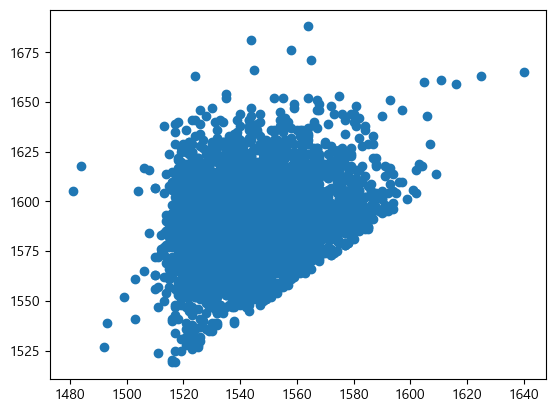

In [515]:
pltd = temp_measure_dt[temp_measure_dt["Temp_vcb_new"].between(1480, 1700)]
pltd = pltd[pltd["measure_temp_2"].between(1480, 1700)]
pltd = pltd[pltd["Temp_vcb_new"] < pltd["measure_temp_2"]]
plt.scatter(pltd["Temp_vcb_new"], 
            pltd["measure_temp_2"])

In [521]:
# 1회 승온 HEAT
temp_inc_cnt_1 = temp_measure_dt[temp_measure_dt["inc_count_max"] == 1]

# 2회 승온 HEAT
temp_inc_cnt_2 = temp_measure_dt[temp_measure_dt["inc_count_max"] == 2]

# 3회 승온 이상
temp_inc_cnt_3 = temp_measure_dt[temp_measure_dt["inc_count_max"] >= 3]

len(pd.unique(temp_inc_cnt_1["HEAT_NO"])), len(pd.unique(temp_inc_cnt_2["HEAT_NO"])), len(pd.unique(temp_inc_cnt_3["HEAT_NO"]))

(2010, 1542, 531)

In [507]:
agg_heating_int_subset = temp_measure_dt[["HEAT_NO", "생산강종", "반",  
                                          "inc_count_max", "total_heating_mwh", "cat_inc_count", "id_interval",
                                          "measure_last_melt_mwh", "Temp_vcb_new", "measure_temp_2"]]
agg_heating_int_subset

,HEAT_NO,생산강종,반,inc_count_max,total_heating_mwh,cat_inc_count,id_interval,measure_last_melt_mwh,Temp_vcb_new,measure_temp_2
0,E235375,SS275A36(T<25),D,2,4.796875,count_2,1,31.203125,1528.0,1555.0
1,E235375,SS275A36(T<25),D,2,4.796875,count_2,2,31.203125,1555.0,1583.0
2,E235375,SS275A36(T<25),D,2,4.796875,count_2,3,31.203125,1583.0,1583.0
3,E235377,SS275A36(T<25),D,4,5.101562,count_3_more,1,31.000000,1544.0,9999.0
4,E235377,SS275A36(T<25),D,4,5.101562,count_3_more,2,31.000000,9999.0,9999.0
...,...,...,...,...,...,...,...,...,...,...
10845,E240725,TRIPLE_1(15≤T<25),D,1,5.601562,count_1,1,28.703125,1541.0,1541.0
10846,E240725,TRIPLE_1(15≤T<25),D,1,5.601562,count_1,2,28.703125,1541.0,1585.0
10847,E240725,TRIPLE_1(15≤T<25),D,1,5.601562,count_1,3,28.703125,1585.0,1585.0
10848,E240726,300(2016),D,1,5.199219,count_1,1,29.093750,1533.0,1588.0


### 가중치 모형

In [164]:
# 
def fn_weighted_mean_temp2(data) :
    
    # 
    total_n = sum(data["cnt_n"])
    
    # 
    product_v = sum(data["cnt_n"]*data["temp2_mean"])
    
    # 
    weighted_mean = product_v/total_n
    
    return weighted_mean
;

''

In [180]:
temp_inc_cnt_data = temp_inc_cnt_1[temp_inc_cnt_1["int_tag"] == "Normal_PwrOn_interval"]
temp_inc_cnt_data = temp_inc_cnt_data[temp_inc_cnt_data["measure_temp_2"].between(1480, 1700)]
temp_inc_cnt_data = temp_inc_cnt_data[(temp_inc_cnt_data["measure_temp_2"] - temp_inc_cnt_data["Temp_vcb_new"]) > 20]

temp_inc_cnt_data["category_temp1"] = np.where(temp_inc_cnt_data["cat_temp_1"] <= 1545, "1545이하", "1545초과")
temp_inc_cnt_data["전력사용량범주"] = temp_inc_cnt_data["heating_mwh_vcb"] - temp_inc_cnt_data["heating_mwh_vcb"]%(0.5)

temp_inc_cnt_data["cnt_n"] = temp_inc_cnt_data.groupby(["category_temp1", "전력사용량범주"])["HEAT_NO"].transform(lambda x : len(x))
temp_inc_cnt_data["temp2_mean"] = temp_inc_cnt_data.groupby(["category_temp1", "전력사용량범주"])["delta_T_calc"].transform(lambda x : np.mean(x))


In [217]:
aaa = temp_inc_cnt_data[["Month", "HEAT_NO", "category_temp1"]].drop_duplicates()
aaa[aaa["Month"] <= 11].groupby(["category_temp1"])["HEAT_NO"].count().reset_index()

,category_temp1,HEAT_NO
0,1545이하,1131
1,1545초과,513


In [218]:
aaa = temp_inc_cnt_data[["Month", "HEAT_NO", "category_temp1"]].drop_duplicates()
aaa[aaa["Month"] > 11].groupby(["category_temp1"])["HEAT_NO"].count().reset_index()

,category_temp1,HEAT_NO
0,1545이하,85
1,1545초과,28


In [516]:
# Train data
summary_table_wgt_m_temp2 = temp_inc_cnt_data[temp_inc_cnt_data["Month"] < 12].groupby(["category_temp1", "전력사용량범주"]).apply(fn_weighted_mean_temp2).reset_index()
summary_table_wgt_m_temp2.rename(columns = {0 : "weighted_mean"}, inplace = True)


summary_table_wgt_m_temp2["전력사용량범주"] = summary_table_wgt_m_temp2["전력사용량범주"].astype("float64")
summary_table_wgt_m_temp2["전력사용량범주_2"] = np.log(summary_table_wgt_m_temp2["전력사용량범주"])


# test data : 12월 
testdata_12 = temp_inc_cnt_data[temp_inc_cnt_data["Month"] == 12]
testdata_12.drop(columns = ["전력사용량범주"], inplace = True)
testdata_12["total_heating_mwh"] = testdata_12.groupby(["HEAT_NO"])["heating_mwh_vcb"].transform(lambda x : sum(x))
# testdata_12 = testdata_12[testdata_12["total_heating_mwh"] > 0]
testdata_12.rename(columns = {"measure_temp_2" : "weighted_mean",
                              "total_heating_mwh" : "전력사용량범주"}, inplace = True)


testdata_12["전력사용량범주_2"] = np.log(testdata_12["전력사용량범주"])
testdata_12

,Month,HEAT_NO,생산강종,반,int_tag,cnt_vcb_off,id_interval,heating_mwh_vcb,Temp_vcb_new,delta_T_calc,heating_burnero2_vcb,heating_lanceo2_vcb,heating_injcarb_vcb,heating_time_vcb,inc_count_0,inc_count,inc_count_max,id_str0,id_str,weighted_mean,cat_temp_1,cat_inc_count,category_temp1,cnt_n,temp2_mean,전력사용량범주,전력사용량범주_2
10121,12,E240385,TRIPLE_1(15≤T<25),D,Normal_PwrOn_interval,1,1,1.695312,1549.0,43.0,8,117,0,2.000000,1,1,1,measure_1,measure_2,1592.0,1545.0,count_1,1545이하,5,43.000000,1.695312,0.527867
10123,12,E240386,TRIPLE_1(15≤T<25),D,Normal_PwrOn_interval,1,1,4.699219,1555.0,46.0,22,320,0,5.316667,1,1,1,measure_1,measure_2,1601.0,1555.0,count_1,1545초과,68,49.352941,4.699219,1.547396
10125,12,E240388,SHN355(T<25)V,D,Normal_PwrOn_interval,1,1,5.097656,1538.0,60.0,24,328,0,5.716667,1,1,1,measure_1,measure_2,1598.0,1535.0,count_1,1545이하,201,71.900498,5.097656,1.628781
10127,12,E240389,SHN355(T<25)V,D,Normal_PwrOn_interval,1,1,5.601562,1534.0,106.0,26,363,0,6.266667,1,1,1,measure_1,measure_2,1640.0,1530.0,count_1,1545이하,111,73.207207,5.601562,1.723046
10137,12,E240393,SHN355(T<25)V,D,Normal_PwrOn_interval,1,1,6.796875,1526.0,108.0,33,456,0,7.916667,1,1,1,measure_1,measure_2,1634.0,1525.0,count_1,1545이하,17,80.529412,6.796875,1.916463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10829,12,E240717,TRIPLE_1(15≤T<25),B,Normal_PwrOn_interval,1,1,3.902344,1551.0,49.0,20,236,96,4.650000,1,1,1,measure_1,measure_2,1600.0,1550.0,count_1,1545초과,104,49.538462,3.902344,1.361577
10831,12,E240720,S355J204,B,Normal_PwrOn_interval,1,1,5.703125,1533.0,49.0,27,350,63,6.416667,1,1,1,measure_1,measure_2,1582.0,1530.0,count_1,1545이하,111,73.207207,5.703125,1.741014
10837,12,E240722,S355J204,D,Normal_PwrOn_interval,1,1,4.703125,1581.0,67.0,24,326,0,5.716667,1,1,1,measure_1,measure_2,1648.0,1555.0,count_1,1545초과,68,49.352941,4.703125,1.548227
10846,12,E240725,TRIPLE_1(15≤T<25),D,Normal_PwrOn_interval,2,2,5.601562,1541.0,44.0,27,388,0,6.416667,1,1,1,measure_2,measure_3,1585.0,1540.0,count_1,1545이하,111,73.207207,5.601562,1.723046


In [517]:
# 범주 분리 : Train
train_temp_low = summary_table_wgt_m_temp2[summary_table_wgt_m_temp2["category_temp1"] == "1545이하"]
train_temp_high = summary_table_wgt_m_temp2[summary_table_wgt_m_temp2["category_temp1"] == "1545초과"]

# 범주 분리 : Test
test_temp_low = testdata_12[testdata_12["category_temp1"] == "1545이하"]
test_temp_high = testdata_12[testdata_12["category_temp1"] == "1545초과"]

In [518]:
test_temp_low.shape

(85, 27)

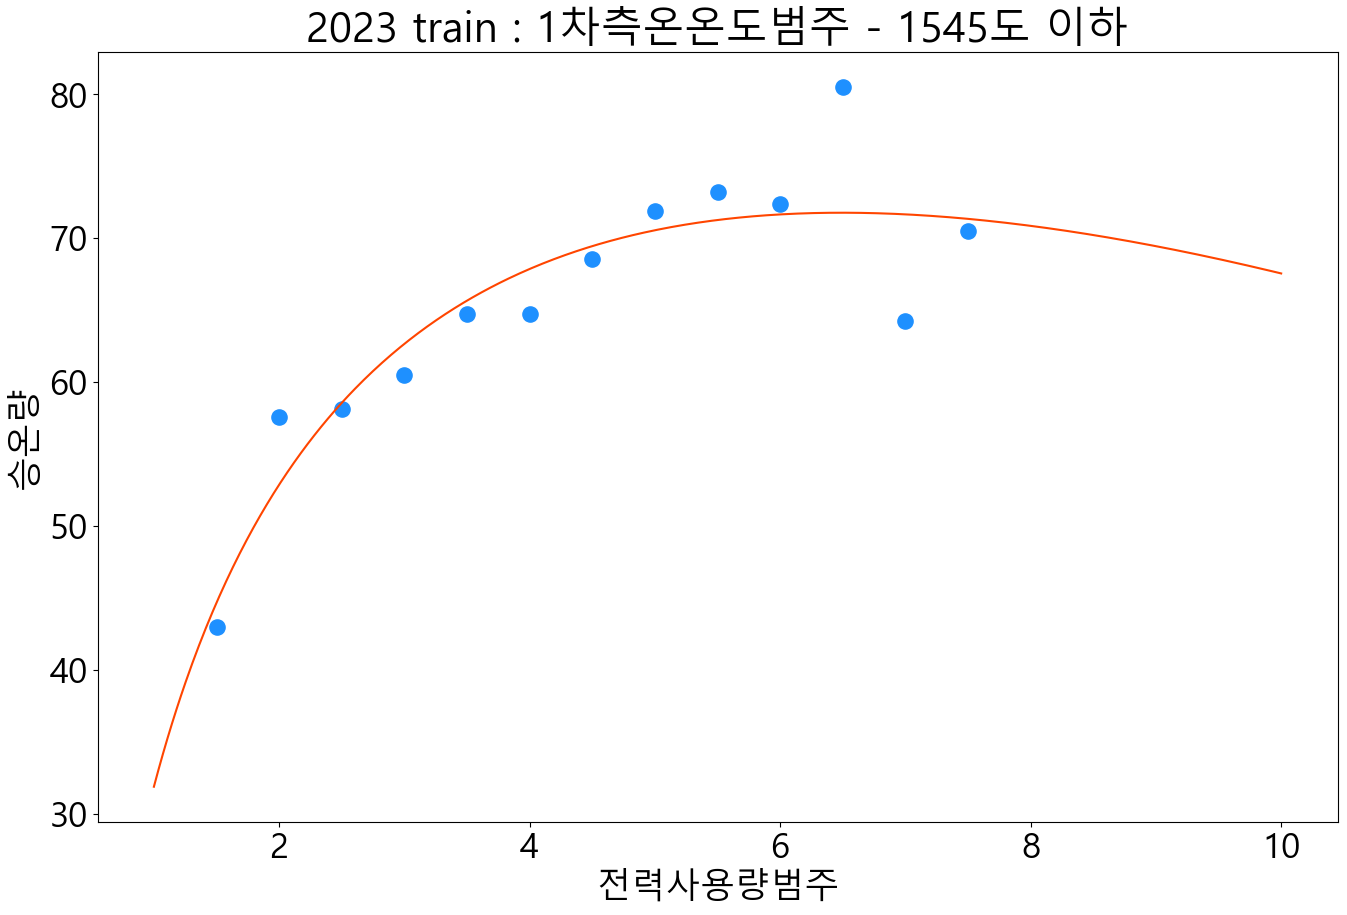

Text(0.5, 1.0, '2023 test : 1차측온온도범주 - 1545도 이하')

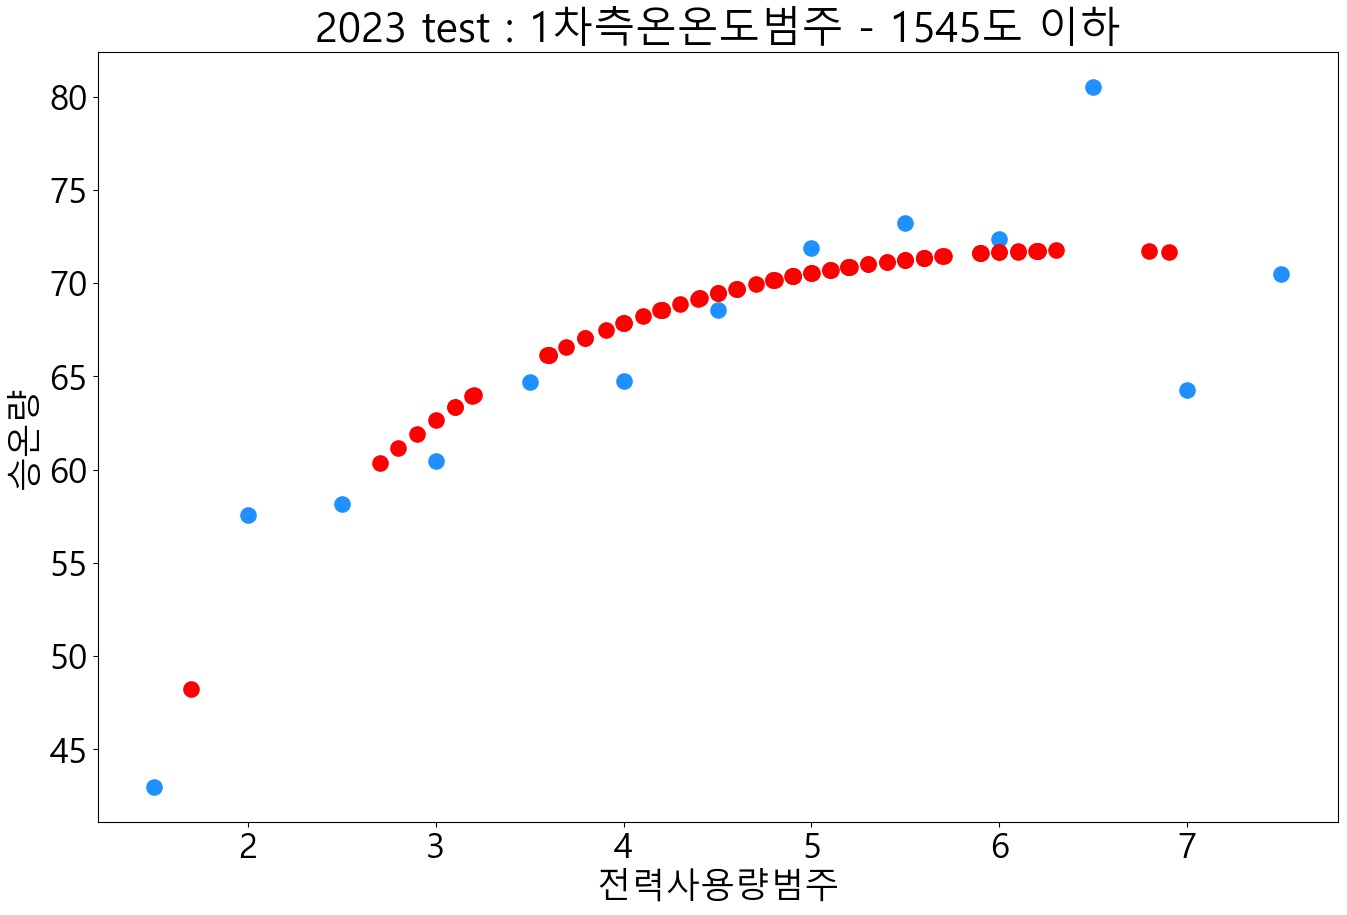

In [221]:
from statsmodels.formula.api import ols
from scipy.optimize import curve_fit


# 
plt.figure(figsize = (16, 10))

# 
lr_square = ols("weighted_mean ~ 전력사용량범주 + 전력사용량범주_2", data = train_temp_low)
results_square = lr_square.fit()
pred_sq = results_square.predict(train_temp_low[["전력사용량범주", "전력사용량범주_2"]])
rmse = np.sqrt(np.mean((train_temp_low["weighted_mean"] - pred_sq)**2))
square_cl1_dt = pd.DataFrame({"class_n" : train_temp_low["전력사용량범주"], 'pred' : pred_sq,
                             "rmse" : rmse, "rsq" : results_square.rsquared})
square_m_param_cl1 = results_square.params
train_temp_low["pred"] = pred_sq


# 
xaxis_space = np.linspace(1, 10, 500)

# set y curve
def curve_log(x, a, b, c) :
    
    return_curve = a + b*x + c*(np.log(x))
    return return_curve
;


# 
ydata_cl1 = curve_log(xaxis_space, 
                      square_m_param_cl1[0], 
                      square_m_param_cl1[1], 
                      square_m_param_cl1[2])
line_value_1, covs = curve_fit(curve_log, xaxis_space, ydata_cl1, method = "lm")

plt.scatter(train_temp_low["전력사용량범주"], train_temp_low["weighted_mean"], color = "dodgerblue", s = 120)
# plt.scatter(m_low["전력사용량범주"], m_low["pred"], color = "orangered", s = 120)
# plt.plot(xaxis_space, ydata_cl1, color = "lightgreen")
plt.plot(xaxis_space, ydata_cl1, color = "orangered")
plt.tick_params(labelsize = 25)
plt.xlabel("전력사용량범주", size = 25)
plt.ylabel("승온량", size = 25)
# plt.ylim(1560,1610)
# plt.ylim(0,120)
plt.title("2023 train : 1차측온온도범주 - 1545도 이하", size = 30)
plt.show()

# 
plt.figure(figsize = (16, 10))
plt.scatter(train_temp_low["전력사용량범주"], train_temp_low["weighted_mean"], color = "dodgerblue", s = 120)
test_predict = results_square.predict(test_temp_low[["전력사용량범주", "전력사용량범주_2"]])
plt.scatter(test_temp_low["전력사용량범주"], test_predict, color = "red", s = 120)
plt.tick_params(labelsize = 25)
plt.xlabel("전력사용량범주", size = 25)
plt.ylabel("승온량", size = 25)
plt.title("2023 test : 1차측온온도범주 - 1545도 이하", size = 30)

In [222]:
# 
test_temp_low["temp_predict"] = test_temp_low["Temp_vcb_new"] + test_predict
test_temp_low["difference"] = test_temp_low["weighted_mean"] - test_temp_low["temp_predict"] 
test_temp_low["check_inbound"] = np.where(test_temp_low["temp_predict"] >= 1575, "inbound", "out")

In [225]:
test_temp_low["check_inbound"].value_counts()

inbound    85
Name: check_inbound, dtype: int64

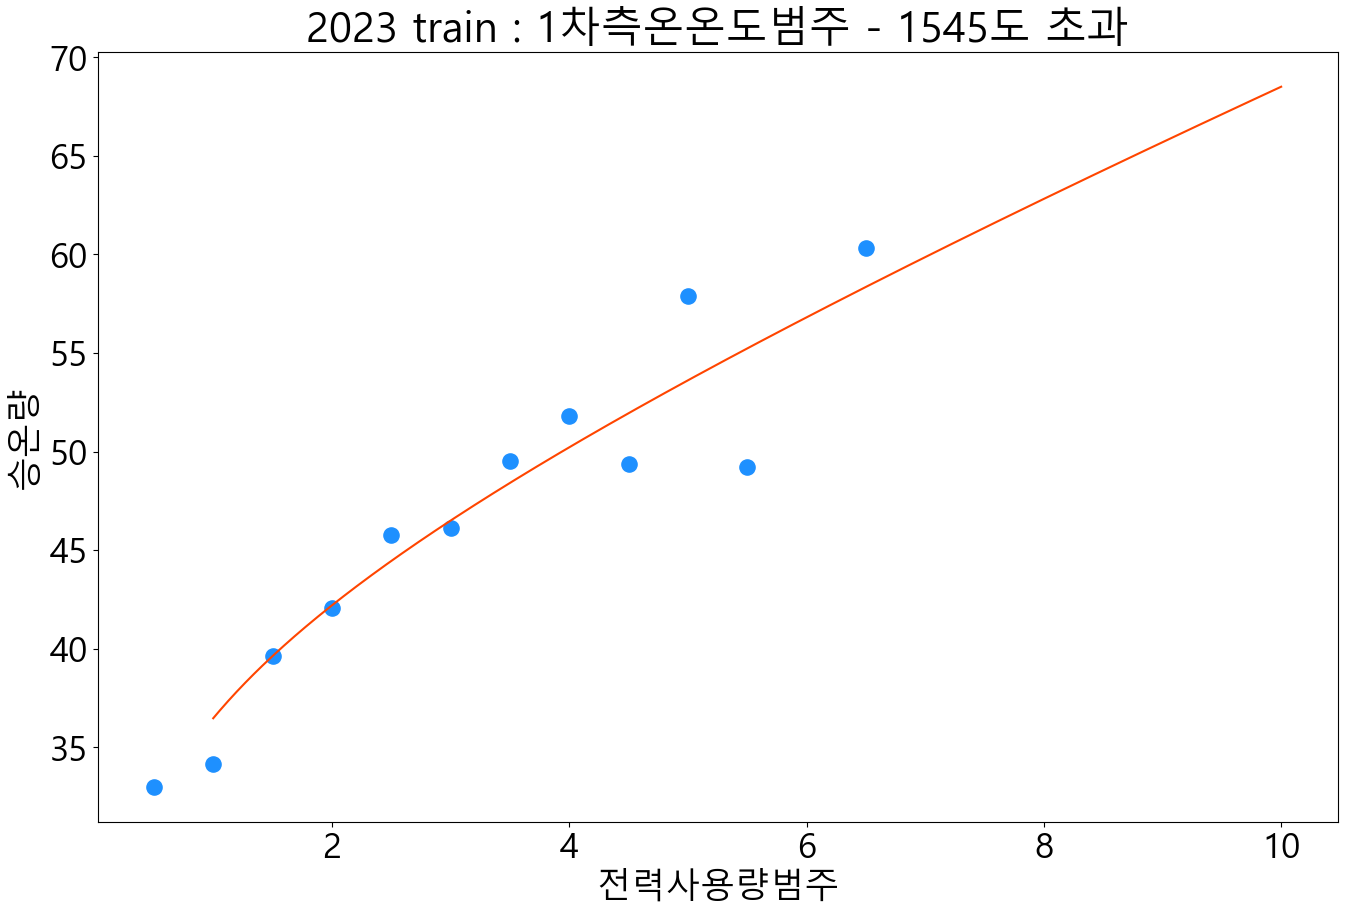

Text(0.5, 1.0, '2023 test : 1차측온온도범주 - 1545도 초과')

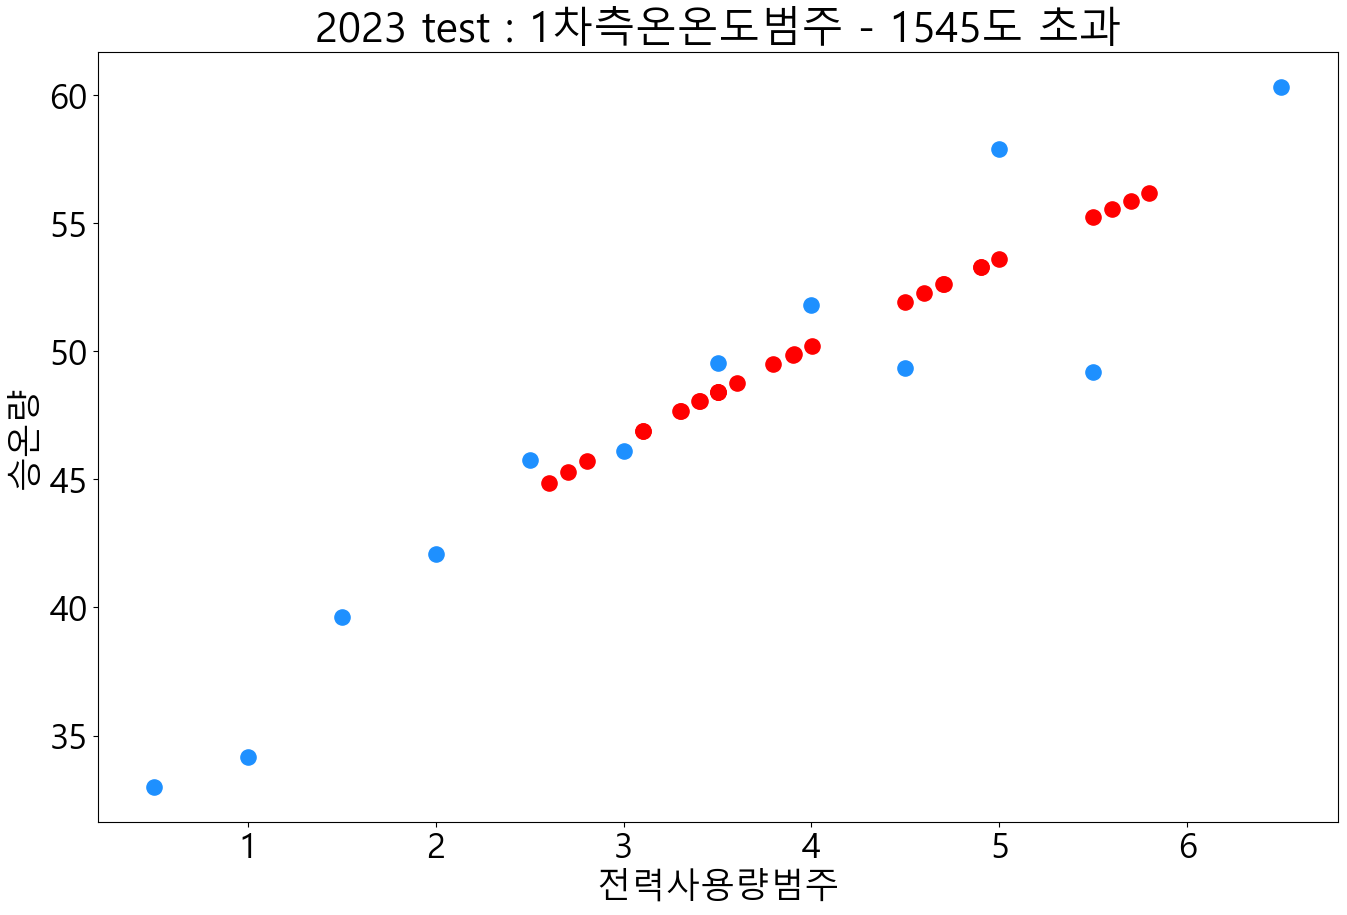

In [223]:
# 
plt.figure(figsize = (16, 10))

# 
lr_square = ols("weighted_mean ~ 전력사용량범주 + 전력사용량범주_2", data = train_temp_high)
results_square = lr_square.fit()
pred_sq = results_square.predict(train_temp_high[["전력사용량범주", "전력사용량범주_2"]])
rmse = np.sqrt(np.mean((train_temp_high["weighted_mean"] - pred_sq)**2))
square_cl1_dt = pd.DataFrame({"class_n" : train_temp_high["전력사용량범주"], 'pred' : pred_sq,
                             "rmse" : rmse, "rsq" : results_square.rsquared})
square_m_param_cl1 = results_square.params
train_temp_high["pred"] = pred_sq


# 
xaxis_space = np.linspace(1, 10, 500)

# set y curve
def curve_log(x, a, b, c) :
    
    return_curve = a + b*x + c*(np.log(x))
    return return_curve
;


# 
ydata_cl1 = curve_log(xaxis_space, 
                      square_m_param_cl1[0], 
                      square_m_param_cl1[1], 
                      square_m_param_cl1[2])
line_value_1, covs = curve_fit(curve_log, xaxis_space, ydata_cl1, method = "lm")

plt.scatter(train_temp_high["전력사용량범주"], train_temp_high["weighted_mean"], color = "dodgerblue", s = 120)
plt.plot(xaxis_space, ydata_cl1, color = "orangered")
plt.tick_params(labelsize = 25)
plt.xlabel("전력사용량범주", size = 25)
plt.ylabel("승온량", size = 25)
# plt.ylim(1560,1610)
# plt.ylim(0,120)
plt.title("2023 train : 1차측온온도범주 - 1545도 초과", size = 30)
plt.show()

# 
plt.figure(figsize = (16, 10))
plt.scatter(train_temp_high["전력사용량범주"], train_temp_high["weighted_mean"], color = "dodgerblue", s = 120)
test_predict = results_square.predict(test_temp_high[["전력사용량범주", "전력사용량범주_2"]])
plt.scatter(test_temp_high["전력사용량범주"], test_predict, color = "red", s = 120)
plt.tick_params(labelsize = 25)
plt.xlabel("전력사용량범주", size = 25)
plt.ylabel("승온량", size = 25)
plt.title("2023 test : 1차측온온도범주 - 1545도 초과", size = 30)

In [224]:
# 
test_temp_high["temp_predict"] = test_temp_high["Temp_vcb_new"] + test_predict
test_temp_high["difference"] = test_temp_high["weighted_mean"] - test_temp_high["temp_predict"] 
test_temp_high["check_inbound"] = np.where(test_temp_high["temp_predict"] >= 1575, "inbound", "out")

In [226]:
test_temp_high["check_inbound"].value_counts()

inbound    28
Name: check_inbound, dtype: int64

### 승온기 가중치 모형 추가 개선점?(2024)
- 조업 반 별 Model 층별화 
- 용락시점 정보의 Model 반영 필요(EX : 용락시점 별 범주화 & 1차 측온온도 범주 세분화) 
- 기타 고려 가능한 변수 Model 추가 필요
- 다회 승온 case에 대한 Model 개발 필요(측온 실패 case 데이터를 활용해야 함)
- 가이던스 및 Model 업데이트 주기 설정 필요 

### 승온기 분리 데이터 추가확보 testcode 
> - 기존 승온기 판단 : TimeSincePwrOn over 0.1 min & PX3SteelTemp above 0    
> - (추가) : 기존 로직으로 판단이 되지 않는 경우 전력 변동 시간의 차이 확인  
    - 3차 장입 용락 시점 MWH 범위 내에서 전원이 일정시간 이상 끊긴 후 다시 인가되기 시작하는 시점 탐색  
    - 용락 시점 통계 산출에만 이용하려고 하는 경우 필요할수도...?

In [15]:
# charge 3 분리 
fulldata_charge_3 = fulldata[fulldata["ActualCHRG_PX3"] == 3]

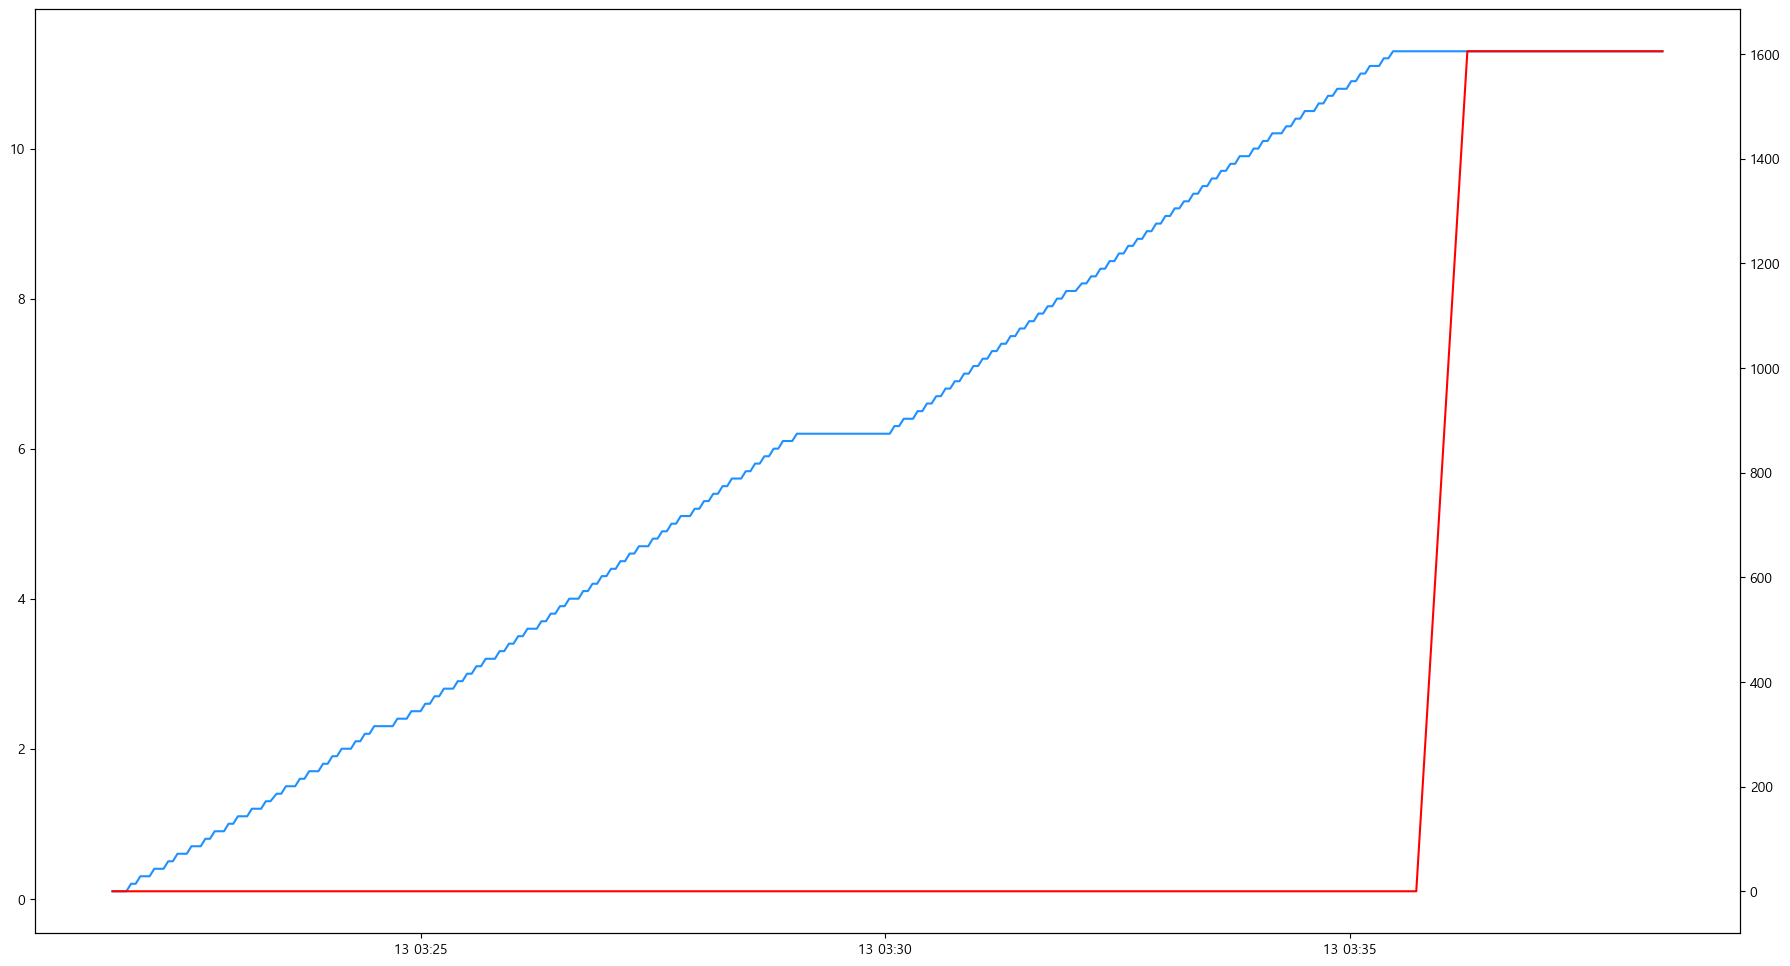

In [19]:
fig = plt.figure(figsize = (22, 12))
ax = fig.add_subplot()

ax.plot(data["Time"], data["Charge_MWH"], color = "dodgerblue")
ax2 = ax.twinx()
ax2.plot(data["Time"], data["PX3SteelTemp"], color = "red")